In [1]:
import importlib
import frengression
# importlib.reload(frengression)
from data_causl.data_causl import *
from data_causl.datasets import *
from frengression import *
device = torch.device('cpu')
from CausalEGM import *

import numpy as np
import jax.numpy as jnp
import pickle
import os
from tqdm import tqdm
# import src.exp_utils as exp_utils

from matplotlib import pyplot as plt


np.random.seed(2024)
n_tr = 1000
n_p = 1000

nI = 0
nX = 1
nO = 0
nS= 0
p = nI+nX+nO+nS
ate = 2
beta_cov = 0
strength_instr = 1
strength_conf = 1
strength_outcome = 1
binary_intervention=True


In [2]:
df_tr = generate_data_causl(n=n_tr, nI =nI, nX= nX, nO = nO, nS = nS, ate = ate, beta_cov = beta_cov, strength_instr = strength_instr, strength_conf = strength_conf, strength_outcome =strength_outcome, binary_intervention=binary_intervention)

z_tr = torch.tensor(df_tr[[f"X{i}" for i in range(1, p + 1)]].values, dtype=torch.float32)
if binary_intervention:
    x_tr = torch.tensor(df_tr['A'].values, dtype=torch.int32).view(-1, 1)
else:
    x_tr = torch.tensor(df_tr['A'].values, dtype=torch.float32).view(-1, 1)

y_tr = torch.tensor(df_tr['y'].values, dtype=torch.float32).view(-1, 1)

model = Frengression(x_tr.shape[1], y_tr.shape[1], z_tr.shape[1], noise_dim=1, num_layer=3, hidden_dim=400, device=device, x_binary = binary_intervention)
# model.train_xz(x_tr, z_tr, num_iters=1000, lr=1e-4, print_every_iter=100)
model.train_y(x_tr, z_tr, y_tr, num_iters=300, lr=1e-4, print_every_iter=100)

Epoch 1: loss 2.2137,	loss_y 1.4249, 1.4418, 0.0337,	loss_eta 0.7887, 0.8320, 0.0866
Epoch 100: loss 1.2953,	loss_y 0.6614, 1.4112, 1.4996,	loss_eta 0.6339, 1.0005, 0.7331
Epoch 200: loss 1.5190,	loss_y 0.7352, 1.4332, 1.3960,	loss_eta 0.7838, 1.0181, 0.4686
Epoch 300: loss 1.3824,	loss_y 0.7286, 1.3600, 1.2629,	loss_eta 0.6538, 0.8521, 0.3966


# Evaluate Y|do(X)
We mainly compare causal margin under binary treatments. P0, P1 store Ys sampled from fitted frengression under control and treatment, respectively. Q0, Q1 store Ys sampled from true Y|do(X) under control and treatment, respectively.

# Log performance varying iterations.

### Binary treatment

In [3]:
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import log_loss
from scipy.spatial.distance import pdist, squareform

# Helper function for MMD
def mmd_rbf(x, y, sigma=1.0):
    """Compute MMD between two distributions using RBF kernel."""
    pairwise_sq_dists = squareform(pdist(np.vstack([x, y]), 'sqeuclidean'))
    K = np.exp(-pairwise_sq_dists / (2 * sigma ** 2))
    K_xx = K[:len(x), :len(x)]
    K_xy = K[:len(x), len(x):]
    K_yy = K[len(x):, len(x):]
    mmd = np.mean(K_xx) - 2 * np.mean(K_xy) + np.mean(K_yy)
    return mmd

In [3]:
nrep = 30 # for equivalence testing
n_tr = 1000
n_p = 1000
# Initialize an empty list to store each Q_single
nI = 0
nX = 1
nO = 0
nS= 0
p = nI+nX+nO+nS
binary_intervention=True

# Initialize an empty list to store each Q_single
P0_list = []
Q0_list = []

P1_list = []
Q1_list = []

P_joint_list = []
Q_joint_list = []

tracker = {iteration: {"mmd_p0_q0": [], "mmd_p1_q1": [], "mmd_joint": [], "logreg_coeffs_p": [], "logreg_coeffs_q": []}
           for iteration in [500, 1000, 1500, 2000, 2500, 3000, 3500, 4000]}
# Begin experiment
for rep in tqdm(range(nrep)):
    # Generate data
    df_tr = generate_data_causl(n=n_tr, nI=nI, nX=nX, nO=nO, nS=nS, ate=ate, 
                                beta_cov=beta_cov, strength_instr=strength_instr, 
                                strength_conf=strength_conf, 
                                strength_outcome=strength_outcome, 
                                binary_intervention=binary_intervention)
    z_tr = torch.tensor(df_tr[[f"X{i}" for i in range(1, p + 1)]].values, dtype=torch.float32)
    x_tr = torch.tensor(df_tr['A'].values, dtype=torch.int32).view(-1, 1) if binary_intervention else \
           torch.tensor(df_tr['A'].values, dtype=torch.float32).view(-1, 1)
    y_tr = torch.tensor(df_tr['y'].values, dtype=torch.float32).view(-1, 1)

    model = Frengression(x_tr.shape[1], y_tr.shape[1], z_tr.shape[1], 
                         noise_dim=1, num_layer=3, hidden_dim=400, 
                         device=device, x_binary=binary_intervention)
    
    df_q = generate_data_causl(n=n_p, nI=nI, nX=nX, nO=nO, nS=nS, ate=ate, 
                                beta_cov=beta_cov, strength_instr=strength_instr, 
                                strength_conf=strength_conf, 
                                strength_outcome=strength_outcome, 
                                binary_intervention=binary_intervention)
    
    z_q = torch.tensor(df_q[[f"X{i}" for i in range(1, p + 1)]].values, dtype=torch.float32)
    x_q = torch.tensor(df_q['A'].values, dtype=torch.int32).view(-1, 1) if binary_intervention else \
           torch.tensor(df_q['A'].values, dtype=torch.float32).view(-1, 1)
    y_q = torch.tensor(df_q['y'].values, dtype=torch.float32).view(-1, 1)


    # Sample Q distributions
    Q0 = np.random.normal(loc=0, scale=1, size=n_p).reshape([n_p, 1])
    Q1 = np.random.normal(loc=ate, scale=1, size=n_p).reshape([n_p, 1])
    Q_joint = torch.cat([x_q, y_q, z_q],dim=1).numpy()  # Ground truth joint distribution (x, y, z)

    Q0_list.append(Q0)
    Q1_list.append(Q1)
    Q_joint_list.append(Q_joint)

    last_iteration = 0
    for iteration in tracker.keys():
        additional_iters = iteration - last_iteration
        last_iteration = iteration
        # Train model
        model.train_xz(x_tr, z_tr, num_iters=additional_iters, lr=1e-4, print_every_iter=100)
        model.train_y(x_tr, z_tr, y_tr, num_iters=additional_iters, lr=1e-4, print_every_iter=100)

        # Sample P distributions
        P0 = (model.sample_causal_margin(torch.tensor([0], dtype=torch.int32), sample_size=n_p)).numpy().reshape(-1, 1)
        P1 = (model.sample_causal_margin(torch.tensor([1], dtype=torch.int32), sample_size=n_p)).numpy().reshape(-1, 1)
        x_gen, y_gen, z_gen = model.sample_joint(sample_size=n_p)  # Sample joint distribution (x, y, z)
        P_joint = torch.cat([x_gen, y_gen, z_gen], dim=1).numpy()

        # Calculate MMD
        mmd_p0_q0 = mmd_rbf(P0, Q0, sigma=1.0)
        mmd_p1_q1 = mmd_rbf(P1, Q1, sigma=1.0)
        mmd_joint = mmd_rbf(P_joint, Q_joint, sigma=1.0)

        logistic_model_p = LogisticRegression()
        logistic_model_p.fit(z_gen.numpy(), x_gen.numpy().ravel())
        logreg_coeffs_p = logistic_model_p.coef_

        # Logistic regression for Q (x_q, z_q from ground truth)
        logistic_model_q = LogisticRegression()
        logistic_model_q.fit(z_q.numpy(), x_q.numpy().ravel())
        logreg_coeffs_q = logistic_model_q.coef_

        # Log results
        tracker[iteration]["mmd_p0_q0"].append(mmd_p0_q0)
        tracker[iteration]["mmd_p1_q1"].append(mmd_p1_q1)
        tracker[iteration]["mmd_joint"].append(mmd_joint)
        tracker[iteration]["logreg_coeffs_p"].append(logreg_coeffs_p)
        tracker[iteration]["logreg_coeffs_q"].append(logreg_coeffs_q)
    P0_list.append(P0)
    P1_list.append(P1)
    P_joint_list.append(P_joint)

P0s = np.stack(P0_list, axis=0) #[nrep, n, 1]
Q0s = np.stack(Q0_list, axis=0)
P1s = np.stack(P1_list, axis=0)
Q1s = np.stack(Q1_list, axis=0)
PJoints = np.stack(P_joint_list, axis=0)
QJoints = np.stack(Q_joint_list, axis=0)


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1: loss 0.9733, loss1 1.0035, loss2 0.0603
Epoch 100: loss 0.6833, loss1 1.3142, loss2 1.2616
Epoch 200: loss 0.7198, loss1 1.3795, loss2 1.3194
Epoch 300: loss 0.6960, loss1 1.3686, loss2 1.3452
Epoch 400: loss 0.6979, loss1 1.3704, loss2 1.3450
Epoch 500: loss 0.6677, loss1 1.3532, loss2 1.3710
Epoch 1: loss 2.1920,	loss_y 1.3924, 1.4159, 0.0470,	loss_eta 0.7996, 0.8260, 0.0528
Epoch 100: loss 1.1985,	loss_y 0.5756, 1.5470, 1.9430,	loss_eta 0.6229, 1.0340, 0.8223
Epoch 200: loss 1.4829,	loss_y 0.6595, 1.0873, 0.8555,	loss_eta 0.8234, 1.0199, 0.3930
Epoch 300: loss 1.5247,	loss_y 0.8557, 1.9076, 2.1038,	loss_eta 0.6690, 0.8504, 0.3629
Epoch 400: loss 1.9310,	loss_y 1.3493, 2.0334, 1.3682,	loss_eta 0.5817, 1.3123, 1.4612
Epoch 500: loss 1.6121,	loss_y 1.0480, 2.1163, 2.1367,	loss_eta 0.5642, 0.9468, 0.7654
Epoch 1: loss 0.6741, loss1 1.3663, loss2 1.3845
Epoch 100: loss 0.6786, loss1 1.3106, loss2 1.2640
Epoch 200: loss 0.6805, loss1 1.3541, loss2 1.3472
Epoch 300: loss 0.6951, l

  3%|▎         | 1/30 [01:19<38:26, 79.53s/it]

Epoch 500: loss 1.1201,	loss_y 0.5208, 0.9899, 0.9382,	loss_eta 0.5993, 1.1253, 1.0520
Epoch 1: loss 0.9805, loss1 1.0131, loss2 0.0652
Epoch 100: loss 0.6899, loss1 1.3463, loss2 1.3128
Epoch 200: loss 0.6658, loss1 1.3244, loss2 1.3172
Epoch 300: loss 0.6995, loss1 1.3622, loss2 1.3255
Epoch 400: loss 0.6857, loss1 1.3662, loss2 1.3610
Epoch 500: loss 0.6990, loss1 1.3627, loss2 1.3274
Epoch 1: loss 2.3736,	loss_y 1.6038, 1.6443, 0.0809,	loss_eta 0.7698, 0.8132, 0.0868
Epoch 100: loss 1.1603,	loss_y 0.5738, 1.7217, 2.2958,	loss_eta 0.5865, 0.8966, 0.6202
Epoch 200: loss 1.3739,	loss_y 0.6246, 0.9565, 0.6639,	loss_eta 0.7494, 1.1023, 0.7058
Epoch 300: loss 1.4529,	loss_y 0.7625, 1.5250, 1.5250,	loss_eta 0.6904, 1.2486, 1.1164
Epoch 400: loss 1.4264,	loss_y 0.8387, 2.0723, 2.4672,	loss_eta 0.5877, 1.0754, 0.9754
Epoch 500: loss 1.6622,	loss_y 1.1058, 1.7435, 1.2755,	loss_eta 0.5564, 1.0790, 1.0452
Epoch 1: loss 0.6637, loss1 1.3383, loss2 1.3493
Epoch 100: loss 0.6680, loss1 1.3749, lo

  7%|▋         | 2/30 [02:25<33:15, 71.28s/it]

Epoch 500: loss 1.1169,	loss_y 0.5164, 0.9837, 0.9345,	loss_eta 0.6005, 1.2139, 1.2269
Epoch 1: loss 0.9608, loss1 1.0010, loss2 0.0804
Epoch 100: loss 0.6680, loss1 1.3224, loss2 1.3089
Epoch 200: loss 0.6408, loss1 1.3115, loss2 1.3415
Epoch 300: loss 0.6573, loss1 1.3468, loss2 1.3790
Epoch 400: loss 0.6851, loss1 1.3838, loss2 1.3975
Epoch 500: loss 0.6708, loss1 1.2936, loss2 1.2456
Epoch 1: loss 2.2704,	loss_y 1.4694, 1.4832, 0.0277,	loss_eta 0.8010, 0.8202, 0.0383
Epoch 100: loss 1.3230,	loss_y 0.6906, 1.8493, 2.3176,	loss_eta 0.6325, 1.1025, 0.9399
Epoch 200: loss 1.5483,	loss_y 0.7310, 1.0226, 0.5833,	loss_eta 0.8174, 0.9497, 0.2647
Epoch 300: loss 1.2930,	loss_y 0.6540, 1.3235, 1.3391,	loss_eta 0.6390, 0.9092, 0.5404
Epoch 400: loss 1.6874,	loss_y 1.1124, 2.2135, 2.2022,	loss_eta 0.5749, 1.1230, 1.0961
Epoch 500: loss 1.6555,	loss_y 1.1014, 1.5726, 0.9425,	loss_eta 0.5541, 1.0644, 1.0206
Epoch 1: loss 0.6771, loss1 1.3249, loss2 1.2956
Epoch 100: loss 0.6445, loss1 1.3208, lo

 10%|█         | 3/30 [03:30<30:50, 68.55s/it]

Epoch 500: loss 1.0703,	loss_y 0.5202, 0.9787, 0.9171,	loss_eta 0.5501, 1.0788, 1.0575
Epoch 1: loss 0.9673, loss1 0.9959, loss2 0.0573
Epoch 100: loss 0.6984, loss1 1.3529, loss2 1.3090
Epoch 200: loss 0.7020, loss1 1.3539, loss2 1.3037
Epoch 300: loss 0.6705, loss1 1.3248, loss2 1.3085
Epoch 400: loss 0.6907, loss1 1.3438, loss2 1.3061
Epoch 500: loss 0.6787, loss1 1.3600, loss2 1.3626
Epoch 1: loss 2.3506,	loss_y 1.5350, 1.5591, 0.0483,	loss_eta 0.8156, 0.8522, 0.0731
Epoch 100: loss 1.2268,	loss_y 0.6656, 1.7053, 2.0793,	loss_eta 0.5611, 1.0001, 0.8780
Epoch 200: loss 1.2299,	loss_y 0.5701, 0.8886, 0.6370,	loss_eta 0.6598, 0.8592, 0.3989
Epoch 300: loss 1.2921,	loss_y 0.7371, 1.6929, 1.9116,	loss_eta 0.5550, 1.1765, 1.2429
Epoch 400: loss 1.2294,	loss_y 0.6265, 1.1400, 1.0270,	loss_eta 0.6029, 1.1559, 1.1060
Epoch 500: loss 1.2959,	loss_y 0.6070, 1.0920, 0.9701,	loss_eta 0.6889, 1.0090, 0.6401
Epoch 1: loss 0.6418, loss1 1.3211, loss2 1.3588
Epoch 100: loss 0.6941, loss1 1.3737, lo

 13%|█▎        | 4/30 [04:35<29:03, 67.08s/it]

Epoch 500: loss 1.0527,	loss_y 0.4763, 0.9839, 1.0152,	loss_eta 0.5764, 1.1475, 1.1423
Epoch 1: loss 0.9612, loss1 1.0030, loss2 0.0835
Epoch 100: loss 0.7166, loss1 1.3608, loss2 1.2884
Epoch 200: loss 0.6746, loss1 1.3761, loss2 1.4030
Epoch 300: loss 0.7242, loss1 1.3484, loss2 1.2484
Epoch 400: loss 0.6857, loss1 1.3384, loss2 1.3055
Epoch 500: loss 0.6568, loss1 1.3529, loss2 1.3924
Epoch 1: loss 2.2406,	loss_y 1.4312, 1.4508, 0.0392,	loss_eta 0.8094, 0.8436, 0.0685
Epoch 100: loss 1.2428,	loss_y 0.6315, 1.7366, 2.2102,	loss_eta 0.6113, 0.9437, 0.6647
Epoch 200: loss 1.4137,	loss_y 0.8192, 1.2058, 0.7731,	loss_eta 0.5945, 1.0862, 0.9835
Epoch 300: loss 1.5293,	loss_y 0.8842, 1.6314, 1.4944,	loss_eta 0.6451, 1.2564, 1.2225
Epoch 400: loss 1.7437,	loss_y 1.1780, 1.3942, 0.4324,	loss_eta 0.5657, 0.9447, 0.7580
Epoch 500: loss 1.6286,	loss_y 0.9901, 1.0907, 0.2012,	loss_eta 0.6385, 1.1859, 1.0948
Epoch 1: loss 0.6731, loss1 1.3582, loss2 1.3701
Epoch 100: loss 0.6822, loss1 1.3482, lo

 17%|█▋        | 5/30 [05:39<27:33, 66.16s/it]

Epoch 500: loss 1.0904,	loss_y 0.5100, 0.9726, 0.9252,	loss_eta 0.5804, 1.1282, 1.0957
Epoch 1: loss 0.9632, loss1 0.9959, loss2 0.0654
Epoch 100: loss 0.6774, loss1 1.3282, loss2 1.3016
Epoch 200: loss 0.6804, loss1 1.3187, loss2 1.2766
Epoch 300: loss 0.6553, loss1 1.3324, loss2 1.3541
Epoch 400: loss 0.7051, loss1 1.3316, loss2 1.2531
Epoch 500: loss 0.6698, loss1 1.3402, loss2 1.3409
Epoch 1: loss 2.3728,	loss_y 1.5785, 1.5868, 0.0166,	loss_eta 0.7942, 0.8274, 0.0663
Epoch 100: loss 1.2613,	loss_y 0.6192, 0.9196, 0.6009,	loss_eta 0.6421, 1.0350, 0.7856
Epoch 200: loss 1.9599,	loss_y 1.3445, 1.6872, 0.6855,	loss_eta 0.6154, 0.9915, 0.7522
Epoch 300: loss 1.6880,	loss_y 1.0886, 1.8591, 1.5410,	loss_eta 0.5994, 0.9255, 0.6522
Epoch 400: loss 1.3991,	loss_y 0.7335, 1.2694, 1.0718,	loss_eta 0.6656, 1.6092, 1.8873
Epoch 500: loss 1.2290,	loss_y 0.6561, 1.3829, 1.4537,	loss_eta 0.5729, 1.6208, 2.0956
Epoch 1: loss 0.6826, loss1 1.3662, loss2 1.3671
Epoch 100: loss 0.6880, loss1 1.3418, lo

 20%|██        | 6/30 [06:45<26:24, 66.02s/it]

Epoch 500: loss 1.0657,	loss_y 0.5011, 1.0434, 1.0845,	loss_eta 0.5646, 1.1637, 1.1983
Epoch 1: loss 1.0174, loss1 1.0606, loss2 0.0865
Epoch 100: loss 0.6879, loss1 1.3762, loss2 1.3766
Epoch 200: loss 0.7799, loss1 1.4608, loss2 1.3617
Epoch 300: loss 0.6830, loss1 1.3963, loss2 1.4268
Epoch 400: loss 0.7143, loss1 1.3834, loss2 1.3382
Epoch 500: loss 0.7241, loss1 1.4300, loss2 1.4118
Epoch 1: loss 2.2324,	loss_y 1.4956, 1.5190, 0.0468,	loss_eta 0.7368, 0.7832, 0.0929
Epoch 100: loss 1.3491,	loss_y 0.6814, 1.6400, 1.9170,	loss_eta 0.6677, 1.1061, 0.8769
Epoch 200: loss 1.1933,	loss_y 0.5268, 1.1093, 1.1650,	loss_eta 0.6664, 0.8422, 0.3515
Epoch 300: loss 1.2497,	loss_y 0.6689, 1.2577, 1.1776,	loss_eta 0.5808, 0.9647, 0.7677
Epoch 400: loss 1.2253,	loss_y 0.6770, 1.0069, 0.6598,	loss_eta 0.5483, 1.0374, 0.9782
Epoch 500: loss 1.4038,	loss_y 0.7585, 1.4008, 1.2846,	loss_eta 0.6453, 1.0867, 0.8827
Epoch 1: loss 0.7149, loss1 1.4044, loss2 1.3790
Epoch 100: loss 0.7091, loss1 1.4159, lo

 23%|██▎       | 7/30 [07:50<25:10, 65.68s/it]

Epoch 500: loss 1.0341,	loss_y 0.5049, 0.9979, 0.9860,	loss_eta 0.5292, 1.1238, 1.1891
Epoch 1: loss 0.9868, loss1 1.0203, loss2 0.0671
Epoch 100: loss 0.7059, loss1 1.3590, loss2 1.3062
Epoch 200: loss 0.7155, loss1 1.3907, loss2 1.3503
Epoch 300: loss 0.6873, loss1 1.3666, loss2 1.3585
Epoch 400: loss 0.6798, loss1 1.3634, loss2 1.3671
Epoch 500: loss 0.6969, loss1 1.3835, loss2 1.3731
Epoch 1: loss 2.2196,	loss_y 1.4384, 1.4841, 0.0914,	loss_eta 0.7812, 0.8279, 0.0933
Epoch 100: loss 1.2485,	loss_y 0.6574, 1.6796, 2.0443,	loss_eta 0.5911, 0.9474, 0.7126
Epoch 200: loss 1.1350,	loss_y 0.5098, 0.9103, 0.8011,	loss_eta 0.6253, 1.0140, 0.7775
Epoch 300: loss 1.2378,	loss_y 0.6403, 1.2779, 1.2753,	loss_eta 0.5976, 1.1933, 1.1914
Epoch 400: loss 1.4086,	loss_y 0.7522, 0.8943, 0.2842,	loss_eta 0.6564, 1.0934, 0.8742
Epoch 500: loss 1.5263,	loss_y 0.8969, 2.3939, 2.9939,	loss_eta 0.6294, 1.5676, 1.8765
Epoch 1: loss 0.6992, loss1 1.3684, loss2 1.3385
Epoch 100: loss 0.7027, loss1 1.3732, lo

 27%|██▋       | 8/30 [08:54<23:57, 65.33s/it]

Epoch 500: loss 1.0121,	loss_y 0.4697, 0.9630, 0.9866,	loss_eta 0.5424, 1.1278, 1.1708
Epoch 1: loss 0.9495, loss1 1.0071, loss2 0.1152
Epoch 100: loss 0.6711, loss1 1.3155, loss2 1.2889
Epoch 200: loss 0.6702, loss1 1.3415, loss2 1.3424
Epoch 300: loss 0.6819, loss1 1.3657, loss2 1.3675
Epoch 400: loss 0.6760, loss1 1.3240, loss2 1.2962
Epoch 500: loss 0.6861, loss1 1.3624, loss2 1.3525
Epoch 1: loss 2.1692,	loss_y 1.3790, 1.3892, 0.0206,	loss_eta 0.7903, 0.8171, 0.0537
Epoch 100: loss 1.1417,	loss_y 0.5646, 0.9515, 0.7737,	loss_eta 0.5770, 1.1168, 1.0796
Epoch 200: loss 1.3399,	loss_y 0.6378, 1.4118, 1.5479,	loss_eta 0.7021, 0.8580, 0.3117
Epoch 300: loss 1.2327,	loss_y 0.5451, 1.1684, 1.2465,	loss_eta 0.6876, 0.8757, 0.3763
Epoch 400: loss 1.3813,	loss_y 0.6951, 1.4031, 1.4159,	loss_eta 0.6862, 0.9486, 0.5249
Epoch 500: loss 1.5797,	loss_y 0.8907, 1.2145, 0.6475,	loss_eta 0.6889, 0.8500, 0.3222
Epoch 1: loss 0.6671, loss1 1.3610, loss2 1.3878
Epoch 100: loss 0.6644, loss1 1.3292, lo

 30%|███       | 9/30 [09:59<22:45, 65.05s/it]

Epoch 500: loss 1.0773,	loss_y 0.4880, 1.0372, 1.0984,	loss_eta 0.5893, 1.1974, 1.2161
Epoch 1: loss 0.9832, loss1 1.0176, loss2 0.0687
Epoch 100: loss 0.7120, loss1 1.3808, loss2 1.3375
Epoch 200: loss 0.6801, loss1 1.3405, loss2 1.3207
Epoch 300: loss 0.6850, loss1 1.3894, loss2 1.4087
Epoch 400: loss 0.7033, loss1 1.3718, loss2 1.3370
Epoch 500: loss 0.6679, loss1 1.3352, loss2 1.3346
Epoch 1: loss 2.3228,	loss_y 1.5487, 1.5841, 0.0707,	loss_eta 0.7741, 0.8000, 0.0518
Epoch 100: loss 1.4184,	loss_y 0.8628, 2.0884, 2.4512,	loss_eta 0.5556, 0.9967, 0.8822
Epoch 200: loss 1.3406,	loss_y 0.7869, 1.1909, 0.8079,	loss_eta 0.5537, 1.0811, 1.0548
Epoch 300: loss 1.3275,	loss_y 0.7118, 1.6960, 1.9684,	loss_eta 0.6157, 1.0332, 0.8350
Epoch 400: loss 1.4604,	loss_y 0.7066, 1.5876, 1.7620,	loss_eta 0.7538, 1.2541, 1.0005
Epoch 500: loss 1.2149,	loss_y 0.6279, 0.8755, 0.4952,	loss_eta 0.5870, 1.0058, 0.8377
Epoch 1: loss 0.7009, loss1 1.3908, loss2 1.3799
Epoch 100: loss 0.6675, loss1 1.3519, lo

 33%|███▎      | 10/30 [11:04<21:38, 64.93s/it]

Epoch 500: loss 1.0842,	loss_y 0.5346, 1.0537, 1.0382,	loss_eta 0.5496, 1.0856, 1.0721
Epoch 1: loss 0.9864, loss1 1.0181, loss2 0.0634
Epoch 100: loss 0.7207, loss1 1.3481, loss2 1.2548
Epoch 200: loss 0.7037, loss1 1.3476, loss2 1.2877
Epoch 300: loss 0.6726, loss1 1.3589, loss2 1.3727
Epoch 400: loss 0.6528, loss1 1.3377, loss2 1.3699
Epoch 500: loss 0.7082, loss1 1.3914, loss2 1.3665
Epoch 1: loss 2.2732,	loss_y 1.5456, 1.5624, 0.0335,	loss_eta 0.7276, 0.7623, 0.0695
Epoch 100: loss 1.2295,	loss_y 0.6700, 1.7704, 2.2007,	loss_eta 0.5595, 0.9013, 0.6836
Epoch 200: loss 1.3792,	loss_y 0.5988, 0.9640, 0.7304,	loss_eta 0.7804, 0.9393, 0.3180
Epoch 300: loss 1.1722,	loss_y 0.5643, 1.0991, 1.0696,	loss_eta 0.6079, 0.9673, 0.7189
Epoch 400: loss 1.5573,	loss_y 0.9944, 1.7002, 1.4115,	loss_eta 0.5628, 1.2251, 1.3246
Epoch 500: loss 1.6437,	loss_y 0.8713, 1.9648, 2.1868,	loss_eta 0.7724, 0.8556, 0.1664
Epoch 1: loss 0.7024, loss1 1.3639, loss2 1.3231
Epoch 100: loss 0.7180, loss1 1.3823, lo

 37%|███▋      | 11/30 [12:08<20:28, 64.65s/it]

Epoch 500: loss 1.0396,	loss_y 0.4827, 0.9973, 1.0292,	loss_eta 0.5569, 1.1520, 1.1902
Epoch 1: loss 0.9821, loss1 1.0291, loss2 0.0940
Epoch 100: loss 0.7053, loss1 1.3864, loss2 1.3622
Epoch 200: loss 0.6847, loss1 1.3845, loss2 1.3995
Epoch 300: loss 0.7072, loss1 1.4103, loss2 1.4063
Epoch 400: loss 0.7216, loss1 1.3812, loss2 1.3191
Epoch 500: loss 0.6983, loss1 1.3495, loss2 1.3024
Epoch 1: loss 2.2439,	loss_y 1.4769, 1.4868, 0.0199,	loss_eta 0.7670, 0.8096, 0.0851
Epoch 100: loss 1.2018,	loss_y 0.6012, 1.5016, 1.8008,	loss_eta 0.6006, 1.2756, 1.3500
Epoch 200: loss 1.4269,	loss_y 0.6365, 1.1767, 1.0806,	loss_eta 0.7905, 0.8773, 0.1736
Epoch 300: loss 1.2062,	loss_y 0.5432, 1.1022, 1.1179,	loss_eta 0.6630, 0.8061, 0.2862
Epoch 400: loss 1.5503,	loss_y 0.8960, 1.5656, 1.3393,	loss_eta 0.6543, 1.1092, 0.9098
Epoch 500: loss 1.5263,	loss_y 0.8792, 1.9757, 2.1930,	loss_eta 0.6471, 1.1663, 1.0384
Epoch 1: loss 0.6698, loss1 1.3734, loss2 1.4073
Epoch 100: loss 0.6756, loss1 1.3561, lo

 40%|████      | 12/30 [13:11<19:18, 64.35s/it]

Epoch 500: loss 1.0461,	loss_y 0.5072, 1.0524, 1.0903,	loss_eta 0.5388, 1.1337, 1.1897
Epoch 1: loss 0.9691, loss1 1.0091, loss2 0.0800
Epoch 100: loss 0.7364, loss1 1.3638, loss2 1.2547
Epoch 200: loss 0.6772, loss1 1.3374, loss2 1.3205
Epoch 300: loss 0.6391, loss1 1.3105, loss2 1.3428
Epoch 400: loss 0.6663, loss1 1.3451, loss2 1.3576
Epoch 500: loss 0.6530, loss1 1.3752, loss2 1.4445
Epoch 1: loss 2.3102,	loss_y 1.5030, 1.5193, 0.0325,	loss_eta 0.8072, 0.8275, 0.0407
Epoch 100: loss 1.3187,	loss_y 0.7509, 1.8391, 2.1764,	loss_eta 0.5678, 0.9272, 0.7187
Epoch 200: loss 1.3796,	loss_y 0.6036, 1.0416, 0.8759,	loss_eta 0.7760, 0.8601, 0.1683
Epoch 300: loss 1.6745,	loss_y 0.9209, 1.7218, 1.6018,	loss_eta 0.7536, 0.9142, 0.3211
Epoch 400: loss 1.6478,	loss_y 1.0113, 1.6956, 1.3686,	loss_eta 0.6365, 0.9101, 0.5472
Epoch 500: loss 1.6550,	loss_y 1.0671, 2.1693, 2.2043,	loss_eta 0.5879, 1.2328, 1.2899
Epoch 1: loss 0.6767, loss1 1.3897, loss2 1.4261
Epoch 100: loss 0.6870, loss1 1.3795, lo

 43%|████▎     | 13/30 [14:16<18:15, 64.44s/it]

Epoch 500: loss 1.0798,	loss_y 0.5322, 1.0335, 1.0026,	loss_eta 0.5476, 1.0763, 1.0573
Epoch 1: loss 0.9989, loss1 1.0189, loss2 0.0401
Epoch 100: loss 0.7082, loss1 1.3627, loss2 1.3091
Epoch 200: loss 0.6927, loss1 1.3478, loss2 1.3103
Epoch 300: loss 0.7274, loss1 1.3907, loss2 1.3266
Epoch 400: loss 0.7207, loss1 1.3999, loss2 1.3585
Epoch 500: loss 0.6771, loss1 1.3843, loss2 1.4142
Epoch 1: loss 2.1931,	loss_y 1.4516, 1.4731, 0.0430,	loss_eta 0.7415, 0.7786, 0.0741
Epoch 100: loss 1.2493,	loss_y 0.6390, 1.5838, 1.8896,	loss_eta 0.6102, 0.9242, 0.6279
Epoch 200: loss 1.1118,	loss_y 0.5410, 0.8818, 0.6816,	loss_eta 0.5708, 0.9215, 0.7015
Epoch 300: loss 1.6294,	loss_y 1.0667, 2.2539, 2.3743,	loss_eta 0.5627, 1.3034, 1.4814
Epoch 400: loss 1.4994,	loss_y 0.8241, 1.2006, 0.7529,	loss_eta 0.6753, 1.0161, 0.6815
Epoch 500: loss 1.4271,	loss_y 0.6692, 1.5110, 1.6836,	loss_eta 0.7579, 1.0218, 0.5279
Epoch 1: loss 0.6914, loss1 1.3524, loss2 1.3220
Epoch 100: loss 0.6801, loss1 1.3525, lo

 47%|████▋     | 14/30 [15:20<17:08, 64.30s/it]

Epoch 500: loss 1.0380,	loss_y 0.4906, 1.0057, 1.0302,	loss_eta 0.5474, 1.1727, 1.2507
Epoch 1: loss 0.9645, loss1 0.9888, loss2 0.0487
Epoch 100: loss 0.6637, loss1 1.3280, loss2 1.3285
Epoch 200: loss 0.6739, loss1 1.3538, loss2 1.3599
Epoch 300: loss 0.6522, loss1 1.3407, loss2 1.3771
Epoch 400: loss 0.7017, loss1 1.3500, loss2 1.2967
Epoch 500: loss 0.6482, loss1 1.2886, loss2 1.2807
Epoch 1: loss 2.1848,	loss_y 1.4595, 1.4697, 0.0204,	loss_eta 0.7253, 0.7561, 0.0615
Epoch 100: loss 1.2171,	loss_y 0.6577, 1.7137, 2.1119,	loss_eta 0.5594, 1.0282, 0.9376
Epoch 200: loss 1.2872,	loss_y 0.6036, 1.1120, 1.0169,	loss_eta 0.6836, 0.9040, 0.4406
Epoch 300: loss 1.1994,	loss_y 0.6534, 1.3713, 1.4356,	loss_eta 0.5459, 0.9488, 0.8057
Epoch 400: loss 1.3638,	loss_y 0.6998, 1.0861, 0.7725,	loss_eta 0.6639, 1.0154, 0.7029
Epoch 500: loss 2.0829,	loss_y 1.4616, 2.6058, 2.2884,	loss_eta 0.6212, 1.4548, 1.6671
Epoch 1: loss 0.6320, loss1 1.2880, loss2 1.3120
Epoch 100: loss 0.6934, loss1 1.3627, lo

 50%|█████     | 15/30 [16:25<16:09, 64.64s/it]

Epoch 500: loss 1.0941,	loss_y 0.5550, 1.0824, 1.0547,	loss_eta 0.5391, 1.1019, 1.1257
Epoch 1: loss 0.9447, loss1 1.0107, loss2 0.1320
Epoch 100: loss 0.6958, loss1 1.3634, loss2 1.3352
Epoch 200: loss 0.6997, loss1 1.3625, loss2 1.3255
Epoch 300: loss 0.7106, loss1 1.3714, loss2 1.3216
Epoch 400: loss 0.6836, loss1 1.3420, loss2 1.3169
Epoch 500: loss 0.6712, loss1 1.3421, loss2 1.3418
Epoch 1: loss 2.2808,	loss_y 1.5208, 1.5378, 0.0339,	loss_eta 0.7600, 0.8023, 0.0846
Epoch 100: loss 1.2015,	loss_y 0.5935, 1.6855, 2.1839,	loss_eta 0.6080, 0.9313, 0.6466
Epoch 200: loss 1.0945,	loss_y 0.5188, 0.9645, 0.8915,	loss_eta 0.5757, 1.1024, 1.0535
Epoch 300: loss 1.4313,	loss_y 0.8685, 1.3515, 0.9659,	loss_eta 0.5628, 1.1717, 1.2178
Epoch 400: loss 1.2088,	loss_y 0.6502, 1.0000, 0.6996,	loss_eta 0.5586, 1.0401, 0.9631
Epoch 500: loss 1.4487,	loss_y 0.8219, 1.5961, 1.5484,	loss_eta 0.6268, 1.1051, 0.9565
Epoch 1: loss 0.6890, loss1 1.3980, loss2 1.4179
Epoch 100: loss 0.6686, loss1 1.3766, lo

 53%|█████▎    | 16/30 [17:28<14:58, 64.19s/it]

Epoch 500: loss 1.0612,	loss_y 0.5000, 0.9692, 0.9383,	loss_eta 0.5612, 1.1306, 1.1388
Epoch 1: loss 0.9657, loss1 0.9902, loss2 0.0490
Epoch 100: loss 0.7147, loss1 1.3425, loss2 1.2556
Epoch 200: loss 0.6454, loss1 1.3387, loss2 1.3866
Epoch 300: loss 0.6666, loss1 1.3435, loss2 1.3537
Epoch 400: loss 0.6966, loss1 1.3501, loss2 1.3070
Epoch 500: loss 0.7121, loss1 1.3594, loss2 1.2946
Epoch 1: loss 2.1226,	loss_y 1.3690, 1.3959, 0.0538,	loss_eta 0.7537, 0.7835, 0.0597
Epoch 100: loss 1.3694,	loss_y 0.7122, 0.9944, 0.5644,	loss_eta 0.6572, 1.0142, 0.7141
Epoch 200: loss 1.3626,	loss_y 0.6245, 1.1090, 0.9691,	loss_eta 0.7381, 1.2938, 1.1113
Epoch 300: loss 1.3551,	loss_y 0.6835, 1.1461, 0.9251,	loss_eta 0.6716, 1.0937, 0.8443
Epoch 400: loss 1.3576,	loss_y 0.6850, 1.2573, 1.1444,	loss_eta 0.6725, 0.9339, 0.5228
Epoch 500: loss 1.4976,	loss_y 0.8533, 1.9874, 2.2681,	loss_eta 0.6443, 0.9619, 0.6353
Epoch 1: loss 0.6868, loss1 1.3545, loss2 1.3355
Epoch 100: loss 0.6793, loss1 1.3341, lo

 57%|█████▋    | 17/30 [18:32<13:53, 64.10s/it]

Epoch 500: loss 1.1546,	loss_y 0.5272, 1.0692, 1.0840,	loss_eta 0.6273, 1.1581, 1.0615
Epoch 1: loss 0.9513, loss1 0.9990, loss2 0.0954
Epoch 100: loss 0.6978, loss1 1.3294, loss2 1.2631
Epoch 200: loss 0.7055, loss1 1.3525, loss2 1.2940
Epoch 300: loss 0.6806, loss1 1.3216, loss2 1.2821
Epoch 400: loss 0.6801, loss1 1.3137, loss2 1.2674
Epoch 500: loss 0.6629, loss1 1.3126, loss2 1.2994
Epoch 1: loss 2.2508,	loss_y 1.5115, 1.5187, 0.0144,	loss_eta 0.7394, 0.7988, 0.1188
Epoch 100: loss 1.1306,	loss_y 0.5007, 0.9280, 0.8547,	loss_eta 0.6299, 1.1392, 1.0187
Epoch 200: loss 1.3345,	loss_y 0.5312, 1.2761, 1.4897,	loss_eta 0.8033, 1.1065, 0.6064
Epoch 300: loss 1.2668,	loss_y 0.5995, 1.4365, 1.6740,	loss_eta 0.6673, 0.8173, 0.2999
Epoch 400: loss 1.4104,	loss_y 0.6857, 1.3668, 1.3622,	loss_eta 0.7247, 0.8259, 0.2025
Epoch 500: loss 1.3836,	loss_y 0.7681, 1.9840, 2.4318,	loss_eta 0.6155, 1.1476, 1.0641
Epoch 1: loss 0.6655, loss1 1.3096, loss2 1.2883
Epoch 100: loss 0.6548, loss1 1.3197, lo

 60%|██████    | 18/30 [19:36<12:48, 64.02s/it]

Epoch 500: loss 1.1055,	loss_y 0.5234, 1.0559, 1.0649,	loss_eta 0.5821, 1.1943, 1.2244
Epoch 1: loss 0.9781, loss1 1.0005, loss2 0.0448
Epoch 100: loss 0.7145, loss1 1.3665, loss2 1.3041
Epoch 200: loss 0.7202, loss1 1.3932, loss2 1.3460
Epoch 300: loss 0.6706, loss1 1.3768, loss2 1.4123
Epoch 400: loss 0.6581, loss1 1.3240, loss2 1.3319
Epoch 500: loss 0.6468, loss1 1.3332, loss2 1.3728
Epoch 1: loss 2.2682,	loss_y 1.4849, 1.4967, 0.0236,	loss_eta 0.7833, 0.8158, 0.0651
Epoch 100: loss 1.2250,	loss_y 0.6208, 1.5709, 1.9002,	loss_eta 0.6042, 1.2519, 1.2956
Epoch 200: loss 1.5123,	loss_y 0.7476, 1.1465, 0.7978,	loss_eta 0.7647, 0.8400, 0.1506
Epoch 300: loss 1.2570,	loss_y 0.5607, 1.3561, 1.5906,	loss_eta 0.6963, 0.9032, 0.4139
Epoch 400: loss 1.3315,	loss_y 0.6152, 1.6046, 1.9788,	loss_eta 0.7163, 0.8344, 0.2363
Epoch 500: loss 1.4843,	loss_y 0.8611, 1.3508, 0.9793,	loss_eta 0.6232, 1.0339, 0.8213
Epoch 1: loss 0.7048, loss1 1.3770, loss2 1.3444
Epoch 100: loss 0.6740, loss1 1.3729, lo

 63%|██████▎   | 19/30 [20:42<11:50, 64.63s/it]

Epoch 500: loss 1.0786,	loss_y 0.5251, 1.0843, 1.1184,	loss_eta 0.5535, 1.1987, 1.2904
Epoch 1: loss 0.9209, loss1 1.0000, loss2 0.1582
Epoch 100: loss 0.6996, loss1 1.3542, loss2 1.3090
Epoch 200: loss 0.6912, loss1 1.3433, loss2 1.3041
Epoch 300: loss 0.6794, loss1 1.3548, loss2 1.3510
Epoch 400: loss 0.6440, loss1 1.3158, loss2 1.3436
Epoch 500: loss 0.6819, loss1 1.3441, loss2 1.3244
Epoch 1: loss 2.1333,	loss_y 1.3766, 1.3920, 0.0309,	loss_eta 0.7567, 0.7819, 0.0505
Epoch 100: loss 1.2016,	loss_y 0.5821, 1.2416, 1.3191,	loss_eta 0.6195, 1.1669, 1.0948
Epoch 200: loss 1.6612,	loss_y 0.9399, 1.5594, 1.2390,	loss_eta 0.7213, 0.9561, 0.4696
Epoch 300: loss 1.3786,	loss_y 0.7801, 1.8162, 2.0722,	loss_eta 0.5984, 0.8591, 0.5213
Epoch 400: loss 1.2743,	loss_y 0.6951, 1.2829, 1.1755,	loss_eta 0.5792, 1.2252, 1.2920
Epoch 500: loss 1.2617,	loss_y 0.6036, 1.4542, 1.7012,	loss_eta 0.6580, 1.5873, 1.8586
Epoch 1: loss 0.6758, loss1 1.3495, loss2 1.3474
Epoch 100: loss 0.6871, loss1 1.3423, lo

 67%|██████▋   | 20/30 [21:49<10:52, 65.26s/it]

Epoch 500: loss 1.0850,	loss_y 0.5159, 1.0137, 0.9957,	loss_eta 0.5691, 1.0899, 1.0415
Epoch 1: loss 0.9889, loss1 1.0063, loss2 0.0348
Epoch 100: loss 0.7119, loss1 1.3743, loss2 1.3249
Epoch 200: loss 0.6634, loss1 1.3529, loss2 1.3790
Epoch 300: loss 0.6609, loss1 1.3396, loss2 1.3574
Epoch 400: loss 0.6891, loss1 1.3627, loss2 1.3472
Epoch 500: loss 0.6932, loss1 1.3618, loss2 1.3372
Epoch 1: loss 2.2757,	loss_y 1.5210, 1.5598, 0.0777,	loss_eta 0.7547, 0.7805, 0.0516
Epoch 100: loss 1.3309,	loss_y 0.7435, 1.9319, 2.3769,	loss_eta 0.5874, 0.9916, 0.8085
Epoch 200: loss 1.1693,	loss_y 0.6483, 1.1526, 1.0085,	loss_eta 0.5209, 1.0253, 1.0088
Epoch 300: loss 1.5514,	loss_y 0.8923, 1.8344, 1.8843,	loss_eta 0.6591, 0.9394, 0.5605
Epoch 400: loss 1.6591,	loss_y 0.6867, 1.7172, 2.0611,	loss_eta 0.9724, 1.2821, 0.6194
Epoch 500: loss 1.5338,	loss_y 0.8970, 1.2605, 0.7269,	loss_eta 0.6367, 0.9524, 0.6312
Epoch 1: loss 0.6952, loss1 1.3659, loss2 1.3416
Epoch 100: loss 0.6683, loss1 1.3219, lo

 70%|███████   | 21/30 [22:56<09:51, 65.77s/it]

Epoch 500: loss 1.0419,	loss_y 0.4894, 1.0458, 1.1130,	loss_eta 0.5525, 1.1614, 1.2177
Epoch 1: loss 0.9442, loss1 1.0062, loss2 0.1239
Epoch 100: loss 0.6864, loss1 1.3098, loss2 1.2468
Epoch 200: loss 0.6792, loss1 1.3440, loss2 1.3296
Epoch 300: loss 0.6997, loss1 1.3690, loss2 1.3386
Epoch 400: loss 0.6856, loss1 1.3621, loss2 1.3530
Epoch 500: loss 0.6737, loss1 1.3211, loss2 1.2947
Epoch 1: loss 2.3298,	loss_y 1.5769, 1.5964, 0.0389,	loss_eta 0.7528, 0.8077, 0.1097
Epoch 100: loss 1.2648,	loss_y 0.6631, 1.5500, 1.7736,	loss_eta 0.6017, 0.8889, 0.5743
Epoch 200: loss 1.2467,	loss_y 0.5917, 1.1685, 1.1536,	loss_eta 0.6550, 0.8779, 0.4457
Epoch 300: loss 1.3605,	loss_y 0.7592, 1.6033, 1.6882,	loss_eta 0.6013, 1.2516, 1.3008
Epoch 400: loss 1.3976,	loss_y 0.8425, 1.2511, 0.8173,	loss_eta 0.5551, 1.1448, 1.1795
Epoch 500: loss 1.7686,	loss_y 1.1544, 2.0301, 1.7512,	loss_eta 0.6142, 1.0966, 0.9648
Epoch 1: loss 0.6991, loss1 1.3533, loss2 1.3084
Epoch 100: loss 0.7133, loss1 1.3640, lo

 73%|███████▎  | 22/30 [24:02<08:46, 65.78s/it]

Epoch 500: loss 1.1044,	loss_y 0.5355, 1.0348, 0.9987,	loss_eta 0.5690, 1.1171, 1.0962
Epoch 1: loss 0.9173, loss1 0.9830, loss2 0.1314
Epoch 100: loss 0.6867, loss1 1.2994, loss2 1.2254
Epoch 200: loss 0.6489, loss1 1.3094, loss2 1.3211
Epoch 300: loss 0.6699, loss1 1.3156, loss2 1.2914
Epoch 400: loss 0.6760, loss1 1.3273, loss2 1.3026
Epoch 500: loss 0.6389, loss1 1.2970, loss2 1.3160
Epoch 1: loss 2.3304,	loss_y 1.5484, 1.5684, 0.0400,	loss_eta 0.7820, 0.8192, 0.0744
Epoch 100: loss 1.3306,	loss_y 0.7659, 1.8968, 2.2618,	loss_eta 0.5646, 1.1362, 1.1432
Epoch 200: loss 1.2213,	loss_y 0.5433, 0.8777, 0.6687,	loss_eta 0.6779, 0.7982, 0.2406
Epoch 300: loss 1.4728,	loss_y 0.8087, 1.5089, 1.4004,	loss_eta 0.6641, 0.9224, 0.5167
Epoch 400: loss 1.3064,	loss_y 0.7014, 1.5247, 1.6467,	loss_eta 0.6050, 1.0657, 0.9214
Epoch 500: loss 1.4448,	loss_y 0.8892, 2.2279, 2.6774,	loss_eta 0.5556, 1.3003, 1.4893
Epoch 1: loss 0.6763, loss1 1.3498, loss2 1.3471
Epoch 100: loss 0.6727, loss1 1.3427, lo

 77%|███████▋  | 23/30 [25:10<07:45, 66.57s/it]

Epoch 500: loss 1.0788,	loss_y 0.4975, 0.9826, 0.9701,	loss_eta 0.5813, 1.1533, 1.1440
Epoch 1: loss 0.9854, loss1 1.0322, loss2 0.0935
Epoch 100: loss 0.7038, loss1 1.3674, loss2 1.3272
Epoch 200: loss 0.6843, loss1 1.3615, loss2 1.3543
Epoch 300: loss 0.7068, loss1 1.4064, loss2 1.3992
Epoch 400: loss 0.7008, loss1 1.3688, loss2 1.3361
Epoch 500: loss 0.6733, loss1 1.3495, loss2 1.3524
Epoch 1: loss 2.2755,	loss_y 1.5237, 1.5348, 0.0223,	loss_eta 0.7518, 0.7754, 0.0471
Epoch 100: loss 1.2636,	loss_y 0.6385, 1.6217, 1.9665,	loss_eta 0.6252, 1.0063, 0.7623
Epoch 200: loss 1.3370,	loss_y 0.7054, 1.0788, 0.7469,	loss_eta 0.6316, 0.9013, 0.5394
Epoch 300: loss 1.4312,	loss_y 0.8544, 1.6277, 1.5467,	loss_eta 0.5769, 1.0790, 1.0042
Epoch 400: loss 1.5527,	loss_y 0.7547, 1.4314, 1.3533,	loss_eta 0.7980, 1.4068, 1.2176
Epoch 500: loss 1.4473,	loss_y 0.7434, 1.2752, 1.0636,	loss_eta 0.7039, 0.8812, 0.3547
Epoch 1: loss 0.6878, loss1 1.3726, loss2 1.3696
Epoch 100: loss 0.7074, loss1 1.3755, lo

 80%|████████  | 24/30 [26:15<06:35, 65.95s/it]

Epoch 500: loss 1.0413,	loss_y 0.4879, 0.9546, 0.9334,	loss_eta 0.5534, 1.1283, 1.1498
Epoch 1: loss 0.9442, loss1 0.9929, loss2 0.0973
Epoch 100: loss 0.6972, loss1 1.3161, loss2 1.2378
Epoch 200: loss 0.6877, loss1 1.3204, loss2 1.2653
Epoch 300: loss 0.6595, loss1 1.3118, loss2 1.3047
Epoch 400: loss 0.6557, loss1 1.2964, loss2 1.2814
Epoch 500: loss 0.6611, loss1 1.3044, loss2 1.2867
Epoch 1: loss 2.1788,	loss_y 1.3945, 1.4447, 0.1004,	loss_eta 0.7843, 0.8116, 0.0545
Epoch 100: loss 1.3375,	loss_y 0.6975, 1.7179, 2.0407,	loss_eta 0.6400, 1.2313, 1.1827
Epoch 200: loss 1.2903,	loss_y 0.5723, 0.9085, 0.6723,	loss_eta 0.7179, 0.9207, 0.4056
Epoch 300: loss 1.6093,	loss_y 0.9962, 1.8784, 1.7644,	loss_eta 0.6131, 0.9785, 0.7307
Epoch 400: loss 1.5349,	loss_y 0.8107, 1.2543, 0.8872,	loss_eta 0.7242, 1.0265, 0.6047
Epoch 500: loss 1.3240,	loss_y 0.7160, 1.3928, 1.3536,	loss_eta 0.6081, 0.9659, 0.7158
Epoch 1: loss 0.6593, loss1 1.3061, loss2 1.2936
Epoch 100: loss 0.6491, loss1 1.3315, lo

 83%|████████▎ | 25/30 [27:19<05:27, 65.44s/it]

Epoch 500: loss 1.0788,	loss_y 0.5193, 1.0651, 1.0917,	loss_eta 0.5595, 1.1237, 1.1283
Epoch 1: loss 0.9982, loss1 1.0224, loss2 0.0485
Epoch 100: loss 0.7236, loss1 1.4295, loss2 1.4119
Epoch 200: loss 0.6892, loss1 1.4020, loss2 1.4256
Epoch 300: loss 0.7010, loss1 1.3863, loss2 1.3707
Epoch 400: loss 0.6806, loss1 1.3645, loss2 1.3678
Epoch 500: loss 0.7121, loss1 1.4004, loss2 1.3766
Epoch 1: loss 2.2625,	loss_y 1.5114, 1.5227, 0.0225,	loss_eta 0.7510, 0.7836, 0.0652
Epoch 100: loss 1.2217,	loss_y 0.6417, 1.7178, 2.1521,	loss_eta 0.5800, 0.9865, 0.8130
Epoch 200: loss 1.3584,	loss_y 0.5968, 0.9588, 0.7240,	loss_eta 0.7616, 0.8649, 0.2066
Epoch 300: loss 1.2435,	loss_y 0.6037, 1.2901, 1.3727,	loss_eta 0.6398, 0.9393, 0.5989
Epoch 400: loss 1.3117,	loss_y 0.7069, 1.7479, 2.0821,	loss_eta 0.6048, 1.0587, 0.9077
Epoch 500: loss 1.6823,	loss_y 1.0608, 1.8077, 1.4938,	loss_eta 0.6215, 1.1096, 0.9762
Epoch 1: loss 0.7012, loss1 1.3987, loss2 1.3950
Epoch 100: loss 0.6847, loss1 1.3708, lo

 87%|████████▋ | 26/30 [28:23<04:19, 65.00s/it]

Epoch 500: loss 1.0716,	loss_y 0.5034, 1.0090, 1.0111,	loss_eta 0.5682, 1.1158, 1.0952
Epoch 1: loss 0.9465, loss1 0.9861, loss2 0.0791
Epoch 100: loss 0.7142, loss1 1.3510, loss2 1.2736
Epoch 200: loss 0.6766, loss1 1.3173, loss2 1.2814
Epoch 300: loss 0.6753, loss1 1.3077, loss2 1.2649
Epoch 400: loss 0.6643, loss1 1.3565, loss2 1.3844
Epoch 500: loss 0.6933, loss1 1.3182, loss2 1.2499
Epoch 1: loss 2.2217,	loss_y 1.4264, 1.4387, 0.0246,	loss_eta 0.7952, 0.8393, 0.0881
Epoch 100: loss 1.3049,	loss_y 0.7040, 1.8179, 2.2279,	loss_eta 0.6009, 1.0400, 0.8780
Epoch 200: loss 1.2754,	loss_y 0.6485, 0.9885, 0.6800,	loss_eta 0.6268, 1.0387, 0.8236
Epoch 300: loss 1.4589,	loss_y 0.8643, 1.7816, 1.8346,	loss_eta 0.5946, 0.9940, 0.7988
Epoch 400: loss 1.5760,	loss_y 0.9652, 1.9624, 1.9945,	loss_eta 0.6109, 1.1818, 1.1418
Epoch 500: loss 1.4364,	loss_y 0.7256, 1.6569, 1.8625,	loss_eta 0.7107, 1.1891, 0.9567
Epoch 1: loss 0.6663, loss1 1.3164, loss2 1.3002
Epoch 100: loss 0.6697, loss1 1.3434, lo

 90%|█████████ | 27/30 [29:28<03:15, 65.01s/it]

Epoch 500: loss 1.0261,	loss_y 0.4959, 0.9311, 0.8703,	loss_eta 0.5302, 1.0949, 1.1294
Epoch 1: loss 0.9924, loss1 1.0364, loss2 0.0882
Epoch 100: loss 0.7371, loss1 1.4107, loss2 1.3472
Epoch 200: loss 0.7045, loss1 1.3875, loss2 1.3660
Epoch 300: loss 0.6904, loss1 1.3829, loss2 1.3849
Epoch 400: loss 0.6749, loss1 1.3855, loss2 1.4212
Epoch 500: loss 0.6984, loss1 1.3718, loss2 1.3470
Epoch 1: loss 2.1938,	loss_y 1.4490, 1.4967, 0.0953,	loss_eta 0.7448, 0.8043, 0.1190
Epoch 100: loss 1.3831,	loss_y 0.7848, 1.8252, 2.0808,	loss_eta 0.5982, 1.0035, 0.8106
Epoch 200: loss 1.5036,	loss_y 0.7465, 1.2437, 0.9943,	loss_eta 0.7571, 0.8486, 0.1830
Epoch 300: loss 1.2635,	loss_y 0.5857, 1.3001, 1.4287,	loss_eta 0.6778, 0.8799, 0.4042
Epoch 400: loss 1.2897,	loss_y 0.6600, 1.5547, 1.7893,	loss_eta 0.6297, 0.8635, 0.4677
Epoch 500: loss 1.4150,	loss_y 0.8326, 1.3706, 1.0759,	loss_eta 0.5824, 1.1778, 1.1908
Epoch 1: loss 0.6900, loss1 1.3783, loss2 1.3766
Epoch 100: loss 0.7345, loss1 1.4049, lo

 93%|█████████▎| 28/30 [30:38<02:12, 66.46s/it]

Epoch 500: loss 1.0967,	loss_y 0.4962, 0.9956, 0.9989,	loss_eta 0.6005, 1.1283, 1.0556
Epoch 1: loss 0.9749, loss1 1.0238, loss2 0.0978
Epoch 100: loss 0.6897, loss1 1.3441, loss2 1.3088
Epoch 200: loss 0.6949, loss1 1.3642, loss2 1.3386
Epoch 300: loss 0.7030, loss1 1.4003, loss2 1.3945
Epoch 400: loss 0.6747, loss1 1.3447, loss2 1.3401
Epoch 500: loss 0.6992, loss1 1.3675, loss2 1.3366
Epoch 1: loss 2.3343,	loss_y 1.5508, 1.5680, 0.0345,	loss_eta 0.7835, 0.8264, 0.0857
Epoch 100: loss 1.2296,	loss_y 0.6495, 1.5470, 1.7950,	loss_eta 0.5802, 1.1318, 1.1033
Epoch 200: loss 1.3676,	loss_y 0.6304, 1.2408, 1.2209,	loss_eta 0.7372, 0.8562, 0.2381
Epoch 300: loss 1.7356,	loss_y 1.0315, 1.4938, 0.9245,	loss_eta 0.7041, 0.8027, 0.1972
Epoch 400: loss 1.7563,	loss_y 1.0970, 2.2017, 2.2093,	loss_eta 0.6593, 1.0224, 0.7261
Epoch 500: loss 1.3205,	loss_y 0.7466, 1.4998, 1.5063,	loss_eta 0.5738, 1.2216, 1.2955
Epoch 1: loss 0.6892, loss1 1.3930, loss2 1.4076
Epoch 100: loss 0.6709, loss1 1.3222, lo

 97%|█████████▋| 29/30 [31:45<01:06, 66.79s/it]

Epoch 500: loss 1.0426,	loss_y 0.4756, 1.0320, 1.1128,	loss_eta 0.5670, 1.1524, 1.1708
Epoch 1: loss 0.9843, loss1 1.0191, loss2 0.0695
Epoch 100: loss 0.6971, loss1 1.3583, loss2 1.3222
Epoch 200: loss 0.6719, loss1 1.3408, loss2 1.3378
Epoch 300: loss 0.6994, loss1 1.3703, loss2 1.3418
Epoch 400: loss 0.7114, loss1 1.3635, loss2 1.3041
Epoch 500: loss 0.6954, loss1 1.3613, loss2 1.3318
Epoch 1: loss 2.2804,	loss_y 1.5206, 1.5271, 0.0131,	loss_eta 0.7598, 0.7936, 0.0676
Epoch 100: loss 1.3422,	loss_y 0.7533, 1.9159, 2.3250,	loss_eta 0.5888, 1.0604, 0.9431
Epoch 200: loss 1.2247,	loss_y 0.6392, 1.0103, 0.7421,	loss_eta 0.5855, 1.1935, 1.2160
Epoch 300: loss 1.3647,	loss_y 0.7536, 1.3511, 1.1950,	loss_eta 0.6111, 0.9826, 0.7430
Epoch 400: loss 1.7194,	loss_y 0.9292, 1.9279, 1.9974,	loss_eta 0.7902, 1.4049, 1.2293
Epoch 500: loss 1.4799,	loss_y 0.8091, 1.8842, 2.1502,	loss_eta 0.6708, 0.8268, 0.3119
Epoch 1: loss 0.6633, loss1 1.3497, loss2 1.3729
Epoch 100: loss 0.6860, loss1 1.3536, lo

100%|██████████| 30/30 [32:50<00:00, 65.69s/it]

Epoch 500: loss 1.0801,	loss_y 0.5201, 0.9833, 0.9262,	loss_eta 0.5600, 1.1106, 1.1012


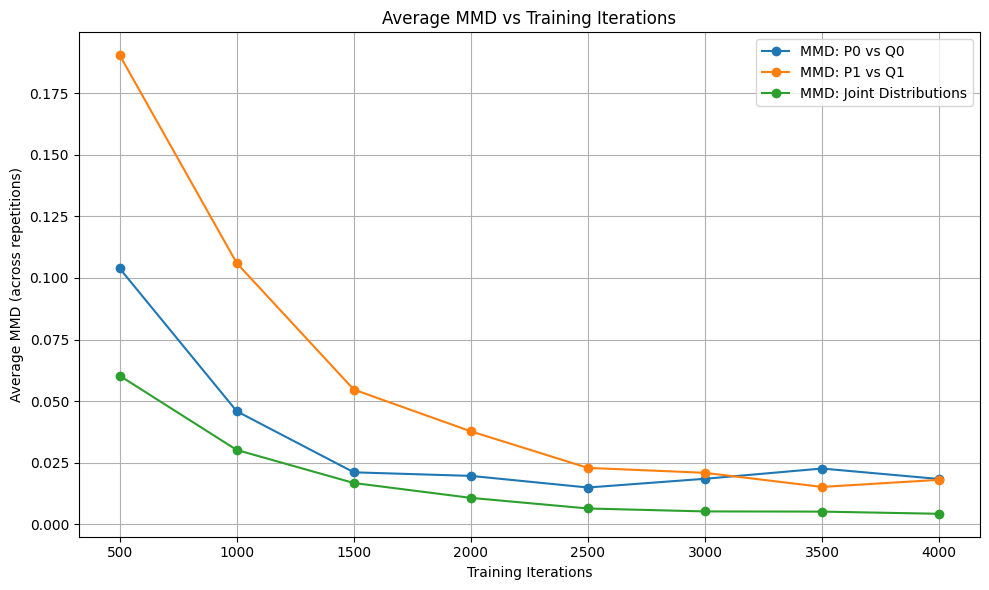

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# Compute average MMD across repetitions for each iteration
iterations = list(tracker.keys())

# Extract averages
avg_mmd_p0_q0 = [np.mean(tracker[iteration]["mmd_p0_q0"]) for iteration in iterations]
avg_mmd_p1_q1 = [np.mean(tracker[iteration]["mmd_p1_q1"]) for iteration in iterations]
avg_mmd_joint = [np.mean(tracker[iteration]["mmd_joint"]) for iteration in iterations]

# Plot the results
plt.figure(figsize=(10, 6))

# MMD P0 vs Q0
plt.plot(iterations, avg_mmd_p0_q0, marker='o', label='MMD: P0 vs Q0')

# MMD P1 vs Q1
plt.plot(iterations, avg_mmd_p1_q1, marker='o', label='MMD: P1 vs Q1')

# MMD Joint Distributions
plt.plot(iterations, avg_mmd_joint, marker='o', label='MMD: Joint Distributions')

# Customization
plt.title('Average MMD vs Training Iterations')
plt.xlabel('Training Iterations')
plt.ylabel('Average MMD (across repetitions)')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Show plot
plt.show()


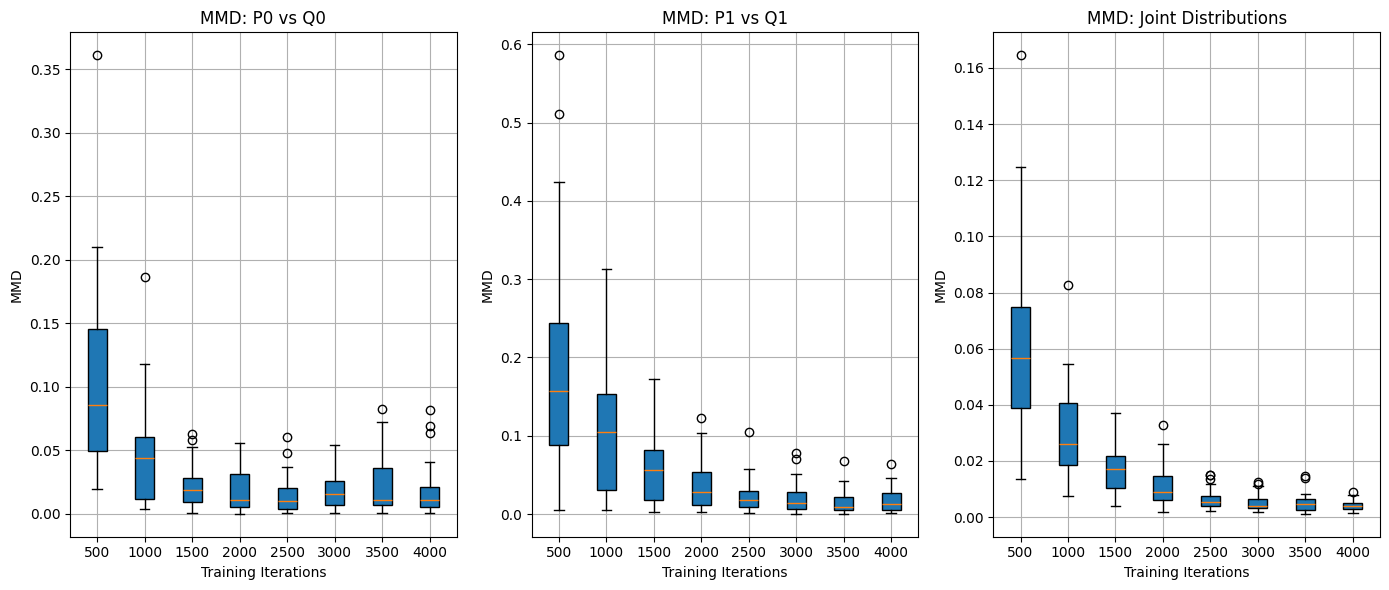

In [5]:
import matplotlib.pyplot as plt

# Extract MMD values for each iteration
iterations = list(tracker.keys())

mmd_p0_q0 = [tracker[iteration]["mmd_p0_q0"] for iteration in iterations]
mmd_p1_q1 = [tracker[iteration]["mmd_p1_q1"] for iteration in iterations]
mmd_joint = [tracker[iteration]["mmd_joint"] for iteration in iterations]

# Plot the boxplots
plt.figure(figsize=(14, 6))

# MMD P0 vs Q0
plt.subplot(1, 3, 1)
plt.boxplot(mmd_p0_q0, positions=iterations, widths=200, patch_artist=True)
plt.title('MMD: P0 vs Q0')
plt.xlabel('Training Iterations')
plt.ylabel('MMD')
plt.grid(True)

# MMD P1 vs Q1
plt.subplot(1, 3, 2)
plt.boxplot(mmd_p1_q1, positions=iterations, widths=200, patch_artist=True)
plt.title('MMD: P1 vs Q1')
plt.xlabel('Training Iterations')
plt.ylabel('MMD')
plt.grid(True)

# MMD Joint Distributions
plt.subplot(1, 3, 3)
plt.boxplot(mmd_joint, positions=iterations, widths=200, patch_artist=True)
plt.title('MMD: Joint Distributions')
plt.xlabel('Training Iterations')
plt.ylabel('MMD')
plt.grid(True)

plt.tight_layout()
plt.show()


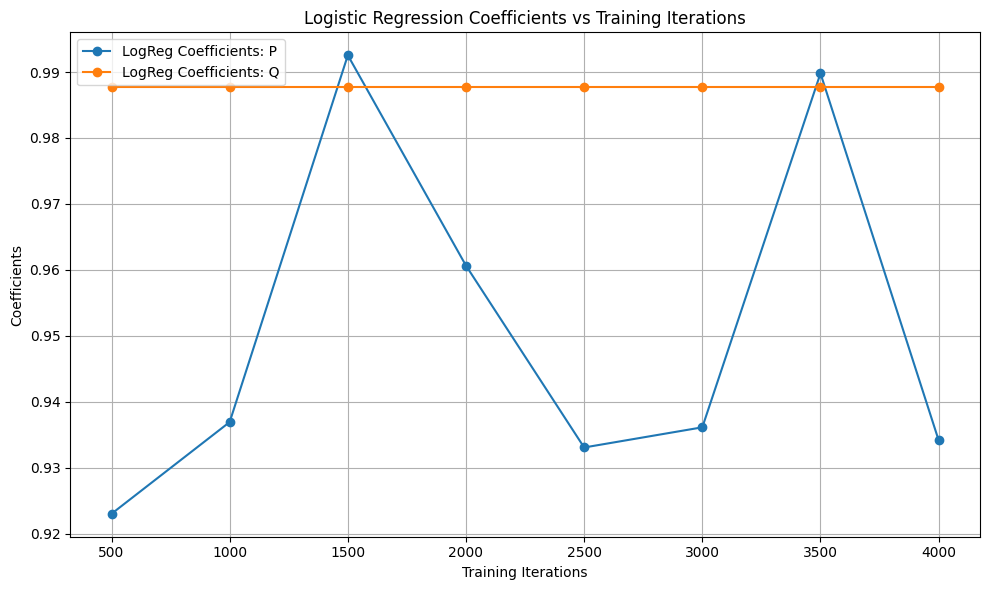

In [6]:
# Extract coefficients for each iteration
iterations = list(tracker.keys())
coeffs_p = [np.mean(tracker[iteration]["logreg_coeffs_p"], axis=0) for iteration in iterations]
coeffs_q = [np.mean(tracker[iteration]["logreg_coeffs_q"], axis=0) for iteration in iterations]

# Plot the coefficients
plt.figure(figsize=(10, 6))

# Logistic Regression Coefficients for P
plt.plot(iterations, np.squeeze(coeffs_p), marker='o', label='LogReg Coefficients: P')

# Logistic Regression Coefficients for Q
plt.plot(iterations, np.squeeze(coeffs_q), marker='o', label='LogReg Coefficients: Q')

# Customization
plt.title('Logistic Regression Coefficients vs Training Iterations')
plt.xlabel('Training Iterations')
plt.ylabel('Coefficients')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


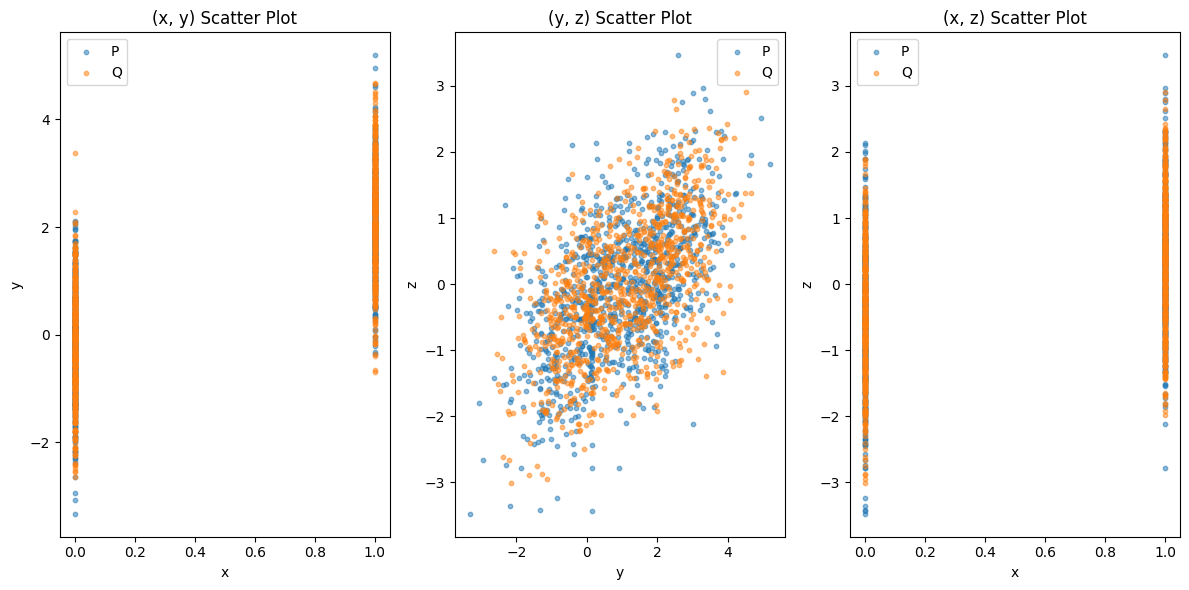

In [7]:
# Scatter plot for P and Q
plt.figure(figsize=(12, 6))

# (x, y) scatter for P and Q
plt.subplot(1, 3, 1)
plt.scatter(P_joint[:, 0], P_joint[:, 1], alpha=0.5, label='P', s=10)
plt.scatter(Q_joint[:, 0], Q_joint[:, 1], alpha=0.5, label='Q', s=10)
plt.title('(x, y) Scatter Plot')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()

# (y, z) scatter for P and Q
plt.subplot(1, 3, 2)
plt.scatter(P_joint[:, 1], P_joint[:, 2], alpha=0.5, label='P', s=10)
plt.scatter(Q_joint[:, 1], Q_joint[:, 2], alpha=0.5, label='Q', s=10)
plt.title('(y, z) Scatter Plot')
plt.xlabel('y')
plt.ylabel('z')
plt.legend()

# (x, z) scatter for P and Q
plt.subplot(1, 3, 3)
plt.scatter(P_joint[:, 0], P_joint[:, 2], alpha=0.5, label='P', s=10)
plt.scatter(Q_joint[:, 0], Q_joint[:, 2], alpha=0.5, label='Q', s=10)
plt.title('(x, z) Scatter Plot')
plt.xlabel('x')
plt.ylabel('z')
plt.legend()

plt.tight_layout()
plt.show()


/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before operating instead.
  with pd.option_context('mode.use_inf_as_na', True):
/opt/anaconda3/lib/python3.11/site-packages/seaborn/_oldcore.py:1119: FutureWarning: use_inf_as_na option is deprecated and will be removed in a future version. Convert inf values to NaN before opera

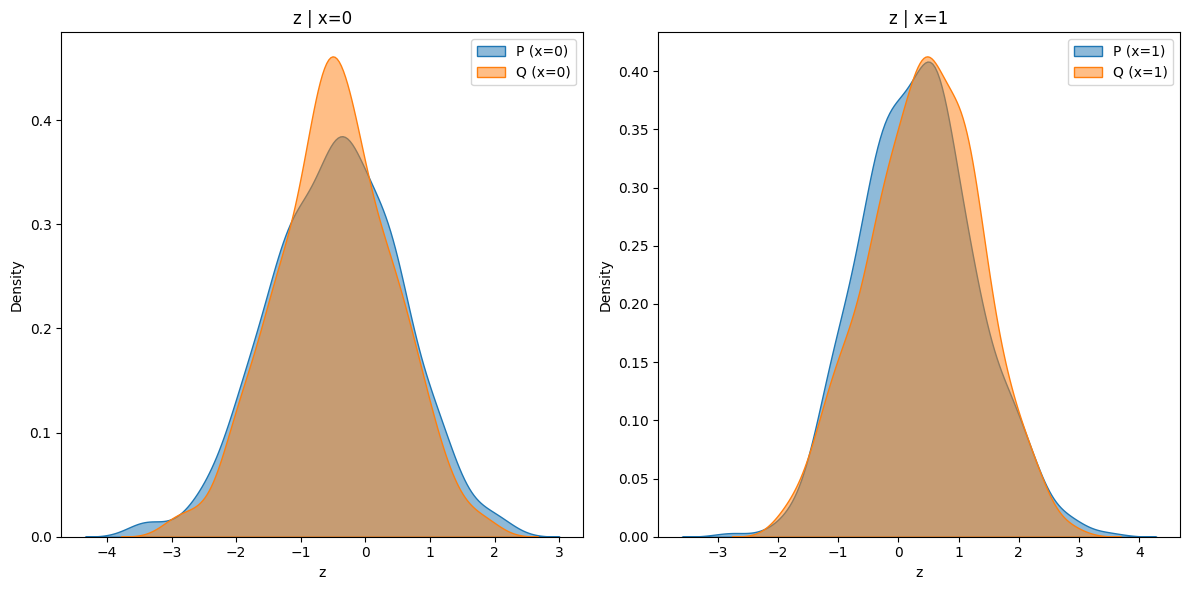

In [8]:
import seaborn as sns

# Separate z for x=0 and x=1
z_p_given_x0 = P_joint[P_joint[:, 0] == 0][:, 2]
z_p_given_x1 = P_joint[P_joint[:, 0] == 1][:, 2]
z_q_given_x0 = Q_joint[Q_joint[:, 0] == 0][:, 2]
z_q_given_x1 = Q_joint[Q_joint[:, 0] == 1][:, 2]

# KDE plots for z | x
plt.figure(figsize=(12, 6))

# z | x=0
plt.subplot(1, 2, 1)
sns.kdeplot(z_p_given_x0, label='P (x=0)', fill=True, alpha=0.5)
sns.kdeplot(z_q_given_x0, label='Q (x=0)', fill=True, alpha=0.5)
plt.title('z | x=0')
plt.xlabel('z')
plt.ylabel('Density')
plt.legend()

# z | x=1
plt.subplot(1, 2, 2)
sns.kdeplot(z_p_given_x1, label='P (x=1)', fill=True, alpha=0.5)
sns.kdeplot(z_q_given_x1, label='Q (x=1)', fill=True, alpha=0.5)
plt.title('z | x=1')
plt.xlabel('z')
plt.ylabel('Density')
plt.legend()

plt.tight_layout()
plt.show()

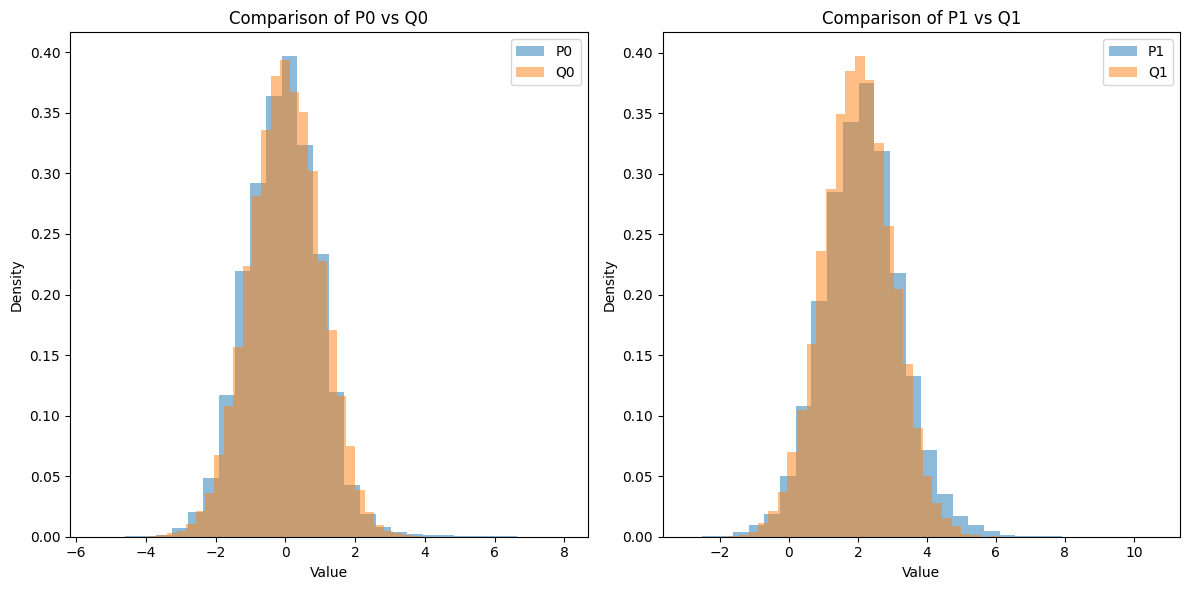

In [9]:
# Create histograms with overlapping bars
plt.figure(figsize=(12, 6))

# Plot P0 vs Q0
plt.subplot(1, 2, 1)
plt.hist(P0s.reshape(-1), bins=30, alpha=0.5, label='P0', density=True)
plt.hist(Q0s.reshape(-1), bins=30, alpha=0.5, label='Q0', density=True)
plt.title('Comparison of P0 vs Q0')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()

# Plot P1 vs Q1
plt.subplot(1, 2, 2)
plt.hist(P1s.reshape(-1), bins=30, alpha=0.5, label='P1', density=True)
plt.hist(Q1s.reshape(-1), bins=30, alpha=0.5, label='Q1', density=True)
plt.title('Comparison of P1 vs Q1')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()

# Show plots
plt.tight_layout()
plt.show()

#### Introducing other variables

In [2]:
nrep = 30 # for equivalence testing
n_tr = 1000
n_p = 1000
# Initialize an empty list to store each Q_single
nI = 1
nX = 1
nO = 1
nS= 1
p = nI+nX+nO+nS
binary_intervention=True

# Initialize an empty list to store each Q_single
P0_list = []
Q0_list = []

P1_list = []
Q1_list = []

P_joint_list = []
Q_joint_list = []

tracker = {iteration: {"mmd_p0_q0": [], "mmd_p1_q1": [], "mmd_joint": [], "logreg_coeffs_p": [], "logreg_coeffs_q": []}
           for iteration in [500, 1000, 1500, 2000, 2500, 3000, 3500, 4000]}

# Begin experiment
for rep in tqdm(range(nrep)):
    # Generate data
    df_tr = generate_data_causl(n=n_tr, nI=nI, nX=nX, nO=nO, nS=nS, ate=ate, 
                                beta_cov=beta_cov, strength_instr=strength_instr, 
                                strength_conf=strength_conf, 
                                strength_outcome=strength_outcome, 
                                binary_intervention=binary_intervention)
    z_tr = torch.tensor(df_tr[[f"X{i}" for i in range(1, p + 1)]].values, dtype=torch.float32)
    x_tr = torch.tensor(df_tr['A'].values, dtype=torch.int32).view(-1, 1) if binary_intervention else \
           torch.tensor(df_tr['A'].values, dtype=torch.float32).view(-1, 1)
    y_tr = torch.tensor(df_tr['y'].values, dtype=torch.float32).view(-1, 1)

    model = Frengression(x_tr.shape[1], y_tr.shape[1], z_tr.shape[1], 
                         noise_dim=1, num_layer=3, hidden_dim=400, 
                         device=device, x_binary=binary_intervention)
    
    df_q = generate_data_causl(n=n_p, nI=nI, nX=nX, nO=nO, nS=nS, ate=ate, 
                                beta_cov=beta_cov, strength_instr=strength_instr, 
                                strength_conf=strength_conf, 
                                strength_outcome=strength_outcome, 
                                binary_intervention=binary_intervention)
    
    z_q = torch.tensor(df_q[[f"X{i}" for i in range(1, p + 1)]].values, dtype=torch.float32)
    x_q = torch.tensor(df_q['A'].values, dtype=torch.int32).view(-1, 1) if binary_intervention else \
           torch.tensor(df_q['A'].values, dtype=torch.float32).view(-1, 1)
    y_q = torch.tensor(df_q['y'].values, dtype=torch.float32).view(-1, 1)


    # Sample Q distributions
    Q0 = np.random.normal(loc=0, scale=1, size=n_p).reshape([n_p, 1])
    Q1 = np.random.normal(loc=ate, scale=1, size=n_p).reshape([n_p, 1])
    Q_joint = torch.cat([x_q, y_q, z_q],dim=1).numpy()  # Ground truth joint distribution (x, y, z)

    Q0_list.append(Q0)
    Q1_list.append(Q1)
    Q_joint_list.append(Q_joint)

    last_iteration = 0
    for iteration in tracker.keys():
        additional_iters = iteration - last_iteration
        last_iteration = iteration
        # Train model
        model.train_xz(x_tr, z_tr, num_iters=additional_iters, lr=1e-4, print_every_iter=100)
        model.train_y(x_tr, z_tr, y_tr, num_iters=additional_iters, lr=1e-4, print_every_iter=100)

        # Sample P distributions
        P0 = (model.sample_causal_margin(torch.tensor([0], dtype=torch.int32), sample_size=n_p)).numpy().reshape(-1, 1)
        P1 = (model.sample_causal_margin(torch.tensor([1], dtype=torch.int32), sample_size=n_p)).numpy().reshape(-1, 1)
        x_gen, y_gen, z_gen = model.sample_joint(sample_size=n_p)  # Sample joint distribution (x, y, z)
        P_joint = torch.cat([x_gen, y_gen, z_gen], dim=1).numpy()

        # Calculate MMD
        mmd_p0_q0 = mmd_rbf(P0, Q0, sigma=1.0)
        mmd_p1_q1 = mmd_rbf(P1, Q1, sigma=1.0)
        mmd_joint = mmd_rbf(P_joint, Q_joint, sigma=1.0)

        logistic_model_p = LogisticRegression()
        logistic_model_p.fit(z_gen.numpy(), x_gen.numpy().ravel())
        logreg_coeffs_p = logistic_model_p.coef_

        # Logistic regression for Q (x_q, z_q from ground truth)
        logistic_model_q = LogisticRegression()
        logistic_model_q.fit(z_q.numpy(), x_q.numpy().ravel())
        logreg_coeffs_q = logistic_model_q.coef_

        # Log results
        tracker[iteration]["mmd_p0_q0"].append(mmd_p0_q0)
        tracker[iteration]["mmd_p1_q1"].append(mmd_p1_q1)
        tracker[iteration]["mmd_joint"].append(mmd_joint)
        tracker[iteration]["logreg_coeffs_p"].append(logreg_coeffs_p)
        tracker[iteration]["logreg_coeffs_q"].append(logreg_coeffs_q)
    P0_list.append(P0)
    P1_list.append(P1)
    P_joint_list.append(P_joint)

P0s = np.stack(P0_list, axis=0) #[nrep, n, 1]
Q0s = np.stack(Q0_list, axis=0)
P1s = np.stack(P1_list, axis=0)
Q1s = np.stack(Q1_list, axis=0)
PJoints = np.stack(P_joint_list, axis=0)
QJoints = np.stack(Q_joint_list, axis=0)


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1: loss 1.9131, loss1 1.9998, loss2 0.1733
Epoch 100: loss 1.4082, loss1 2.8065, loss2 2.7966
Epoch 200: loss 1.4461, loss1 2.8389, loss2 2.7857
Epoch 300: loss 1.4392, loss1 2.8067, loss2 2.7349
Epoch 400: loss 1.3985, loss1 2.8011, loss2 2.8051
Epoch 500: loss 1.3883, loss1 2.8017, loss2 2.8269
Epoch 1: loss 2.1350,	loss_y 1.4306, 1.4454, 0.0296,	loss_eta 0.7044, 0.7472, 0.0855
Epoch 100: loss 1.6243,	loss_y 0.6472, 1.1893, 1.0842,	loss_eta 0.9771, 1.8117, 1.6693
Epoch 200: loss 2.1371,	loss_y 1.4552, 2.5660, 2.2215,	loss_eta 0.6819, 0.8512, 0.3386
Epoch 300: loss 1.7509,	loss_y 0.9510, 1.6531, 1.4043,	loss_eta 0.7999, 1.0536, 0.5075
Epoch 400: loss 1.4767,	loss_y 0.7631, 1.5494, 1.5726,	loss_eta 0.7136, 0.8253, 0.2236


  0%|          | 0/30 [00:11<?, ?it/s]

Epoch 500: loss 1.2985,	loss_y 0.6923, 1.7318, 2.0790,	loss_eta 0.6062, 0.9616, 0.7108


NameError: name 'mmd_rbf' is not defined

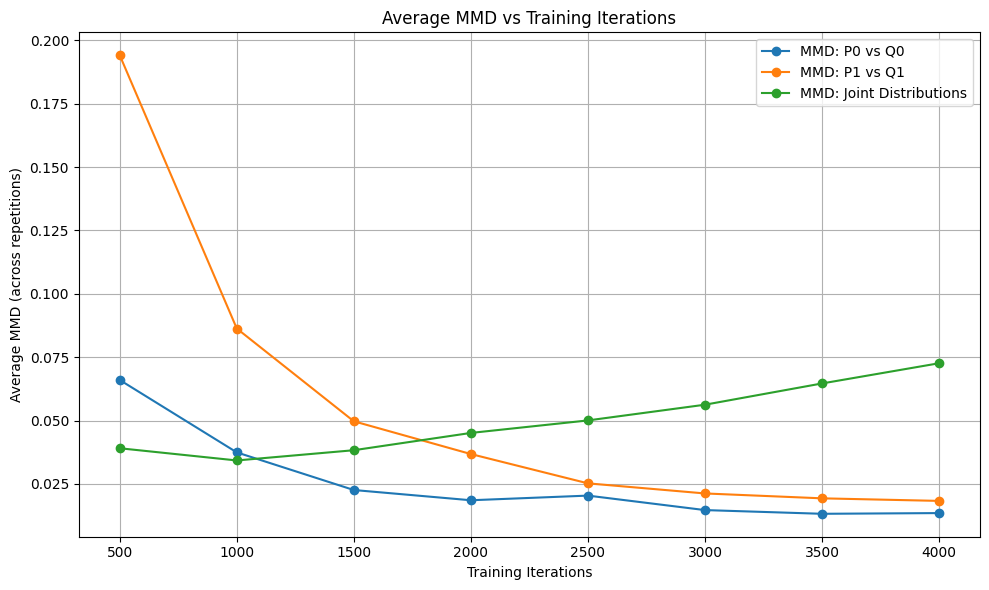

In [21]:
import matplotlib.pyplot as plt
import numpy as np

# Compute average MMD across repetitions for each iteration
iterations = list(tracker.keys())

# Extract averages
avg_mmd_p0_q0 = [np.mean(tracker[iteration]["mmd_p0_q0"]) for iteration in iterations]
avg_mmd_p1_q1 = [np.mean(tracker[iteration]["mmd_p1_q1"]) for iteration in iterations]
avg_mmd_joint = [np.mean(tracker[iteration]["mmd_joint"]) for iteration in iterations]

# Plot the results
plt.figure(figsize=(10, 6))

# MMD P0 vs Q0
plt.plot(iterations, avg_mmd_p0_q0, marker='o', label='MMD: P0 vs Q0')

# MMD P1 vs Q1
plt.plot(iterations, avg_mmd_p1_q1, marker='o', label='MMD: P1 vs Q1')

# MMD Joint Distributions
plt.plot(iterations, avg_mmd_joint, marker='o', label='MMD: Joint Distributions')

# Customization
plt.title('Average MMD vs Training Iterations')
plt.xlabel('Training Iterations')
plt.ylabel('Average MMD (across repetitions)')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Show plot
plt.show()


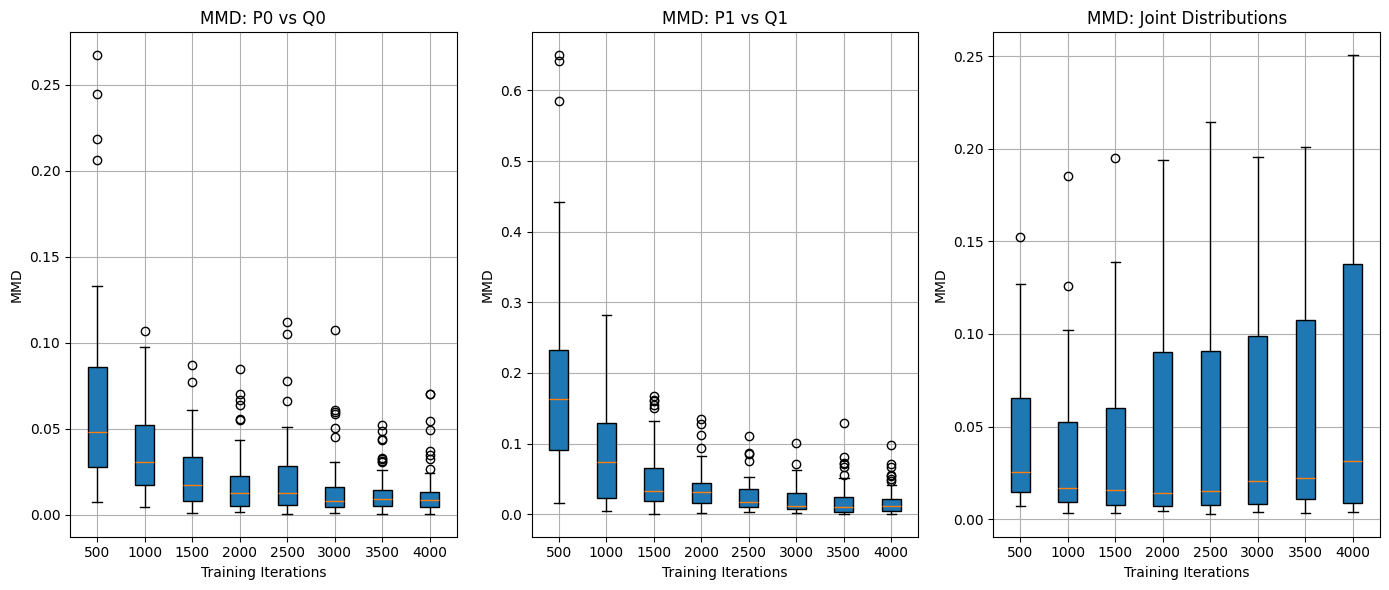

In [22]:
import matplotlib.pyplot as plt

# Extract MMD values for each iteration
iterations = list(tracker.keys())

mmd_p0_q0 = [tracker[iteration]["mmd_p0_q0"] for iteration in iterations]
mmd_p1_q1 = [tracker[iteration]["mmd_p1_q1"] for iteration in iterations]
mmd_joint = [tracker[iteration]["mmd_joint"] for iteration in iterations]

# Plot the boxplots
plt.figure(figsize=(14, 6))

# MMD P0 vs Q0
plt.subplot(1, 3, 1)
plt.boxplot(mmd_p0_q0, positions=iterations, widths=200, patch_artist=True)
plt.title('MMD: P0 vs Q0')
plt.xlabel('Training Iterations')
plt.ylabel('MMD')
plt.grid(True)

# MMD P1 vs Q1
plt.subplot(1, 3, 2)
plt.boxplot(mmd_p1_q1, positions=iterations, widths=200, patch_artist=True)
plt.title('MMD: P1 vs Q1')
plt.xlabel('Training Iterations')
plt.ylabel('MMD')
plt.grid(True)

# MMD Joint Distributions
plt.subplot(1, 3, 3)
plt.boxplot(mmd_joint, positions=iterations, widths=200, patch_artist=True)
plt.title('MMD: Joint Distributions')
plt.xlabel('Training Iterations')
plt.ylabel('MMD')
plt.grid(True)

plt.tight_layout()
plt.show()


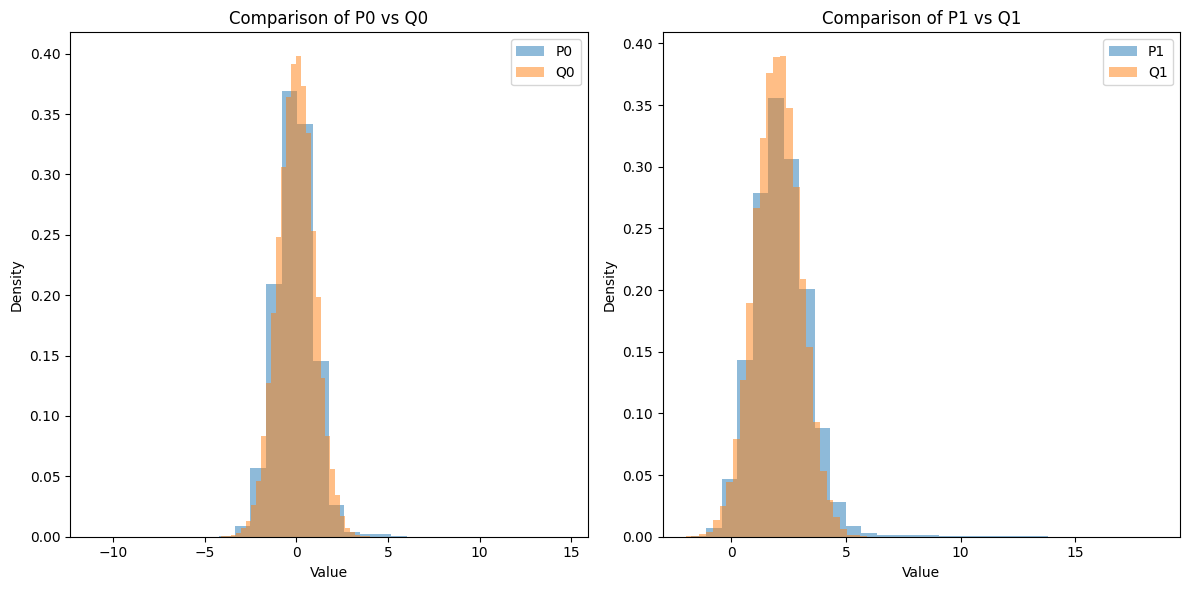

In [25]:
# Create histograms with overlapping bars
plt.figure(figsize=(12, 6))

# Plot P0 vs Q0
plt.subplot(1, 2, 1)
plt.hist(P0s.reshape(-1), bins=30, alpha=0.5, label='P0', density=True)
plt.hist(Q0s.reshape(-1), bins=30, alpha=0.5, label='Q0', density=True)
plt.title('Comparison of P0 vs Q0')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()

# Plot P1 vs Q1
plt.subplot(1, 2, 2)
plt.hist(P1s.reshape(-1), bins=30, alpha=0.5, label='P1', density=True)
plt.hist(Q1s.reshape(-1), bins=30, alpha=0.5, label='Q1', density=True)
plt.title('Comparison of P1 vs Q1')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()

# Show plots
plt.tight_layout()
plt.show()

## Continuous treatment

In [13]:
from sklearn.linear_model import LogisticRegression, LinearRegression
from sklearn.metrics import log_loss
from scipy.spatial.distance import pdist, squareform

# Define the tracker
tracker = {iteration: {"mmd_joint": [], "lr_coeffs_p": [], "lr_coeffs_q": []}
           for iteration in [500, 1000, 1500, 2000, 2500, 3000, 3500, 4000]}
# Helper function for MMD
def mmd_rbf(x, y, sigma=1.0):
    """Compute MMD between two distributions using RBF kernel."""
    pairwise_sq_dists = squareform(pdist(np.vstack([x, y]), 'sqeuclidean'))
    K = np.exp(-pairwise_sq_dists / (2 * sigma ** 2))
    K_xx = K[:len(x), :len(x)]
    K_xy = K[:len(x), len(x):]
    K_yy = K[len(x):, len(x):]
    mmd = np.mean(K_xx) - 2 * np.mean(K_xy) + np.mean(K_yy)
    return mmd

In [7]:
nrep = 30 # for equivalence testing
n_tr = 1000
n_p = 1000
# Initialize an empty list to store each Q_single
nI = 0
nX = 1
nO = 0
nS= 0
p = nI+nX+nO+nS
binary_intervention=False

# Initialize an empty list to store each Q_single
# P0_list = []
# Q0_list = []

# P1_list = []
# Q1_list = []

P_joint_list = []
Q_joint_list = []

# Begin experiment
for rep in tqdm(range(nrep)):
    # Generate data
    df_tr = generate_data_causl(n=n_tr, nI=nI, nX=nX, nO=nO, nS=nS, ate=ate, 
                                beta_cov=beta_cov, strength_instr=strength_instr, 
                                strength_conf=strength_conf, 
                                strength_outcome=strength_outcome, 
                                binary_intervention=binary_intervention)
    z_tr = torch.tensor(df_tr[[f"X{i}" for i in range(1, p + 1)]].values, dtype=torch.float32)
    x_tr = torch.tensor(df_tr['A'].values, dtype=torch.int32).view(-1, 1) if binary_intervention else \
           torch.tensor(df_tr['A'].values, dtype=torch.float32).view(-1, 1)
    y_tr = torch.tensor(df_tr['y'].values, dtype=torch.float32).view(-1, 1)

    model = Frengression(x_tr.shape[1], y_tr.shape[1], z_tr.shape[1], 
                         noise_dim=1, num_layer=3, hidden_dim=400, 
                         device=device, x_binary=binary_intervention)
    
    df_q = generate_data_causl(n=n_p, nI=nI, nX=nX, nO=nO, nS=nS, ate=ate, 
                                beta_cov=beta_cov, strength_instr=strength_instr, 
                                strength_conf=strength_conf, 
                                strength_outcome=strength_outcome, 
                                binary_intervention=binary_intervention)
    
    z_q = torch.tensor(df_q[[f"X{i}" for i in range(1, p + 1)]].values, dtype=torch.float32)
    x_q = torch.tensor(df_q['A'].values, dtype=torch.int32).view(-1, 1) if binary_intervention else \
           torch.tensor(df_q['A'].values, dtype=torch.float32).view(-1, 1)
    y_q = torch.tensor(df_q['y'].values, dtype=torch.float32).view(-1, 1)


    # Sample Q distributions
    # Q0 = np.random.normal(loc=0, scale=1, size=n_p).reshape([n_p, 1])
    # Q1 = np.random.normal(loc=ate, scale=1, size=n_p).reshape([n_p, 1])
    Q_joint = torch.cat([x_q, y_q, z_q],dim=1).numpy()  # Ground truth joint distribution (x, y, z)

    # Q0_list.append(Q0)
    # Q1_list.append(Q1)
    Q_joint_list.append(Q_joint)

    last_iteration = 0
    for iteration in tracker.keys():
        additional_iters = iteration - last_iteration
        last_iteration = iteration
        # Train model
        model.train_xz(x_tr, z_tr, num_iters=additional_iters, lr=1e-4, print_every_iter=100)
        model.train_y(x_tr, z_tr, y_tr, num_iters=additional_iters, lr=1e-4, print_every_iter=100)

        # Sample P distributions
        # P0 = (model.sample_causal_margin(torch.tensor([0], dtype=torch.int32), sample_size=n_p)).numpy().reshape(-1, 1)
        # P1 = (model.sample_causal_margin(torch.tensor([1], dtype=torch.int32), sample_size=n_p)).numpy().reshape(-1, 1)
        x_gen, y_gen, z_gen = model.sample_joint(sample_size=n_p)  # Sample joint distribution (x, y, z)
        P_joint = torch.cat([x_gen, y_gen, z_gen], dim=1).numpy()

        # Calculate MMD
        # mmd_p0_q0 = mmd_rbf(P0, Q0, sigma=1.0)
        # mmd_p1_q1 = mmd_rbf(P1, Q1, sigma=1.0)
        mmd_joint = mmd_rbf(P_joint, Q_joint, sigma=1.0)

        lr_p = LinearRegression()
        lr_p.fit(z_gen.numpy(), x_gen.numpy().ravel())
        lr_coeffs_p = lr_p.coef_

        # Logistic regression for Q (x_q, z_q from ground truth)
        lr_q = LinearRegression()
        lr_q.fit(z_q.numpy(), x_q.numpy().ravel())
        lr_coeffs_q = lr_q.coef_

        # Log results
        # tracker[iteration]["mmd_p0_q0"].append(mmd_p0_q0)
        # tracker[iteration]["mmd_p1_q1"].append(mmd_p1_q1)
        tracker[iteration]["mmd_joint"].append(mmd_joint)
        tracker[iteration]["lr_coeffs_p"].append(lr_coeffs_p)
        tracker[iteration]["lr_coeffs_q"].append(lr_coeffs_q)
    # P0_list.append(P0)
    # P1_list.append(P1)
    P_joint_list.append(P_joint)

# P0s = np.stack(P0_list, axis=0) #[nrep, n, 1]
# Q0s = np.stack(Q0_list, axis=0)
# P1s = np.stack(P1_list, axis=0)
# Q1s = np.stack(Q1_list, axis=0)
PJoints = np.stack(P_joint_list, axis=0)
QJoints = np.stack(Q_joint_list, axis=0)


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1: loss 1.3826, loss1 1.4692, loss2 0.1732
Epoch 100: loss 1.0145, loss1 2.0409, loss2 2.0529
Epoch 200: loss 1.0721, loss1 2.0924, loss2 2.0406
Epoch 300: loss 1.0307, loss1 2.0575, loss2 2.0536
Epoch 400: loss 1.0778, loss1 2.0972, loss2 2.0388
Epoch 500: loss 1.0436, loss1 2.0457, loss2 2.0042
Epoch 1: loss 3.4692,	loss_y 2.6908, 2.7030, 0.0244,	loss_eta 0.7784, 0.8065, 0.0561
Epoch 100: loss 1.2012,	loss_y 0.5946, 1.5316, 1.8739,	loss_eta 0.6066, 0.8519, 0.4906
Epoch 200: loss 1.2144,	loss_y 0.5959, 1.1855, 1.1793,	loss_eta 0.6185, 1.2439, 1.2507
Epoch 300: loss 1.9166,	loss_y 1.3521, 1.8430, 0.9819,	loss_eta 0.5645, 1.2236, 1.3183
Epoch 400: loss 2.1682,	loss_y 1.4763, 2.3322, 1.7117,	loss_eta 0.6919, 1.1103, 0.8368
Epoch 500: loss 2.0258,	loss_y 1.3534, 2.4609, 2.2150,	loss_eta 0.6723, 0.9191, 0.4937
Epoch 1: loss 1.0582, loss1 2.0649, loss2 2.0135
Epoch 100: loss 1.0736, loss1 2.0694, loss2 1.9917
Epoch 200: loss 1.0392, loss1 2.0477, loss2 2.0170
Epoch 300: loss 1.0370, l

  3%|▎         | 1/30 [01:19<38:23, 79.43s/it]

Epoch 500: loss 1.1029,	loss_y 0.5346, 1.0829, 1.0965,	loss_eta 0.5683, 1.1692, 1.2018
Epoch 1: loss 1.4417, loss1 1.4779, loss2 0.0725
Epoch 100: loss 1.0070, loss1 2.0445, loss2 2.0749
Epoch 200: loss 0.9986, loss1 2.0317, loss2 2.0662
Epoch 300: loss 1.0466, loss1 2.0644, loss2 2.0356
Epoch 400: loss 1.0494, loss1 2.0654, loss2 2.0320
Epoch 500: loss 1.0548, loss1 2.0644, loss2 2.0190
Epoch 1: loss 3.2904,	loss_y 2.5092, 2.5383, 0.0582,	loss_eta 0.7812, 0.8291, 0.0959
Epoch 100: loss 1.1874,	loss_y 0.5732, 1.5477, 1.9490,	loss_eta 0.6142, 0.9438, 0.6591
Epoch 200: loss 1.2000,	loss_y 0.6339, 1.1965, 1.1253,	loss_eta 0.5661, 1.1939, 1.2555
Epoch 300: loss 1.6169,	loss_y 0.8905, 1.3217, 0.8626,	loss_eta 0.7265, 0.8655, 0.2781
Epoch 400: loss 1.6000,	loss_y 0.9890, 1.7586, 1.5392,	loss_eta 0.6110, 1.1335, 1.0450
Epoch 500: loss 1.8798,	loss_y 1.2987, 2.7464, 2.8955,	loss_eta 0.5811, 1.2593, 1.3564
Epoch 1: loss 1.0772, loss1 2.1017, loss2 2.0491
Epoch 100: loss 1.0672, loss1 2.0761, lo

  7%|▋         | 2/30 [02:24<33:13, 71.18s/it]

Epoch 500: loss 1.0751,	loss_y 0.5242, 1.0191, 0.9897,	loss_eta 0.5509, 1.1069, 1.1122
Epoch 1: loss 1.4363, loss1 1.5007, loss2 0.1288
Epoch 100: loss 1.0359, loss1 2.0654, loss2 2.0591
Epoch 200: loss 1.0553, loss1 2.0789, loss2 2.0473
Epoch 300: loss 1.1015, loss1 2.1173, loss2 2.0315
Epoch 400: loss 1.0389, loss1 2.0550, loss2 2.0323
Epoch 500: loss 1.0457, loss1 2.0959, loss2 2.1005
Epoch 1: loss 3.3509,	loss_y 2.6160, 2.6443, 0.0565,	loss_eta 0.7349, 0.7785, 0.0871
Epoch 100: loss 1.1942,	loss_y 0.6495, 1.7276, 2.1562,	loss_eta 0.5447, 1.1444, 1.1993
Epoch 200: loss 1.1202,	loss_y 0.5490, 1.1889, 1.2799,	loss_eta 0.5712, 1.1240, 1.1056
Epoch 300: loss 1.4738,	loss_y 0.8599, 1.2019, 0.6841,	loss_eta 0.6139, 1.3386, 1.4494
Epoch 400: loss 1.9586,	loss_y 1.2831, 2.0634, 1.5606,	loss_eta 0.6755, 1.0285, 0.7060
Epoch 500: loss 1.9893,	loss_y 1.3842, 2.7513, 2.7341,	loss_eta 0.6051, 1.0725, 0.9348
Epoch 1: loss 1.0369, loss1 2.0858, loss2 2.0979
Epoch 100: loss 1.0318, loss1 2.0738, lo

 10%|█         | 3/30 [03:32<31:16, 69.50s/it]

Epoch 500: loss 1.1308,	loss_y 0.5386, 1.0655, 1.0538,	loss_eta 0.5922, 1.1000, 1.0157
Epoch 1: loss 1.3922, loss1 1.4396, loss2 0.0948
Epoch 100: loss 0.9786, loss1 1.9822, loss2 2.0072
Epoch 200: loss 0.9979, loss1 2.0323, loss2 2.0688
Epoch 300: loss 1.0465, loss1 2.0566, loss2 2.0202
Epoch 400: loss 1.0365, loss1 2.0758, loss2 2.0785
Epoch 500: loss 0.9704, loss1 2.0099, loss2 2.0790
Epoch 1: loss 3.3055,	loss_y 2.5619, 2.5750, 0.0262,	loss_eta 0.7437, 0.8008, 0.1142
Epoch 100: loss 1.3182,	loss_y 0.6846, 1.6139, 1.8587,	loss_eta 0.6337, 0.8038, 0.3402
Epoch 200: loss 1.1777,	loss_y 0.5889, 1.1482, 1.1186,	loss_eta 0.5888, 1.0417, 0.9058
Epoch 300: loss 1.5310,	loss_y 0.8715, 1.3990, 1.0551,	loss_eta 0.6595, 1.4662, 1.6134
Epoch 400: loss 1.9056,	loss_y 1.1983, 1.9784, 1.5602,	loss_eta 0.7073, 1.0861, 0.7576
Epoch 500: loss 2.1134,	loss_y 1.4731, 2.6199, 2.2936,	loss_eta 0.6403, 0.8256, 0.3706
Epoch 1: loss 1.0136, loss1 2.0265, loss2 2.0260
Epoch 100: loss 1.0299, loss1 2.0631, lo

 13%|█▎        | 4/30 [04:38<29:35, 68.27s/it]

Epoch 500: loss 1.1270,	loss_y 0.5394, 1.0284, 0.9781,	loss_eta 0.5876, 1.1419, 1.1085
Epoch 1: loss 1.4132, loss1 1.4787, loss2 0.1309
Epoch 100: loss 1.0194, loss1 2.0617, loss2 2.0845
Epoch 200: loss 1.0242, loss1 2.0442, loss2 2.0400
Epoch 300: loss 1.0325, loss1 2.0943, loss2 2.1238
Epoch 400: loss 1.0047, loss1 2.0751, loss2 2.1408
Epoch 500: loss 1.0525, loss1 2.0717, loss2 2.0384
Epoch 1: loss 3.3557,	loss_y 2.6212, 2.6375, 0.0326,	loss_eta 0.7345, 0.7935, 0.1180
Epoch 100: loss 1.2541,	loss_y 0.6792, 1.4958, 1.6331,	loss_eta 0.5749, 1.1387, 1.1277
Epoch 200: loss 1.2898,	loss_y 0.6815, 1.4512, 1.5395,	loss_eta 0.6083, 0.8644, 0.5121
Epoch 300: loss 1.7454,	loss_y 1.1171, 1.5644, 0.8946,	loss_eta 0.6284, 1.4546, 1.6525
Epoch 400: loss 1.7798,	loss_y 1.1216, 1.8681, 1.4929,	loss_eta 0.6582, 0.9063, 0.4962
Epoch 500: loss 1.9535,	loss_y 1.2718, 2.7066, 2.8696,	loss_eta 0.6817, 0.9853, 0.6071
Epoch 1: loss 1.0284, loss1 2.0621, loss2 2.0674
Epoch 100: loss 0.9959, loss1 2.0155, lo

 17%|█▋        | 5/30 [05:46<28:20, 68.02s/it]

Epoch 500: loss 1.1756,	loss_y 0.5966, 0.9870, 0.7807,	loss_eta 0.5790, 1.0725, 0.9870
Epoch 1: loss 1.3845, loss1 1.4343, loss2 0.0996
Epoch 100: loss 0.9968, loss1 1.9973, loss2 2.0011
Epoch 200: loss 1.0098, loss1 2.0354, loss2 2.0512
Epoch 300: loss 0.9890, loss1 1.9995, loss2 2.0210
Epoch 400: loss 1.0069, loss1 1.9993, loss2 1.9848
Epoch 500: loss 0.9647, loss1 1.9489, loss2 1.9686
Epoch 1: loss 3.3126,	loss_y 2.5698, 2.5881, 0.0366,	loss_eta 0.7428, 0.7736, 0.0617
Epoch 100: loss 1.1461,	loss_y 0.5356, 1.1841, 1.2970,	loss_eta 0.6106, 1.0380, 0.8550
Epoch 200: loss 1.1323,	loss_y 0.5638, 1.0915, 1.0555,	loss_eta 0.5685, 1.0424, 0.9478
Epoch 300: loss 1.4656,	loss_y 0.8230, 1.2396, 0.8332,	loss_eta 0.6426, 0.9059, 0.5266
Epoch 400: loss 2.0438,	loss_y 1.4927, 2.2864, 1.5873,	loss_eta 0.5511, 1.3311, 1.5601
Epoch 500: loss 1.9710,	loss_y 1.2161, 2.6634, 2.8946,	loss_eta 0.7549, 1.5191, 1.5282
Epoch 1: loss 1.0033, loss1 2.0183, loss2 2.0300
Epoch 100: loss 0.9774, loss1 1.9785, lo

 20%|██        | 6/30 [06:50<26:44, 66.87s/it]

Epoch 500: loss 1.0523,	loss_y 0.5022, 0.9482, 0.8920,	loss_eta 0.5500, 1.1630, 1.2258
Epoch 1: loss 1.4385, loss1 1.5347, loss2 0.1923
Epoch 100: loss 1.0729, loss1 2.0817, loss2 2.0175
Epoch 200: loss 1.0539, loss1 2.0977, loss2 2.0876
Epoch 300: loss 1.0694, loss1 2.1015, loss2 2.0642
Epoch 400: loss 1.0711, loss1 2.0908, loss2 2.0394
Epoch 500: loss 1.0640, loss1 2.1413, loss2 2.1547
Epoch 1: loss 3.5063,	loss_y 2.7429, 2.7629, 0.0400,	loss_eta 0.7634, 0.8002, 0.0736
Epoch 100: loss 1.1653,	loss_y 0.6048, 1.3683, 1.5271,	loss_eta 0.5605, 1.0459, 0.9708
Epoch 200: loss 1.2843,	loss_y 0.7590, 1.3040, 1.0900,	loss_eta 0.5253, 0.9350, 0.8195
Epoch 300: loss 1.4606,	loss_y 0.8722, 1.5035, 1.2625,	loss_eta 0.5884, 1.2976, 1.4184
Epoch 400: loss 1.5445,	loss_y 0.8240, 1.5307, 1.4133,	loss_eta 0.7205, 0.8945, 0.3482
Epoch 500: loss 2.1836,	loss_y 1.3676, 2.9220, 3.1088,	loss_eta 0.8160, 1.3365, 1.0410
Epoch 1: loss 1.0922, loss1 2.0866, loss2 1.9888
Epoch 100: loss 1.0046, loss1 2.0508, lo

 23%|██▎       | 7/30 [07:55<25:19, 66.04s/it]

Epoch 500: loss 1.1211,	loss_y 0.5532, 1.0437, 0.9811,	loss_eta 0.5680, 1.0722, 1.0085
Epoch 1: loss 1.4255, loss1 1.4662, loss2 0.0815
Epoch 100: loss 1.0152, loss1 2.0304, loss2 2.0304
Epoch 200: loss 1.0383, loss1 2.0537, loss2 2.0306
Epoch 300: loss 1.0155, loss1 2.0446, loss2 2.0581
Epoch 400: loss 1.0312, loss1 2.0910, loss2 2.1195
Epoch 500: loss 1.0338, loss1 2.0496, loss2 2.0317
Epoch 1: loss 3.2833,	loss_y 2.5453, 2.5776, 0.0646,	loss_eta 0.7381, 0.7954, 0.1146
Epoch 100: loss 1.3794,	loss_y 0.6448, 1.6883, 2.0869,	loss_eta 0.7346, 0.8524, 0.2357
Epoch 200: loss 1.3789,	loss_y 0.7655, 1.3056, 1.0802,	loss_eta 0.6134, 1.1454, 1.0640
Epoch 300: loss 1.4150,	loss_y 0.8565, 1.4354, 1.1577,	loss_eta 0.5586, 1.1778, 1.2384
Epoch 400: loss 1.4370,	loss_y 0.8367, 1.4995, 1.3255,	loss_eta 0.6003, 0.9271, 0.6535
Epoch 500: loss 1.7965,	loss_y 1.1679, 2.4569, 2.5781,	loss_eta 0.6287, 1.6712, 2.0852
Epoch 1: loss 1.0584, loss1 2.0578, loss2 1.9987
Epoch 100: loss 1.0604, loss1 2.0851, lo

 27%|██▋       | 8/30 [08:59<24:02, 65.56s/it]

Epoch 500: loss 1.1232,	loss_y 0.5638, 1.2726, 1.4177,	loss_eta 0.5594, 1.2185, 1.3183
Epoch 1: loss 1.4244, loss1 1.4791, loss2 0.1096
Epoch 100: loss 1.0381, loss1 2.0512, loss2 2.0261
Epoch 200: loss 1.0090, loss1 2.0640, loss2 2.1100
Epoch 300: loss 1.0965, loss1 2.0930, loss2 1.9929
Epoch 400: loss 1.0250, loss1 2.0709, loss2 2.0917
Epoch 500: loss 1.0756, loss1 2.1008, loss2 2.0504
Epoch 1: loss 3.4726,	loss_y 2.6894, 2.7038, 0.0287,	loss_eta 0.7832, 0.8177, 0.0690
Epoch 100: loss 1.8083,	loss_y 1.1941, 1.9915, 1.5947,	loss_eta 0.6142, 1.2411, 1.2538
Epoch 200: loss 1.4682,	loss_y 0.8442, 1.7905, 1.8924,	loss_eta 0.6240, 1.2544, 1.2609
Epoch 300: loss 1.4635,	loss_y 0.8890, 1.6116, 1.4451,	loss_eta 0.5745, 1.1641, 1.1791
Epoch 400: loss 1.5970,	loss_y 0.9384, 1.3470, 0.8172,	loss_eta 0.6586, 0.9560, 0.5949
Epoch 500: loss 2.0109,	loss_y 1.3002, 2.2538, 1.9071,	loss_eta 0.7107, 0.8549, 0.2884
Epoch 1: loss 1.0859, loss1 2.1315, loss2 2.0912
Epoch 100: loss 1.0501, loss1 2.0822, lo

 30%|███       | 9/30 [09:59<22:16, 63.66s/it]

Epoch 500: loss 1.0877,	loss_y 0.5241, 1.0607, 1.0730,	loss_eta 0.5635, 1.0896, 1.0522
Epoch 1: loss 1.4519, loss1 1.5133, loss2 0.1228
Epoch 100: loss 1.0587, loss1 2.0799, loss2 2.0425
Epoch 200: loss 1.0316, loss1 2.0463, loss2 2.0294
Epoch 300: loss 1.0461, loss1 2.0991, loss2 2.1061
Epoch 400: loss 1.0533, loss1 2.0866, loss2 2.0665
Epoch 500: loss 1.0002, loss1 2.0265, loss2 2.0526
Epoch 1: loss 3.3356,	loss_y 2.5663, 2.5995, 0.0664,	loss_eta 0.7693, 0.8131, 0.0876
Epoch 100: loss 1.3102,	loss_y 0.6798, 1.5093, 1.6590,	loss_eta 0.6304, 0.8680, 0.4753
Epoch 200: loss 1.2572,	loss_y 0.6341, 1.3265, 1.3849,	loss_eta 0.6232, 1.4469, 1.6476
Epoch 300: loss 2.1451,	loss_y 1.5272, 1.9655, 0.8767,	loss_eta 0.6180, 1.3995, 1.5630
Epoch 400: loss 1.6517,	loss_y 0.9959, 1.6351, 1.2783,	loss_eta 0.6557, 0.8936, 0.4757
Epoch 500: loss 1.8798,	loss_y 1.1395, 2.1838, 2.0885,	loss_eta 0.7403, 0.8121, 0.1436
Epoch 1: loss 1.0611, loss1 2.1125, loss2 2.1028
Epoch 100: loss 1.0628, loss1 2.0866, lo

 33%|███▎      | 10/30 [10:59<20:51, 62.60s/it]

Epoch 500: loss 1.1230,	loss_y 0.5692, 1.1426, 1.1468,	loss_eta 0.5538, 1.1346, 1.1616
Epoch 1: loss 1.3178, loss1 1.4214, loss2 0.2071
Epoch 100: loss 1.0201, loss1 1.9533, loss2 1.8665
Epoch 200: loss 0.9466, loss1 1.9501, loss2 2.0071
Epoch 300: loss 0.9563, loss1 1.9747, loss2 2.0369
Epoch 400: loss 1.0054, loss1 1.9970, loss2 1.9833
Epoch 500: loss 0.9158, loss1 1.9408, loss2 2.0502
Epoch 1: loss 3.2433,	loss_y 2.4925, 2.5126, 0.0403,	loss_eta 0.7508, 0.7922, 0.0828
Epoch 100: loss 1.2307,	loss_y 0.6226, 1.4706, 1.6961,	loss_eta 0.6081, 0.9473, 0.6783
Epoch 200: loss 1.2112,	loss_y 0.6274, 1.1713, 1.0878,	loss_eta 0.5838, 1.0526, 0.9374
Epoch 300: loss 1.5264,	loss_y 0.9674, 1.5928, 1.2508,	loss_eta 0.5590, 1.1377, 1.1573
Epoch 400: loss 1.3735,	loss_y 0.8444, 1.5885, 1.4883,	loss_eta 0.5291, 1.0570, 1.0557
Epoch 500: loss 1.6237,	loss_y 0.8475, 1.8776, 2.0601,	loss_eta 0.7762, 1.7933, 2.0341
Epoch 1: loss 0.9849, loss1 1.9477, loss2 1.9257
Epoch 100: loss 1.0112, loss1 1.9768, lo

 37%|███▋      | 11/30 [11:59<19:36, 61.93s/it]

Epoch 500: loss 1.0492,	loss_y 0.4878, 0.9948, 1.0140,	loss_eta 0.5614, 1.2177, 1.3126
Epoch 1: loss 1.4396, loss1 1.5132, loss2 0.1473
Epoch 100: loss 1.1244, loss1 2.1293, loss2 2.0098
Epoch 200: loss 1.0538, loss1 2.0791, loss2 2.0507
Epoch 300: loss 1.0114, loss1 2.0926, loss2 2.1625
Epoch 400: loss 1.0687, loss1 2.1555, loss2 2.1737
Epoch 500: loss 1.0555, loss1 2.0974, loss2 2.0838
Epoch 1: loss 3.3637,	loss_y 2.6111, 2.6242, 0.0262,	loss_eta 0.7526, 0.8128, 0.1204
Epoch 100: loss 1.3473,	loss_y 0.7060, 1.4885, 1.5651,	loss_eta 0.6414, 0.8351, 0.3874
Epoch 200: loss 1.1909,	loss_y 0.5717, 1.1395, 1.1356,	loss_eta 0.6193, 1.1794, 1.1203
Epoch 300: loss 1.6149,	loss_y 1.0575, 1.8189, 1.5227,	loss_eta 0.5574, 1.3374, 1.5602
Epoch 400: loss 1.4980,	loss_y 0.8641, 1.5495, 1.3707,	loss_eta 0.6339, 0.9529, 0.6379
Epoch 500: loss 1.9760,	loss_y 1.1686, 2.3006, 2.2640,	loss_eta 0.8074, 1.4771, 1.3393
Epoch 1: loss 1.0824, loss1 2.1223, loss2 2.0799
Epoch 100: loss 1.0639, loss1 2.1295, lo

 40%|████      | 12/30 [12:59<18:22, 61.27s/it]

Epoch 500: loss 1.1493,	loss_y 0.5608, 1.0755, 1.0294,	loss_eta 0.5885, 1.1688, 1.1606
Epoch 1: loss 1.4475, loss1 1.4971, loss2 0.0991
Epoch 100: loss 1.0439, loss1 2.0804, loss2 2.0729
Epoch 200: loss 1.0695, loss1 2.0943, loss2 2.0497
Epoch 300: loss 1.0287, loss1 2.0612, loss2 2.0650
Epoch 400: loss 1.0085, loss1 2.0576, loss2 2.0981
Epoch 500: loss 1.0347, loss1 2.0847, loss2 2.1000
Epoch 1: loss 3.4844,	loss_y 2.7059, 2.7231, 0.0344,	loss_eta 0.7785, 0.8495, 0.1420
Epoch 100: loss 1.6307,	loss_y 1.0655, 1.9321, 1.7333,	loss_eta 0.5652, 1.2703, 1.4101
Epoch 200: loss 1.4406,	loss_y 0.8658, 1.7670, 1.8025,	loss_eta 0.5749, 1.0986, 1.0475
Epoch 300: loss 2.0859,	loss_y 1.4884, 2.1134, 1.2502,	loss_eta 0.5976, 0.8793, 0.5634
Epoch 400: loss 1.8868,	loss_y 1.2913, 2.2846, 1.9867,	loss_eta 0.5955, 1.0497, 0.9084
Epoch 500: loss 2.0051,	loss_y 1.2306, 1.8114, 1.1616,	loss_eta 0.7745, 1.3364, 1.1239
Epoch 1: loss 1.0579, loss1 2.0975, loss2 2.0792
Epoch 100: loss 1.0356, loss1 2.0945, lo

 43%|████▎     | 13/30 [13:59<17:16, 60.97s/it]

Epoch 500: loss 1.1008,	loss_y 0.5401, 1.0281, 0.9759,	loss_eta 0.5607, 1.0072, 0.8930
Epoch 1: loss 1.4231, loss1 1.4785, loss2 0.1108
Epoch 100: loss 1.0150, loss1 2.0507, loss2 2.0715
Epoch 200: loss 1.0266, loss1 2.0303, loss2 2.0073
Epoch 300: loss 1.0336, loss1 2.0205, loss2 1.9739
Epoch 400: loss 1.0195, loss1 2.0274, loss2 2.0160
Epoch 500: loss 1.0339, loss1 2.0666, loss2 2.0654
Epoch 1: loss 3.4117,	loss_y 2.6318, 2.6523, 0.0411,	loss_eta 0.7799, 0.8084, 0.0569
Epoch 100: loss 1.1963,	loss_y 0.6055, 1.4828, 1.7547,	loss_eta 0.5908, 1.0382, 0.8950
Epoch 200: loss 1.1049,	loss_y 0.5373, 1.0712, 1.0678,	loss_eta 0.5677, 1.1266, 1.1179
Epoch 300: loss 1.6267,	loss_y 1.0583, 1.5191, 0.9216,	loss_eta 0.5685, 1.1219, 1.1069
Epoch 400: loss 2.4402,	loss_y 1.6975, 2.4212, 1.4473,	loss_eta 0.7427, 1.2790, 1.0726
Epoch 500: loss 1.7990,	loss_y 1.1258, 2.4075, 2.5633,	loss_eta 0.6732, 0.9555, 0.5647
Epoch 1: loss 1.0555, loss1 2.0561, loss2 2.0013
Epoch 100: loss 0.9726, loss1 2.0315, lo

 47%|████▋     | 14/30 [15:00<16:13, 60.83s/it]

Epoch 500: loss 1.0431,	loss_y 0.4918, 0.9829, 0.9821,	loss_eta 0.5513, 1.1739, 1.2451
Epoch 1: loss 1.4140, loss1 1.4520, loss2 0.0759
Epoch 100: loss 1.0282, loss1 2.0148, loss2 1.9732
Epoch 200: loss 1.0587, loss1 2.0955, loss2 2.0736
Epoch 300: loss 1.0184, loss1 2.0363, loss2 2.0358
Epoch 400: loss 1.0088, loss1 2.0309, loss2 2.0442
Epoch 500: loss 1.0356, loss1 2.0393, loss2 2.0073
Epoch 1: loss 3.3480,	loss_y 2.6318, 2.6448, 0.0260,	loss_eta 0.7162, 0.7791, 0.1259
Epoch 100: loss 1.3167,	loss_y 0.6324, 1.5489, 1.8329,	loss_eta 0.6843, 0.8894, 0.4103
Epoch 200: loss 1.1781,	loss_y 0.5778, 1.2926, 1.4295,	loss_eta 0.6003, 1.1743, 1.1479
Epoch 300: loss 1.4499,	loss_y 0.8101, 1.1189, 0.6177,	loss_eta 0.6398, 1.1289, 0.9782
Epoch 400: loss 2.0490,	loss_y 1.3846, 2.1918, 1.6144,	loss_eta 0.6644, 1.6931, 2.0575
Epoch 500: loss 2.1275,	loss_y 1.3774, 1.8361, 0.9174,	loss_eta 0.7501, 0.8542, 0.2082
Epoch 1: loss 1.0108, loss1 2.0296, loss2 2.0375
Epoch 100: loss 1.0503, loss1 2.0857, lo

 50%|█████     | 15/30 [16:07<15:39, 62.66s/it]

Epoch 500: loss 1.0416,	loss_y 0.4994, 0.9106, 0.8224,	loss_eta 0.5422, 1.0955, 1.1067
Epoch 1: loss 1.4522, loss1 1.4935, loss2 0.0825
Epoch 100: loss 1.0344, loss1 2.0802, loss2 2.0915
Epoch 200: loss 1.0784, loss1 2.1023, loss2 2.0479
Epoch 300: loss 1.0346, loss1 2.1083, loss2 2.1474
Epoch 400: loss 1.0140, loss1 2.1183, loss2 2.2085
Epoch 500: loss 1.0639, loss1 2.1017, loss2 2.0756
Epoch 1: loss 3.4580,	loss_y 2.7011, 2.7092, 0.0161,	loss_eta 0.7569, 0.8150, 0.1162
Epoch 100: loss 1.2626,	loss_y 0.6341, 1.5579, 1.8478,	loss_eta 0.6285, 0.9039, 0.5508
Epoch 200: loss 1.3011,	loss_y 0.7295, 1.2758, 1.0927,	loss_eta 0.5717, 1.1288, 1.1143
Epoch 300: loss 1.5454,	loss_y 0.8716, 1.3511, 0.9591,	loss_eta 0.6738, 0.8504, 0.3532
Epoch 400: loss 1.5200,	loss_y 0.9395, 1.6715, 1.4640,	loss_eta 0.5805, 1.2008, 1.2406
Epoch 500: loss 1.7965,	loss_y 1.2078, 2.6265, 2.8373,	loss_eta 0.5887, 1.2320, 1.2866
Epoch 1: loss 1.0567, loss1 2.0754, loss2 2.0375
Epoch 100: loss 1.0364, loss1 2.0668, lo

 53%|█████▎    | 16/30 [17:07<14:26, 61.91s/it]

Epoch 500: loss 1.1566,	loss_y 0.5807, 1.0507, 0.9401,	loss_eta 0.5759, 1.1593, 1.1667
Epoch 1: loss 1.4029, loss1 1.4927, loss2 0.1796
Epoch 100: loss 1.0237, loss1 2.0427, loss2 2.0380
Epoch 200: loss 1.0060, loss1 2.0460, loss2 2.0799
Epoch 300: loss 1.0640, loss1 2.1197, loss2 2.1115
Epoch 400: loss 1.0387, loss1 2.0738, loss2 2.0702
Epoch 500: loss 1.0696, loss1 2.0566, loss2 1.9738
Epoch 1: loss 3.4919,	loss_y 2.7012, 2.7150, 0.0276,	loss_eta 0.7907, 0.8491, 0.1169
Epoch 100: loss 1.4605,	loss_y 0.7145, 1.6223, 1.8154,	loss_eta 0.7459, 0.8823, 0.2728
Epoch 200: loss 1.0988,	loss_y 0.5287, 1.2328, 1.4082,	loss_eta 0.5701, 1.0298, 0.9195
Epoch 300: loss 1.4723,	loss_y 0.8900, 1.5102, 1.2405,	loss_eta 0.5824, 1.3699, 1.5751
Epoch 400: loss 1.6801,	loss_y 0.9552, 1.5402, 1.1699,	loss_eta 0.7249, 0.8251, 0.2004
Epoch 500: loss 1.3435,	loss_y 0.6828, 1.7037, 2.0417,	loss_eta 0.6606, 1.1781, 1.0349
Epoch 1: loss 1.0133, loss1 2.0283, loss2 2.0299
Epoch 100: loss 1.0406, loss1 2.0698, lo

 57%|█████▋    | 17/30 [18:07<13:16, 61.27s/it]

Epoch 500: loss 1.1888,	loss_y 0.5909, 1.2109, 1.2402,	loss_eta 0.5980, 1.2079, 1.2199
Epoch 1: loss 1.3732, loss1 1.4147, loss2 0.0829
Epoch 100: loss 1.0160, loss1 1.9716, loss2 1.9113
Epoch 200: loss 1.0329, loss1 2.0043, loss2 1.9427
Epoch 300: loss 1.0058, loss1 1.9985, loss2 1.9853
Epoch 400: loss 0.9827, loss1 1.9857, loss2 2.0059
Epoch 500: loss 1.0136, loss1 1.9844, loss2 1.9417
Epoch 1: loss 3.2509,	loss_y 2.4650, 2.4893, 0.0484,	loss_eta 0.7858, 0.8171, 0.0625
Epoch 100: loss 1.1696,	loss_y 0.6043, 1.4210, 1.6334,	loss_eta 0.5653, 1.0368, 0.9428
Epoch 200: loss 1.0522,	loss_y 0.5119, 0.9822, 0.9405,	loss_eta 0.5403, 1.1922, 1.3039
Epoch 300: loss 1.4342,	loss_y 0.8714, 1.3276, 0.9125,	loss_eta 0.5628, 1.2629, 1.4002
Epoch 400: loss 1.3618,	loss_y 0.6708, 1.3556, 1.3696,	loss_eta 0.6910, 1.0209, 0.6599
Epoch 500: loss 1.6311,	loss_y 1.0363, 2.4426, 2.8126,	loss_eta 0.5948, 1.0726, 0.9556
Epoch 1: loss 0.9736, loss1 1.9775, loss2 2.0078
Epoch 100: loss 1.0204, loss1 2.0219, lo

 60%|██████    | 18/30 [19:08<12:13, 61.13s/it]

Epoch 500: loss 1.0486,	loss_y 0.4842, 0.9590, 0.9495,	loss_eta 0.5644, 1.0839, 1.0390
Epoch 1: loss 1.4108, loss1 1.4813, loss2 0.1411
Epoch 100: loss 1.0232, loss1 2.0396, loss2 2.0328
Epoch 200: loss 0.9993, loss1 2.0379, loss2 2.0772
Epoch 300: loss 1.0320, loss1 2.0889, loss2 2.1137
Epoch 400: loss 1.0159, loss1 2.0424, loss2 2.0529
Epoch 500: loss 1.0126, loss1 2.0522, loss2 2.0791
Epoch 1: loss 3.4094,	loss_y 2.6392, 2.6503, 0.0222,	loss_eta 0.7703, 0.8130, 0.0854
Epoch 100: loss 1.2895,	loss_y 0.6389, 1.6186, 1.9595,	loss_eta 0.6506, 0.9132, 0.5252
Epoch 200: loss 1.2799,	loss_y 0.7329, 1.2850, 1.1043,	loss_eta 0.5470, 0.9933, 0.8925
Epoch 300: loss 1.7857,	loss_y 1.1439, 1.8223, 1.3567,	loss_eta 0.6418, 1.4889, 1.6942
Epoch 400: loss 1.5808,	loss_y 0.8801, 1.4774, 1.1945,	loss_eta 0.7006, 0.8477, 0.2942
Epoch 500: loss 1.8474,	loss_y 1.2320, 2.6550, 2.8460,	loss_eta 0.6155, 1.5767, 1.9225
Epoch 1: loss 1.0354, loss1 2.0576, loss2 2.0444
Epoch 100: loss 1.0179, loss1 2.0631, lo

 63%|██████▎   | 19/30 [20:08<11:09, 60.85s/it]

Epoch 500: loss 1.2521,	loss_y 0.6371, 1.2424, 1.2106,	loss_eta 0.6150, 1.1990, 1.1680
Epoch 1: loss 1.3944, loss1 1.4510, loss2 0.1131
Epoch 100: loss 0.9762, loss1 1.9593, loss2 1.9663
Epoch 200: loss 1.0610, loss1 2.0473, loss2 1.9727
Epoch 300: loss 0.9947, loss1 1.9889, loss2 1.9883
Epoch 400: loss 0.9720, loss1 1.9953, loss2 2.0467
Epoch 500: loss 1.0151, loss1 2.0239, loss2 2.0176
Epoch 1: loss 3.3259,	loss_y 2.5568, 2.5715, 0.0295,	loss_eta 0.7692, 0.7928, 0.0473
Epoch 100: loss 1.1599,	loss_y 0.5884, 1.2617, 1.3465,	loss_eta 0.5715, 1.0407, 0.9385
Epoch 200: loss 1.0980,	loss_y 0.5089, 1.0495, 1.0812,	loss_eta 0.5890, 1.0641, 0.9502
Epoch 300: loss 1.6742,	loss_y 1.0716, 1.7504, 1.3575,	loss_eta 0.6026, 1.3931, 1.5810
Epoch 400: loss 2.0844,	loss_y 1.3822, 2.1968, 1.6293,	loss_eta 0.7022, 0.9890, 0.5735
Epoch 500: loss 1.6023,	loss_y 0.9228, 1.8324, 1.8193,	loss_eta 0.6796, 1.0867, 0.8142
Epoch 1: loss 1.0656, loss1 2.0445, loss2 1.9577
Epoch 100: loss 1.0424, loss1 2.0140, lo

 67%|██████▋   | 20/30 [21:08<10:06, 60.65s/it]

Epoch 500: loss 1.1141,	loss_y 0.5317, 1.0954, 1.1274,	loss_eta 0.5825, 1.2388, 1.3127
Epoch 1: loss 1.4514, loss1 1.5053, loss2 0.1078
Epoch 100: loss 1.0384, loss1 2.0829, loss2 2.0891
Epoch 200: loss 1.0415, loss1 2.0738, loss2 2.0645
Epoch 300: loss 1.0393, loss1 2.0994, loss2 2.1201
Epoch 400: loss 1.0810, loss1 2.0719, loss2 1.9818
Epoch 500: loss 1.0218, loss1 2.0895, loss2 2.1355
Epoch 1: loss 3.4773,	loss_y 2.7426, 2.7505, 0.0159,	loss_eta 0.7347, 0.7891, 0.1087
Epoch 100: loss 1.2675,	loss_y 0.6009, 1.3472, 1.4925,	loss_eta 0.6665, 0.8737, 0.4144
Epoch 200: loss 1.1977,	loss_y 0.5678, 1.3955, 1.6555,	loss_eta 0.6300, 1.1041, 0.9481
Epoch 300: loss 1.2842,	loss_y 0.6952, 1.2650, 1.1396,	loss_eta 0.5891, 1.2922, 1.4063
Epoch 400: loss 1.9739,	loss_y 1.3647, 1.9861, 1.2428,	loss_eta 0.6092, 0.9748, 0.7313
Epoch 500: loss 2.2136,	loss_y 1.4716, 2.7135, 2.4837,	loss_eta 0.7419, 1.0196, 0.5553
Epoch 1: loss 1.0735, loss1 2.1535, loss2 2.1599
Epoch 100: loss 1.0197, loss1 2.1064, lo

 70%|███████   | 21/30 [22:08<09:04, 60.52s/it]

Epoch 500: loss 1.1703,	loss_y 0.5746, 1.1068, 1.0644,	loss_eta 0.5957, 0.9902, 0.7889
Epoch 1: loss 1.4736, loss1 1.5245, loss2 0.1017
Epoch 100: loss 1.0913, loss1 2.1598, loss2 2.1370
Epoch 200: loss 1.1022, loss1 2.1509, loss2 2.0974
Epoch 300: loss 1.0218, loss1 2.1057, loss2 2.1677
Epoch 400: loss 1.1032, loss1 2.1725, loss2 2.1386
Epoch 500: loss 1.0603, loss1 2.1633, loss2 2.2060
Epoch 1: loss 3.4467,	loss_y 2.6995, 2.7272, 0.0554,	loss_eta 0.7472, 0.8093, 0.1243
Epoch 100: loss 1.3170,	loss_y 0.6425, 1.5700, 1.8551,	loss_eta 0.6745, 0.8771, 0.4052
Epoch 200: loss 1.1588,	loss_y 0.5934, 1.1710, 1.1552,	loss_eta 0.5654, 1.1696, 1.2085
Epoch 300: loss 2.1920,	loss_y 1.5532, 2.0466, 0.9868,	loss_eta 0.6388, 1.2061, 1.1347
Epoch 400: loss 1.8393,	loss_y 1.1589, 2.0018, 1.6859,	loss_eta 0.6804, 1.0432, 0.7255
Epoch 500: loss 1.8409,	loss_y 1.1312, 2.2538, 2.2451,	loss_eta 0.7097, 1.0430, 0.6667
Epoch 1: loss 1.0738, loss1 2.1643, loss2 2.1811
Epoch 100: loss 1.0447, loss1 2.1196, lo

 73%|███████▎  | 22/30 [23:08<08:02, 60.36s/it]

Epoch 500: loss 1.1615,	loss_y 0.6085, 1.2012, 1.1853,	loss_eta 0.5529, 1.1810, 1.2560
Epoch 1: loss 1.3879, loss1 1.4386, loss2 0.1014
Epoch 100: loss 1.0754, loss1 2.0593, loss2 1.9677
Epoch 200: loss 1.0235, loss1 1.9979, loss2 1.9488
Epoch 300: loss 1.0267, loss1 2.0331, loss2 2.0128
Epoch 400: loss 1.0148, loss1 2.0100, loss2 1.9905
Epoch 500: loss 0.9826, loss1 1.9932, loss2 2.0212
Epoch 1: loss 3.2305,	loss_y 2.5124, 2.5509, 0.0770,	loss_eta 0.7181, 0.7687, 0.1012
Epoch 100: loss 1.2411,	loss_y 0.5947, 1.5252, 1.8609,	loss_eta 0.6464, 0.9173, 0.5418
Epoch 200: loss 1.1280,	loss_y 0.5553, 1.0566, 1.0025,	loss_eta 0.5726, 1.1205, 1.0956
Epoch 300: loss 1.5575,	loss_y 0.9783, 1.4649, 0.9732,	loss_eta 0.5792, 1.2384, 1.3182
Epoch 400: loss 1.9446,	loss_y 1.3263, 2.1982, 1.7438,	loss_eta 0.6183, 1.0133, 0.7900
Epoch 500: loss 1.9726,	loss_y 1.1873, 2.4049, 2.4353,	loss_eta 0.7853, 1.2133, 0.8560
Epoch 1: loss 0.9993, loss1 2.0102, loss2 2.0217
Epoch 100: loss 0.9893, loss1 1.9529, lo

 77%|███████▋  | 23/30 [24:08<07:01, 60.18s/it]

Epoch 500: loss 1.1063,	loss_y 0.5141, 1.0196, 1.0109,	loss_eta 0.5922, 1.1424, 1.1005
Epoch 1: loss 1.4258, loss1 1.4870, loss2 0.1224
Epoch 100: loss 1.0337, loss1 2.0409, loss2 2.0144
Epoch 200: loss 1.0731, loss1 2.1244, loss2 2.1027
Epoch 300: loss 1.0934, loss1 2.0749, loss2 1.9630
Epoch 400: loss 1.0630, loss1 2.1275, loss2 2.1291
Epoch 500: loss 1.0330, loss1 2.0581, loss2 2.0502
Epoch 1: loss 3.3352,	loss_y 2.6079, 2.6286, 0.0413,	loss_eta 0.7272, 0.7921, 0.1298
Epoch 100: loss 1.2455,	loss_y 0.6514, 1.5022, 1.7015,	loss_eta 0.5941, 0.8423, 0.4964
Epoch 200: loss 1.2020,	loss_y 0.5933, 1.3382, 1.4897,	loss_eta 0.6087, 1.0426, 0.8680
Epoch 300: loss 1.6463,	loss_y 1.0120, 1.7237, 1.4234,	loss_eta 0.6343, 1.4618, 1.6550
Epoch 400: loss 2.0781,	loss_y 1.4593, 2.1262, 1.3338,	loss_eta 0.6188, 1.0501, 0.8627
Epoch 500: loss 2.0272,	loss_y 1.3307, 2.4468, 2.2323,	loss_eta 0.6965, 0.9489, 0.5049
Epoch 1: loss 1.0808, loss1 2.1231, loss2 2.0846
Epoch 100: loss 1.0461, loss1 2.0920, lo

 80%|████████  | 24/30 [25:09<06:03, 60.50s/it]

Epoch 500: loss 1.2314,	loss_y 0.6562, 1.2401, 1.1677,	loss_eta 0.5752, 1.1338, 1.1173
Epoch 1: loss 1.4091, loss1 1.4872, loss2 0.1563
Epoch 100: loss 1.0012, loss1 2.0677, loss2 2.1330
Epoch 200: loss 1.0574, loss1 2.0858, loss2 2.0569
Epoch 300: loss 1.0484, loss1 2.0704, loss2 2.0440
Epoch 400: loss 1.0796, loss1 2.1189, loss2 2.0786
Epoch 500: loss 0.9919, loss1 2.0334, loss2 2.0830
Epoch 1: loss 3.4614,	loss_y 2.7007, 2.7115, 0.0216,	loss_eta 0.7607, 0.7890, 0.0565
Epoch 100: loss 1.5094,	loss_y 0.8704, 1.7593, 1.7779,	loss_eta 0.6390, 1.5578, 1.8376
Epoch 200: loss 1.2502,	loss_y 0.6782, 1.4241, 1.4918,	loss_eta 0.5720, 1.2930, 1.4420
Epoch 300: loss 1.6266,	loss_y 0.9979, 1.3805, 0.7652,	loss_eta 0.6287, 0.9433, 0.6292
Epoch 400: loss 1.7357,	loss_y 1.0721, 1.8369, 1.5297,	loss_eta 0.6636, 0.9134, 0.4996
Epoch 500: loss 1.9341,	loss_y 1.3027, 2.6273, 2.6491,	loss_eta 0.6313, 1.7627, 2.2627
Epoch 1: loss 1.0289, loss1 2.0555, loss2 2.0531
Epoch 100: loss 1.0404, loss1 2.0926, lo

 83%|████████▎ | 25/30 [26:10<05:02, 60.59s/it]

Epoch 500: loss 1.1095,	loss_y 0.5412, 1.0652, 1.0480,	loss_eta 0.5682, 1.0730, 1.0094
Epoch 1: loss 1.4519, loss1 1.5180, loss2 0.1322
Epoch 100: loss 1.1125, loss1 2.0955, loss2 1.9659
Epoch 200: loss 1.0274, loss1 2.0687, loss2 2.0825
Epoch 300: loss 1.0727, loss1 2.0862, loss2 2.0269
Epoch 400: loss 1.0904, loss1 2.1304, loss2 2.0799
Epoch 500: loss 1.0645, loss1 2.1401, loss2 2.1512
Epoch 1: loss 3.3613,	loss_y 2.6220, 2.6726, 0.1011,	loss_eta 0.7392, 0.8161, 0.1538
Epoch 100: loss 1.2452,	loss_y 0.6474, 1.6766, 2.0585,	loss_eta 0.5979, 1.0458, 0.8959
Epoch 200: loss 1.2732,	loss_y 0.6413, 1.3585, 1.4345,	loss_eta 0.6320, 1.0266, 0.7893
Epoch 300: loss 1.2800,	loss_y 0.6604, 1.1701, 1.0195,	loss_eta 0.6196, 1.1065, 0.9737
Epoch 400: loss 1.3478,	loss_y 0.7689, 1.4575, 1.3772,	loss_eta 0.5789, 1.0997, 1.0415
Epoch 500: loss 1.7647,	loss_y 0.9720, 2.0531, 2.1621,	loss_eta 0.7927, 1.1828, 0.7802
Epoch 1: loss 1.0803, loss1 2.1618, loss2 2.1631
Epoch 100: loss 1.0525, loss1 2.1286, lo

 87%|████████▋ | 26/30 [27:11<04:03, 60.78s/it]

Epoch 500: loss 1.1113,	loss_y 0.5510, 1.1050, 1.1079,	loss_eta 0.5603, 1.1158, 1.1110
Epoch 1: loss 1.4150, loss1 1.4646, loss2 0.0992
Epoch 100: loss 1.0376, loss1 2.0211, loss2 1.9670
Epoch 200: loss 1.0561, loss1 2.0548, loss2 1.9974
Epoch 300: loss 1.0325, loss1 2.0673, loss2 2.0697
Epoch 400: loss 1.0312, loss1 1.9954, loss2 1.9284
Epoch 500: loss 1.0011, loss1 2.0227, loss2 2.0433
Epoch 1: loss 3.3627,	loss_y 2.6235, 2.6451, 0.0431,	loss_eta 0.7391, 0.8030, 0.1278
Epoch 100: loss 1.2126,	loss_y 0.6669, 1.4554, 1.5770,	loss_eta 0.5457, 1.0889, 1.0864
Epoch 200: loss 1.2304,	loss_y 0.6442, 1.2998, 1.3112,	loss_eta 0.5861, 1.1339, 1.0955
Epoch 300: loss 1.7094,	loss_y 1.0615, 1.5176, 0.9121,	loss_eta 0.6479, 0.8620, 0.4281
Epoch 400: loss 1.6402,	loss_y 0.9490, 1.6650, 1.4320,	loss_eta 0.6912, 1.9770, 2.5716
Epoch 500: loss 1.6804,	loss_y 1.1273, 1.8603, 1.4660,	loss_eta 0.5531, 1.4524, 1.7985
Epoch 1: loss 1.0052, loss1 2.0617, loss2 2.1129
Epoch 100: loss 1.0311, loss1 2.0680, lo

 90%|█████████ | 27/30 [28:15<03:05, 61.72s/it]

Epoch 500: loss 1.0978,	loss_y 0.5312, 1.0896, 1.1169,	loss_eta 0.5666, 1.2080, 1.2829
Epoch 1: loss 1.3851, loss1 1.4354, loss2 0.1007
Epoch 100: loss 1.0084, loss1 1.9923, loss2 1.9677
Epoch 200: loss 1.0315, loss1 2.0244, loss2 1.9858
Epoch 300: loss 1.0242, loss1 1.9867, loss2 1.9251
Epoch 400: loss 0.9880, loss1 2.0036, loss2 2.0312
Epoch 500: loss 1.0490, loss1 2.0302, loss2 1.9623
Epoch 1: loss 3.2977,	loss_y 2.5350, 2.5730, 0.0761,	loss_eta 0.7627, 0.7956, 0.0659
Epoch 100: loss 1.9399,	loss_y 0.9429, 1.9893, 2.0927,	loss_eta 0.9970, 1.8457, 1.6974
Epoch 200: loss 2.3049,	loss_y 1.5080, 2.4312, 1.8464,	loss_eta 0.7969, 1.1003, 0.6067
Epoch 300: loss 1.8744,	loss_y 1.0833, 2.2404, 2.3141,	loss_eta 0.7910, 0.8076, 0.0331
Epoch 400: loss 1.9713,	loss_y 1.2449, 1.9410, 1.3923,	loss_eta 0.7265, 0.7784, 0.1039
Epoch 500: loss 2.0540,	loss_y 1.3122, 2.1744, 1.7244,	loss_eta 0.7417, 0.8102, 0.1370
Epoch 1: loss 1.0280, loss1 2.0313, loss2 2.0066
Epoch 100: loss 1.0275, loss1 2.0424, lo

 93%|█████████▎| 28/30 [29:18<02:04, 62.04s/it]

Epoch 500: loss 1.0892,	loss_y 0.4826, 1.0194, 1.0736,	loss_eta 0.6065, 1.1471, 1.0810
Epoch 1: loss 1.4591, loss1 1.5036, loss2 0.0891
Epoch 100: loss 1.0543, loss1 2.0972, loss2 2.0859
Epoch 200: loss 1.0343, loss1 2.0671, loss2 2.0656
Epoch 300: loss 1.0653, loss1 2.1332, loss2 2.1358
Epoch 400: loss 1.0224, loss1 2.0596, loss2 2.0745
Epoch 500: loss 1.0148, loss1 2.0901, loss2 2.1506
Epoch 1: loss 3.4986,	loss_y 2.7237, 2.7368, 0.0264,	loss_eta 0.7749, 0.8038, 0.0577
Epoch 100: loss 1.3209,	loss_y 0.6378, 1.5242, 1.7729,	loss_eta 0.6832, 0.8159, 0.2654
Epoch 200: loss 1.0765,	loss_y 0.5512, 1.1685, 1.2347,	loss_eta 0.5253, 1.1625, 1.2743
Epoch 300: loss 1.7076,	loss_y 1.1134, 1.6306, 1.0344,	loss_eta 0.5942, 1.2727, 1.3570
Epoch 400: loss 2.1986,	loss_y 1.5038, 2.3943, 1.7810,	loss_eta 0.6948, 1.0118, 0.6338
Epoch 500: loss 2.1113,	loss_y 1.4267, 2.6661, 2.4787,	loss_eta 0.6846, 1.0190, 0.6689
Epoch 1: loss 1.0343, loss1 2.1115, loss2 2.1543
Epoch 100: loss 1.0583, loss1 2.1268, lo

 97%|█████████▋| 29/30 [30:23<01:02, 62.97s/it]

Epoch 500: loss 1.0898,	loss_y 0.5049, 1.0605, 1.1113,	loss_eta 0.5849, 1.1903, 1.2108
Epoch 1: loss 1.3761, loss1 1.4625, loss2 0.1727
Epoch 100: loss 1.0575, loss1 2.0488, loss2 1.9825
Epoch 200: loss 1.0139, loss1 2.0375, loss2 2.0473
Epoch 300: loss 1.0249, loss1 2.0165, loss2 1.9832
Epoch 400: loss 1.0297, loss1 2.0578, loss2 2.0561
Epoch 500: loss 1.0123, loss1 2.0587, loss2 2.0927
Epoch 1: loss 3.2968,	loss_y 2.5634, 2.5859, 0.0450,	loss_eta 0.7334, 0.7657, 0.0648
Epoch 100: loss 1.3734,	loss_y 0.6555, 1.5431, 1.7752,	loss_eta 0.7178, 0.8638, 0.2919
Epoch 200: loss 1.1891,	loss_y 0.6225, 1.3874, 1.5300,	loss_eta 0.5667, 0.9964, 0.8594
Epoch 300: loss 1.3616,	loss_y 0.7548, 1.2678, 1.0259,	loss_eta 0.6068, 1.0798, 0.9461
Epoch 400: loss 1.9959,	loss_y 1.2887, 1.9633, 1.3491,	loss_eta 0.7073, 1.1328, 0.8512
Epoch 500: loss 1.8529,	loss_y 1.2805, 2.4176, 2.2743,	loss_eta 0.5724, 1.3166, 1.4884
Epoch 1: loss 1.0276, loss1 2.0501, loss2 2.0451
Epoch 100: loss 1.0213, loss1 2.0868, lo

100%|██████████| 30/30 [31:27<00:00, 62.92s/it]

Epoch 500: loss 1.1289,	loss_y 0.5390, 1.0793, 1.0807,	loss_eta 0.5899, 1.1381, 1.0964


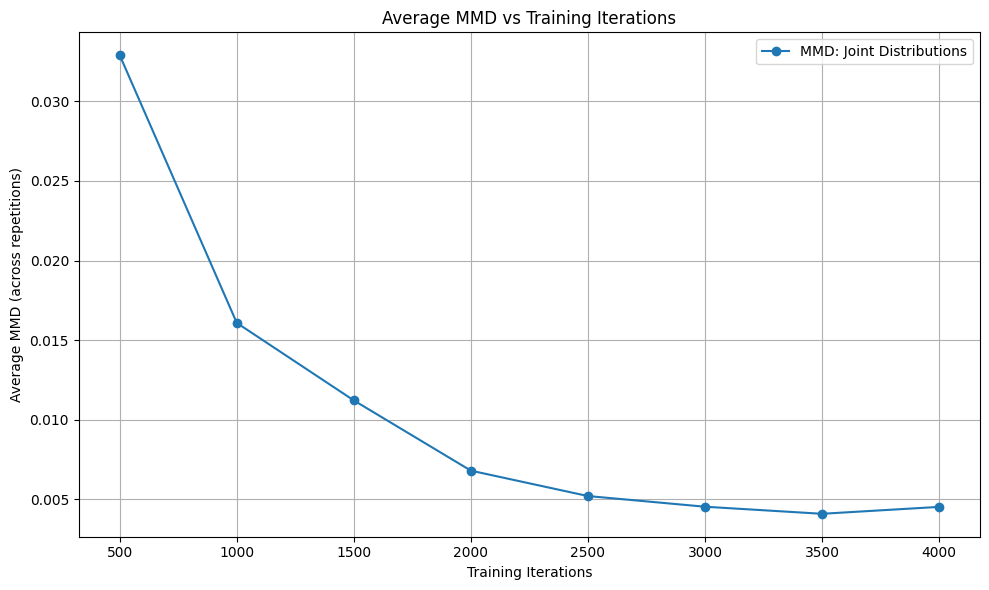

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# Compute average MMD across repetitions for each iteration
iterations = list(tracker.keys())

# Extract averages
# avg_mmd_p0_q0 = [np.mean(tracker[iteration]["mmd_p0_q0"]) for iteration in iterations]
# avg_mmd_p1_q1 = [np.mean(tracker[iteration]["mmd_p1_q1"]) for iteration in iterations]
avg_mmd_joint = [np.mean(tracker[iteration]["mmd_joint"]) for iteration in iterations]

# Plot the results
plt.figure(figsize=(10, 6))

# # MMD P0 vs Q0
# plt.plot(iterations, avg_mmd_p0_q0, marker='o', label='MMD: P0 vs Q0')

# # MMD P1 vs Q1
# plt.plot(iterations, avg_mmd_p1_q1, marker='o', label='MMD: P1 vs Q1')

# MMD Joint Distributions
plt.plot(iterations, avg_mmd_joint, marker='o', label='MMD: Joint Distributions')

# Customization
plt.title('Average MMD vs Training Iterations')
plt.xlabel('Training Iterations')
plt.ylabel('Average MMD (across repetitions)')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Show plot
plt.show()


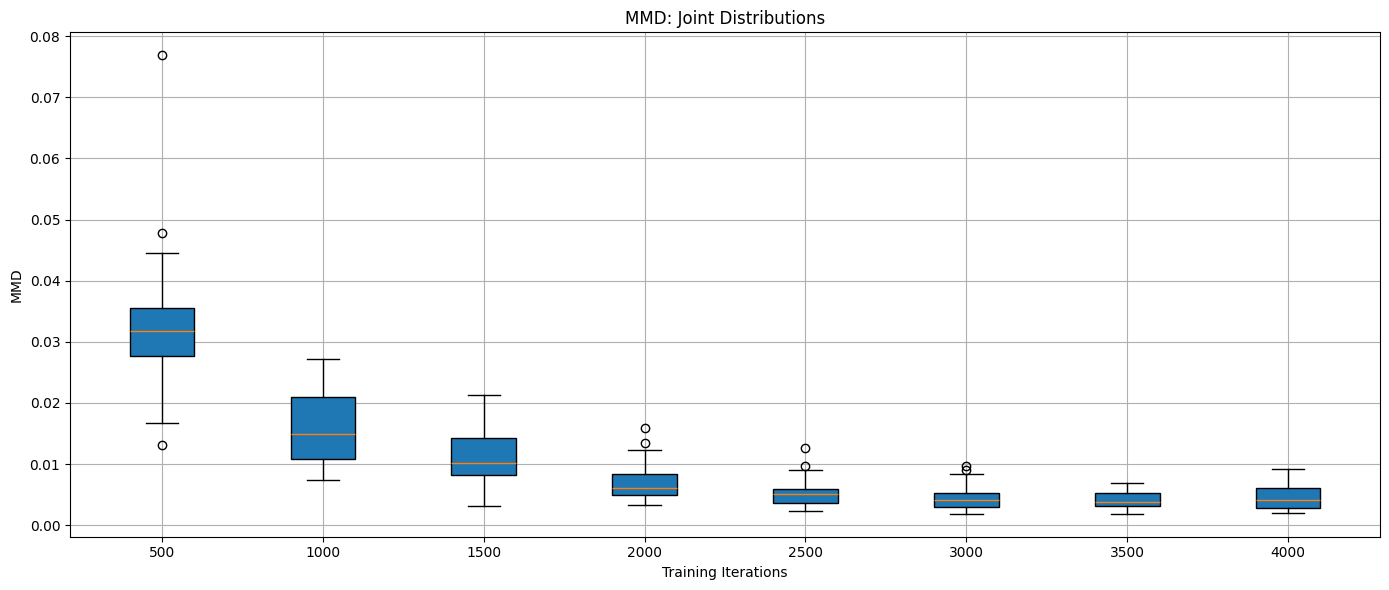

In [9]:
import matplotlib.pyplot as plt

# Extract MMD values for each iteration
iterations = list(tracker.keys())
mmd_joint = [tracker[iteration]["mmd_joint"] for iteration in iterations]

# Plot the boxplots
plt.figure(figsize=(14, 6))

plt.boxplot(mmd_joint, positions=iterations, widths=200, patch_artist=True)
plt.title('MMD: Joint Distributions')
plt.xlabel('Training Iterations')
plt.ylabel('MMD')
plt.grid(True)

plt.tight_layout()
plt.show()


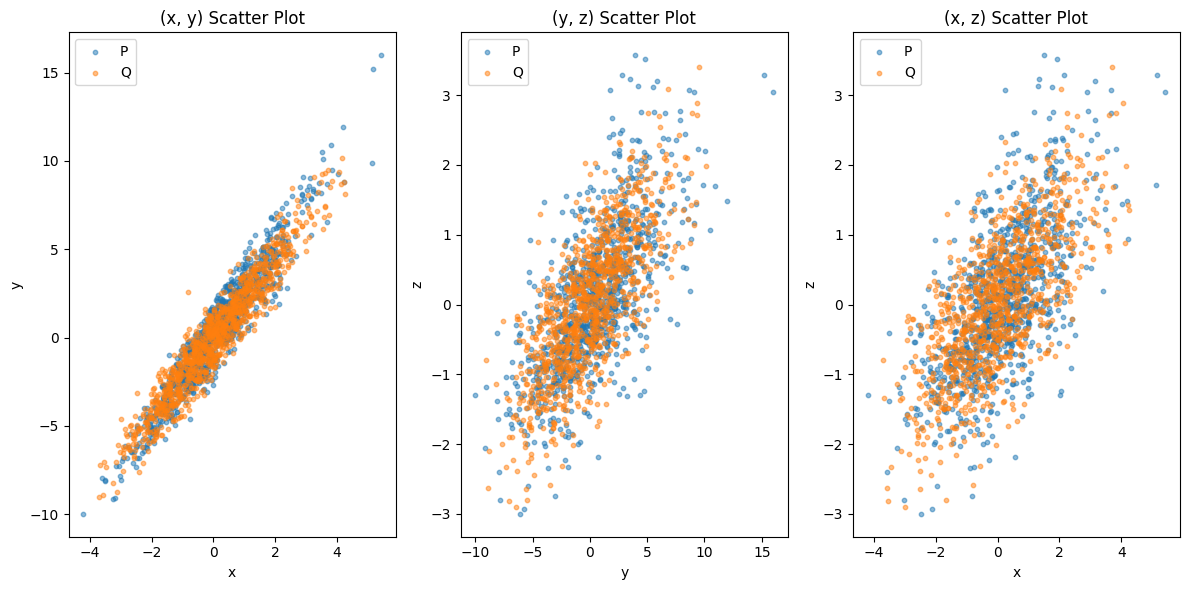

In [10]:
# Scatter plot for P and Q
plt.figure(figsize=(12, 6))

# (x, y) scatter for P and Q
plt.subplot(1, 3, 1)
plt.scatter(P_joint[:, 0], P_joint[:, 1], alpha=0.5, label='P', s=10)
plt.scatter(Q_joint[:, 0], Q_joint[:, 1], alpha=0.5, label='Q', s=10)
plt.title('(x, y) Scatter Plot')
plt.xlabel('x')
plt.ylabel('y')
plt.legend()

# (y, z) scatter for P and Q
plt.subplot(1, 3, 2)
plt.scatter(P_joint[:, 1], P_joint[:, 2], alpha=0.5, label='P', s=10)
plt.scatter(Q_joint[:, 1], Q_joint[:, 2], alpha=0.5, label='Q', s=10)
plt.title('(y, z) Scatter Plot')
plt.xlabel('y')
plt.ylabel('z')
plt.legend()

# (x, z) scatter for P and Q
plt.subplot(1, 3, 3)
plt.scatter(P_joint[:, 0], P_joint[:, 2], alpha=0.5, label='P', s=10)
plt.scatter(Q_joint[:, 0], Q_joint[:, 2], alpha=0.5, label='Q', s=10)
plt.title('(x, z) Scatter Plot')
plt.xlabel('x')
plt.ylabel('z')
plt.legend()

plt.tight_layout()
plt.show()


In [3]:
nrep = 30 # for equivalence testing
n_tr = 1000
n_p = 1000
# Initialize an empty list to store each Q_single
nI = 0
nX = 1
nO = 0
nS= 0
p = nI+nX+nO+nS
binary_intervention=False

# Initialize an empty list to store each Q_single
P0_list = []
Q0_list = []

P1_list = []
Q1_list = []

P_joint_list = []
Q_joint_list = []


# Define the tracker
tracker = {iteration: {"mmd_p0_q0": [], "mmd_p1_q1": [], "mmd_joint": [], "lr_coeffs_p": [], "lr_coeffs_q": []}
           for iteration in [500, 1000, 1500, 2000, 2500, 3000, 3500, 4000]}
# Begin experiment
for rep in tqdm(range(nrep)):
    # Generate data
    df_tr = generate_data_causl(n=n_tr, nI=nI, nX=nX, nO=nO, nS=nS, ate=ate, 
                                beta_cov=beta_cov, strength_instr=strength_instr, 
                                strength_conf=strength_conf, 
                                strength_outcome=strength_outcome, 
                                binary_intervention=binary_intervention)
    z_tr = torch.tensor(df_tr[[f"X{i}" for i in range(1, p + 1)]].values, dtype=torch.float32)
    x_tr = torch.tensor(df_tr['A'].values, dtype=torch.int32).view(-1, 1) if binary_intervention else \
           torch.tensor(df_tr['A'].values, dtype=torch.float32).view(-1, 1)
    y_tr = torch.tensor(df_tr['y'].values, dtype=torch.float32).view(-1, 1)

    model = Frengression(x_tr.shape[1], y_tr.shape[1], z_tr.shape[1], 
                         noise_dim=1, num_layer=3, hidden_dim=400, 
                         device=device, x_binary=binary_intervention)
    
    df_q = generate_data_causl(n=n_p, nI=nI, nX=nX, nO=nO, nS=nS, ate=ate, 
                                beta_cov=beta_cov, strength_instr=strength_instr, 
                                strength_conf=strength_conf, 
                                strength_outcome=strength_outcome, 
                                binary_intervention=binary_intervention)
    
    z_q = torch.tensor(df_q[[f"X{i}" for i in range(1, p + 1)]].values, dtype=torch.float32)
    x_q = torch.tensor(df_q['A'].values, dtype=torch.int32).view(-1, 1) if binary_intervention else \
           torch.tensor(df_q['A'].values, dtype=torch.float32).view(-1, 1)
    y_q = torch.tensor(df_q['y'].values, dtype=torch.float32).view(-1, 1)


    # Sample Q distributions
    Q0 = np.random.normal(loc=0, scale=1, size=n_p).reshape([n_p, 1])
    Q1 = np.random.normal(loc=ate, scale=1, size=n_p).reshape([n_p, 1])
    Q_joint = torch.cat([x_q, y_q, z_q],dim=1).numpy()  # Ground truth joint distribution (x, y, z)

    Q0_list.append(Q0)
    Q1_list.append(Q1)
    Q_joint_list.append(Q_joint)

    last_iteration = 0
    for iteration in tracker.keys():
        additional_iters = iteration - last_iteration
        last_iteration = iteration
        # Train model
        model.train_xz(x_tr, z_tr, num_iters=additional_iters, lr=1e-4, print_every_iter=100)
        model.train_y(x_tr, z_tr, y_tr, num_iters=additional_iters, lr=1e-4, print_every_iter=100)

        # Sample P distributions
        P0 = (model.sample_causal_margin(torch.tensor([0], dtype=torch.float32), sample_size=n_p)).numpy().reshape(-1, 1)
        P1 = (model.sample_causal_margin(torch.tensor([1], dtype=torch.float32), sample_size=n_p)).numpy().reshape(-1, 1)
        x_gen, y_gen, z_gen = model.sample_joint(sample_size=n_p)  # Sample joint distribution (x, y, z)
        P_joint = torch.cat([x_gen, y_gen, z_gen], dim=1).numpy()

        # Calculate MMD
        mmd_p0_q0 = mmd_rbf(P0, Q0, sigma=1.0)
        mmd_p1_q1 = mmd_rbf(P1, Q1, sigma=1.0)
        mmd_joint = mmd_rbf(P_joint, Q_joint, sigma=1.0)

        lr_p = LinearRegression()
        lr_p.fit(z_gen.numpy(), x_gen.numpy().ravel())
        lr_coeffs_p = lr_p.coef_

        # Logistic regression for Q (x_q, z_q from ground truth)
        lr_q = LinearRegression()
        lr_q.fit(z_q.numpy(), x_q.numpy().ravel())
        lr_coeffs_q = lr_q.coef_

        # Log results
        tracker[iteration]["mmd_p0_q0"].append(mmd_p0_q0)
        tracker[iteration]["mmd_p1_q1"].append(mmd_p1_q1)
        tracker[iteration]["mmd_joint"].append(mmd_joint)
        tracker[iteration]["lr_coeffs_p"].append(lr_coeffs_p)
        tracker[iteration]["lr_coeffs_q"].append(lr_coeffs_q)
    P0_list.append(P0)
    P1_list.append(P1)
    P_joint_list.append(P_joint)

P0s = np.stack(P0_list, axis=0) #[nrep, n, 1]
Q0s = np.stack(Q0_list, axis=0)
P1s = np.stack(P1_list, axis=0)
Q1s = np.stack(Q1_list, axis=0)
PJoints = np.stack(P_joint_list, axis=0)
QJoints = np.stack(Q_joint_list, axis=0)


  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1: loss 1.3902, loss1 1.4444, loss2 0.1085
Epoch 100: loss 0.9973, loss1 1.9284, loss2 1.8622
Epoch 200: loss 1.0448, loss1 2.0287, loss2 1.9678
Epoch 300: loss 0.9571, loss1 1.9722, loss2 2.0302
Epoch 400: loss 1.0485, loss1 1.9997, loss2 1.9024
Epoch 500: loss 1.0164, loss1 2.0332, loss2 2.0338
Epoch 1: loss 3.2693,	loss_y 2.5029, 2.5216, 0.0374,	loss_eta 0.7664, 0.8080, 0.0831
Epoch 100: loss 1.3122,	loss_y 0.6621, 1.5527, 1.7811,	loss_eta 0.6500, 0.8284, 0.3567
Epoch 200: loss 1.1966,	loss_y 0.6357, 1.2396, 1.2078,	loss_eta 0.5609, 1.0566, 0.9915
Epoch 300: loss 1.8671,	loss_y 1.3056, 2.0021, 1.3930,	loss_eta 0.5615, 1.0826, 1.0424
Epoch 400: loss 1.6461,	loss_y 0.9361, 1.6444, 1.4166,	loss_eta 0.7100, 0.8165, 0.2129
Epoch 500: loss 1.2445,	loss_y 0.5783, 1.3964, 1.6361,	loss_eta 0.6661, 1.0522, 0.7720
Epoch 1: loss 1.0493, loss1 2.0265, loss2 1.9544
Epoch 100: loss 1.0197, loss1 2.0638, loss2 2.0882
Epoch 200: loss 1.0693, loss1 2.0573, loss2 1.9758
Epoch 300: loss 1.0417, l

  3%|▎         | 1/30 [01:20<38:46, 80.23s/it]

Epoch 500: loss 1.1300,	loss_y 0.5360, 1.1188, 1.1656,	loss_eta 0.5940, 1.1776, 1.1673
Epoch 1: loss 1.3787, loss1 1.4354, loss2 0.1133
Epoch 100: loss 0.9994, loss1 1.9669, loss2 1.9350
Epoch 200: loss 0.9890, loss1 2.0001, loss2 2.0223
Epoch 300: loss 1.0428, loss1 2.0907, loss2 2.0958
Epoch 400: loss 1.0295, loss1 2.0244, loss2 1.9897
Epoch 500: loss 0.9891, loss1 2.0009, loss2 2.0235
Epoch 1: loss 3.2797,	loss_y 2.5099, 2.5266, 0.0334,	loss_eta 0.7698, 0.8074, 0.0752
Epoch 100: loss 1.3027,	loss_y 0.6401, 1.7118, 2.1434,	loss_eta 0.6626, 0.8499, 0.3746
Epoch 200: loss 1.1593,	loss_y 0.5729, 1.2202, 1.2945,	loss_eta 0.5864, 1.4138, 1.6548
Epoch 300: loss 1.6176,	loss_y 1.0105, 1.3625, 0.7041,	loss_eta 0.6070, 1.2896, 1.3652
Epoch 400: loss 1.3213,	loss_y 0.7103, 1.3384, 1.2562,	loss_eta 0.6110, 0.9201, 0.6182
Epoch 500: loss 1.6524,	loss_y 0.9496, 2.0348, 2.1704,	loss_eta 0.7029, 1.1555, 0.9053
Epoch 1: loss 1.0149, loss1 2.0312, loss2 2.0326
Epoch 100: loss 1.0407, loss1 2.0325, lo

  7%|▋         | 2/30 [02:37<36:38, 78.53s/it]

Epoch 500: loss 1.0700,	loss_y 0.4922, 1.0299, 1.0754,	loss_eta 0.5778, 1.1159, 1.0762
Epoch 1: loss 1.3941, loss1 1.4622, loss2 0.1362
Epoch 100: loss 0.9979, loss1 1.9945, loss2 1.9931
Epoch 200: loss 1.0535, loss1 2.0374, loss2 1.9679
Epoch 300: loss 1.0744, loss1 2.0618, loss2 1.9748
Epoch 400: loss 1.0289, loss1 2.0556, loss2 2.0534
Epoch 500: loss 1.0477, loss1 2.0937, loss2 2.0920
Epoch 1: loss 3.3608,	loss_y 2.6187, 2.6445, 0.0516,	loss_eta 0.7422, 0.8110, 0.1377
Epoch 100: loss 1.1871,	loss_y 0.5544, 1.4437, 1.7786,	loss_eta 0.6327, 0.9130, 0.5606
Epoch 200: loss 1.2237,	loss_y 0.6570, 1.1804, 1.0469,	loss_eta 0.5668, 1.3363, 1.5390
Epoch 300: loss 1.3784,	loss_y 0.6021, 1.0631, 0.9220,	loss_eta 0.7763, 0.8150, 0.0774
Epoch 400: loss 1.4135,	loss_y 0.7578, 1.8510, 2.1864,	loss_eta 0.6556, 1.1974, 1.0836
Epoch 500: loss 1.9526,	loss_y 1.2637, 2.5403, 2.5532,	loss_eta 0.6890, 1.2556, 1.1333
Epoch 1: loss 1.0532, loss1 2.1133, loss2 2.1202
Epoch 100: loss 1.0205, loss1 2.0976, lo

 10%|█         | 3/30 [03:51<34:25, 76.52s/it]

Epoch 500: loss 1.0494,	loss_y 0.5097, 0.9996, 0.9799,	loss_eta 0.5397, 1.0473, 1.0152
Epoch 1: loss 1.3997, loss1 1.4569, loss2 0.1144
Epoch 100: loss 1.0247, loss1 2.0065, loss2 1.9635
Epoch 200: loss 0.9779, loss1 2.0481, loss2 2.1404
Epoch 300: loss 1.0291, loss1 2.0770, loss2 2.0958
Epoch 400: loss 1.0098, loss1 2.0218, loss2 2.0239
Epoch 500: loss 1.0310, loss1 2.0253, loss2 1.9887
Epoch 1: loss 3.2678,	loss_y 2.5088, 2.5407, 0.0639,	loss_eta 0.7590, 0.7995, 0.0809
Epoch 100: loss 1.2580,	loss_y 0.6028, 1.4667, 1.7278,	loss_eta 0.6551, 0.9538, 0.5973
Epoch 200: loss 1.1123,	loss_y 0.5231, 1.1088, 1.1714,	loss_eta 0.5892, 1.2361, 1.2938
Epoch 300: loss 1.3708,	loss_y 0.7556, 1.2416, 0.9719,	loss_eta 0.6152, 1.2150, 1.1995
Epoch 400: loss 2.0085,	loss_y 1.2581, 1.7714, 1.0267,	loss_eta 0.7505, 0.8119, 0.1228
Epoch 500: loss 1.4282,	loss_y 0.8145, 2.0164, 2.4038,	loss_eta 0.6137, 1.1374, 1.0473
Epoch 1: loss 0.9830, loss1 1.9742, loss2 1.9824
Epoch 100: loss 1.0006, loss1 2.0020, lo

 13%|█▎        | 4/30 [05:06<32:51, 75.81s/it]

Epoch 500: loss 1.0908,	loss_y 0.5398, 1.1925, 1.3053,	loss_eta 0.5510, 1.1693, 1.2366
Epoch 1: loss 1.3963, loss1 1.4801, loss2 0.1677
Epoch 100: loss 1.0332, loss1 2.0507, loss2 2.0350
Epoch 200: loss 1.0399, loss1 2.0427, loss2 2.0055
Epoch 300: loss 0.9727, loss1 2.0131, loss2 2.0809
Epoch 400: loss 0.9865, loss1 2.0518, loss2 2.1305
Epoch 500: loss 1.0260, loss1 2.0811, loss2 2.1102
Epoch 1: loss 3.3715,	loss_y 2.6079, 2.6224, 0.0291,	loss_eta 0.7636, 0.7846, 0.0419
Epoch 100: loss 1.1228,	loss_y 0.5246, 1.2721, 1.4948,	loss_eta 0.5982, 1.0210, 0.8458
Epoch 200: loss 1.0516,	loss_y 0.4945, 1.0512, 1.1135,	loss_eta 0.5572, 1.1080, 1.1016
Epoch 300: loss 1.4998,	loss_y 0.9418, 1.5085, 1.1334,	loss_eta 0.5580, 1.3717, 1.6275
Epoch 400: loss 2.0517,	loss_y 1.3209, 1.7698, 0.8977,	loss_eta 0.7308, 0.7931, 0.1245
Epoch 500: loss 1.7522,	loss_y 1.1690, 2.7819, 3.2258,	loss_eta 0.5833, 0.9347, 0.7029
Epoch 1: loss 1.0422, loss1 2.0674, loss2 2.0503
Epoch 100: loss 1.0584, loss1 2.0629, lo

 17%|█▋        | 5/30 [06:17<30:53, 74.12s/it]

Epoch 500: loss 1.0958,	loss_y 0.5199, 1.0104, 0.9810,	loss_eta 0.5759, 1.1074, 1.0630
Epoch 1: loss 1.4410, loss1 1.5393, loss2 0.1966
Epoch 100: loss 1.1004, loss1 2.1115, loss2 2.0222
Epoch 200: loss 1.0640, loss1 2.1379, loss2 2.1478
Epoch 300: loss 1.0603, loss1 2.1290, loss2 2.1373
Epoch 400: loss 1.0819, loss1 2.1717, loss2 2.1795
Epoch 500: loss 1.0802, loss1 2.1522, loss2 2.1440
Epoch 1: loss 3.5979,	loss_y 2.8132, 2.8340, 0.0416,	loss_eta 0.7847, 0.8189, 0.0686
Epoch 100: loss 1.3412,	loss_y 0.7871, 1.7113, 1.8483,	loss_eta 0.5541, 1.1220, 1.1358
Epoch 200: loss 1.1644,	loss_y 0.6129, 1.3215, 1.4173,	loss_eta 0.5515, 1.2114, 1.3198
Epoch 300: loss 1.9798,	loss_y 1.3202, 1.7907, 0.9411,	loss_eta 0.6596, 0.8786, 0.4380
Epoch 400: loss 2.2069,	loss_y 1.6084, 2.4039, 1.5910,	loss_eta 0.5985, 1.2708, 1.3446
Epoch 500: loss 2.0878,	loss_y 1.4798, 2.8471, 2.7347,	loss_eta 0.6080, 1.2080, 1.2001
Epoch 1: loss 1.0137, loss1 2.0676, loss2 2.1079
Epoch 100: loss 1.1167, loss1 2.1835, lo

 20%|██        | 6/30 [07:21<28:14, 70.61s/it]

Epoch 500: loss 1.1104,	loss_y 0.5270, 1.0231, 0.9922,	loss_eta 0.5834, 1.1253, 1.0837
Epoch 1: loss 1.3959, loss1 1.4428, loss2 0.0938
Epoch 100: loss 1.0245, loss1 1.9925, loss2 1.9360
Epoch 200: loss 0.9891, loss1 2.0065, loss2 2.0348
Epoch 300: loss 1.0117, loss1 2.0336, loss2 2.0438
Epoch 400: loss 1.0356, loss1 2.0063, loss2 1.9413
Epoch 500: loss 1.0126, loss1 2.0484, loss2 2.0717
Epoch 1: loss 3.3013,	loss_y 2.5243, 2.5692, 0.0898,	loss_eta 0.7770, 0.8128, 0.0717
Epoch 100: loss 1.3373,	loss_y 0.7107, 1.6754, 1.9294,	loss_eta 0.6266, 0.9413, 0.6294
Epoch 200: loss 1.1212,	loss_y 0.5610, 1.3014, 1.4810,	loss_eta 0.5602, 1.2469, 1.3734
Epoch 300: loss 1.3247,	loss_y 0.7262, 0.9928, 0.5333,	loss_eta 0.5985, 1.2147, 1.2324
Epoch 400: loss 1.6794,	loss_y 0.9688, 1.4579, 0.9782,	loss_eta 0.7106, 0.9573, 0.4934
Epoch 500: loss 1.4440,	loss_y 0.7382, 1.5717, 1.6669,	loss_eta 0.7058, 1.1359, 0.8603
Epoch 1: loss 1.0094, loss1 2.0335, loss2 2.0482
Epoch 100: loss 1.0104, loss1 2.0198, lo

 23%|██▎       | 7/30 [08:23<26:01, 67.91s/it]

Epoch 500: loss 1.0678,	loss_y 0.5340, 1.1637, 1.2595,	loss_eta 0.5338, 1.0813, 1.0950
Epoch 1: loss 1.4453, loss1 1.5028, loss2 0.1149
Epoch 100: loss 1.0526, loss1 2.0764, loss2 2.0476
Epoch 200: loss 1.0390, loss1 2.0476, loss2 2.0173
Epoch 300: loss 1.0285, loss1 2.0596, loss2 2.0623
Epoch 400: loss 1.0145, loss1 2.0549, loss2 2.0808
Epoch 500: loss 1.0111, loss1 2.0636, loss2 2.1049
Epoch 1: loss 3.3784,	loss_y 2.5990, 2.6324, 0.0668,	loss_eta 0.7795, 0.8576, 0.1562
Epoch 100: loss 1.1930,	loss_y 0.6317, 1.5169, 1.7703,	loss_eta 0.5612, 0.9036, 0.6848
Epoch 200: loss 1.2608,	loss_y 0.6668, 1.1879, 1.0422,	loss_eta 0.5940, 1.0918, 0.9954
Epoch 300: loss 1.4919,	loss_y 0.9102, 1.4261, 1.0317,	loss_eta 0.5816, 0.9873, 0.8114
Epoch 400: loss 1.8200,	loss_y 1.1377, 1.9222, 1.5690,	loss_eta 0.6822, 1.1627, 0.9608
Epoch 500: loss 1.4996,	loss_y 0.9142, 2.1733, 2.5181,	loss_eta 0.5854, 1.0099, 0.8490
Epoch 1: loss 1.0250, loss1 2.0736, loss2 2.0972
Epoch 100: loss 1.0629, loss1 2.1206, lo

 27%|██▋       | 8/30 [09:25<24:10, 65.95s/it]

Epoch 500: loss 1.0902,	loss_y 0.5208, 1.0706, 1.0996,	loss_eta 0.5694, 1.0924, 1.0460
Epoch 1: loss 1.3951, loss1 1.4861, loss2 0.1820
Epoch 100: loss 1.0543, loss1 2.0260, loss2 1.9435
Epoch 200: loss 1.0363, loss1 2.0309, loss2 1.9893
Epoch 300: loss 1.0701, loss1 2.0151, loss2 1.8900
Epoch 400: loss 1.0457, loss1 2.0925, loss2 2.0935
Epoch 500: loss 1.0323, loss1 2.1038, loss2 2.1431
Epoch 1: loss 3.3541,	loss_y 2.6021, 2.6391, 0.0741,	loss_eta 0.7520, 0.7862, 0.0684
Epoch 100: loss 1.4763,	loss_y 0.7294, 1.5816, 1.7044,	loss_eta 0.7469, 0.8220, 0.1501
Epoch 200: loss 1.1286,	loss_y 0.5874, 1.2619, 1.3490,	loss_eta 0.5412, 1.1622, 1.2420
Epoch 300: loss 1.2670,	loss_y 0.6790, 1.4344, 1.5108,	loss_eta 0.5879, 1.1348, 1.0938
Epoch 400: loss 1.5892,	loss_y 0.8515, 1.7464, 1.7898,	loss_eta 0.7378, 1.0992, 0.7228
Epoch 500: loss 1.5828,	loss_y 0.9225, 1.9443, 2.0435,	loss_eta 0.6602, 1.0410, 0.7614
Epoch 1: loss 1.0336, loss1 2.0800, loss2 2.0928
Epoch 100: loss 1.0505, loss1 2.1059, lo

 30%|███       | 9/30 [10:25<22:28, 64.22s/it]

Epoch 500: loss 1.1000,	loss_y 0.5518, 0.9986, 0.8935,	loss_eta 0.5482, 1.1344, 1.1725
Epoch 1: loss 1.4002, loss1 1.4443, loss2 0.0881
Epoch 100: loss 1.0013, loss1 1.9957, loss2 1.9886
Epoch 200: loss 1.0296, loss1 2.0149, loss2 1.9705
Epoch 300: loss 1.0258, loss1 2.0359, loss2 2.0201
Epoch 400: loss 1.0260, loss1 2.0341, loss2 2.0162
Epoch 500: loss 1.0078, loss1 2.0173, loss2 2.0190
Epoch 1: loss 3.3452,	loss_y 2.5674, 2.5801, 0.0253,	loss_eta 0.7778, 0.8156, 0.0757
Epoch 100: loss 1.1932,	loss_y 0.6375, 1.4221, 1.5691,	loss_eta 0.5557, 1.0525, 0.9937
Epoch 200: loss 1.3371,	loss_y 0.7412, 1.2751, 1.0677,	loss_eta 0.5959, 1.0146, 0.8373
Epoch 300: loss 1.3106,	loss_y 0.7057, 1.1562, 0.9010,	loss_eta 0.6049, 1.0473, 0.8847
Epoch 400: loss 1.3042,	loss_y 0.6363, 1.2947, 1.3168,	loss_eta 0.6679, 0.9485, 0.5611
Epoch 500: loss 1.5260,	loss_y 0.7359, 2.0267, 2.5816,	loss_eta 0.7901, 1.2220, 0.8637
Epoch 1: loss 1.0099, loss1 2.0102, loss2 2.0005
Epoch 100: loss 1.0279, loss1 2.0389, lo

 33%|███▎      | 10/30 [11:26<21:02, 63.10s/it]

Epoch 500: loss 1.0928,	loss_y 0.5197, 1.1138, 1.1882,	loss_eta 0.5731, 1.2198, 1.2935
Epoch 1: loss 1.4451, loss1 1.5053, loss2 0.1204
Epoch 100: loss 1.0999, loss1 2.0838, loss2 1.9678
Epoch 200: loss 1.0654, loss1 2.0661, loss2 2.0014
Epoch 300: loss 1.0562, loss1 2.1455, loss2 2.1786
Epoch 400: loss 1.0835, loss1 2.1513, loss2 2.1357
Epoch 500: loss 1.0912, loss1 2.1451, loss2 2.1077
Epoch 1: loss 3.5187,	loss_y 2.7601, 2.7948, 0.0694,	loss_eta 0.7586, 0.7989, 0.0805
Epoch 100: loss 1.2915,	loss_y 0.6685, 1.6668, 1.9966,	loss_eta 0.6230, 0.8848, 0.5236
Epoch 200: loss 1.2109,	loss_y 0.6420, 1.2074, 1.1308,	loss_eta 0.5689, 1.1467, 1.1556
Epoch 300: loss 2.0606,	loss_y 1.3747, 1.8906, 1.0318,	loss_eta 0.6859, 1.1892, 1.0066
Epoch 400: loss 2.0295,	loss_y 1.3167, 1.9278, 1.2222,	loss_eta 0.7128, 1.3754, 1.3251
Epoch 500: loss 1.8263,	loss_y 1.1583, 3.0044, 3.6920,	loss_eta 0.6679, 0.8409, 0.3460
Epoch 1: loss 1.0449, loss1 2.0979, loss2 2.1061
Epoch 100: loss 1.0402, loss1 2.1489, lo

 37%|███▋      | 11/30 [12:30<20:03, 63.34s/it]

Epoch 500: loss 1.1389,	loss_y 0.6021, 1.1139, 1.0237,	loss_eta 0.5369, 1.1217, 1.1697
Epoch 1: loss 1.4396, loss1 1.5130, loss2 0.1468
Epoch 100: loss 1.0617, loss1 2.1044, loss2 2.0853
Epoch 200: loss 1.0685, loss1 2.1315, loss2 2.1259
Epoch 300: loss 1.0483, loss1 2.1089, loss2 2.1212
Epoch 400: loss 1.1108, loss1 2.1399, loss2 2.0583
Epoch 500: loss 1.0606, loss1 2.1304, loss2 2.1396
Epoch 1: loss 3.4105,	loss_y 2.6418, 2.6564, 0.0293,	loss_eta 0.7687, 0.8037, 0.0700
Epoch 100: loss 1.3662,	loss_y 0.6392, 1.5815, 1.8846,	loss_eta 0.7270, 0.8122, 0.1703
Epoch 200: loss 1.1831,	loss_y 0.5677, 1.0876, 1.0399,	loss_eta 0.6154, 1.2823, 1.3338
Epoch 300: loss 1.6697,	loss_y 1.0604, 1.5938, 1.0669,	loss_eta 0.6093, 1.2880, 1.3574
Epoch 400: loss 1.9939,	loss_y 1.2588, 2.1404, 1.7632,	loss_eta 0.7351, 0.9618, 0.4534
Epoch 500: loss 1.9286,	loss_y 1.2606, 2.5739, 2.6266,	loss_eta 0.6681, 0.8711, 0.4060
Epoch 1: loss 1.0968, loss1 2.1269, loss2 2.0602
Epoch 100: loss 1.0552, loss1 2.1169, lo

 40%|████      | 12/30 [13:34<19:04, 63.59s/it]

Epoch 500: loss 1.1233,	loss_y 0.5471, 1.0716, 1.0490,	loss_eta 0.5762, 1.0725, 0.9926
Epoch 1: loss 1.4742, loss1 1.5145, loss2 0.0806
Epoch 100: loss 1.0483, loss1 2.0912, loss2 2.0858
Epoch 200: loss 1.0666, loss1 2.0796, loss2 2.0259
Epoch 300: loss 1.1103, loss1 2.1538, loss2 2.0870
Epoch 400: loss 1.0709, loss1 2.1170, loss2 2.0923
Epoch 500: loss 1.0744, loss1 2.1291, loss2 2.1095
Epoch 1: loss 3.4880,	loss_y 2.6983, 2.7067, 0.0169,	loss_eta 0.7898, 0.8163, 0.0531
Epoch 100: loss 1.2786,	loss_y 0.6304, 1.2227, 1.1845,	loss_eta 0.6482, 0.8347, 0.3730
Epoch 200: loss 1.0719,	loss_y 0.4918, 1.1399, 1.2963,	loss_eta 0.5801, 1.1382, 1.1162
Epoch 300: loss 1.5520,	loss_y 0.9574, 1.7527, 1.5907,	loss_eta 0.5946, 1.4042, 1.6192
Epoch 400: loss 1.7582,	loss_y 1.0949, 1.7908, 1.3919,	loss_eta 0.6633, 0.8595, 0.3923
Epoch 500: loss 1.5172,	loss_y 0.7668, 1.9213, 2.3090,	loss_eta 0.7504, 0.9192, 0.3375
Epoch 1: loss 1.0718, loss1 2.1457, loss2 2.1478
Epoch 100: loss 1.0573, loss1 2.1490, lo

 43%|████▎     | 13/30 [14:36<17:51, 63.04s/it]

Epoch 500: loss 1.1565,	loss_y 0.5610, 1.2160, 1.3102,	loss_eta 0.5955, 1.1373, 1.0835
Epoch 1: loss 1.3800, loss1 1.4580, loss2 0.1560
Epoch 100: loss 1.0411, loss1 2.0536, loss2 2.0250
Epoch 200: loss 1.0597, loss1 2.0717, loss2 2.0240
Epoch 300: loss 1.0131, loss1 2.0275, loss2 2.0287
Epoch 400: loss 1.0285, loss1 2.0685, loss2 2.0799
Epoch 500: loss 1.0109, loss1 2.0147, loss2 2.0078
Epoch 1: loss 3.3680,	loss_y 2.6195, 2.6320, 0.0251,	loss_eta 0.7486, 0.7769, 0.0566
Epoch 100: loss 1.2892,	loss_y 0.6183, 1.6488, 2.0610,	loss_eta 0.6709, 0.8781, 0.4145
Epoch 200: loss 1.1273,	loss_y 0.5724, 1.2514, 1.3581,	loss_eta 0.5549, 1.0942, 1.0785
Epoch 300: loss 1.1302,	loss_y 0.5473, 0.8947, 0.6948,	loss_eta 0.5829, 1.2182, 1.2705
Epoch 400: loss 1.3532,	loss_y 0.5850, 1.5130, 1.8561,	loss_eta 0.7683, 0.9775, 0.4184
Epoch 500: loss 1.5972,	loss_y 0.9683, 2.5219, 3.1072,	loss_eta 0.6288, 1.4950, 1.7324
Epoch 1: loss 1.0022, loss1 2.0328, loss2 2.0612
Epoch 100: loss 1.0317, loss1 2.0429, lo

 47%|████▋     | 14/30 [15:38<16:42, 62.66s/it]

Epoch 500: loss 0.9894,	loss_y 0.4746, 1.0312, 1.1132,	loss_eta 0.5148, 1.1304, 1.2311
Epoch 1: loss 1.4848, loss1 1.5353, loss2 0.1010
Epoch 100: loss 1.0746, loss1 2.1319, loss2 2.1145
Epoch 200: loss 1.1064, loss1 2.1795, loss2 2.1462
Epoch 300: loss 1.0393, loss1 2.1095, loss2 2.1404
Epoch 400: loss 1.0994, loss1 2.1692, loss2 2.1395
Epoch 500: loss 1.0508, loss1 2.0880, loss2 2.0743
Epoch 1: loss 3.4883,	loss_y 2.7330, 2.7655, 0.0650,	loss_eta 0.7553, 0.7869, 0.0632
Epoch 100: loss 1.5972,	loss_y 0.9112, 2.0951, 2.3678,	loss_eta 0.6860, 1.6504, 1.9288
Epoch 200: loss 2.0048,	loss_y 1.3348, 2.4250, 2.1802,	loss_eta 0.6700, 0.8247, 0.3096
Epoch 300: loss 1.6256,	loss_y 0.8542, 1.7468, 1.7851,	loss_eta 0.7714, 0.8317, 0.1205
Epoch 400: loss 1.6340,	loss_y 0.8783, 1.7089, 1.6613,	loss_eta 0.7557, 0.8154, 0.1194
Epoch 500: loss 1.9405,	loss_y 1.2277, 2.5061, 2.5567,	loss_eta 0.7128, 0.8960, 0.3663
Epoch 1: loss 1.0271, loss1 2.0829, loss2 2.1117
Epoch 100: loss 1.0733, loss1 2.0877, lo

 50%|█████     | 15/30 [16:38<15:31, 62.11s/it]

Epoch 500: loss 1.1290,	loss_y 0.5322, 1.0832, 1.1021,	loss_eta 0.5968, 1.0850, 0.9764
Epoch 1: loss 1.4371, loss1 1.4868, loss2 0.0994
Epoch 100: loss 1.0733, loss1 2.1121, loss2 2.0777
Epoch 200: loss 1.0455, loss1 2.0591, loss2 2.0272
Epoch 300: loss 1.0512, loss1 2.0659, loss2 2.0293
Epoch 400: loss 1.0147, loss1 2.0328, loss2 2.0362
Epoch 500: loss 1.0186, loss1 2.0594, loss2 2.0816
Epoch 1: loss 3.3805,	loss_y 2.6198, 2.6466, 0.0537,	loss_eta 0.7607, 0.7890, 0.0565
Epoch 100: loss 1.3773,	loss_y 0.7259, 1.6900, 1.9280,	loss_eta 0.6514, 0.8921, 0.4815
Epoch 200: loss 1.2428,	loss_y 0.6073, 1.3654, 1.5161,	loss_eta 0.6355, 1.3791, 1.4872
Epoch 300: loss 1.5379,	loss_y 0.9046, 1.5407, 1.2721,	loss_eta 0.6333, 1.2965, 1.3265
Epoch 400: loss 1.4397,	loss_y 0.8251, 1.3841, 1.1181,	loss_eta 0.6147, 0.8664, 0.5034
Epoch 500: loss 1.5790,	loss_y 0.8527, 1.9635, 2.2216,	loss_eta 0.7263, 1.2531, 1.0537
Epoch 1: loss 1.0213, loss1 2.0691, loss2 2.0956
Epoch 100: loss 1.0770, loss1 2.0578, lo

 53%|█████▎    | 16/30 [17:39<14:21, 61.57s/it]

Epoch 500: loss 1.0978,	loss_y 0.5507, 1.0769, 1.0523,	loss_eta 0.5471, 1.1398, 1.1855
Epoch 1: loss 1.4517, loss1 1.5141, loss2 0.1248
Epoch 100: loss 1.0499, loss1 2.0608, loss2 2.0218
Epoch 200: loss 1.0533, loss1 2.1157, loss2 2.1250
Epoch 300: loss 1.0486, loss1 2.1075, loss2 2.1179
Epoch 400: loss 1.0699, loss1 2.1499, loss2 2.1598
Epoch 500: loss 1.0572, loss1 2.1491, loss2 2.1838
Epoch 1: loss 3.4600,	loss_y 2.6674, 2.6796, 0.0243,	loss_eta 0.7926, 0.8346, 0.0839
Epoch 100: loss 1.2988,	loss_y 0.6434, 1.4591, 1.6313,	loss_eta 0.6554, 0.8856, 0.4606
Epoch 200: loss 1.1240,	loss_y 0.5872, 1.4036, 1.6328,	loss_eta 0.5368, 1.2583, 1.4430
Epoch 300: loss 1.2270,	loss_y 0.6438, 1.1835, 1.0794,	loss_eta 0.5832, 1.0977, 1.0290
Epoch 400: loss 2.2040,	loss_y 1.5856, 2.2905, 1.4098,	loss_eta 0.6184, 1.0419, 0.8471
Epoch 500: loss 2.0844,	loss_y 1.4086, 2.3213, 1.8253,	loss_eta 0.6758, 0.9346, 0.5176
Epoch 1: loss 1.0761, loss1 2.1844, loss2 2.2166
Epoch 100: loss 1.0665, loss1 2.1612, lo

 57%|█████▋    | 17/30 [18:39<13:16, 61.24s/it]

Epoch 500: loss 1.2074,	loss_y 0.6430, 1.1047, 0.9232,	loss_eta 0.5644, 1.1522, 1.1757
Epoch 1: loss 1.4417, loss1 1.4940, loss2 0.1047
Epoch 100: loss 1.0725, loss1 2.0816, loss2 2.0181
Epoch 200: loss 1.0669, loss1 2.0865, loss2 2.0391
Epoch 300: loss 1.0537, loss1 2.0975, loss2 2.0875
Epoch 400: loss 1.0960, loss1 2.1284, loss2 2.0649
Epoch 500: loss 1.0497, loss1 2.0727, loss2 2.0460
Epoch 1: loss 3.3482,	loss_y 2.6176, 2.6381, 0.0410,	loss_eta 0.7306, 0.7949, 0.1284
Epoch 100: loss 1.3117,	loss_y 0.6671, 1.6356, 1.9370,	loss_eta 0.6446, 1.3913, 1.4933
Epoch 200: loss 1.3502,	loss_y 0.6157, 1.3246, 1.4178,	loss_eta 0.7345, 0.8220, 0.1749
Epoch 300: loss 1.2778,	loss_y 0.7141, 1.4463, 1.4643,	loss_eta 0.5636, 1.1593, 1.1914
Epoch 400: loss 1.2934,	loss_y 0.7417, 1.3529, 1.2226,	loss_eta 0.5517, 0.9932, 0.8829
Epoch 500: loss 1.3622,	loss_y 0.5930, 1.5667, 1.9473,	loss_eta 0.7691, 0.8991, 0.2599
Epoch 1: loss 1.0486, loss1 2.1047, loss2 2.1122
Epoch 100: loss 1.0601, loss1 2.0800, lo

 60%|██████    | 18/30 [19:41<12:15, 61.29s/it]

Epoch 500: loss 1.0792,	loss_y 0.5278, 1.0824, 1.1092,	loss_eta 0.5515, 1.0595, 1.0161
Epoch 1: loss 1.4447, loss1 1.4842, loss2 0.0790
Epoch 100: loss 1.0891, loss1 2.0891, loss2 2.0001
Epoch 200: loss 1.0324, loss1 2.0790, loss2 2.0933
Epoch 300: loss 1.0685, loss1 2.1217, loss2 2.1065
Epoch 400: loss 1.0799, loss1 2.1122, loss2 2.0646
Epoch 500: loss 1.0425, loss1 2.1056, loss2 2.1261
Epoch 1: loss 3.4109,	loss_y 2.6525, 2.6731, 0.0412,	loss_eta 0.7584, 0.8122, 0.1077
Epoch 100: loss 1.3549,	loss_y 0.6129, 1.5972, 1.9687,	loss_eta 0.7420, 0.9474, 0.4108
Epoch 200: loss 1.1736,	loss_y 0.5759, 1.2768, 1.4018,	loss_eta 0.5977, 1.2115, 1.2275
Epoch 300: loss 1.2234,	loss_y 0.6772, 1.1925, 1.0306,	loss_eta 0.5462, 1.1227, 1.1529
Epoch 400: loss 2.2650,	loss_y 1.4284, 2.3315, 1.8063,	loss_eta 0.8366, 1.2864, 0.8995
Epoch 500: loss 1.7781,	loss_y 1.0549, 2.0210, 1.9322,	loss_eta 0.7231, 0.8119, 0.1774
Epoch 1: loss 1.0237, loss1 2.1035, loss2 2.1596
Epoch 100: loss 0.9876, loss1 2.0369, lo

 63%|██████▎   | 19/30 [20:51<11:42, 63.89s/it]

Epoch 500: loss 1.0839,	loss_y 0.5291, 1.1332, 1.2083,	loss_eta 0.5548, 1.1816, 1.2535
Epoch 1: loss 1.4282, loss1 1.4868, loss2 0.1172
Epoch 100: loss 1.0694, loss1 2.0971, loss2 2.0554
Epoch 200: loss 1.0227, loss1 2.0773, loss2 2.1091
Epoch 300: loss 1.0421, loss1 2.0807, loss2 2.0773
Epoch 400: loss 1.0510, loss1 2.0880, loss2 2.0740
Epoch 500: loss 1.0334, loss1 2.0329, loss2 1.9989
Epoch 1: loss 3.2594,	loss_y 2.4918, 2.5229, 0.0621,	loss_eta 0.7675, 0.7999, 0.0647
Epoch 100: loss 1.2592,	loss_y 0.6933, 1.7108, 2.0349,	loss_eta 0.5659, 1.1945, 1.2572
Epoch 200: loss 1.0948,	loss_y 0.5195, 1.1629, 1.2868,	loss_eta 0.5753, 1.3242, 1.4978
Epoch 300: loss 1.8951,	loss_y 1.3105, 1.8359, 1.0508,	loss_eta 0.5846, 1.4633, 1.7573
Epoch 400: loss 1.9891,	loss_y 1.2354, 1.6789, 0.8870,	loss_eta 0.7537, 1.1222, 0.7371
Epoch 500: loss 1.7420,	loss_y 1.0588, 2.0711, 2.0245,	loss_eta 0.6832, 1.0824, 0.7985
Epoch 1: loss 1.0342, loss1 2.0690, loss2 2.0695
Epoch 100: loss 1.0200, loss1 2.0687, lo

 67%|██████▋   | 20/30 [22:05<11:10, 67.02s/it]

Epoch 500: loss 1.1802,	loss_y 0.5581, 1.0973, 1.0785,	loss_eta 0.6221, 1.0114, 0.7786
Epoch 1: loss 1.4401, loss1 1.4869, loss2 0.0937
Epoch 100: loss 1.0679, loss1 2.0854, loss2 2.0350
Epoch 200: loss 1.0107, loss1 1.9995, loss2 1.9777
Epoch 300: loss 1.0571, loss1 2.0730, loss2 2.0318
Epoch 400: loss 1.0356, loss1 2.0677, loss2 2.0641
Epoch 500: loss 1.0322, loss1 2.0682, loss2 2.0721
Epoch 1: loss 3.3333,	loss_y 2.5478, 2.5660, 0.0364,	loss_eta 0.7855, 0.8200, 0.0691
Epoch 100: loss 1.3868,	loss_y 0.6538, 1.5143, 1.7211,	loss_eta 0.7330, 0.8286, 0.1912
Epoch 200: loss 1.2470,	loss_y 0.6843, 1.1568, 0.9450,	loss_eta 0.5627, 0.9769, 0.8284
Epoch 300: loss 2.0275,	loss_y 1.3864, 1.9576, 1.1424,	loss_eta 0.6411, 1.2762, 1.2702
Epoch 400: loss 1.9318,	loss_y 1.2726, 2.2485, 1.9517,	loss_eta 0.6592, 1.1198, 0.9212
Epoch 500: loss 2.0501,	loss_y 1.3037, 2.6544, 2.7013,	loss_eta 0.7464, 0.8669, 0.2410
Epoch 1: loss 1.0478, loss1 2.0935, loss2 2.0915
Epoch 100: loss 1.0290, loss1 2.0877, lo

 70%|███████   | 21/30 [23:24<10:36, 70.78s/it]

Epoch 500: loss 1.1570,	loss_y 0.5776, 1.1588, 1.1625,	loss_eta 0.5794, 1.1626, 1.1663
Epoch 1: loss 1.3991, loss1 1.4754, loss2 0.1526
Epoch 100: loss 1.0355, loss1 2.0288, loss2 1.9866
Epoch 200: loss 1.0753, loss1 2.0773, loss2 2.0041
Epoch 300: loss 1.1000, loss1 2.1012, loss2 2.0024
Epoch 400: loss 1.0123, loss1 2.0388, loss2 2.0530
Epoch 500: loss 1.0041, loss1 2.0520, loss2 2.0958
Epoch 1: loss 3.3486,	loss_y 2.5603, 2.5693, 0.0178,	loss_eta 0.7882, 0.8097, 0.0429
Epoch 100: loss 1.2472,	loss_y 0.6080, 1.5112, 1.8063,	loss_eta 0.6392, 0.9661, 0.6537
Epoch 200: loss 1.3232,	loss_y 0.7478, 1.2711, 1.0466,	loss_eta 0.5755, 1.0515, 0.9520
Epoch 300: loss 1.6455,	loss_y 1.0407, 1.5884, 1.0955,	loss_eta 0.6048, 1.1672, 1.1248
Epoch 400: loss 1.6570,	loss_y 0.9621, 1.8705, 1.8167,	loss_eta 0.6948, 0.8616, 0.3336
Epoch 500: loss 1.7720,	loss_y 1.0690, 2.4153, 2.6928,	loss_eta 0.7031, 0.8370, 0.2678
Epoch 1: loss 1.0608, loss1 2.0778, loss2 2.0339
Epoch 100: loss 1.0506, loss1 2.0804, lo

 73%|███████▎  | 22/30 [24:38<09:33, 71.66s/it]

Epoch 500: loss 1.1299,	loss_y 0.5570, 1.1188, 1.1236,	loss_eta 0.5729, 1.1910, 1.2361
Epoch 1: loss 1.4180, loss1 1.4778, loss2 0.1196
Epoch 100: loss 1.0219, loss1 2.0100, loss2 1.9762
Epoch 200: loss 1.0359, loss1 2.0561, loss2 2.0404
Epoch 300: loss 1.0349, loss1 2.0988, loss2 2.1279
Epoch 400: loss 1.0504, loss1 2.0591, loss2 2.0174
Epoch 500: loss 1.0450, loss1 2.0850, loss2 2.0800
Epoch 1: loss 3.3418,	loss_y 2.5925, 2.6178, 0.0505,	loss_eta 0.7493, 0.8103, 0.1221
Epoch 100: loss 1.3399,	loss_y 0.6426, 1.6591, 2.0330,	loss_eta 0.6973, 0.8208, 0.2470
Epoch 200: loss 1.2138,	loss_y 0.6377, 1.2787, 1.2820,	loss_eta 0.5762, 1.1626, 1.1729
Epoch 300: loss 1.2564,	loss_y 0.7236, 1.2143, 0.9814,	loss_eta 0.5328, 1.1803, 1.2949
Epoch 400: loss 1.4950,	loss_y 0.7828, 1.4487, 1.3318,	loss_eta 0.7122, 0.9114, 0.3983
Epoch 500: loss 2.1251,	loss_y 1.4968, 2.8210, 2.6483,	loss_eta 0.6283, 0.9237, 0.5908
Epoch 1: loss 1.0307, loss1 2.1019, loss2 2.1424
Epoch 100: loss 1.0364, loss1 2.0642, lo

 77%|███████▋  | 23/30 [25:49<08:19, 71.29s/it]

Epoch 500: loss 1.1235,	loss_y 0.5483, 1.0711, 1.0457,	loss_eta 0.5752, 1.1618, 1.1731
Epoch 1: loss 1.3465, loss1 1.4077, loss2 0.1223
Epoch 100: loss 0.9987, loss1 1.9854, loss2 1.9735
Epoch 200: loss 1.0462, loss1 1.9962, loss2 1.9000
Epoch 300: loss 1.0078, loss1 1.9910, loss2 1.9665
Epoch 400: loss 0.9935, loss1 1.9354, loss2 1.8838
Epoch 500: loss 1.0232, loss1 2.0278, loss2 2.0091
Epoch 1: loss 3.2071,	loss_y 2.4250, 2.4509, 0.0518,	loss_eta 0.7821, 0.8148, 0.0655
Epoch 100: loss 1.3545,	loss_y 0.8016, 1.8829, 2.1626,	loss_eta 0.5529, 1.1472, 1.1885
Epoch 200: loss 1.2627,	loss_y 0.6521, 1.3307, 1.3572,	loss_eta 0.6106, 1.5060, 1.7907
Epoch 300: loss 2.0885,	loss_y 1.4550, 1.9492, 0.9883,	loss_eta 0.6335, 1.1275, 0.9881
Epoch 400: loss 1.8717,	loss_y 1.1429, 2.0147, 1.7435,	loss_eta 0.7288, 0.8475, 0.2373
Epoch 500: loss 1.7796,	loss_y 1.0575, 2.6214, 3.1278,	loss_eta 0.7222, 0.8876, 0.3308
Epoch 1: loss 0.9587, loss1 1.9858, loss2 2.0543
Epoch 100: loss 0.9924, loss1 1.9334, lo

 80%|████████  | 24/30 [27:00<07:08, 71.48s/it]

Epoch 500: loss 1.1035,	loss_y 0.5115, 0.9919, 0.9608,	loss_eta 0.5921, 1.1859, 1.1876
Epoch 1: loss 1.4557, loss1 1.5042, loss2 0.0970
Epoch 100: loss 1.0247, loss1 2.0946, loss2 2.1397
Epoch 200: loss 1.0154, loss1 2.0991, loss2 2.1674
Epoch 300: loss 1.0560, loss1 2.0899, loss2 2.0678
Epoch 400: loss 1.0226, loss1 2.0968, loss2 2.1486
Epoch 500: loss 1.0112, loss1 2.0767, loss2 2.1309
Epoch 1: loss 3.4464,	loss_y 2.6894, 2.7014, 0.0239,	loss_eta 0.7570, 0.7913, 0.0686
Epoch 100: loss 1.1436,	loss_y 0.5949, 1.2543, 1.3188,	loss_eta 0.5487, 1.2499, 1.4024
Epoch 200: loss 1.2182,	loss_y 0.6115, 1.3672, 1.5114,	loss_eta 0.6067, 0.8386, 0.4639
Epoch 300: loss 1.3935,	loss_y 0.8108, 1.4090, 1.1964,	loss_eta 0.5827, 1.2210, 1.2766
Epoch 400: loss 1.6010,	loss_y 1.0204, 1.5418, 1.0428,	loss_eta 0.5806, 1.1478, 1.1344
Epoch 500: loss 1.9073,	loss_y 1.2543, 2.7919, 3.0752,	loss_eta 0.6530, 1.7048, 2.1035
Epoch 1: loss 1.0200, loss1 2.0728, loss2 2.1055
Epoch 100: loss 1.0786, loss1 2.1414, lo

 83%|████████▎ | 25/30 [28:09<05:53, 70.70s/it]

Epoch 500: loss 1.1153,	loss_y 0.5627, 1.2260, 1.3266,	loss_eta 0.5527, 1.0818, 1.0582
Epoch 1: loss 1.4538, loss1 1.4864, loss2 0.0651
Epoch 100: loss 1.0812, loss1 2.0634, loss2 1.9644
Epoch 200: loss 1.0910, loss1 2.0798, loss2 1.9776
Epoch 300: loss 1.0335, loss1 2.1202, loss2 2.1735
Epoch 400: loss 1.0742, loss1 2.0885, loss2 2.0284
Epoch 500: loss 1.1026, loss1 2.1223, loss2 2.0393
Epoch 1: loss 3.4350,	loss_y 2.6782, 2.6950, 0.0336,	loss_eta 0.7567, 0.8082, 0.1029
Epoch 100: loss 1.4102,	loss_y 0.7614, 1.7988, 2.0748,	loss_eta 0.6488, 0.9385, 0.5793
Epoch 200: loss 1.4830,	loss_y 0.8454, 1.6150, 1.5392,	loss_eta 0.6376, 1.4303, 1.5853
Epoch 300: loss 1.3351,	loss_y 0.7282, 1.3290, 1.2018,	loss_eta 0.6070, 1.3729, 1.5319
Epoch 400: loss 1.7221,	loss_y 1.0181, 1.7115, 1.3867,	loss_eta 0.7040, 0.8312, 0.2545
Epoch 500: loss 1.5346,	loss_y 0.8176, 2.0410, 2.4468,	loss_eta 0.7170, 0.8821, 0.3302
Epoch 1: loss 1.0189, loss1 2.0907, loss2 2.1436
Epoch 100: loss 1.0765, loss1 2.0992, lo

 87%|████████▋ | 26/30 [29:26<04:50, 72.54s/it]

Epoch 500: loss 1.0754,	loss_y 0.5250, 1.0333, 1.0167,	loss_eta 0.5504, 1.1970, 1.2932
Epoch 1: loss 1.4178, loss1 1.5067, loss2 0.1779
Epoch 100: loss 1.0197, loss1 2.0139, loss2 1.9886
Epoch 200: loss 1.0338, loss1 2.0394, loss2 2.0112
Epoch 300: loss 1.0113, loss1 2.0346, loss2 2.0466
Epoch 400: loss 1.0244, loss1 2.0250, loss2 2.0011
Epoch 500: loss 1.0014, loss1 2.0403, loss2 2.0779
Epoch 1: loss 3.3771,	loss_y 2.6059, 2.6437, 0.0756,	loss_eta 0.7712, 0.8007, 0.0590
Epoch 100: loss 1.4174,	loss_y 0.8178, 1.7918, 1.9480,	loss_eta 0.5995, 1.2296, 1.2601
Epoch 200: loss 1.2761,	loss_y 0.6772, 1.5130, 1.6715,	loss_eta 0.5988, 0.9916, 0.7856
Epoch 300: loss 1.3643,	loss_y 0.6847, 1.1525, 0.9357,	loss_eta 0.6796, 0.9381, 0.5171
Epoch 400: loss 1.7295,	loss_y 1.0752, 1.6785, 1.2065,	loss_eta 0.6542, 0.9197, 0.5310
Epoch 500: loss 1.5509,	loss_y 0.9346, 2.1497, 2.4302,	loss_eta 0.6163, 1.3015, 1.3704
Epoch 1: loss 1.0709, loss1 2.0755, loss2 2.0092
Epoch 100: loss 1.0352, loss1 2.0471, lo

 90%|█████████ | 27/30 [30:26<03:26, 68.74s/it]

Epoch 500: loss 1.1393,	loss_y 0.5517, 1.0304, 0.9573,	loss_eta 0.5876, 1.1043, 1.0335
Epoch 1: loss 1.3550, loss1 1.4226, loss2 0.1351
Epoch 100: loss 1.0163, loss1 2.0129, loss2 1.9932
Epoch 200: loss 0.9779, loss1 1.9992, loss2 2.0426
Epoch 300: loss 0.9833, loss1 1.9797, loss2 1.9927
Epoch 400: loss 1.0301, loss1 2.0493, loss2 2.0385
Epoch 500: loss 1.0430, loss1 2.0292, loss2 1.9726
Epoch 1: loss 3.2114,	loss_y 2.4952, 2.5314, 0.0725,	loss_eta 0.7162, 0.7960, 0.1597
Epoch 100: loss 1.3773,	loss_y 0.6979, 1.5401, 1.6846,	loss_eta 0.6794, 0.8579, 0.3568
Epoch 200: loss 1.2388,	loss_y 0.6403, 1.1631, 1.0457,	loss_eta 0.5985, 1.0468, 0.8965
Epoch 300: loss 1.6116,	loss_y 1.0608, 1.8305, 1.5394,	loss_eta 0.5508, 1.1256, 1.1496
Epoch 400: loss 1.4828,	loss_y 0.8784, 1.5003, 1.2438,	loss_eta 0.6043, 1.0667, 0.9248
Epoch 500: loss 1.5482,	loss_y 0.8342, 1.8523, 2.0361,	loss_eta 0.7140, 1.4381, 1.4482
Epoch 1: loss 1.0180, loss1 2.0044, loss2 1.9728
Epoch 100: loss 0.9463, loss1 1.9656, lo

 93%|█████████▎| 28/30 [31:39<02:20, 70.06s/it]

Epoch 500: loss 1.1146,	loss_y 0.5266, 1.1557, 1.2583,	loss_eta 0.5880, 1.1694, 1.1627
Epoch 1: loss 1.4300, loss1 1.4715, loss2 0.0831
Epoch 100: loss 1.0769, loss1 2.0471, loss2 1.9405
Epoch 200: loss 1.0467, loss1 2.0789, loss2 2.0645
Epoch 300: loss 1.0398, loss1 2.0548, loss2 2.0300
Epoch 400: loss 1.0113, loss1 2.0822, loss2 2.1417
Epoch 500: loss 1.0962, loss1 2.1276, loss2 2.0627
Epoch 1: loss 3.2952,	loss_y 2.5534, 2.5851, 0.0633,	loss_eta 0.7417, 0.7776, 0.0718
Epoch 100: loss 1.6561,	loss_y 1.0789, 1.4851, 0.8125,	loss_eta 0.5772, 1.0790, 1.0034
Epoch 200: loss 1.2451,	loss_y 0.6654, 1.4506, 1.5704,	loss_eta 0.5797, 0.9558, 0.7522
Epoch 300: loss 1.3073,	loss_y 0.6440, 1.5976, 1.9071,	loss_eta 0.6633, 0.9626, 0.5986
Epoch 400: loss 1.6550,	loss_y 0.8857, 1.5927, 1.4141,	loss_eta 0.7693, 1.1241, 0.7096
Epoch 500: loss 1.3338,	loss_y 0.7207, 1.3391, 1.2369,	loss_eta 0.6131, 1.2666, 1.3071
Epoch 1: loss 1.0436, loss1 2.1023, loss2 2.1174
Epoch 100: loss 1.0418, loss1 2.0499, lo

 97%|█████████▋| 29/30 [32:50<01:10, 70.22s/it]

Epoch 500: loss 1.1290,	loss_y 0.5380, 1.2082, 1.3404,	loss_eta 0.5910, 1.0833, 0.9847
Epoch 1: loss 1.4010, loss1 1.4535, loss2 0.1049
Epoch 100: loss 1.0052, loss1 2.0100, loss2 2.0097
Epoch 200: loss 1.0781, loss1 2.0483, loss2 1.9404
Epoch 300: loss 1.0404, loss1 2.0647, loss2 2.0486
Epoch 400: loss 1.0485, loss1 2.0415, loss2 1.9861
Epoch 500: loss 1.0187, loss1 1.9995, loss2 1.9617
Epoch 1: loss 3.3774,	loss_y 2.6136, 2.6247, 0.0221,	loss_eta 0.7638, 0.8244, 0.1212
Epoch 100: loss 1.2532,	loss_y 0.5721, 1.5306, 1.9170,	loss_eta 0.6811, 0.8056, 0.2490
Epoch 200: loss 1.2293,	loss_y 0.6592, 1.1701, 1.0217,	loss_eta 0.5700, 1.2607, 1.3815
Epoch 300: loss 1.2687,	loss_y 0.6465, 1.2691, 1.2452,	loss_eta 0.6222, 0.9802, 0.7160
Epoch 400: loss 1.2560,	loss_y 0.5891, 1.4407, 1.7032,	loss_eta 0.6669, 0.9734, 0.6129
Epoch 500: loss 1.4322,	loss_y 0.6920, 1.7763, 2.1686,	loss_eta 0.7402, 1.5582, 1.6361
Epoch 1: loss 0.9907, loss1 2.0138, loss2 2.0461
Epoch 100: loss 1.0170, loss1 1.9798, lo

100%|██████████| 30/30 [33:59<00:00, 67.98s/it]

Epoch 500: loss 1.1504,	loss_y 0.5931, 1.2369, 1.2874,	loss_eta 0.5573, 1.0991, 1.0837


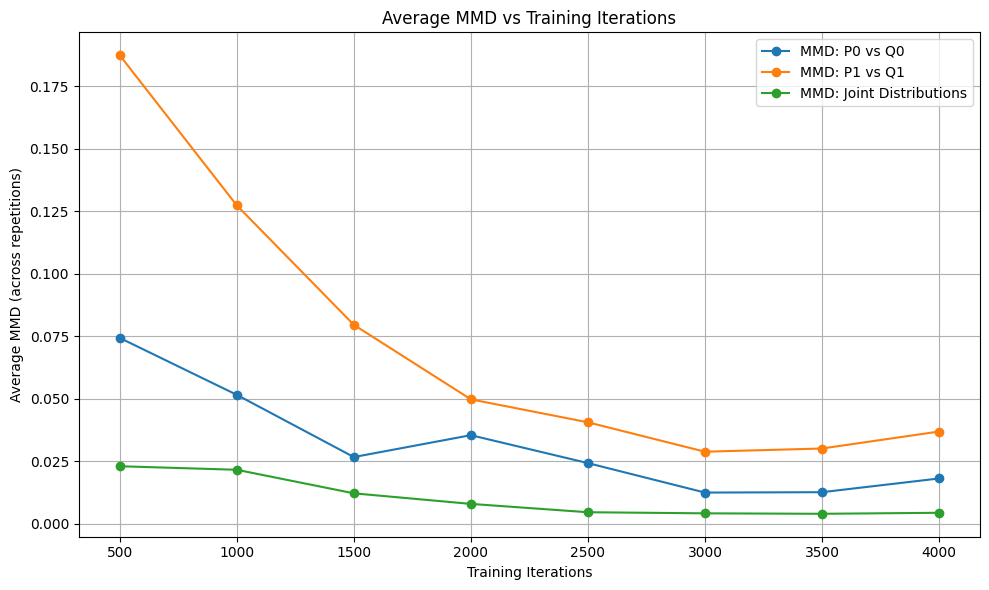

In [4]:
import matplotlib.pyplot as plt
import numpy as np

# Compute average MMD across repetitions for each iteration
iterations = list(tracker.keys())

# Extract averages
avg_mmd_p0_q0 = [np.mean(tracker[iteration]["mmd_p0_q0"]) for iteration in iterations]
avg_mmd_p1_q1 = [np.mean(tracker[iteration]["mmd_p1_q1"]) for iteration in iterations]
avg_mmd_joint = [np.mean(tracker[iteration]["mmd_joint"]) for iteration in iterations]

# Plot the results
plt.figure(figsize=(10, 6))

# MMD P0 vs Q0
plt.plot(iterations, avg_mmd_p0_q0, marker='o', label='MMD: P0 vs Q0')

# MMD P1 vs Q1
plt.plot(iterations, avg_mmd_p1_q1, marker='o', label='MMD: P1 vs Q1')

# MMD Joint Distributions
plt.plot(iterations, avg_mmd_joint, marker='o', label='MMD: Joint Distributions')

# Customization
plt.title('Average MMD vs Training Iterations')
plt.xlabel('Training Iterations')
plt.ylabel('Average MMD (across repetitions)')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Show plot
plt.show()


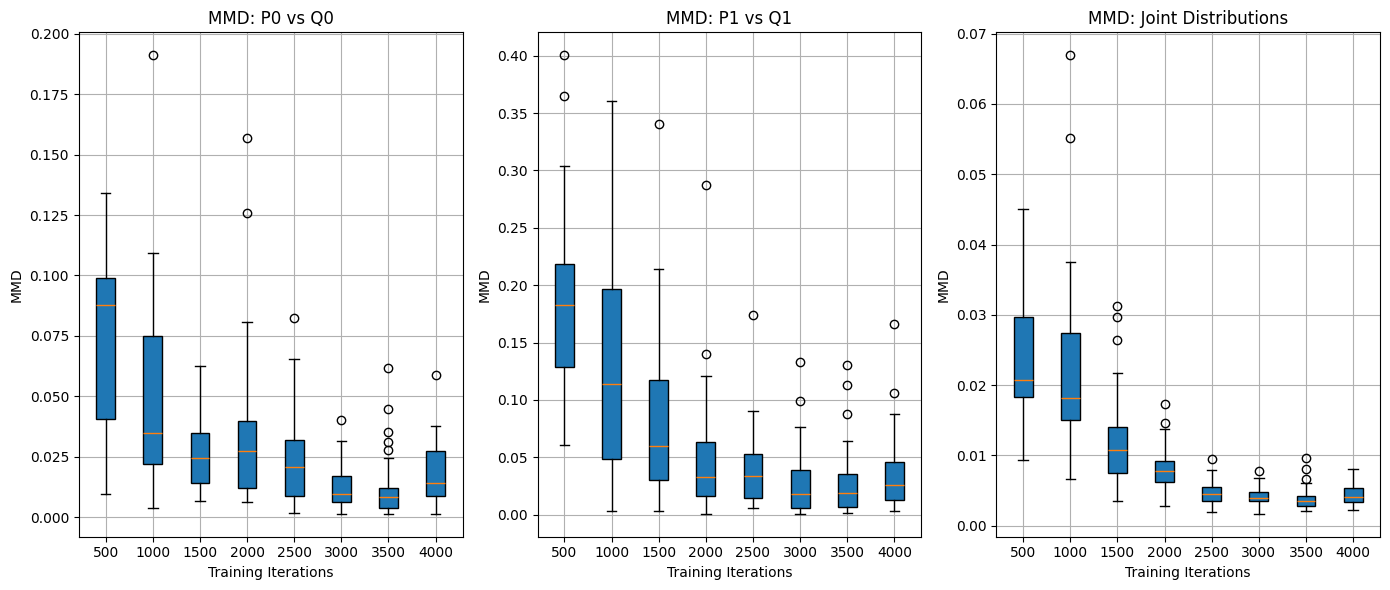

In [5]:
import matplotlib.pyplot as plt

# Extract MMD values for each iteration
iterations = list(tracker.keys())

mmd_p0_q0 = [tracker[iteration]["mmd_p0_q0"] for iteration in iterations]
mmd_p1_q1 = [tracker[iteration]["mmd_p1_q1"] for iteration in iterations]
mmd_joint = [tracker[iteration]["mmd_joint"] for iteration in iterations]

# Plot the boxplots
plt.figure(figsize=(14, 6))

# MMD P0 vs Q0
plt.subplot(1, 3, 1)
plt.boxplot(mmd_p0_q0, positions=iterations, widths=200, patch_artist=True)
plt.title('MMD: P0 vs Q0')
plt.xlabel('Training Iterations')
plt.ylabel('MMD')
plt.grid(True)

# MMD P1 vs Q1
plt.subplot(1, 3, 2)
plt.boxplot(mmd_p1_q1, positions=iterations, widths=200, patch_artist=True)
plt.title('MMD: P1 vs Q1')
plt.xlabel('Training Iterations')
plt.ylabel('MMD')
plt.grid(True)

# MMD Joint Distributions
plt.subplot(1, 3, 3)
plt.boxplot(mmd_joint, positions=iterations, widths=200, patch_artist=True)
plt.title('MMD: Joint Distributions')
plt.xlabel('Training Iterations')
plt.ylabel('MMD')
plt.grid(True)

plt.tight_layout()
plt.show()


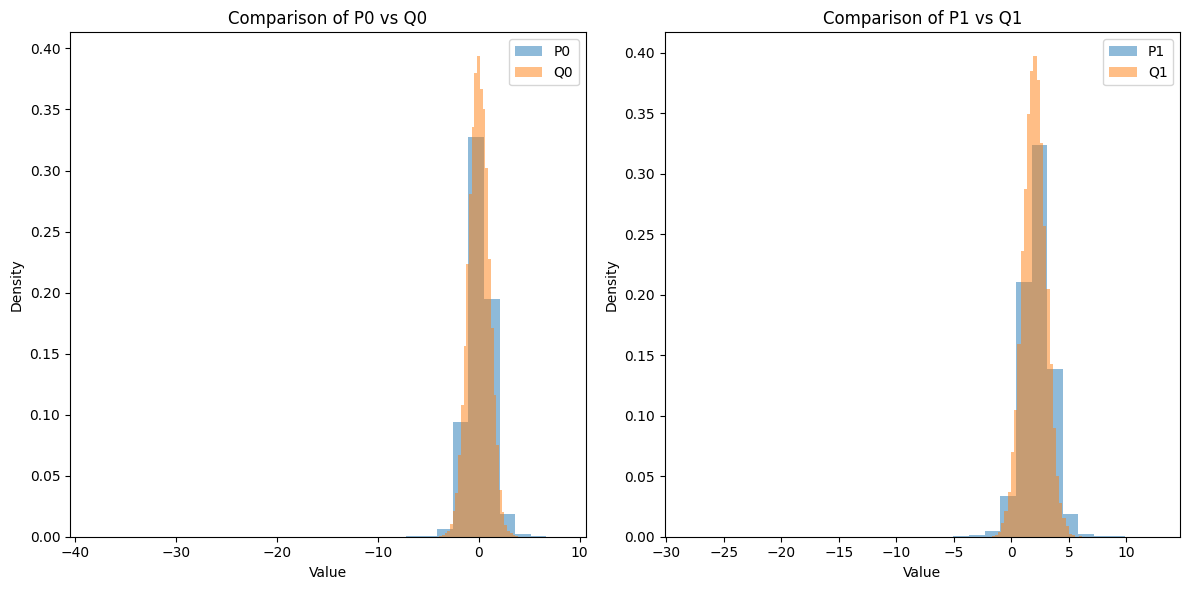

In [6]:
# Create histograms with overlapping bars
plt.figure(figsize=(12, 6))

# Plot P0 vs Q0
plt.subplot(1, 2, 1)
plt.hist(P0s.reshape(-1), bins=30, alpha=0.5, label='P0', density=True)
plt.hist(Q0s.reshape(-1), bins=30, alpha=0.5, label='Q0', density=True)
plt.title('Comparison of P0 vs Q0')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()

# Plot P1 vs Q1
plt.subplot(1, 2, 2)
plt.hist(P1s.reshape(-1), bins=30, alpha=0.5, label='P1', density=True)
plt.hist(Q1s.reshape(-1), bins=30, alpha=0.5, label='Q1', density=True)
plt.title('Comparison of P1 vs Q1')
plt.xlabel('Value')
plt.ylabel('Density')
plt.legend()

# Show plots
plt.tight_layout()
plt.show()

# With sparsity

In [5]:
nrep = 10  # Number of repetitions
n_tr = 1000  # Training sample size
n_p = 1000  # Testing sample size
nI_values = [5, 10, 20, 30]  # Different values of nI to iterate through
nX = 5
nO = 5
nS = 10
binary_intervention = True
num_iters = 4000  # Fixed number of training iterations

# Initialize tracker for nI
tracker = {nI: {"ate_p": [],"coeff_diff":[],"mmd_p0_q0": [], "mmd_p1_q1": [], "mmd_joint": [], "logreg_coeffs_p": [], "logreg_coeffs_q": []} 
           for nI in nI_values}

# Begin loop over nI
for nI in nI_values:
    print(f"Running experiments for nI = {nI}")
    p = nI + nX + nO + nS  # Update the number of covariates
    
    for rep in tqdm(range(nrep)):
        # Generate training and testing data
        df_tr = generate_data_causl(n=n_tr, nI=nI, nX=nX, nO=nO, nS=nS, ate=ate, 
                                    beta_cov=beta_cov, strength_instr=strength_instr, 
                                    strength_conf=strength_conf, 
                                    strength_outcome=strength_outcome, 
                                    binary_intervention=binary_intervention)
        z_tr = torch.tensor(df_tr[[f"X{i}" for i in range(1, p + 1)]].values, dtype=torch.float32)
        x_tr = torch.tensor(df_tr['A'].values, dtype=torch.int32).view(-1, 1) if binary_intervention else \
               torch.tensor(df_tr['A'].values, dtype=torch.float32).view(-1, 1)
        y_tr = torch.tensor(df_tr['y'].values, dtype=torch.float32).view(-1, 1)

        model = Frengression(x_tr.shape[1], y_tr.shape[1], z_tr.shape[1], 
                             noise_dim=1, num_layer=3, hidden_dim=400, 
                             device=device, x_binary=binary_intervention,z_binary_dims=0)
        
        df_q = generate_data_causl(n=n_p, nI=nI, nX=nX, nO=nO, nS=nS, ate=ate, 
                                    beta_cov=beta_cov, strength_instr=strength_instr, 
                                    strength_conf=strength_conf, 
                                    strength_outcome=strength_outcome, 
                                    binary_intervention=binary_intervention)
        
        z_q = torch.tensor(df_q[[f"X{i}" for i in range(1, p + 1)]].values, dtype=torch.float32)
        x_q = torch.tensor(df_q['A'].values, dtype=torch.int32).view(-1, 1) if binary_intervention else \
               torch.tensor(df_q['A'].values, dtype=torch.float32).view(-1, 1)
        y_q = torch.tensor(df_q['y'].values, dtype=torch.float32).view(-1, 1)

        # Ground truth distributions
        Q0 = np.random.normal(loc=0, scale=1, size=n_p).reshape([n_p, 1])
        Q1 = np.random.normal(loc=ate, scale=1, size=n_p).reshape([n_p, 1])
        Q_joint = torch.cat([x_q, y_q, z_q], dim=1).numpy()


        # Train model for fixed iterations
        model.train_xz(x_tr, z_tr, num_iters=num_iters, lr=1e-4, print_every_iter=400)
        model.train_y(x_tr, z_tr, y_tr, num_iters=num_iters, lr=1e-4, print_every_iter=400)

        # Sample model distributions
        P0 = (model.sample_causal_margin(torch.tensor([0], dtype=torch.int32), sample_size=n_p)).numpy().reshape(-1, 1)
        P1 = (model.sample_causal_margin(torch.tensor([1], dtype=torch.int32), sample_size=n_p)).numpy().reshape(-1, 1)
        x_gen, y_gen, z_gen = model.sample_joint(sample_size=n_p)
        P_joint = torch.cat([x_gen, y_gen, z_gen], dim=1).numpy()
        ate_p = np.mean(P1) - np.mean(P0)

        # Calculate MMD
        mmd_p0_q0 = mmd_rbf(P0, Q0, sigma=1.0)
        mmd_p1_q1 = mmd_rbf(P1, Q1, sigma=1.0)
        mmd_joint = mmd_rbf(P_joint, Q_joint, sigma=1.0)

        # Logistic regression for P
        logistic_model_p = LogisticRegression()
        logistic_model_p.fit(z_gen.numpy(), x_gen.numpy().ravel())
        logreg_coeffs_p = logistic_model_p.coef_

        # Logistic regression for Q
        logistic_model_q = LogisticRegression()
        logistic_model_q.fit(z_q.numpy(), x_q.numpy().ravel())
        logreg_coeffs_q = logistic_model_q.coef_
        coeff_diff = np.mean((logreg_coeffs_p - logreg_coeffs_q)**2)

        # Log results
        tracker[nI]["ate_p"].append(ate_p)
        tracker[nI]["coeff_diff"].append(coeff_diff)
        tracker[nI]["mmd_p0_q0"].append(mmd_p0_q0)
        tracker[nI]["mmd_p1_q1"].append(mmd_p1_q1)
        tracker[nI]["mmd_joint"].append(mmd_joint)
        tracker[nI]["logreg_coeffs_p"].append(logreg_coeffs_p)
        tracker[nI]["logreg_coeffs_q"].append(logreg_coeffs_q)


Running experiments for nI = 5


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1: loss 4.7650, loss1 5.0077, loss2 0.4855
Epoch 400: loss 3.5485, loss1 6.9928, loss2 6.8885
Epoch 800: loss 3.5474, loss1 7.0149, loss2 6.9348
Epoch 1200: loss 3.5271, loss1 7.0470, loss2 7.0400
Epoch 1600: loss 3.5435, loss1 7.0541, loss2 7.0212
Epoch 2000: loss 3.5091, loss1 7.0314, loss2 7.0445
Epoch 2400: loss 3.5177, loss1 7.0442, loss2 7.0531
Epoch 2800: loss 3.5177, loss1 7.0270, loss2 7.0186
Epoch 3200: loss 3.5528, loss1 7.0573, loss2 7.0089
Epoch 3600: loss 3.5099, loss1 7.0079, loss2 6.9961
Epoch 4000: loss 3.5125, loss1 7.0171, loss2 7.0091
Epoch 1: loss 2.4278,	loss_y 1.6375, 1.6469, 0.0188,	loss_eta 0.7903, 0.8300, 0.0793
Epoch 400: loss 1.8841,	loss_y 1.1096, 1.8095, 1.3998,	loss_eta 0.7744, 0.8077, 0.0666
Epoch 800: loss 1.1484,	loss_y 0.4594, 1.3272, 1.7356,	loss_eta 0.6889, 1.0944, 0.8110
Epoch 1200: loss 1.3701,	loss_y 0.5795, 1.1144, 1.0697,	loss_eta 0.7906, 0.8056, 0.0299
Epoch 1600: loss 1.1484,	loss_y 0.5041, 1.2382, 1.4682,	loss_eta 0.6443, 1.0444, 0.800

 10%|█         | 1/10 [01:19<11:55, 79.47s/it]

Epoch 4000: loss 0.9888,	loss_y 0.4306, 0.6946, 0.5279,	loss_eta 0.5582, 1.2139, 1.3115
Epoch 1: loss 4.7802, loss1 5.0222, loss2 0.4839
Epoch 400: loss 3.5797, loss1 7.0153, loss2 6.8713
Epoch 800: loss 3.5387, loss1 7.0303, loss2 6.9833
Epoch 1200: loss 3.5515, loss1 7.0320, loss2 6.9610
Epoch 1600: loss 3.5504, loss1 7.0587, loss2 7.0167
Epoch 2000: loss 3.5477, loss1 7.0817, loss2 7.0680
Epoch 2400: loss 3.5484, loss1 7.0642, loss2 7.0316
Epoch 2800: loss 3.5286, loss1 7.0422, loss2 7.0273
Epoch 3200: loss 3.4744, loss1 7.0317, loss2 7.1146
Epoch 3600: loss 3.5337, loss1 7.0546, loss2 7.0420
Epoch 4000: loss 3.5364, loss1 7.0135, loss2 6.9543
Epoch 1: loss 2.5246,	loss_y 1.7171, 1.7296, 0.0249,	loss_eta 0.8075, 0.8435, 0.0721
Epoch 400: loss 1.5496,	loss_y 0.7679, 1.8147, 2.0935,	loss_eta 0.7817, 0.7941, 0.0248
Epoch 800: loss 1.3887,	loss_y 0.6826, 1.7755, 2.1858,	loss_eta 0.7061, 0.8948, 0.3773
Epoch 1200: loss 1.1940,	loss_y 0.4916, 0.9562, 0.9292,	loss_eta 0.7024, 0.8789, 0.352

 20%|██        | 2/10 [02:25<09:31, 71.42s/it]

Epoch 4000: loss 0.7922,	loss_y 0.2090, 0.4982, 0.5785,	loss_eta 0.5832, 1.1311, 1.0959
Epoch 1: loss 4.7814, loss1 5.0264, loss2 0.4899
Epoch 400: loss 3.5848, loss1 7.0206, loss2 6.8717
Epoch 800: loss 3.5584, loss1 7.0155, loss2 6.9142
Epoch 1200: loss 3.5357, loss1 7.0390, loss2 7.0067
Epoch 1600: loss 3.5692, loss1 7.0852, loss2 7.0320
Epoch 2000: loss 3.5214, loss1 7.0339, loss2 7.0250
Epoch 2400: loss 3.5389, loss1 7.0721, loss2 7.0663
Epoch 2800: loss 3.5416, loss1 7.0447, loss2 7.0063
Epoch 3200: loss 3.4964, loss1 7.0457, loss2 7.0987
Epoch 3600: loss 3.5408, loss1 7.0613, loss2 7.0410
Epoch 4000: loss 3.5514, loss1 7.0871, loss2 7.0714
Epoch 1: loss 2.5152,	loss_y 1.7439, 1.7571, 0.0264,	loss_eta 0.7713, 0.8014, 0.0602
Epoch 400: loss 1.4262,	loss_y 0.6335, 1.4096, 1.5522,	loss_eta 0.7927, 0.8141, 0.0427
Epoch 800: loss 1.5909,	loss_y 0.8218, 1.3196, 0.9956,	loss_eta 0.7691, 0.8724, 0.2065
Epoch 1200: loss 1.1589,	loss_y 0.5310, 1.1256, 1.1892,	loss_eta 0.6280, 1.0784, 0.900

 30%|███       | 3/10 [03:31<08:04, 69.20s/it]

Epoch 4000: loss 1.0398,	loss_y 0.4180, 0.7046, 0.5733,	loss_eta 0.6219, 1.1825, 1.1214
Epoch 1: loss 4.7341, loss1 4.9775, loss2 0.4867
Epoch 400: loss 3.5227, loss1 6.9370, loss2 6.8287
Epoch 800: loss 3.4887, loss1 6.9612, loss2 6.9450
Epoch 1200: loss 3.4788, loss1 6.9575, loss2 6.9573
Epoch 1600: loss 3.5038, loss1 6.9592, loss2 6.9108
Epoch 2000: loss 3.4800, loss1 6.9434, loss2 6.9270
Epoch 2400: loss 3.4862, loss1 6.9891, loss2 7.0058
Epoch 2800: loss 3.5066, loss1 7.0059, loss2 6.9988
Epoch 3200: loss 3.5003, loss1 6.9959, loss2 6.9914
Epoch 3600: loss 3.4966, loss1 7.0069, loss2 7.0206
Epoch 4000: loss 3.4829, loss1 6.9875, loss2 7.0093
Epoch 1: loss 2.4426,	loss_y 1.6657, 1.6979, 0.0644,	loss_eta 0.7769, 0.8125, 0.0712
Epoch 400: loss 1.4151,	loss_y 0.6192, 1.7919, 2.3453,	loss_eta 0.7959, 0.8436, 0.0954
Epoch 800: loss 1.3218,	loss_y 0.6889, 1.1516, 0.9253,	loss_eta 0.6329, 1.0931, 0.9204
Epoch 1200: loss 1.1087,	loss_y 0.5527, 1.2882, 1.4709,	loss_eta 0.5560, 1.0534, 0.994

 40%|████      | 4/10 [04:38<06:48, 68.13s/it]

Epoch 4000: loss 0.8149,	loss_y 0.2296, 0.4687, 0.4783,	loss_eta 0.5853, 1.0330, 0.8954
Epoch 1: loss 4.8061, loss1 5.0369, loss2 0.4616
Epoch 400: loss 3.5700, loss1 7.0288, loss2 6.9176
Epoch 800: loss 3.5539, loss1 7.0432, loss2 6.9785
Epoch 1200: loss 3.5702, loss1 7.0888, loss2 7.0371
Epoch 1600: loss 3.5469, loss1 7.0856, loss2 7.0775
Epoch 2000: loss 3.5590, loss1 7.0746, loss2 7.0312
Epoch 2400: loss 3.5435, loss1 7.0826, loss2 7.0782
Epoch 2800: loss 3.5736, loss1 7.0968, loss2 7.0464
Epoch 3200: loss 3.5529, loss1 7.0873, loss2 7.0687
Epoch 3600: loss 3.5732, loss1 7.0593, loss2 6.9723
Epoch 4000: loss 3.5610, loss1 7.0927, loss2 7.0633
Epoch 1: loss 2.4261,	loss_y 1.6844, 1.7441, 0.1193,	loss_eta 0.7417, 0.7807, 0.0780
Epoch 400: loss 1.8588,	loss_y 0.8703, 2.0281, 2.3156,	loss_eta 0.9885, 1.1898, 0.4026
Epoch 800: loss 1.2119,	loss_y 0.5582, 1.1840, 1.2516,	loss_eta 0.6537, 0.8574, 0.4075
Epoch 1200: loss 1.3242,	loss_y 0.7262, 1.1030, 0.7537,	loss_eta 0.5981, 1.1034, 1.010

 50%|█████     | 5/10 [05:45<05:38, 67.64s/it]

Epoch 4000: loss 0.9795,	loss_y 0.3503, 0.7407, 0.7808,	loss_eta 0.6292, 1.0915, 0.9247
Epoch 1: loss 4.7582, loss1 5.0080, loss2 0.4996
Epoch 400: loss 3.5388, loss1 6.9765, loss2 6.8753
Epoch 800: loss 3.5225, loss1 7.0056, loss2 6.9662
Epoch 1200: loss 3.5669, loss1 7.0399, loss2 6.9461
Epoch 1600: loss 3.5305, loss1 7.0358, loss2 7.0105
Epoch 2000: loss 3.5115, loss1 7.0503, loss2 7.0775
Epoch 2400: loss 3.5314, loss1 6.9863, loss2 6.9098
Epoch 2800: loss 3.4826, loss1 7.0126, loss2 7.0601
Epoch 3200: loss 3.4973, loss1 7.0110, loss2 7.0273
Epoch 3600: loss 3.4972, loss1 6.9731, loss2 6.9519
Epoch 4000: loss 3.5239, loss1 7.0419, loss2 7.0358
Epoch 1: loss 2.5013,	loss_y 1.7164, 1.7345, 0.0362,	loss_eta 0.7849, 0.8233, 0.0768
Epoch 400: loss 1.3734,	loss_y 0.5487, 1.6503, 2.2033,	loss_eta 0.8247, 0.8425, 0.0355
Epoch 800: loss 1.4906,	loss_y 0.7946, 2.0482, 2.5072,	loss_eta 0.6960, 0.9916, 0.5912
Epoch 1200: loss 1.2677,	loss_y 0.5645, 1.0889, 1.0487,	loss_eta 0.7032, 0.8862, 0.366

 60%|██████    | 6/10 [06:52<04:29, 67.46s/it]

Epoch 4000: loss 0.9613,	loss_y 0.3589, 0.6671, 0.6164,	loss_eta 0.6025, 0.9672, 0.7295
Epoch 1: loss 4.7344, loss1 4.9699, loss2 0.4709
Epoch 400: loss 3.5279, loss1 6.9280, loss2 6.8004
Epoch 800: loss 3.5522, loss1 6.9815, loss2 6.8587
Epoch 1200: loss 3.4955, loss1 6.9763, loss2 6.9616
Epoch 1600: loss 3.4816, loss1 6.9648, loss2 6.9664
Epoch 2000: loss 3.4670, loss1 6.9342, loss2 6.9344
Epoch 2400: loss 3.4902, loss1 6.9656, loss2 6.9509
Epoch 2800: loss 3.5035, loss1 6.9760, loss2 6.9450
Epoch 3200: loss 3.5139, loss1 6.9954, loss2 6.9628
Epoch 3600: loss 3.4763, loss1 7.0025, loss2 7.0525
Epoch 4000: loss 3.5020, loss1 6.9663, loss2 6.9287
Epoch 1: loss 2.3936,	loss_y 1.6231, 1.6569, 0.0675,	loss_eta 0.7705, 0.8048, 0.0687
Epoch 400: loss 1.9469,	loss_y 1.1115, 2.4900, 2.7570,	loss_eta 0.8354, 0.8490, 0.0274
Epoch 800: loss 1.2198,	loss_y 0.6019, 1.1749, 1.1461,	loss_eta 0.6179, 1.2018, 1.1678
Epoch 1200: loss 1.0343,	loss_y 0.4456, 1.2184, 1.5457,	loss_eta 0.5887, 1.1008, 1.024

 70%|███████   | 7/10 [07:59<03:21, 67.25s/it]

Epoch 4000: loss 0.8939,	loss_y 0.2756, 0.6636, 0.7760,	loss_eta 0.6183, 1.2419, 1.2472
Epoch 1: loss 4.7694, loss1 5.0121, loss2 0.4854
Epoch 400: loss 3.5243, loss1 6.9873, loss2 6.9261
Epoch 800: loss 3.5314, loss1 7.0007, loss2 6.9387
Epoch 1200: loss 3.5435, loss1 7.0557, loss2 7.0244
Epoch 1600: loss 3.5357, loss1 7.0461, loss2 7.0206
Epoch 2000: loss 3.5130, loss1 7.0243, loss2 7.0226
Epoch 2400: loss 3.5363, loss1 7.0553, loss2 7.0381
Epoch 2800: loss 3.5220, loss1 7.0427, loss2 7.0413
Epoch 3200: loss 3.5403, loss1 7.0797, loss2 7.0788
Epoch 3600: loss 3.5376, loss1 7.0404, loss2 7.0055
Epoch 4000: loss 3.5135, loss1 7.0329, loss2 7.0388
Epoch 1: loss 2.5552,	loss_y 1.7531, 1.7651, 0.0239,	loss_eta 0.8021, 0.8308, 0.0574
Epoch 400: loss 1.7414,	loss_y 0.9423, 1.6991, 1.5136,	loss_eta 0.7991, 0.8072, 0.0163
Epoch 800: loss 1.7156,	loss_y 0.9793, 1.9370, 1.9153,	loss_eta 0.7363, 0.8308, 0.1890
Epoch 1200: loss 1.1829,	loss_y 0.5234, 1.2551, 1.4634,	loss_eta 0.6595, 0.8921, 0.465

 80%|████████  | 8/10 [09:04<02:13, 66.71s/it]

Epoch 4000: loss 0.9107,	loss_y 0.3593, 0.7207, 0.7228,	loss_eta 0.5514, 1.1610, 1.2192
Epoch 1: loss 4.7795, loss1 5.0230, loss2 0.4870
Epoch 400: loss 3.5473, loss1 7.0030, loss2 6.9112
Epoch 800: loss 3.5944, loss1 7.0760, loss2 6.9633
Epoch 1200: loss 3.5758, loss1 7.0295, loss2 6.9073
Epoch 1600: loss 3.5350, loss1 7.0453, loss2 7.0206
Epoch 2000: loss 3.5379, loss1 7.0473, loss2 7.0189
Epoch 2400: loss 3.5462, loss1 7.0696, loss2 7.0469
Epoch 2800: loss 3.5617, loss1 7.0578, loss2 6.9923
Epoch 3200: loss 3.5443, loss1 7.0561, loss2 7.0236
Epoch 3600: loss 3.5618, loss1 7.0660, loss2 7.0084
Epoch 4000: loss 3.5433, loss1 7.0744, loss2 7.0621
Epoch 1: loss 2.5232,	loss_y 1.7274, 1.7616, 0.0682,	loss_eta 0.7958, 0.8301, 0.0686
Epoch 400: loss 1.3032,	loss_y 0.5736, 1.8382, 2.5293,	loss_eta 0.7297, 0.7969, 0.1346
Epoch 800: loss 1.3004,	loss_y 0.6547, 1.3648, 1.4202,	loss_eta 0.6457, 0.8479, 0.4045
Epoch 1200: loss 1.4147,	loss_y 0.8091, 1.3469, 1.0757,	loss_eta 0.6057, 1.2128, 1.214

 90%|█████████ | 9/10 [10:09<01:06, 66.29s/it]

Epoch 4000: loss 0.8525,	loss_y 0.2862, 0.4952, 0.4179,	loss_eta 0.5663, 1.0761, 1.0196
Epoch 1: loss 4.7687, loss1 5.0075, loss2 0.4774
Epoch 400: loss 3.5404, loss1 7.0457, loss2 7.0106
Epoch 800: loss 3.5882, loss1 7.0442, loss2 6.9121
Epoch 1200: loss 3.5428, loss1 7.0613, loss2 7.0371
Epoch 1600: loss 3.5559, loss1 7.0291, loss2 6.9463
Epoch 2000: loss 3.5419, loss1 7.0216, loss2 6.9595
Epoch 2400: loss 3.5549, loss1 7.0641, loss2 7.0185
Epoch 2800: loss 3.5688, loss1 7.0777, loss2 7.0177
Epoch 3200: loss 3.5510, loss1 7.0572, loss2 7.0123
Epoch 3600: loss 3.5304, loss1 7.0454, loss2 7.0301
Epoch 4000: loss 3.5075, loss1 7.0005, loss2 6.9861
Epoch 1: loss 2.4357,	loss_y 1.6836, 1.6995, 0.0319,	loss_eta 0.7521, 0.7934, 0.0827
Epoch 400: loss 1.3088,	loss_y 0.5134, 1.2794, 1.5320,	loss_eta 0.7954, 0.7985, 0.0063
Epoch 800: loss 1.6841,	loss_y 0.8931, 1.5506, 1.3151,	loss_eta 0.7909, 0.8341, 0.0863
Epoch 1200: loss 1.2775,	loss_y 0.5672, 1.5127, 1.8910,	loss_eta 0.7103, 0.8740, 0.327

100%|██████████| 10/10 [11:15<00:00, 67.60s/it]


Epoch 4000: loss 0.9332,	loss_y 0.3054, 0.5995, 0.5883,	loss_eta 0.6278, 1.0566, 0.8577
Running experiments for nI = 10


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1: loss 5.1925, loss1 5.4641, loss2 0.5433
Epoch 400: loss 3.8644, loss1 7.6649, loss2 7.6011
Epoch 800: loss 3.8529, loss1 7.6452, loss2 7.5846
Epoch 1200: loss 3.8216, loss1 7.6408, loss2 7.6383
Epoch 1600: loss 3.8418, loss1 7.6475, loss2 7.6115
Epoch 2000: loss 3.8476, loss1 7.6907, loss2 7.6863
Epoch 2400: loss 3.8732, loss1 7.7131, loss2 7.6799
Epoch 2800: loss 3.8794, loss1 7.6889, loss2 7.6189
Epoch 3200: loss 3.8437, loss1 7.6642, loss2 7.6410
Epoch 3600: loss 3.8474, loss1 7.6539, loss2 7.6130
Epoch 4000: loss 3.8122, loss1 7.6698, loss2 7.7152
Epoch 1: loss 2.3544,	loss_y 1.5937, 1.6247, 0.0621,	loss_eta 0.7607, 0.8018, 0.0823
Epoch 400: loss 1.7226,	loss_y 1.0306, 2.4417, 2.8223,	loss_eta 0.6920, 0.8775, 0.3711
Epoch 800: loss 1.2670,	loss_y 0.6743, 1.8639, 2.3792,	loss_eta 0.5927, 1.0791, 0.9728
Epoch 1200: loss 1.1561,	loss_y 0.5551, 0.9737, 0.8373,	loss_eta 0.6010, 1.1845, 1.1670
Epoch 1600: loss 0.9492,	loss_y 0.3790, 0.8800, 1.0021,	loss_eta 0.5702, 1.1406, 1.140

 10%|█         | 1/10 [01:06<09:55, 66.21s/it]

Epoch 4000: loss 0.8264,	loss_y 0.2721, 0.4887, 0.4334,	loss_eta 0.5544, 1.1168, 1.1247
Epoch 1: loss 5.2671, loss1 5.5256, loss2 0.5169
Epoch 400: loss 3.9356, loss1 7.7280, loss2 7.5848
Epoch 800: loss 3.8940, loss1 7.7813, loss2 7.7745
Epoch 1200: loss 3.8869, loss1 7.7285, loss2 7.6832
Epoch 1600: loss 3.9037, loss1 7.7706, loss2 7.7338
Epoch 2000: loss 3.9084, loss1 7.7451, loss2 7.6734
Epoch 2400: loss 3.8551, loss1 7.7538, loss2 7.7975
Epoch 2800: loss 3.9005, loss1 7.7898, loss2 7.7786
Epoch 3200: loss 3.9011, loss1 7.7535, loss2 7.7049
Epoch 3600: loss 3.8738, loss1 7.7558, loss2 7.7639
Epoch 4000: loss 3.8731, loss1 7.7640, loss2 7.7818
Epoch 1: loss 2.5225,	loss_y 1.7444, 1.7664, 0.0440,	loss_eta 0.7781, 0.8121, 0.0681
Epoch 400: loss 1.7476,	loss_y 1.0254, 2.6526, 3.2543,	loss_eta 0.7222, 0.7956, 0.1468
Epoch 800: loss 1.4299,	loss_y 0.8071, 2.4594, 3.3046,	loss_eta 0.6228, 0.9575, 0.6694
Epoch 1200: loss 1.1884,	loss_y 0.6058, 1.3107, 1.4098,	loss_eta 0.5826, 1.3047, 1.444

 20%|██        | 2/10 [02:12<08:52, 66.51s/it]

Epoch 4000: loss 0.8179,	loss_y 0.2165, 0.5729, 0.7127,	loss_eta 0.6014, 1.4852, 1.7677
Epoch 1: loss 5.2381, loss1 5.4995, loss2 0.5229
Epoch 400: loss 3.8949, loss1 7.6554, loss2 7.5209
Epoch 800: loss 3.9138, loss1 7.7237, loss2 7.6199
Epoch 1200: loss 3.8653, loss1 7.7309, loss2 7.7313
Epoch 1600: loss 3.8876, loss1 7.7014, loss2 7.6277
Epoch 2000: loss 3.8771, loss1 7.7353, loss2 7.7162
Epoch 2400: loss 3.9332, loss1 7.7389, loss2 7.6112
Epoch 2800: loss 3.9053, loss1 7.7313, loss2 7.6519
Epoch 3200: loss 3.8960, loss1 7.7487, loss2 7.7054
Epoch 3600: loss 3.8750, loss1 7.7486, loss2 7.7471
Epoch 4000: loss 3.8781, loss1 7.7509, loss2 7.7457
Epoch 1: loss 2.3755,	loss_y 1.6341, 1.6495, 0.0309,	loss_eta 0.7415, 0.7834, 0.0839
Epoch 400: loss 1.4231,	loss_y 0.6377, 1.5584, 1.8415,	loss_eta 0.7854, 0.8236, 0.0763
Epoch 800: loss 1.1656,	loss_y 0.5520, 0.9610, 0.8180,	loss_eta 0.6137, 1.0999, 0.9724
Epoch 1200: loss 1.2272,	loss_y 0.6289, 0.8151, 0.3725,	loss_eta 0.5983, 1.0591, 0.921

 30%|███       | 3/10 [03:19<07:44, 66.40s/it]

Epoch 4000: loss 0.8327,	loss_y 0.2204, 0.5254, 0.6100,	loss_eta 0.6124, 1.3348, 1.4448
Epoch 1: loss 5.2250, loss1 5.4823, loss2 0.5145
Epoch 400: loss 3.8708, loss1 7.6575, loss2 7.5734
Epoch 800: loss 3.8802, loss1 7.6855, loss2 7.6105
Epoch 1200: loss 3.8444, loss1 7.6709, loss2 7.6529
Epoch 1600: loss 3.8684, loss1 7.6936, loss2 7.6504
Epoch 2000: loss 3.8819, loss1 7.6784, loss2 7.5930
Epoch 2400: loss 3.8750, loss1 7.7154, loss2 7.6810
Epoch 2800: loss 3.8322, loss1 7.7028, loss2 7.7411
Epoch 3200: loss 3.8402, loss1 7.7187, loss2 7.7569
Epoch 3600: loss 3.8480, loss1 7.7095, loss2 7.7230
Epoch 4000: loss 3.8442, loss1 7.6857, loss2 7.6829
Epoch 1: loss 2.4050,	loss_y 1.6248, 1.6511, 0.0527,	loss_eta 0.7803, 0.8165, 0.0725
Epoch 400: loss 2.0580,	loss_y 1.3031, 2.9564, 3.3065,	loss_eta 0.7549, 0.7790, 0.0483
Epoch 800: loss 1.3469,	loss_y 0.7766, 1.9891, 2.4251,	loss_eta 0.5703, 1.4308, 1.7209
Epoch 1200: loss 0.8490,	loss_y 0.3219, 0.8245, 1.0051,	loss_eta 0.5270, 1.1539, 1.253

 40%|████      | 4/10 [04:26<06:39, 66.57s/it]

Epoch 4000: loss 0.8380,	loss_y 0.2404, 0.5733, 0.6657,	loss_eta 0.5976, 1.3067, 1.4184
Epoch 1: loss 5.2236, loss1 5.4705, loss2 0.4937
Epoch 400: loss 3.9039, loss1 7.6711, loss2 7.5343
Epoch 800: loss 3.8723, loss1 7.7040, loss2 7.6634
Epoch 1200: loss 3.9067, loss1 7.7133, loss2 7.6132
Epoch 1600: loss 3.8605, loss1 7.7049, loss2 7.6887
Epoch 2000: loss 3.8776, loss1 7.7054, loss2 7.6555
Epoch 2400: loss 3.9010, loss1 7.7204, loss2 7.6389
Epoch 2800: loss 3.8848, loss1 7.6855, loss2 7.6014
Epoch 3200: loss 3.8601, loss1 7.7164, loss2 7.7125
Epoch 3600: loss 3.8407, loss1 7.6546, loss2 7.6278
Epoch 4000: loss 3.8594, loss1 7.6869, loss2 7.6550
Epoch 1: loss 2.3674,	loss_y 1.6075, 1.6230, 0.0310,	loss_eta 0.7599, 0.8009, 0.0819
Epoch 400: loss 1.3044,	loss_y 0.6733, 1.7327, 2.1188,	loss_eta 0.6311, 0.9323, 0.6024
Epoch 800: loss 1.0981,	loss_y 0.4576, 0.7251, 0.5349,	loss_eta 0.6405, 0.8011, 0.3213
Epoch 1200: loss 1.4261,	loss_y 0.8217, 1.5933, 1.5433,	loss_eta 0.6044, 1.1426, 1.076

 50%|█████     | 5/10 [05:32<05:33, 66.64s/it]

Epoch 4000: loss 0.8806,	loss_y 0.2446, 0.4919, 0.4947,	loss_eta 0.6360, 1.2476, 1.2231
Epoch 1: loss 5.2312, loss1 5.4944, loss2 0.5263
Epoch 400: loss 3.9149, loss1 7.7324, loss2 7.6349
Epoch 800: loss 3.8316, loss1 7.6658, loss2 7.6684
Epoch 1200: loss 3.9060, loss1 7.6886, loss2 7.5652
Epoch 1600: loss 3.8114, loss1 7.6855, loss2 7.7482
Epoch 2000: loss 3.8453, loss1 7.7061, loss2 7.7217
Epoch 2400: loss 3.8713, loss1 7.7053, loss2 7.6680
Epoch 2800: loss 3.8806, loss1 7.6790, loss2 7.5968
Epoch 3200: loss 3.8489, loss1 7.6486, loss2 7.5996
Epoch 3600: loss 3.8760, loss1 7.7258, loss2 7.6996
Epoch 4000: loss 3.8641, loss1 7.7290, loss2 7.7298
Epoch 1: loss 2.3906,	loss_y 1.6138, 1.6236, 0.0197,	loss_eta 0.7768, 0.8176, 0.0814
Epoch 400: loss 1.4598,	loss_y 0.7162, 1.2941, 1.1558,	loss_eta 0.7436, 0.8021, 0.1171
Epoch 800: loss 1.0948,	loss_y 0.4748, 1.0749, 1.2002,	loss_eta 0.6199, 1.1960, 1.1520
Epoch 1200: loss 1.1087,	loss_y 0.4416, 0.8888, 0.8943,	loss_eta 0.6670, 1.2696, 1.205

 60%|██████    | 6/10 [06:43<04:32, 68.13s/it]

Epoch 4000: loss 0.8178,	loss_y 0.2578, 0.4989, 0.4822,	loss_eta 0.5600, 1.0717, 1.0235
Epoch 1: loss 5.2531, loss1 5.5021, loss2 0.4979
Epoch 400: loss 3.9353, loss1 7.6987, loss2 7.5268
Epoch 800: loss 3.8669, loss1 7.6619, loss2 7.5901
Epoch 1200: loss 3.8909, loss1 7.7327, loss2 7.6836
Epoch 1600: loss 3.8820, loss1 7.7603, loss2 7.7566
Epoch 2000: loss 3.8966, loss1 7.7697, loss2 7.7461
Epoch 2400: loss 3.8597, loss1 7.7285, loss2 7.7377
Epoch 2800: loss 3.8673, loss1 7.6997, loss2 7.6648
Epoch 3200: loss 3.8701, loss1 7.7290, loss2 7.7178
Epoch 3600: loss 3.8777, loss1 7.7102, loss2 7.6649
Epoch 4000: loss 3.8721, loss1 7.7374, loss2 7.7307
Epoch 1: loss 2.4835,	loss_y 1.6780, 1.6855, 0.0152,	loss_eta 0.8056, 0.8376, 0.0640
Epoch 400: loss 1.8327,	loss_y 1.1212, 2.8030, 3.3636,	loss_eta 0.7115, 0.7954, 0.1678
Epoch 800: loss 1.1340,	loss_y 0.5315, 1.4612, 1.8594,	loss_eta 0.6025, 1.0753, 0.9456
Epoch 1200: loss 1.0224,	loss_y 0.4439, 1.2583, 1.6287,	loss_eta 0.5784, 1.1755, 1.194

 70%|███████   | 7/10 [07:54<03:27, 69.09s/it]

Epoch 4000: loss 0.8606,	loss_y 0.2836, 0.6002, 0.6332,	loss_eta 0.5770, 1.0820, 1.0099
Epoch 1: loss 5.2421, loss1 5.5016, loss2 0.5191
Epoch 400: loss 3.8829, loss1 7.6593, loss2 7.5529
Epoch 800: loss 3.8732, loss1 7.7415, loss2 7.7366
Epoch 1200: loss 3.8774, loss1 7.7308, loss2 7.7069
Epoch 1600: loss 3.8601, loss1 7.6953, loss2 7.6703
Epoch 2000: loss 3.8891, loss1 7.7058, loss2 7.6336
Epoch 2400: loss 3.8763, loss1 7.7107, loss2 7.6687
Epoch 2800: loss 3.8524, loss1 7.6992, loss2 7.6936
Epoch 3200: loss 3.8564, loss1 7.6917, loss2 7.6707
Epoch 3600: loss 3.8581, loss1 7.7350, loss2 7.7537
Epoch 4000: loss 3.8434, loss1 7.7010, loss2 7.7152
Epoch 1: loss 2.5022,	loss_y 1.7009, 1.7157, 0.0295,	loss_eta 0.8013, 0.8405, 0.0783
Epoch 400: loss 1.5765,	loss_y 0.8836, 1.1869, 0.6066,	loss_eta 0.6929, 0.8031, 0.2205
Epoch 800: loss 1.1877,	loss_y 0.5541, 1.0830, 1.0578,	loss_eta 0.6336, 0.7962, 0.3252
Epoch 1200: loss 1.2809,	loss_y 0.6824, 1.1976, 1.0303,	loss_eta 0.5985, 1.0573, 0.917

 80%|████████  | 8/10 [09:03<02:17, 68.90s/it]

Epoch 4000: loss 0.8497,	loss_y 0.2473, 0.5884, 0.6821,	loss_eta 0.6024, 1.1851, 1.1654
Epoch 1: loss 5.2173, loss1 5.4890, loss2 0.5436
Epoch 400: loss 3.9163, loss1 7.7169, loss2 7.6013
Epoch 800: loss 3.8766, loss1 7.7132, loss2 7.6732
Epoch 1200: loss 3.9139, loss1 7.7300, loss2 7.6323
Epoch 1600: loss 3.8398, loss1 7.6969, loss2 7.7143
Epoch 2000: loss 3.8830, loss1 7.7020, loss2 7.6380
Epoch 2400: loss 3.8972, loss1 7.7278, loss2 7.6613
Epoch 2800: loss 3.8618, loss1 7.7298, loss2 7.7360
Epoch 3200: loss 3.8583, loss1 7.7385, loss2 7.7605
Epoch 3600: loss 3.8932, loss1 7.7677, loss2 7.7488
Epoch 4000: loss 3.8338, loss1 7.7016, loss2 7.7356
Epoch 1: loss 2.4333,	loss_y 1.6658, 1.6955, 0.0594,	loss_eta 0.7675, 0.8135, 0.0921
Epoch 400: loss 2.0839,	loss_y 1.3798, 2.7391, 2.7186,	loss_eta 0.7041, 0.7858, 0.1635
Epoch 800: loss 1.1149,	loss_y 0.5544, 1.3436, 1.5785,	loss_eta 0.5605, 1.3643, 1.6076
Epoch 1200: loss 1.1682,	loss_y 0.5375, 1.2283, 1.3816,	loss_eta 0.6307, 1.1133, 0.965

 90%|█████████ | 9/10 [10:14<01:09, 69.70s/it]

Epoch 4000: loss 0.7440,	loss_y 0.1737, 0.3833, 0.4193,	loss_eta 0.5703, 1.0928, 1.0451
Epoch 1: loss 5.1986, loss1 5.4703, loss2 0.5434
Epoch 400: loss 3.9225, loss1 7.6806, loss2 7.5161
Epoch 800: loss 3.8992, loss1 7.6697, loss2 7.5410
Epoch 1200: loss 3.8721, loss1 7.6327, loss2 7.5212
Epoch 1600: loss 3.8554, loss1 7.6688, loss2 7.6267
Epoch 2000: loss 3.8868, loss1 7.7048, loss2 7.6360
Epoch 2400: loss 3.8388, loss1 7.6778, loss2 7.6781
Epoch 2800: loss 3.8213, loss1 7.6776, loss2 7.7125
Epoch 3200: loss 3.8586, loss1 7.6930, loss2 7.6689
Epoch 3600: loss 3.8613, loss1 7.6310, loss2 7.5394
Epoch 4000: loss 3.8766, loss1 7.6909, loss2 7.6287
Epoch 1: loss 2.4113,	loss_y 1.6181, 1.6566, 0.0770,	loss_eta 0.7932, 0.8303, 0.0742
Epoch 400: loss 1.4648,	loss_y 0.7075, 1.6137, 1.8122,	loss_eta 0.7572, 0.8431, 0.1718
Epoch 800: loss 1.1343,	loss_y 0.5484, 0.8627, 0.6285,	loss_eta 0.5859, 1.0086, 0.8453
Epoch 1200: loss 1.2044,	loss_y 0.6424, 1.4913, 1.6978,	loss_eta 0.5620, 0.9913, 0.858

100%|██████████| 10/10 [11:29<00:00, 69.00s/it]


Epoch 4000: loss 1.0274,	loss_y 0.4366, 0.8687, 0.8642,	loss_eta 0.5907, 1.2423, 1.3031
Running experiments for nI = 20


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1: loss 6.0532, loss1 6.3563, loss2 0.6062
Epoch 400: loss 4.5073, loss1 8.8969, loss2 8.7792
Epoch 800: loss 4.4794, loss1 8.8711, loss2 8.7833
Epoch 1200: loss 4.4882, loss1 8.8909, loss2 8.8054
Epoch 1600: loss 4.5132, loss1 8.9130, loss2 8.7995
Epoch 2000: loss 4.5217, loss1 8.9714, loss2 8.8993
Epoch 2400: loss 4.5212, loss1 8.9390, loss2 8.8357
Epoch 2800: loss 4.4406, loss1 8.9208, loss2 8.9603
Epoch 3200: loss 4.4893, loss1 8.8777, loss2 8.7769
Epoch 3600: loss 4.4924, loss1 8.9006, loss2 8.8164
Epoch 4000: loss 4.5246, loss1 8.9771, loss2 8.9050
Epoch 1: loss 2.3296,	loss_y 1.5502, 1.5669, 0.0333,	loss_eta 0.7794, 0.8142, 0.0697
Epoch 400: loss 1.8742,	loss_y 1.1344, 2.0776, 1.8865,	loss_eta 0.7398, 0.8442, 0.2088
Epoch 800: loss 1.2493,	loss_y 0.6195, 1.1435, 1.0480,	loss_eta 0.6298, 1.1498, 1.0401
Epoch 1200: loss 1.5108,	loss_y 0.9319, 1.4447, 1.0256,	loss_eta 0.5789, 1.1452, 1.1328
Epoch 1600: loss 1.1422,	loss_y 0.5401, 1.0798, 1.0795,	loss_eta 0.6021, 1.5026, 1.800

 10%|█         | 1/10 [01:10<10:30, 70.10s/it]

Epoch 4000: loss 0.9096,	loss_y 0.2935, 0.6075, 0.6279,	loss_eta 0.6161, 1.5825, 1.9329
Epoch 1: loss 5.9896, loss1 6.2984, loss2 0.6176
Epoch 400: loss 4.4966, loss1 8.7938, loss2 8.5945
Epoch 800: loss 4.4607, loss1 8.8511, loss2 8.7809
Epoch 1200: loss 4.4594, loss1 8.8356, loss2 8.7523
Epoch 1600: loss 4.4504, loss1 8.8436, loss2 8.7864
Epoch 2000: loss 4.4737, loss1 8.8856, loss2 8.8238
Epoch 2400: loss 4.4570, loss1 8.8494, loss2 8.7850
Epoch 2800: loss 4.4618, loss1 8.8465, loss2 8.7694
Epoch 3200: loss 4.4298, loss1 8.8223, loss2 8.7850
Epoch 3600: loss 4.3877, loss1 8.8330, loss2 8.8907
Epoch 4000: loss 4.4390, loss1 8.8466, loss2 8.8152
Epoch 1: loss 2.2971,	loss_y 1.5682, 1.5790, 0.0215,	loss_eta 0.7289, 0.7738, 0.0899
Epoch 400: loss 1.4811,	loss_y 0.7844, 1.6566, 1.7444,	loss_eta 0.6967, 0.8125, 0.2317
Epoch 800: loss 1.1577,	loss_y 0.4929, 0.7364, 0.4870,	loss_eta 0.6648, 0.9187, 0.5078
Epoch 1200: loss 1.1914,	loss_y 0.6039, 1.1979, 1.1880,	loss_eta 0.5876, 0.9412, 0.707

 20%|██        | 2/10 [02:20<09:21, 70.16s/it]

Epoch 4000: loss 0.8163,	loss_y 0.2176, 0.5089, 0.5826,	loss_eta 0.5987, 1.1100, 1.0226
Epoch 1: loss 6.0020, loss1 6.3181, loss2 0.6322
Epoch 400: loss 4.5049, loss1 8.8201, loss2 8.6305
Epoch 800: loss 4.4138, loss1 8.8216, loss2 8.8156
Epoch 1200: loss 4.4748, loss1 8.8219, loss2 8.6943
Epoch 1600: loss 4.4659, loss1 8.8625, loss2 8.7932
Epoch 2000: loss 4.4546, loss1 8.9011, loss2 8.8928
Epoch 2400: loss 4.5019, loss1 8.8660, loss2 8.7282
Epoch 2800: loss 4.4184, loss1 8.8210, loss2 8.8053
Epoch 3200: loss 4.4014, loss1 8.8487, loss2 8.8946
Epoch 3600: loss 4.4200, loss1 8.8320, loss2 8.8239
Epoch 4000: loss 4.4207, loss1 8.8277, loss2 8.8140
Epoch 1: loss 2.3092,	loss_y 1.5452, 1.5699, 0.0494,	loss_eta 0.7640, 0.8035, 0.0791
Epoch 400: loss 1.5273,	loss_y 0.7818, 1.3584, 1.1533,	loss_eta 0.7455, 1.0059, 0.5207
Epoch 800: loss 1.2622,	loss_y 0.5330, 1.4879, 1.9098,	loss_eta 0.7292, 0.8154, 0.1724
Epoch 1200: loss 1.1029,	loss_y 0.4516, 0.9393, 0.9753,	loss_eta 0.6513, 1.7802, 2.257

 30%|███       | 3/10 [03:31<08:15, 70.80s/it]

Epoch 4000: loss 0.9865,	loss_y 0.3841, 0.5643, 0.3604,	loss_eta 0.6025, 0.9589, 0.7130
Epoch 1: loss 6.0486, loss1 6.3432, loss2 0.5891
Epoch 400: loss 4.5417, loss1 8.8797, loss2 8.6760
Epoch 800: loss 4.5052, loss1 8.9345, loss2 8.8586
Epoch 1200: loss 4.4606, loss1 8.8815, loss2 8.8419
Epoch 1600: loss 4.4920, loss1 8.9013, loss2 8.8186
Epoch 2000: loss 4.4971, loss1 8.9119, loss2 8.8296
Epoch 2400: loss 4.4954, loss1 8.8954, loss2 8.8000
Epoch 2800: loss 4.4900, loss1 8.8992, loss2 8.8183
Epoch 3200: loss 4.4811, loss1 8.9187, loss2 8.8752
Epoch 3600: loss 4.4764, loss1 8.9403, loss2 8.9278
Epoch 4000: loss 4.4882, loss1 8.9101, loss2 8.8438
Epoch 1: loss 2.2930,	loss_y 1.5479, 1.5659, 0.0360,	loss_eta 0.7451, 0.7873, 0.0844
Epoch 400: loss 1.4163,	loss_y 0.6537, 1.4999, 1.6923,	loss_eta 0.7626, 0.7904, 0.0556
Epoch 800: loss 1.5700,	loss_y 0.8176, 1.1135, 0.5919,	loss_eta 0.7524, 1.2903, 1.0757
Epoch 1200: loss 1.1626,	loss_y 0.4408, 0.7305, 0.5794,	loss_eta 0.7219, 0.8097, 0.175

 40%|████      | 4/10 [04:44<07:08, 71.37s/it]

Epoch 4000: loss 0.8966,	loss_y 0.2492, 0.6172, 0.7361,	loss_eta 0.6475, 1.3130, 1.3310
Epoch 1: loss 6.0739, loss1 6.3667, loss2 0.5855
Epoch 400: loss 4.5295, loss1 8.8680, loss2 8.6771
Epoch 800: loss 4.5196, loss1 8.9307, loss2 8.8221
Epoch 1200: loss 4.5137, loss1 8.9591, loss2 8.8909
Epoch 1600: loss 4.5476, loss1 8.9921, loss2 8.8890
Epoch 2000: loss 4.4952, loss1 8.9403, loss2 8.8902
Epoch 2400: loss 4.4839, loss1 8.9084, loss2 8.8491
Epoch 2800: loss 4.5084, loss1 8.9532, loss2 8.8895
Epoch 3200: loss 4.4925, loss1 8.9714, loss2 8.9579
Epoch 3600: loss 4.4806, loss1 8.9581, loss2 8.9551
Epoch 4000: loss 4.4761, loss1 8.9734, loss2 8.9945
Epoch 1: loss 2.4056,	loss_y 1.6336, 1.6429, 0.0185,	loss_eta 0.7720, 0.8078, 0.0715
Epoch 400: loss 1.4572,	loss_y 0.6717, 1.5559, 1.7684,	loss_eta 0.7855, 0.7939, 0.0168
Epoch 800: loss 1.4357,	loss_y 0.8272, 1.5178, 1.3811,	loss_eta 0.6085, 1.2895, 1.3621
Epoch 1200: loss 1.0594,	loss_y 0.4720, 1.4280, 1.9120,	loss_eta 0.5874, 0.9502, 0.725

 50%|█████     | 5/10 [05:54<05:55, 71.06s/it]

Epoch 4000: loss 0.9921,	loss_y 0.3729, 0.6455, 0.5452,	loss_eta 0.6192, 1.0507, 0.8632
Epoch 1: loss 6.0303, loss1 6.3392, loss2 0.6178
Epoch 400: loss 4.5421, loss1 8.8355, loss2 8.5870
Epoch 800: loss 4.4752, loss1 8.8812, loss2 8.8120
Epoch 1200: loss 4.4849, loss1 8.8721, loss2 8.7743
Epoch 1600: loss 4.4864, loss1 8.8679, loss2 8.7628
Epoch 2000: loss 4.4655, loss1 8.9108, loss2 8.8905
Epoch 2400: loss 4.4902, loss1 8.9074, loss2 8.8344
Epoch 2800: loss 4.4954, loss1 8.9466, loss2 8.9025
Epoch 3200: loss 4.4842, loss1 8.9217, loss2 8.8751
Epoch 3600: loss 4.4946, loss1 8.8793, loss2 8.7695
Epoch 4000: loss 4.4630, loss1 8.9068, loss2 8.8875
Epoch 1: loss 2.3321,	loss_y 1.5506, 1.5672, 0.0333,	loss_eta 0.7815, 0.8196, 0.0762
Epoch 400: loss 1.7854,	loss_y 1.0265, 1.9422, 1.8313,	loss_eta 0.7589, 0.7793, 0.0409
Epoch 800: loss 1.4240,	loss_y 0.8040, 1.5720, 1.5359,	loss_eta 0.6200, 0.9634, 0.6868
Epoch 1200: loss 0.9780,	loss_y 0.4211, 1.0528, 1.2634,	loss_eta 0.5569, 1.0732, 1.032

 60%|██████    | 6/10 [07:06<04:44, 71.23s/it]

Epoch 4000: loss 0.7220,	loss_y 0.1508, 0.3555, 0.4094,	loss_eta 0.5711, 1.1887, 1.2352
Epoch 1: loss 6.0494, loss1 6.3503, loss2 0.6016
Epoch 400: loss 4.5013, loss1 8.8396, loss2 8.6767
Epoch 800: loss 4.5544, loss1 8.9237, loss2 8.7385
Epoch 1200: loss 4.4631, loss1 8.9426, loss2 8.9590
Epoch 1600: loss 4.4887, loss1 8.9223, loss2 8.8672
Epoch 2000: loss 4.4607, loss1 8.8964, loss2 8.8715
Epoch 2400: loss 4.4853, loss1 8.9170, loss2 8.8633
Epoch 2800: loss 4.4910, loss1 8.9026, loss2 8.8231
Epoch 3200: loss 4.4850, loss1 8.9130, loss2 8.8560
Epoch 3600: loss 4.4811, loss1 8.9450, loss2 8.9277
Epoch 4000: loss 4.4779, loss1 8.9544, loss2 8.9529
Epoch 1: loss 2.4353,	loss_y 1.6477, 1.6617, 0.0280,	loss_eta 0.7876, 0.8267, 0.0782
Epoch 400: loss 1.3795,	loss_y 0.6620, 1.7880, 2.2519,	loss_eta 0.7175, 0.9340, 0.4330
Epoch 800: loss 1.3436,	loss_y 0.6338, 1.5515, 1.8353,	loss_eta 0.7098, 1.3629, 1.3062
Epoch 1200: loss 1.3115,	loss_y 0.5760, 1.2517, 1.3513,	loss_eta 0.7355, 0.8105, 0.150

 70%|███████   | 7/10 [08:18<03:34, 71.56s/it]

Epoch 4000: loss 1.0324,	loss_y 0.4624, 0.7501, 0.5753,	loss_eta 0.5699, 1.1146, 1.0894
Epoch 1: loss 6.0123, loss1 6.3184, loss2 0.6122
Epoch 400: loss 4.5070, loss1 8.7467, loss2 8.4795
Epoch 800: loss 4.4377, loss1 8.8620, loss2 8.8486
Epoch 1200: loss 4.4689, loss1 8.8250, loss2 8.7122
Epoch 1600: loss 4.4319, loss1 8.8136, loss2 8.7634
Epoch 2000: loss 4.4382, loss1 8.8494, loss2 8.8224
Epoch 2400: loss 4.5160, loss1 8.8960, loss2 8.7599
Epoch 2800: loss 4.4678, loss1 8.8535, loss2 8.7715
Epoch 3200: loss 4.4406, loss1 8.8815, loss2 8.8818
Epoch 3600: loss 4.4413, loss1 8.8465, loss2 8.8104
Epoch 4000: loss 4.4270, loss1 8.8826, loss2 8.9111
Epoch 1: loss 2.4398,	loss_y 1.6373, 1.6488, 0.0230,	loss_eta 0.8024, 0.8374, 0.0700
Epoch 400: loss 1.9493,	loss_y 1.1594, 2.1591, 1.9995,	loss_eta 0.7899, 0.8123, 0.0449
Epoch 800: loss 1.4450,	loss_y 0.6961, 1.4156, 1.4389,	loss_eta 0.7488, 1.2079, 0.9182
Epoch 1200: loss 1.2193,	loss_y 0.5294, 0.9685, 0.8782,	loss_eta 0.6899, 0.8830, 0.386

 80%|████████  | 8/10 [09:28<02:22, 71.18s/it]

Epoch 4000: loss 0.8572,	loss_y 0.2864, 0.7073, 0.8417,	loss_eta 0.5708, 1.0078, 0.8741
Epoch 1: loss 6.0083, loss1 6.3244, loss2 0.6322
Epoch 400: loss 4.4744, loss1 8.7977, loss2 8.6467
Epoch 800: loss 4.5347, loss1 8.8896, loss2 8.7098
Epoch 1200: loss 4.4720, loss1 8.8749, loss2 8.8058
Epoch 1600: loss 4.4443, loss1 8.8609, loss2 8.8331
Epoch 2000: loss 4.4369, loss1 8.8550, loss2 8.8363
Epoch 2400: loss 4.4585, loss1 8.8741, loss2 8.8312
Epoch 2800: loss 4.4833, loss1 8.8756, loss2 8.7845
Epoch 3200: loss 4.4810, loss1 8.8781, loss2 8.7941
Epoch 3600: loss 4.4574, loss1 8.8631, loss2 8.8113
Epoch 4000: loss 4.4778, loss1 8.9059, loss2 8.8562
Epoch 1: loss 2.3451,	loss_y 1.5647, 1.6073, 0.0853,	loss_eta 0.7804, 0.8164, 0.0720
Epoch 400: loss 1.5503,	loss_y 0.7627, 1.6752, 1.8248,	loss_eta 0.7875, 0.8081, 0.0412
Epoch 800: loss 1.7475,	loss_y 0.9917, 1.5202, 1.0571,	loss_eta 0.7559, 1.3333, 1.1549
Epoch 1200: loss 1.0908,	loss_y 0.4669, 1.0868, 1.2398,	loss_eta 0.6239, 0.9615, 0.675

 90%|█████████ | 9/10 [10:39<01:10, 70.89s/it]

Epoch 4000: loss 0.9099,	loss_y 0.2806, 0.5928, 0.6243,	loss_eta 0.6293, 0.9295, 0.6004
Epoch 1: loss 6.0414, loss1 6.3457, loss2 0.6086
Epoch 400: loss 4.5084, loss1 8.8392, loss2 8.6617
Epoch 800: loss 4.5293, loss1 8.8666, loss2 8.6746
Epoch 1200: loss 4.4911, loss1 8.8764, loss2 8.7706
Epoch 1600: loss 4.4785, loss1 8.9049, loss2 8.8528
Epoch 2000: loss 4.4696, loss1 8.8745, loss2 8.8097
Epoch 2400: loss 4.4721, loss1 8.9242, loss2 8.9042
Epoch 2800: loss 4.4698, loss1 8.8822, loss2 8.8249
Epoch 3200: loss 4.4629, loss1 8.8955, loss2 8.8652
Epoch 3600: loss 4.4484, loss1 8.8747, loss2 8.8526
Epoch 4000: loss 4.4774, loss1 8.9321, loss2 8.9094
Epoch 1: loss 2.3791,	loss_y 1.6122, 1.6262, 0.0280,	loss_eta 0.7669, 0.8032, 0.0726
Epoch 400: loss 1.5630,	loss_y 0.7632, 1.5794, 1.6325,	loss_eta 0.7998, 0.8051, 0.0106
Epoch 800: loss 1.3306,	loss_y 0.7681, 2.0147, 2.4932,	loss_eta 0.5625, 1.2829, 1.4407
Epoch 1200: loss 0.9676,	loss_y 0.3503, 0.7121, 0.7236,	loss_eta 0.6172, 1.1261, 1.017

100%|██████████| 10/10 [11:50<00:00, 71.06s/it]


Epoch 4000: loss 0.9708,	loss_y 0.3624, 0.5150, 0.3051,	loss_eta 0.6084, 0.9194, 0.6221
Running experiments for nI = 30


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1: loss 6.7301, loss1 7.0831, loss2 0.7060
Epoch 400: loss 5.0234, loss1 9.8661, loss2 9.6853
Epoch 800: loss 5.0034, loss1 9.8897, loss2 9.7724
Epoch 1200: loss 5.0315, loss1 9.9195, loss2 9.7761
Epoch 1600: loss 4.9988, loss1 9.9368, loss2 9.8761
Epoch 2000: loss 4.9686, loss1 9.9189, loss2 9.9006
Epoch 2400: loss 5.0185, loss1 9.9578, loss2 9.8786
Epoch 2800: loss 4.9754, loss1 9.9478, loss2 9.9447
Epoch 3200: loss 4.9753, loss1 9.9559, loss2 9.9613
Epoch 3600: loss 4.9894, loss1 9.9310, loss2 9.8832
Epoch 4000: loss 4.9957, loss1 9.9488, loss2 9.9063
Epoch 1: loss 2.4474,	loss_y 1.6620, 1.6682, 0.0124,	loss_eta 0.7854, 0.8196, 0.0685
Epoch 400: loss 1.5743,	loss_y 0.8093, 1.4790, 1.3393,	loss_eta 0.7650, 0.7720, 0.0140
Epoch 800: loss 1.2381,	loss_y 0.5837, 0.9803, 0.7931,	loss_eta 0.6544, 1.2739, 1.2389
Epoch 1200: loss 0.9462,	loss_y 0.3290, 0.6005, 0.5430,	loss_eta 0.6172, 1.0627, 0.8909
Epoch 1600: loss 0.9705,	loss_y 0.3042, 0.7296, 0.8507,	loss_eta 0.6663, 1.0237, 0.714

 10%|█         | 1/10 [01:11<10:45, 71.69s/it]

Epoch 4000: loss 0.8990,	loss_y 0.3427, 0.6806, 0.6760,	loss_eta 0.5563, 1.1899, 1.2672
Epoch 1: loss 6.7431, loss1 7.0826, loss2 0.6790
Epoch 400: loss 5.0559, loss1 9.8813, loss2 9.6508
Epoch 800: loss 5.0180, loss1 9.9342, loss2 9.8326
Epoch 1200: loss 5.0256, loss1 9.9336, loss2 9.8160
Epoch 1600: loss 5.0150, loss1 9.9354, loss2 9.8409
Epoch 2000: loss 5.0455, loss1 9.9479, loss2 9.8047
Epoch 2400: loss 5.0090, loss1 9.9332, loss2 9.8485
Epoch 2800: loss 5.0101, loss1 9.9588, loss2 9.8975
Epoch 3200: loss 4.9929, loss1 9.9375, loss2 9.8893
Epoch 3600: loss 4.9934, loss1 9.9636, loss2 9.9404
Epoch 4000: loss 5.0154, loss1 9.9583, loss2 9.8858
Epoch 1: loss 2.2532,	loss_y 1.4957, 1.5163, 0.0413,	loss_eta 0.7575, 0.7938, 0.0726
Epoch 400: loss 1.7168,	loss_y 0.9403, 1.8444, 1.8083,	loss_eta 0.7765, 1.0144, 0.4759
Epoch 800: loss 1.4799,	loss_y 0.8815, 1.8898, 2.0167,	loss_eta 0.5984, 1.2893, 1.3817
Epoch 1200: loss 0.9286,	loss_y 0.3810, 0.9329, 1.1038,	loss_eta 0.5476, 1.1456, 1.196

 20%|██        | 2/10 [02:22<09:30, 71.26s/it]

Epoch 4000: loss 0.8017,	loss_y 0.2214, 0.5952, 0.7478,	loss_eta 0.5804, 1.0757, 0.9907
Epoch 1: loss 6.8053, loss1 7.1304, loss2 0.6503
Epoch 400: loss 5.0803, loss1 9.9495, loss2 9.7386
Epoch 800: loss 4.9942, loss1 10.0012, loss2 10.0140
Epoch 1200: loss 5.0090, loss1 9.9541, loss2 9.8902
Epoch 1600: loss 5.0210, loss1 9.9875, loss2 9.9331
Epoch 2000: loss 5.0620, loss1 10.0376, loss2 9.9511
Epoch 2400: loss 4.9987, loss1 10.0169, loss2 10.0364
Epoch 2800: loss 5.0348, loss1 10.0213, loss2 9.9729
Epoch 3200: loss 5.0396, loss1 10.0367, loss2 9.9942
Epoch 3600: loss 5.0175, loss1 10.0463, loss2 10.0576
Epoch 4000: loss 5.0038, loss1 10.0491, loss2 10.0906
Epoch 1: loss 2.4043,	loss_y 1.6402, 1.6593, 0.0383,	loss_eta 0.7641, 0.8012, 0.0742
Epoch 400: loss 1.7491,	loss_y 0.9252, 1.3569, 0.8633,	loss_eta 0.8239, 0.8239, 0.0001
Epoch 800: loss 1.3090,	loss_y 0.6975, 1.3948, 1.3946,	loss_eta 0.6116, 1.2222, 1.2213
Epoch 1200: loss 1.0988,	loss_y 0.4896, 0.9298, 0.8803,	loss_eta 0.6092, 1.

 30%|███       | 3/10 [03:32<08:15, 70.72s/it]

Epoch 4000: loss 0.9211,	loss_y 0.3133, 0.7251, 0.8236,	loss_eta 0.6078, 1.4107, 1.6059
Epoch 1: loss 6.6875, loss1 7.0422, loss2 0.7095
Epoch 400: loss 4.9901, loss1 9.8102, loss2 9.6402
Epoch 800: loss 4.9919, loss1 9.8709, loss2 9.7580
Epoch 1200: loss 4.9837, loss1 9.8950, loss2 9.8226
Epoch 1600: loss 4.9957, loss1 9.8860, loss2 9.7807
Epoch 2000: loss 5.0062, loss1 9.8789, loss2 9.7455
Epoch 2400: loss 5.0197, loss1 9.8866, loss2 9.7339
Epoch 2800: loss 4.9816, loss1 9.8800, loss2 9.7967
Epoch 3200: loss 4.9458, loss1 9.9117, loss2 9.9319
Epoch 3600: loss 4.9517, loss1 9.8803, loss2 9.8573
Epoch 4000: loss 4.9584, loss1 9.8579, loss2 9.7991
Epoch 1: loss 2.2710,	loss_y 1.5009, 1.5364, 0.0710,	loss_eta 0.7701, 0.8153, 0.0905
Epoch 400: loss 1.8211,	loss_y 1.0504, 2.3246, 2.5485,	loss_eta 0.7708, 0.7882, 0.0349
Epoch 800: loss 1.3577,	loss_y 0.6729, 1.1671, 0.9883,	loss_eta 0.6848, 0.9407, 0.5119
Epoch 1200: loss 1.1923,	loss_y 0.6107, 0.8348, 0.4482,	loss_eta 0.5815, 1.1343, 1.105

 40%|████      | 4/10 [04:44<07:06, 71.01s/it]

Epoch 4000: loss 0.8202,	loss_y 0.2180, 0.5090, 0.5820,	loss_eta 0.6022, 1.3811, 1.5577
Epoch 1: loss 6.7566, loss1 7.0921, loss2 0.6709
Epoch 400: loss 5.0251, loss1 9.8609, loss2 9.6715
Epoch 800: loss 5.0485, loss1 9.9133, loss2 9.7296
Epoch 1200: loss 5.0589, loss1 9.9729, loss2 9.8279
Epoch 1600: loss 5.0544, loss1 9.9233, loss2 9.7378
Epoch 2000: loss 5.0423, loss1 10.0014, loss2 9.9183
Epoch 2400: loss 4.9892, loss1 9.9353, loss2 9.8923
Epoch 2800: loss 4.9802, loss1 9.9414, loss2 9.9224
Epoch 3200: loss 5.0182, loss1 9.9717, loss2 9.9071
Epoch 3600: loss 5.0238, loss1 9.9862, loss2 9.9248
Epoch 4000: loss 5.0060, loss1 9.9509, loss2 9.8897
Epoch 1: loss 2.4004,	loss_y 1.6597, 1.6767, 0.0340,	loss_eta 0.7407, 0.7774, 0.0734
Epoch 400: loss 1.4594,	loss_y 0.7547, 2.2795, 3.0497,	loss_eta 0.7048, 0.8968, 0.3842
Epoch 800: loss 1.1537,	loss_y 0.5280, 1.1527, 1.2493,	loss_eta 0.6257, 0.7742, 0.2971
Epoch 1200: loss 1.2865,	loss_y 0.7386, 1.4231, 1.3690,	loss_eta 0.5479, 1.3038, 1.51

 50%|█████     | 5/10 [05:56<05:57, 71.47s/it]

Epoch 4000: loss 0.8531,	loss_y 0.2520, 0.6369, 0.7699,	loss_eta 0.6012, 1.0909, 0.9795
Epoch 1: loss 6.7552, loss1 7.0821, loss2 0.6537
Epoch 400: loss 5.0296, loss1 9.8265, loss2 9.5937
Epoch 800: loss 5.0240, loss1 9.9291, loss2 9.8103
Epoch 1200: loss 5.0244, loss1 9.9246, loss2 9.8005
Epoch 1600: loss 4.9914, loss1 9.9474, loss2 9.9121
Epoch 2000: loss 4.9799, loss1 9.8882, loss2 9.8167
Epoch 2400: loss 5.0045, loss1 9.9379, loss2 9.8667
Epoch 2800: loss 4.9867, loss1 9.9402, loss2 9.9069
Epoch 3200: loss 4.9791, loss1 9.9529, loss2 9.9476
Epoch 3600: loss 4.9965, loss1 9.9767, loss2 9.9604
Epoch 4000: loss 5.0200, loss1 9.9704, loss2 9.9009
Epoch 1: loss 2.3807,	loss_y 1.6123, 1.6299, 0.0351,	loss_eta 0.7684, 0.8059, 0.0751
Epoch 400: loss 1.3999,	loss_y 0.6476, 1.4616, 1.6278,	loss_eta 0.7522, 0.8106, 0.1167
Epoch 800: loss 1.4019,	loss_y 0.7413, 2.2404, 2.9983,	loss_eta 0.6606, 0.8300, 0.3389
Epoch 1200: loss 1.1258,	loss_y 0.4728, 0.8742, 0.8027,	loss_eta 0.6530, 1.2443, 1.182

 60%|██████    | 6/10 [07:07<04:44, 71.17s/it]

Epoch 4000: loss 0.9110,	loss_y 0.3546, 0.7223, 0.7353,	loss_eta 0.5564, 1.3078, 1.5028
Epoch 1: loss 6.7673, loss1 7.1095, loss2 0.6843
Epoch 400: loss 5.0912, loss1 9.8931, loss2 9.6038
Epoch 800: loss 5.0258, loss1 9.9430, loss2 9.8345
Epoch 1200: loss 4.9525, loss1 9.9636, loss2 10.0222
Epoch 1600: loss 5.0192, loss1 9.9835, loss2 9.9286
Epoch 2000: loss 4.9890, loss1 9.9195, loss2 9.8609
Epoch 2400: loss 5.0023, loss1 9.9563, loss2 9.9079
Epoch 2800: loss 4.9890, loss1 9.9417, loss2 9.9056
Epoch 3200: loss 4.9807, loss1 9.9434, loss2 9.9254
Epoch 3600: loss 5.0173, loss1 9.9533, loss2 9.8719
Epoch 4000: loss 5.0275, loss1 9.9933, loss2 9.9315
Epoch 1: loss 2.3539,	loss_y 1.6280, 1.6508, 0.0457,	loss_eta 0.7259, 0.7618, 0.0717
Epoch 400: loss 1.4479,	loss_y 0.7374, 1.9201, 2.3654,	loss_eta 0.7105, 0.8532, 0.2854
Epoch 800: loss 1.3531,	loss_y 0.7646, 1.5825, 1.6357,	loss_eta 0.5884, 1.0539, 0.9310
Epoch 1200: loss 1.0193,	loss_y 0.4125, 0.7766, 0.7280,	loss_eta 0.6067, 0.9647, 0.71

 70%|███████   | 7/10 [08:18<03:33, 71.26s/it]

Epoch 4000: loss 0.9115,	loss_y 0.2976, 0.6118, 0.6284,	loss_eta 0.6140, 0.9931, 0.7583
Epoch 1: loss 6.7513, loss1 7.0975, loss2 0.6924
Epoch 400: loss 5.0010, loss1 9.8505, loss2 9.6989
Epoch 800: loss 5.0432, loss1 9.9284, loss2 9.7704
Epoch 1200: loss 5.0475, loss1 9.9063, loss2 9.7175
Epoch 1600: loss 5.0020, loss1 9.9145, loss2 9.8251
Epoch 2000: loss 5.0509, loss1 9.9826, loss2 9.8635
Epoch 2400: loss 4.9907, loss1 9.9618, loss2 9.9422
Epoch 2800: loss 4.9972, loss1 9.9823, loss2 9.9704
Epoch 3200: loss 4.9661, loss1 9.9633, loss2 9.9945
Epoch 3600: loss 4.9859, loss1 9.9599, loss2 9.9480
Epoch 4000: loss 5.0049, loss1 9.9730, loss2 9.9362
Epoch 1: loss 2.4364,	loss_y 1.6583, 1.6842, 0.0518,	loss_eta 0.7781, 0.8173, 0.0784
Epoch 400: loss 1.9658,	loss_y 1.2512, 1.9148, 1.3271,	loss_eta 0.7146, 1.0846, 0.7400
Epoch 800: loss 1.2978,	loss_y 0.6332, 1.3531, 1.4399,	loss_eta 0.6647, 1.6647, 2.0001
Epoch 1200: loss 1.0170,	loss_y 0.3734, 0.9446, 1.1423,	loss_eta 0.6436, 1.0956, 0.904

 80%|████████  | 8/10 [09:29<02:22, 71.10s/it]

Epoch 4000: loss 0.8240,	loss_y 0.2315, 0.5205, 0.5781,	loss_eta 0.5925, 1.2648, 1.3446
Epoch 1: loss 6.7421, loss1 7.0921, loss2 0.7000
Epoch 400: loss 5.0435, loss1 9.8524, loss2 9.6178
Epoch 800: loss 5.0312, loss1 9.9230, loss2 9.7836
Epoch 1200: loss 5.0196, loss1 9.9276, loss2 9.8160
Epoch 1600: loss 5.0163, loss1 9.8936, loss2 9.7545
Epoch 2000: loss 5.0443, loss1 10.0122, loss2 9.9359
Epoch 2400: loss 5.0075, loss1 9.9697, loss2 9.9246
Epoch 2800: loss 4.9794, loss1 9.9517, loss2 9.9447
Epoch 3200: loss 5.0519, loss1 9.9840, loss2 9.8641
Epoch 3600: loss 4.9838, loss1 9.9824, loss2 9.9972
Epoch 4000: loss 4.9611, loss1 9.9316, loss2 9.9409
Epoch 1: loss 2.3191,	loss_y 1.5636, 1.5718, 0.0164,	loss_eta 0.7556, 0.7889, 0.0666
Epoch 400: loss 1.4419,	loss_y 0.7650, 1.0960, 0.6620,	loss_eta 0.6769, 0.8451, 0.3364
Epoch 800: loss 1.4980,	loss_y 0.8010, 1.6988, 1.7956,	loss_eta 0.6970, 1.0274, 0.6609
Epoch 1200: loss 1.4817,	loss_y 0.7378, 1.5213, 1.5671,	loss_eta 0.7439, 0.7879, 0.08

 90%|█████████ | 9/10 [10:40<01:11, 71.22s/it]

Epoch 4000: loss 0.8560,	loss_y 0.2558, 0.7790, 1.0464,	loss_eta 0.6003, 1.0127, 0.8249
Epoch 1: loss 6.7660, loss1 7.1066, loss2 0.6810
Epoch 400: loss 5.0552, loss1 9.9324, loss2 9.7544
Epoch 800: loss 5.0823, loss1 9.9624, loss2 9.7602
Epoch 1200: loss 4.9863, loss1 9.9286, loss2 9.8846
Epoch 1600: loss 5.0249, loss1 9.9941, loss2 9.9384
Epoch 2000: loss 5.0059, loss1 9.9296, loss2 9.8475
Epoch 2400: loss 5.0342, loss1 10.0050, loss2 9.9415
Epoch 2800: loss 5.0347, loss1 9.9910, loss2 9.9125
Epoch 3200: loss 5.0081, loss1 9.9568, loss2 9.8972
Epoch 3600: loss 4.9822, loss1 9.9819, loss2 9.9993
Epoch 4000: loss 4.9979, loss1 10.0093, loss2 10.0227
Epoch 1: loss 2.3233,	loss_y 1.5667, 1.5780, 0.0226,	loss_eta 0.7566, 0.7968, 0.0804
Epoch 400: loss 1.7718,	loss_y 0.9800, 1.8229, 1.6859,	loss_eta 0.7919, 0.8264, 0.0691
Epoch 800: loss 1.5170,	loss_y 0.7847, 1.4488, 1.3282,	loss_eta 0.7323, 0.8280, 0.1913
Epoch 1200: loss 1.1954,	loss_y 0.5709, 0.8892, 0.6365,	loss_eta 0.6245, 0.9419, 0.

100%|██████████| 10/10 [11:53<00:00, 71.35s/it]

Epoch 4000: loss 0.9162,	loss_y 0.2952, 0.5417, 0.4931,	loss_eta 0.6211, 1.2542, 1.2663


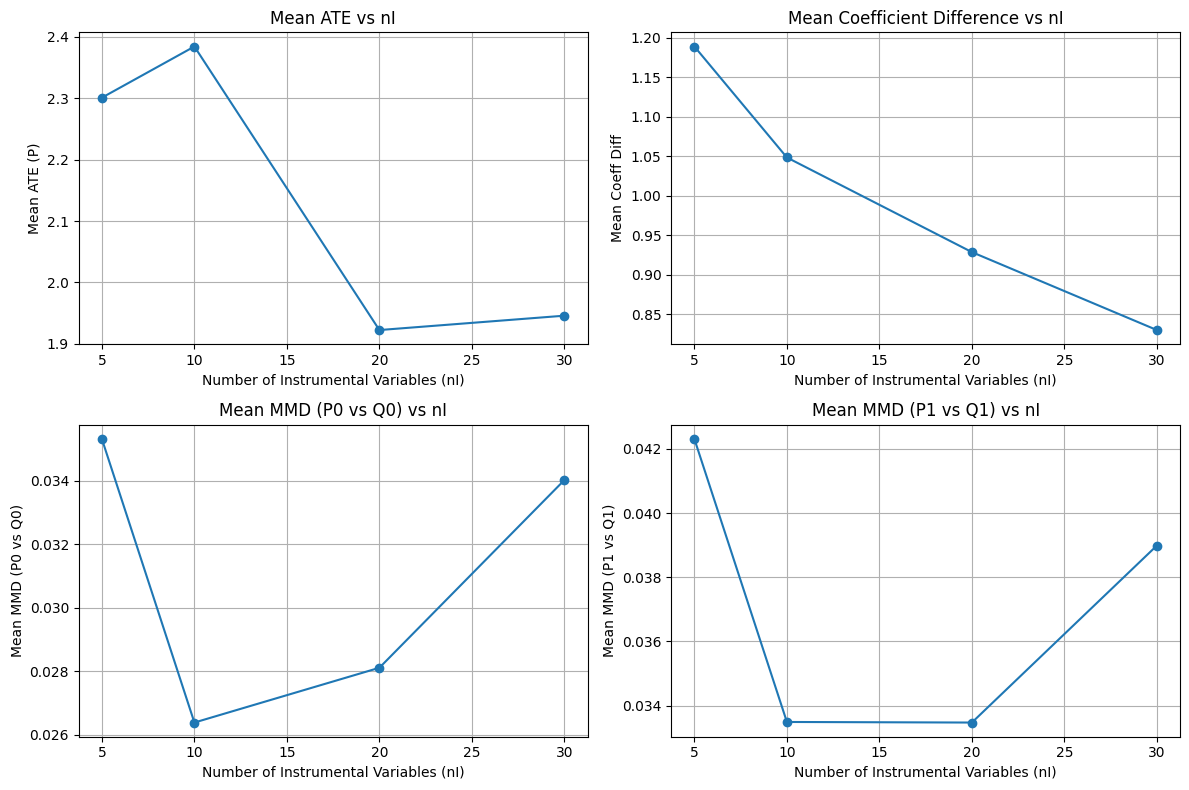

/var/folders/34/4pny9pxj7z31glf0phhx3b280000gn/T/ipykernel_1270/3074661500.py:56: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([tracker[nI]["ate_p"] for nI in nI_values], labels=nI_values, patch_artist=True)
/var/folders/34/4pny9pxj7z31glf0phhx3b280000gn/T/ipykernel_1270/3074661500.py:64: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([tracker[nI]["coeff_diff"] for nI in nI_values], labels=nI_values, patch_artist=True)
/var/folders/34/4pny9pxj7z31glf0phhx3b280000gn/T/ipykernel_1270/3074661500.py:72: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([tracker[nI]["mmd_p0_q0"] for nI in nI

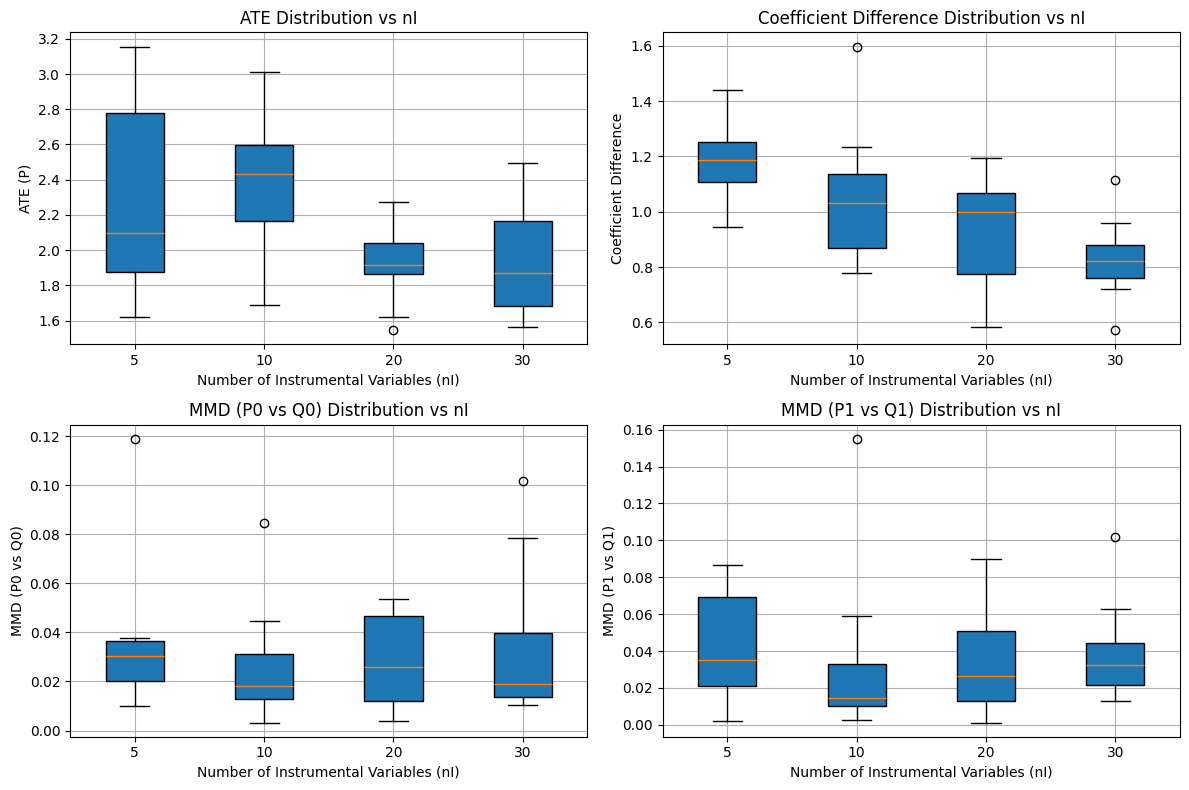

In [6]:
import matplotlib.pyplot as plt
import numpy as np

# Extract data for plotting
nI_values = list(tracker.keys())

# Compute means for each nI
mean_ate_p = [np.mean(tracker[nI]["ate_p"]) for nI in nI_values]
mean_coeff_diff = [np.mean(tracker[nI]["coeff_diff"]) for nI in nI_values]
mean_mmd_p0_q0 = [np.mean(tracker[nI]["mmd_p0_q0"]) for nI in nI_values]
mean_mmd_p1_q1 = [np.mean(tracker[nI]["mmd_p1_q1"]) for nI in nI_values]

# Line plots for means
plt.figure(figsize=(12, 8))

# ATE Plot
plt.subplot(2, 2, 1)
plt.plot(nI_values, mean_ate_p, marker='o', label='Mean ATE (P)')
plt.xlabel('Number of Instrumental Variables (nI)')
plt.ylabel('Mean ATE (P)')
plt.title('Mean ATE vs nI')
plt.grid(True)

# Coefficient Difference Plot
plt.subplot(2, 2, 2)
plt.plot(nI_values, mean_coeff_diff, marker='o', label='Mean Coeff Diff')
plt.xlabel('Number of Instrumental Variables (nI)')
plt.ylabel('Mean Coeff Diff')
plt.title('Mean Coefficient Difference vs nI')
plt.grid(True)

# MMD P0 vs Q0
plt.subplot(2, 2, 3)
plt.plot(nI_values, mean_mmd_p0_q0, marker='o', label='Mean MMD (P0 vs Q0)')
plt.xlabel('Number of Instrumental Variables (nI)')
plt.ylabel('Mean MMD (P0 vs Q0)')
plt.title('Mean MMD (P0 vs Q0) vs nI')
plt.grid(True)

# MMD P1 vs Q1
plt.subplot(2, 2, 4)
plt.plot(nI_values, mean_mmd_p1_q1, marker='o', label='Mean MMD (P1 vs Q1)')
plt.xlabel('Number of Instrumental Variables (nI)')
plt.ylabel('Mean MMD (P1 vs Q1)')
plt.title('Mean MMD (P1 vs Q1) vs nI')
plt.grid(True)

plt.tight_layout()
plt.show()

# Boxplots for Distribution
plt.figure(figsize=(12, 8))

# Boxplot for ATE
plt.subplot(2, 2, 1)
plt.boxplot([tracker[nI]["ate_p"] for nI in nI_values], labels=nI_values, patch_artist=True)
plt.xlabel('Number of Instrumental Variables (nI)')
plt.ylabel('ATE (P)')
plt.title('ATE Distribution vs nI')
plt.grid(True)

# Boxplot for Coefficient Difference
plt.subplot(2, 2, 2)
plt.boxplot([tracker[nI]["coeff_diff"] for nI in nI_values], labels=nI_values, patch_artist=True)
plt.xlabel('Number of Instrumental Variables (nI)')
plt.ylabel('Coefficient Difference')
plt.title('Coefficient Difference Distribution vs nI')
plt.grid(True)

# Boxplot for MMD P0 vs Q0
plt.subplot(2, 2, 3)
plt.boxplot([tracker[nI]["mmd_p0_q0"] for nI in nI_values], labels=nI_values, patch_artist=True)
plt.xlabel('Number of Instrumental Variables (nI)')
plt.ylabel('MMD (P0 vs Q0)')
plt.title('MMD (P0 vs Q0) Distribution vs nI')
plt.grid(True)

# Boxplot for MMD P1 vs Q1
plt.subplot(2, 2, 4)
plt.boxplot([tracker[nI]["mmd_p1_q1"] for nI in nI_values], labels=nI_values, patch_artist=True)
plt.xlabel('Number of Instrumental Variables (nI)')
plt.ylabel('MMD (P1 vs Q1)')
plt.title('MMD (P1 vs Q1) Distribution vs nI')
plt.grid(True)

plt.tight_layout()
plt.show()


In [7]:
nrep = 10  # Number of repetitions
n_tr = 1000  # Training sample size
n_p = 1000  # Testing sample size
nI_values = [40, 60, 80, 100]  # Different values of nI to iterate through
nX = 5
nO = 5
nS = 10
binary_intervention = True
num_iters = 4000  # Fixed number of training iterations

# Initialize tracker for nI
tracker = {nI: {"ate_p": [],"coeff_diff":[],"mmd_p0_q0": [], "mmd_p1_q1": [], "mmd_joint": [], "logreg_coeffs_p": [], "logreg_coeffs_q": []} 
           for nI in nI_values}

# Begin loop over nI
for nI in nI_values:
    print(f"Running experiments for nI = {nI}")
    p = nI + nX + nO + nS  # Update the number of covariates
    
    for rep in tqdm(range(nrep)):
        # Generate training and testing data
        df_tr = generate_data_causl(n=n_tr, nI=nI, nX=nX, nO=nO, nS=nS, ate=ate, 
                                    beta_cov=beta_cov, strength_instr=strength_instr, 
                                    strength_conf=strength_conf, 
                                    strength_outcome=strength_outcome, 
                                    binary_intervention=binary_intervention)
        z_tr = torch.tensor(df_tr[[f"X{i}" for i in range(1, p + 1)]].values, dtype=torch.float32)
        x_tr = torch.tensor(df_tr['A'].values, dtype=torch.int32).view(-1, 1) if binary_intervention else \
               torch.tensor(df_tr['A'].values, dtype=torch.float32).view(-1, 1)
        y_tr = torch.tensor(df_tr['y'].values, dtype=torch.float32).view(-1, 1)

        model = Frengression(x_tr.shape[1], y_tr.shape[1], z_tr.shape[1], 
                             noise_dim=1, num_layer=3, hidden_dim=400, 
                             device=device, x_binary=binary_intervention,z_binary_dims=0)
        
        df_q = generate_data_causl(n=n_p, nI=nI, nX=nX, nO=nO, nS=nS, ate=ate, 
                                    beta_cov=beta_cov, strength_instr=strength_instr, 
                                    strength_conf=strength_conf, 
                                    strength_outcome=strength_outcome, 
                                    binary_intervention=binary_intervention)
        
        z_q = torch.tensor(df_q[[f"X{i}" for i in range(1, p + 1)]].values, dtype=torch.float32)
        x_q = torch.tensor(df_q['A'].values, dtype=torch.int32).view(-1, 1) if binary_intervention else \
               torch.tensor(df_q['A'].values, dtype=torch.float32).view(-1, 1)
        y_q = torch.tensor(df_q['y'].values, dtype=torch.float32).view(-1, 1)

        # Ground truth distributions
        Q0 = np.random.normal(loc=0, scale=1, size=n_p).reshape([n_p, 1])
        Q1 = np.random.normal(loc=ate, scale=1, size=n_p).reshape([n_p, 1])
        Q_joint = torch.cat([x_q, y_q, z_q], dim=1).numpy()


        # Train model for fixed iterations
        model.train_xz(x_tr, z_tr, num_iters=num_iters, lr=1e-4, print_every_iter=400)
        model.train_y(x_tr, z_tr, y_tr, num_iters=num_iters, lr=1e-4, print_every_iter=400)

        # Sample model distributions
        P0 = (model.sample_causal_margin(torch.tensor([0], dtype=torch.int32), sample_size=n_p)).numpy().reshape(-1, 1)
        P1 = (model.sample_causal_margin(torch.tensor([1], dtype=torch.int32), sample_size=n_p)).numpy().reshape(-1, 1)
        x_gen, y_gen, z_gen = model.sample_joint(sample_size=n_p)
        P_joint = torch.cat([x_gen, y_gen, z_gen], dim=1).numpy()
        ate_p = np.mean(P1) - np.mean(P0)

        # Calculate MMD
        mmd_p0_q0 = mmd_rbf(P0, Q0, sigma=1.0)
        mmd_p1_q1 = mmd_rbf(P1, Q1, sigma=1.0)
        mmd_joint = mmd_rbf(P_joint, Q_joint, sigma=1.0)

        # Logistic regression for P
        logistic_model_p = LogisticRegression()
        logistic_model_p.fit(z_gen.numpy(), x_gen.numpy().ravel())
        logreg_coeffs_p = logistic_model_p.coef_

        # Logistic regression for Q
        logistic_model_q = LogisticRegression()
        logistic_model_q.fit(z_q.numpy(), x_q.numpy().ravel())
        logreg_coeffs_q = logistic_model_q.coef_
        coeff_diff = np.mean((logreg_coeffs_p - logreg_coeffs_q)**2)

        # Log results
        tracker[nI]["ate_p"].append(ate_p)
        tracker[nI]["coeff_diff"].append(coeff_diff)
        tracker[nI]["mmd_p0_q0"].append(mmd_p0_q0)
        tracker[nI]["mmd_p1_q1"].append(mmd_p1_q1)
        tracker[nI]["mmd_joint"].append(mmd_joint)
        tracker[nI]["logreg_coeffs_p"].append(logreg_coeffs_p)
        tracker[nI]["logreg_coeffs_q"].append(logreg_coeffs_q)


Running experiments for nI = 40


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1: loss 7.3933, loss1 7.7712, loss2 0.7559
Epoch 400: loss 5.5350, loss1 10.8137, loss2 10.5574
Epoch 800: loss 5.5258, loss1 10.9235, loss2 10.7954
Epoch 1200: loss 5.5435, loss1 10.9248, loss2 10.7626
Epoch 1600: loss 5.5723, loss1 10.9536, loss2 10.7628
Epoch 2000: loss 5.4894, loss1 10.9108, loss2 10.8430
Epoch 2400: loss 5.5220, loss1 10.8918, loss2 10.7396
Epoch 2800: loss 5.4486, loss1 10.8868, loss2 10.8765
Epoch 3200: loss 5.4918, loss1 10.8916, loss2 10.7996
Epoch 3600: loss 5.5225, loss1 10.9466, loss2 10.8484
Epoch 4000: loss 5.4534, loss1 10.9247, loss2 10.9426
Epoch 1: loss 2.2893,	loss_y 1.5135, 1.5279, 0.0287,	loss_eta 0.7757, 0.8134, 0.0754
Epoch 400: loss 1.3181,	loss_y 0.5863, 1.1075, 1.0423,	loss_eta 0.7317, 0.8604, 0.2573
Epoch 800: loss 1.4771,	loss_y 0.9045, 1.3078, 0.8067,	loss_eta 0.5727, 0.9882, 0.8311
Epoch 1200: loss 1.1013,	loss_y 0.4699, 0.9093, 0.8787,	loss_eta 0.6313, 1.0504, 0.8382
Epoch 1600: loss 1.0156,	loss_y 0.4065, 0.8787, 0.9445,	loss_eta 0

 10%|█         | 1/10 [01:21<12:15, 81.68s/it]

Epoch 4000: loss 0.9716,	loss_y 0.3952, 0.8731, 0.9557,	loss_eta 0.5764, 1.3907, 1.6286
Epoch 1: loss 7.3533, loss1 7.7405, loss2 0.7744
Epoch 400: loss 5.5462, loss1 10.7561, loss2 10.4198
Epoch 800: loss 5.4393, loss1 10.8466, loss2 10.8146
Epoch 1200: loss 5.4889, loss1 10.8587, loss2 10.7397
Epoch 1600: loss 5.4751, loss1 10.8335, loss2 10.7169
Epoch 2000: loss 5.4416, loss1 10.8918, loss2 10.9003
Epoch 2400: loss 5.4852, loss1 10.8665, loss2 10.7625
Epoch 2800: loss 5.4804, loss1 10.8952, loss2 10.8296
Epoch 3200: loss 5.4139, loss1 10.8264, loss2 10.8250
Epoch 3600: loss 5.4552, loss1 10.8982, loss2 10.8861
Epoch 4000: loss 5.4624, loss1 10.8808, loss2 10.8369
Epoch 1: loss 2.3246,	loss_y 1.5716, 1.5881, 0.0329,	loss_eta 0.7530, 0.7952, 0.0843
Epoch 400: loss 1.4209,	loss_y 0.8379, 1.8407, 2.0055,	loss_eta 0.5830, 0.8253, 0.4846
Epoch 800: loss 1.2142,	loss_y 0.5429, 1.2218, 1.3577,	loss_eta 0.6713, 0.8668, 0.3910
Epoch 1200: loss 1.1255,	loss_y 0.5238, 0.9192, 0.7910,	loss_eta 0

 20%|██        | 2/10 [02:43<10:55, 81.88s/it]

Epoch 4000: loss 0.9201,	loss_y 0.3546, 0.5130, 0.3170,	loss_eta 0.5656, 1.1663, 1.2014
Epoch 1: loss 7.3931, loss1 7.7608, loss2 0.7354
Epoch 400: loss 5.5304, loss1 10.8477, loss2 10.6346
Epoch 800: loss 5.4687, loss1 10.8394, loss2 10.7414
Epoch 1200: loss 5.4786, loss1 10.8086, loss2 10.6599
Epoch 1600: loss 5.5185, loss1 10.9140, loss2 10.7909
Epoch 2000: loss 5.5088, loss1 10.9363, loss2 10.8550
Epoch 2400: loss 5.4965, loss1 10.9264, loss2 10.8597
Epoch 2800: loss 5.5305, loss1 10.8976, loss2 10.7343
Epoch 3200: loss 5.4798, loss1 10.9162, loss2 10.8727
Epoch 3600: loss 5.4659, loss1 10.9112, loss2 10.8906
Epoch 4000: loss 5.4248, loss1 10.8720, loss2 10.8945
Epoch 1: loss 2.3012,	loss_y 1.5627, 1.5799, 0.0346,	loss_eta 0.7385, 0.7822, 0.0874
Epoch 400: loss 1.8533,	loss_y 1.0772, 1.7358, 1.3171,	loss_eta 0.7760, 0.7907, 0.0293
Epoch 800: loss 1.1495,	loss_y 0.5991, 1.7706, 2.3431,	loss_eta 0.5505, 1.0221, 0.9433
Epoch 1200: loss 0.9955,	loss_y 0.4188, 0.7585, 0.6795,	loss_eta 0

 30%|███       | 3/10 [03:56<09:05, 77.86s/it]

Epoch 4000: loss 0.8157,	loss_y 0.2210, 0.5812, 0.7204,	loss_eta 0.5947, 1.2812, 1.3730
Epoch 1: loss 7.4468, loss1 7.8153, loss2 0.7369
Epoch 400: loss 5.5442, loss1 10.8976, loss2 10.7067
Epoch 800: loss 5.5448, loss1 10.9191, loss2 10.7486
Epoch 1200: loss 5.4862, loss1 10.9204, loss2 10.8682
Epoch 1600: loss 5.5321, loss1 10.9397, loss2 10.8152
Epoch 2000: loss 5.5198, loss1 10.9441, loss2 10.8485
Epoch 2400: loss 5.5563, loss1 10.9638, loss2 10.8149
Epoch 2800: loss 5.5400, loss1 10.9717, loss2 10.8634
Epoch 3200: loss 5.5225, loss1 10.9687, loss2 10.8925
Epoch 3600: loss 5.5253, loss1 10.9853, loss2 10.9199
Epoch 4000: loss 5.4769, loss1 10.9847, loss2 11.0156
Epoch 1: loss 2.3306,	loss_y 1.5711, 1.5788, 0.0153,	loss_eta 0.7595, 0.8031, 0.0872
Epoch 400: loss 1.5818,	loss_y 0.8438, 1.9782, 2.2688,	loss_eta 0.7380, 0.8506, 0.2251
Epoch 800: loss 1.2298,	loss_y 0.6169, 1.1179, 1.0020,	loss_eta 0.6129, 1.2793, 1.3327
Epoch 1200: loss 1.1422,	loss_y 0.5684, 1.4893, 1.8419,	loss_eta 0

 40%|████      | 4/10 [05:05<07:25, 74.18s/it]

Epoch 4000: loss 0.9194,	loss_y 0.2941, 0.6939, 0.7996,	loss_eta 0.6253, 1.2566, 1.2625
Epoch 1: loss 7.3898, loss1 7.7622, loss2 0.7448
Epoch 400: loss 5.6219, loss1 10.8151, loss2 10.3864
Epoch 800: loss 5.5026, loss1 10.9176, loss2 10.8301
Epoch 1200: loss 5.5097, loss1 10.8955, loss2 10.7717
Epoch 1600: loss 5.4995, loss1 10.8832, loss2 10.7673
Epoch 2000: loss 5.4624, loss1 10.8588, loss2 10.7930
Epoch 2400: loss 5.4894, loss1 10.8919, loss2 10.8050
Epoch 2800: loss 5.4850, loss1 10.8704, loss2 10.7708
Epoch 3200: loss 5.4779, loss1 10.8998, loss2 10.8439
Epoch 3600: loss 5.4628, loss1 10.9053, loss2 10.8850
Epoch 4000: loss 5.4777, loss1 10.9238, loss2 10.8922
Epoch 1: loss 2.2576,	loss_y 1.5178, 1.5276, 0.0197,	loss_eta 0.7398, 0.7743, 0.0690
Epoch 400: loss 1.4503,	loss_y 0.6834, 1.4972, 1.6277,	loss_eta 0.7669, 0.7790, 0.0241
Epoch 800: loss 1.4295,	loss_y 0.6866, 1.0923, 0.8114,	loss_eta 0.7429, 1.2042, 0.9226
Epoch 1200: loss 1.3366,	loss_y 0.7248, 1.0531, 0.6567,	loss_eta 0

 50%|█████     | 5/10 [06:14<06:02, 72.55s/it]

Epoch 4000: loss 0.8179,	loss_y 0.2163, 0.5804, 0.7282,	loss_eta 0.6016, 1.2838, 1.3643
Epoch 1: loss 7.3766, loss1 7.7459, loss2 0.7385
Epoch 400: loss 5.4539, loss1 10.7242, loss2 10.5406
Epoch 800: loss 5.5130, loss1 10.8957, loss2 10.7655
Epoch 1200: loss 5.5105, loss1 10.8720, loss2 10.7229
Epoch 1600: loss 5.4990, loss1 10.8960, loss2 10.7941
Epoch 2000: loss 5.4347, loss1 10.8084, loss2 10.7475
Epoch 2400: loss 5.4768, loss1 10.8780, loss2 10.8024
Epoch 2800: loss 5.4791, loss1 10.8839, loss2 10.8097
Epoch 3200: loss 5.4828, loss1 10.8814, loss2 10.7972
Epoch 3600: loss 5.4620, loss1 10.8991, loss2 10.8742
Epoch 4000: loss 5.4464, loss1 10.9252, loss2 10.9576
Epoch 1: loss 2.2824,	loss_y 1.5263, 1.5552, 0.0578,	loss_eta 0.7561, 0.7974, 0.0827
Epoch 400: loss 1.7640,	loss_y 1.1398, 1.9680, 1.6563,	loss_eta 0.6242, 0.9615, 0.6747
Epoch 800: loss 1.2877,	loss_y 0.6998, 1.5245, 1.6494,	loss_eta 0.5879, 1.2395, 1.3032
Epoch 1200: loss 1.0762,	loss_y 0.4707, 0.8937, 0.8461,	loss_eta 0

 60%|██████    | 6/10 [07:23<04:44, 71.24s/it]

Epoch 4000: loss 0.8770,	loss_y 0.2515, 0.6576, 0.8121,	loss_eta 0.6255, 1.4190, 1.5870
Epoch 1: loss 7.3937, loss1 7.7831, loss2 0.7788
Epoch 400: loss 5.5194, loss1 10.8163, loss2 10.5937
Epoch 800: loss 5.5134, loss1 10.8694, loss2 10.7121
Epoch 1200: loss 5.5758, loss1 10.9395, loss2 10.7273
Epoch 1600: loss 5.5026, loss1 10.8848, loss2 10.7646
Epoch 2000: loss 5.4494, loss1 10.9183, loss2 10.9380
Epoch 2400: loss 5.4646, loss1 10.9273, loss2 10.9255
Epoch 2800: loss 5.4991, loss1 10.8973, loss2 10.7966
Epoch 3200: loss 5.5011, loss1 10.9211, loss2 10.8399
Epoch 3600: loss 5.4982, loss1 10.9479, loss2 10.8995
Epoch 4000: loss 5.5000, loss1 10.9354, loss2 10.8708
Epoch 1: loss 2.3861,	loss_y 1.6422, 1.6653, 0.0462,	loss_eta 0.7439, 0.7806, 0.0734
Epoch 400: loss 1.5939,	loss_y 0.8063, 1.6371, 1.6615,	loss_eta 0.7876, 0.8007, 0.0263
Epoch 800: loss 1.4353,	loss_y 0.8035, 1.8932, 2.1793,	loss_eta 0.6317, 0.8211, 0.3786
Epoch 1200: loss 1.1317,	loss_y 0.4899, 0.9424, 0.9050,	loss_eta 0

 70%|███████   | 7/10 [08:31<03:30, 70.19s/it]

Epoch 4000: loss 0.9515,	loss_y 0.3482, 0.8295, 0.9627,	loss_eta 0.6033, 1.5925, 1.9784
Epoch 1: loss 7.4175, loss1 7.7874, loss2 0.7398
Epoch 400: loss 5.5986, loss1 10.8534, loss2 10.5096
Epoch 800: loss 5.4980, loss1 10.8966, loss2 10.7972
Epoch 1200: loss 5.5007, loss1 10.8926, loss2 10.7838
Epoch 1600: loss 5.5404, loss1 10.9339, loss2 10.7870
Epoch 2000: loss 5.4667, loss1 10.9279, loss2 10.9225
Epoch 2400: loss 5.4979, loss1 10.9193, loss2 10.8428
Epoch 2800: loss 5.4721, loss1 10.9729, loss2 11.0016
Epoch 3200: loss 5.4926, loss1 10.9124, loss2 10.8397
Epoch 3600: loss 5.5175, loss1 10.8979, loss2 10.7608
Epoch 4000: loss 5.5200, loss1 10.9741, loss2 10.9082
Epoch 1: loss 2.3694,	loss_y 1.6020, 1.6211, 0.0383,	loss_eta 0.7674, 0.8079, 0.0809
Epoch 400: loss 1.5776,	loss_y 0.8244, 2.1100, 2.5713,	loss_eta 0.7532, 0.9131, 0.3199
Epoch 800: loss 1.2184,	loss_y 0.5699, 1.2772, 1.4145,	loss_eta 0.6485, 1.0777, 0.8583
Epoch 1200: loss 1.3343,	loss_y 0.6573, 1.1846, 1.0545,	loss_eta 0

 80%|████████  | 8/10 [09:40<02:19, 69.68s/it]

Epoch 4000: loss 0.9026,	loss_y 0.2468, 0.6401, 0.7866,	loss_eta 0.6558, 1.5725, 1.8333
Epoch 1: loss 7.3962, loss1 7.7690, loss2 0.7456
Epoch 400: loss 5.5720, loss1 10.8108, loss2 10.4777
Epoch 800: loss 5.4938, loss1 10.8508, loss2 10.7140
Epoch 1200: loss 5.5882, loss1 10.9019, loss2 10.6275
Epoch 1600: loss 5.5174, loss1 10.8470, loss2 10.6592
Epoch 2000: loss 5.4769, loss1 10.8958, loss2 10.8378
Epoch 2400: loss 5.5086, loss1 10.9587, loss2 10.9001
Epoch 2800: loss 5.5076, loss1 10.8708, loss2 10.7264
Epoch 3200: loss 5.4937, loss1 10.9083, loss2 10.8292
Epoch 3600: loss 5.4960, loss1 10.8833, loss2 10.7745
Epoch 4000: loss 5.4924, loss1 10.9261, loss2 10.8674
Epoch 1: loss 2.1720,	loss_y 1.4122, 1.4259, 0.0274,	loss_eta 0.7598, 0.7991, 0.0786
Epoch 400: loss 1.5574,	loss_y 0.7629, 1.6806, 1.8354,	loss_eta 0.7946, 0.8022, 0.0154
Epoch 800: loss 1.1956,	loss_y 0.4861, 0.7532, 0.5342,	loss_eta 0.7094, 1.1737, 0.9285
Epoch 1200: loss 1.0264,	loss_y 0.3950, 0.9555, 1.1210,	loss_eta 0

 90%|█████████ | 9/10 [10:49<01:09, 69.51s/it]

Epoch 4000: loss 0.9077,	loss_y 0.3007, 0.6807, 0.7601,	loss_eta 0.6070, 1.2656, 1.3172
Epoch 1: loss 7.4076, loss1 7.7747, loss2 0.7342
Epoch 400: loss 5.4761, loss1 10.7754, loss2 10.5987
Epoch 800: loss 5.5474, loss1 10.8891, loss2 10.6834
Epoch 1200: loss 5.4703, loss1 10.8835, loss2 10.8264
Epoch 1600: loss 5.4986, loss1 10.8538, loss2 10.7105
Epoch 2000: loss 5.5131, loss1 10.9263, loss2 10.8263
Epoch 2400: loss 5.4517, loss1 10.8848, loss2 10.8661
Epoch 2800: loss 5.4964, loss1 10.9691, loss2 10.9455
Epoch 3200: loss 5.4836, loss1 10.8903, loss2 10.8134
Epoch 3600: loss 5.5020, loss1 10.9414, loss2 10.8788
Epoch 4000: loss 5.5144, loss1 10.9511, loss2 10.8733
Epoch 1: loss 2.2989,	loss_y 1.5435, 1.5893, 0.0917,	loss_eta 0.7554, 0.7974, 0.0839
Epoch 400: loss 1.6197,	loss_y 0.8161, 1.5079, 1.3835,	loss_eta 0.8036, 0.8144, 0.0217
Epoch 800: loss 1.2109,	loss_y 0.6402, 1.8582, 2.4359,	loss_eta 0.5707, 1.2686, 1.3959
Epoch 1200: loss 0.9087,	loss_y 0.3463, 0.8295, 0.9664,	loss_eta 0

100%|██████████| 10/10 [12:10<00:00, 73.09s/it]


Epoch 4000: loss 1.0440,	loss_y 0.4464, 0.7901, 0.6875,	loss_eta 0.5977, 1.0254, 0.8554
Running experiments for nI = 60


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1: loss 8.5589, loss1 8.9784, loss2 0.8391
Epoch 400: loss 6.3186, loss1 12.5223, loss2 12.4075
Epoch 800: loss 6.4049, loss1 12.6332, loss2 12.4565
Epoch 1200: loss 6.3193, loss1 12.6280, loss2 12.6174
Epoch 1600: loss 6.3639, loss1 12.5548, loss2 12.3817
Epoch 2000: loss 6.3041, loss1 12.6299, loss2 12.6516
Epoch 2400: loss 6.3115, loss1 12.5889, loss2 12.5549
Epoch 2800: loss 6.3748, loss1 12.6289, loss2 12.5082
Epoch 3200: loss 6.3571, loss1 12.6547, loss2 12.5953
Epoch 3600: loss 6.3106, loss1 12.6244, loss2 12.6278
Epoch 4000: loss 6.3515, loss1 12.5742, loss2 12.4454
Epoch 1: loss 2.3448,	loss_y 1.6092, 1.6429, 0.0674,	loss_eta 0.7356, 0.7703, 0.0694
Epoch 400: loss 1.4615,	loss_y 0.6972, 1.1977, 1.0011,	loss_eta 0.7643, 0.8901, 0.2516
Epoch 800: loss 1.6136,	loss_y 0.9823, 1.5140, 1.0633,	loss_eta 0.6313, 0.9796, 0.6967
Epoch 1200: loss 0.9730,	loss_y 0.3791, 0.6705, 0.5829,	loss_eta 0.5939, 1.0953, 1.0027
Epoch 1600: loss 0.8801,	loss_y 0.3148, 0.6682, 0.7069,	loss_eta 0

 10%|█         | 1/10 [01:12<10:48, 72.06s/it]

Epoch 4000: loss 0.7883,	loss_y 0.2279, 0.5166, 0.5775,	loss_eta 0.5604, 1.0754, 1.0301
Epoch 1: loss 8.5379, loss1 8.9784, loss2 0.8810
Epoch 400: loss 6.3793, loss1 12.4593, loss2 12.1599
Epoch 800: loss 6.4335, loss1 12.5553, loss2 12.2434
Epoch 1200: loss 6.3196, loss1 12.5754, loss2 12.5116
Epoch 1600: loss 6.3085, loss1 12.6233, loss2 12.6296
Epoch 2000: loss 6.3077, loss1 12.6152, loss2 12.6150
Epoch 2400: loss 6.3925, loss1 12.6086, loss2 12.4323
Epoch 2800: loss 6.3452, loss1 12.6168, loss2 12.5432
Epoch 3200: loss 6.3806, loss1 12.6156, loss2 12.4700
Epoch 3600: loss 6.3441, loss1 12.6175, loss2 12.5469
Epoch 4000: loss 6.3087, loss1 12.6124, loss2 12.6074
Epoch 1: loss 2.3080,	loss_y 1.5431, 1.5591, 0.0320,	loss_eta 0.7649, 0.8049, 0.0800
Epoch 400: loss 1.4961,	loss_y 0.7472, 1.7717, 2.0490,	loss_eta 0.7489, 0.7903, 0.0829
Epoch 800: loss 1.2235,	loss_y 0.6071, 1.2748, 1.3355,	loss_eta 0.6165, 1.0172, 0.8014
Epoch 1200: loss 1.4527,	loss_y 0.8357, 1.5971, 1.5227,	loss_eta 0

 20%|██        | 2/10 [02:24<09:37, 72.17s/it]

Epoch 4000: loss 0.9423,	loss_y 0.3520, 0.7561, 0.8082,	loss_eta 0.5903, 1.3074, 1.4340
Epoch 1: loss 8.5529, loss1 8.9846, loss2 0.8635
Epoch 400: loss 6.3842, loss1 12.4528, loss2 12.1370
Epoch 800: loss 6.3485, loss1 12.5903, loss2 12.4836
Epoch 1200: loss 6.3689, loss1 12.6278, loss2 12.5178
Epoch 1600: loss 6.3175, loss1 12.5770, loss2 12.5190
Epoch 2000: loss 6.3379, loss1 12.5355, loss2 12.3953
Epoch 2400: loss 6.3788, loss1 12.6448, loss2 12.5319
Epoch 2800: loss 6.3010, loss1 12.5251, loss2 12.4482
Epoch 3200: loss 6.3366, loss1 12.5965, loss2 12.5199
Epoch 3600: loss 6.3402, loss1 12.5768, loss2 12.4732
Epoch 4000: loss 6.3440, loss1 12.6368, loss2 12.5856
Epoch 1: loss 2.2537,	loss_y 1.5299, 1.5371, 0.0144,	loss_eta 0.7238, 0.7670, 0.0863
Epoch 400: loss 1.5070,	loss_y 0.7764, 1.3579, 1.1631,	loss_eta 0.7307, 0.7838, 0.1062
Epoch 800: loss 1.4177,	loss_y 0.7421, 1.2418, 0.9994,	loss_eta 0.6756, 1.0476, 0.7439
Epoch 1200: loss 1.4065,	loss_y 0.7221, 1.2675, 1.0909,	loss_eta 0

 30%|███       | 3/10 [03:36<08:26, 72.32s/it]

Epoch 4000: loss 0.8640,	loss_y 0.2538, 0.5045, 0.5014,	loss_eta 0.6101, 0.9547, 0.6892
Epoch 1: loss 8.5242, loss1 8.9641, loss2 0.8800
Epoch 400: loss 6.3927, loss1 12.3491, loss2 11.9129
Epoch 800: loss 6.3354, loss1 12.5062, loss2 12.3416
Epoch 1200: loss 6.3348, loss1 12.5581, loss2 12.4466
Epoch 1600: loss 6.3336, loss1 12.5734, loss2 12.4795
Epoch 2000: loss 6.3326, loss1 12.5939, loss2 12.5226
Epoch 2400: loss 6.3003, loss1 12.5292, loss2 12.4579
Epoch 2800: loss 6.3257, loss1 12.5721, loss2 12.4929
Epoch 3200: loss 6.3318, loss1 12.5514, loss2 12.4392
Epoch 3600: loss 6.3104, loss1 12.5576, loss2 12.4945
Epoch 4000: loss 6.3193, loss1 12.5458, loss2 12.4531
Epoch 1: loss 2.3626,	loss_y 1.6041, 1.6165, 0.0249,	loss_eta 0.7585, 0.7949, 0.0728
Epoch 400: loss 1.7319,	loss_y 0.9362, 1.4001, 0.9280,	loss_eta 0.7957, 0.8043, 0.0173
Epoch 800: loss 1.2175,	loss_y 0.5363, 1.1921, 1.3117,	loss_eta 0.6813, 0.7826, 0.2028
Epoch 1200: loss 1.2669,	loss_y 0.6471, 1.3329, 1.3717,	loss_eta 0

 40%|████      | 4/10 [04:49<07:14, 72.46s/it]

Epoch 4000: loss 0.9392,	loss_y 0.3253, 0.6387, 0.6268,	loss_eta 0.6139, 0.9869, 0.7461
Epoch 1: loss 8.5102, loss1 8.9494, loss2 0.8785
Epoch 400: loss 6.4079, loss1 12.4471, loss2 12.0785
Epoch 800: loss 6.3373, loss1 12.5448, loss2 12.4151
Epoch 1200: loss 6.3901, loss1 12.5570, loss2 12.3339
Epoch 1600: loss 6.3572, loss1 12.5322, loss2 12.3499
Epoch 2000: loss 6.3533, loss1 12.5362, loss2 12.3658
Epoch 2400: loss 6.3193, loss1 12.5774, loss2 12.5163
Epoch 2800: loss 6.3763, loss1 12.5351, loss2 12.3175
Epoch 3200: loss 6.3075, loss1 12.5624, loss2 12.5098
Epoch 3600: loss 6.2880, loss1 12.5358, loss2 12.4957
Epoch 4000: loss 6.2890, loss1 12.5499, loss2 12.5218
Epoch 1: loss 2.1528,	loss_y 1.4147, 1.4289, 0.0285,	loss_eta 0.7381, 0.7841, 0.0919
Epoch 400: loss 1.4633,	loss_y 0.8482, 1.4318, 1.1673,	loss_eta 0.6151, 0.9790, 0.7276
Epoch 800: loss 1.3103,	loss_y 0.6313, 1.3335, 1.4043,	loss_eta 0.6790, 1.5759, 1.7937
Epoch 1200: loss 0.9502,	loss_y 0.3553, 0.6554, 0.6002,	loss_eta 0

 50%|█████     | 5/10 [06:01<06:00, 72.16s/it]

Epoch 4000: loss 0.8288,	loss_y 0.1885, 0.3936, 0.4102,	loss_eta 0.6403, 1.1636, 1.0465
Epoch 1: loss 8.5467, loss1 8.9790, loss2 0.8646
Epoch 400: loss 6.3695, loss1 12.4976, loss2 12.2561
Epoch 800: loss 6.3707, loss1 12.5948, loss2 12.4482
Epoch 1200: loss 6.3643, loss1 12.5521, loss2 12.3758
Epoch 1600: loss 6.3343, loss1 12.5788, loss2 12.4889
Epoch 2000: loss 6.3334, loss1 12.5830, loss2 12.4992
Epoch 2400: loss 6.3214, loss1 12.5651, loss2 12.4875
Epoch 2800: loss 6.3027, loss1 12.5779, loss2 12.5503
Epoch 3200: loss 6.3489, loss1 12.5924, loss2 12.4869
Epoch 3600: loss 6.3303, loss1 12.5662, loss2 12.4719
Epoch 4000: loss 6.3355, loss1 12.5801, loss2 12.4893
Epoch 1: loss 2.3821,	loss_y 1.5878, 1.6069, 0.0382,	loss_eta 0.7943, 0.8308, 0.0731
Epoch 400: loss 1.5651,	loss_y 0.7987, 1.4418, 1.2861,	loss_eta 0.7664, 0.8018, 0.0707
Epoch 800: loss 1.2707,	loss_y 0.5599, 1.3214, 1.5230,	loss_eta 0.7107, 0.8144, 0.2074
Epoch 1200: loss 1.0392,	loss_y 0.4355, 0.8262, 0.7815,	loss_eta 0

 60%|██████    | 6/10 [07:13<04:49, 72.32s/it]

Epoch 4000: loss 0.8754,	loss_y 0.3063, 0.7041, 0.7955,	loss_eta 0.5691, 1.5561, 1.9742
Epoch 1: loss 8.5381, loss1 8.9672, loss2 0.8582
Epoch 400: loss 6.3741, loss1 12.4546, loss2 12.1611
Epoch 800: loss 6.3625, loss1 12.5368, loss2 12.3487
Epoch 1200: loss 6.2853, loss1 12.5533, loss2 12.5360
Epoch 1600: loss 6.3283, loss1 12.5629, loss2 12.4691
Epoch 2000: loss 6.3720, loss1 12.5803, loss2 12.4165
Epoch 2400: loss 6.3836, loss1 12.6174, loss2 12.4678
Epoch 2800: loss 6.3846, loss1 12.5752, loss2 12.3812
Epoch 3200: loss 6.3011, loss1 12.6077, loss2 12.6133
Epoch 3600: loss 6.3927, loss1 12.6437, loss2 12.5021
Epoch 4000: loss 6.3294, loss1 12.6132, loss2 12.5675
Epoch 1: loss 2.2850,	loss_y 1.5062, 1.5183, 0.0242,	loss_eta 0.7788, 0.8173, 0.0770
Epoch 400: loss 1.6965,	loss_y 0.8909, 1.5618, 1.3420,	loss_eta 0.8056, 0.8084, 0.0055
Epoch 800: loss 1.2127,	loss_y 0.5318, 1.3394, 1.6151,	loss_eta 0.6809, 1.1913, 1.0208
Epoch 1200: loss 0.9043,	loss_y 0.3435, 0.8449, 1.0028,	loss_eta 0

 70%|███████   | 7/10 [08:26<03:36, 72.32s/it]

Epoch 4000: loss 0.8326,	loss_y 0.2302, 0.6028, 0.7452,	loss_eta 0.6024, 1.3296, 1.4544
Epoch 1: loss 8.5361, loss1 8.9625, loss2 0.8527
Epoch 400: loss 6.3442, loss1 12.4588, loss2 12.2290
Epoch 800: loss 6.3328, loss1 12.5234, loss2 12.3811
Epoch 1200: loss 6.3243, loss1 12.5752, loss2 12.5017
Epoch 1600: loss 6.3716, loss1 12.5447, loss2 12.3461
Epoch 2000: loss 6.3685, loss1 12.5597, loss2 12.3823
Epoch 2400: loss 6.3230, loss1 12.5382, loss2 12.4305
Epoch 2800: loss 6.3013, loss1 12.5633, loss2 12.5240
Epoch 3200: loss 6.3162, loss1 12.5707, loss2 12.5089
Epoch 3600: loss 6.3264, loss1 12.5687, loss2 12.4847
Epoch 4000: loss 6.3413, loss1 12.5554, loss2 12.4282
Epoch 1: loss 2.3261,	loss_y 1.5624, 1.5814, 0.0380,	loss_eta 0.7637, 0.8026, 0.0779
Epoch 400: loss 1.4747,	loss_y 0.7245, 1.7894, 2.1299,	loss_eta 0.7502, 0.8037, 0.1071
Epoch 800: loss 1.1378,	loss_y 0.4874, 1.4891, 2.0033,	loss_eta 0.6504, 1.3858, 1.4707
Epoch 1200: loss 0.8424,	loss_y 0.3052, 0.7096, 0.8089,	loss_eta 0

 80%|████████  | 8/10 [09:37<02:24, 72.11s/it]

Epoch 4000: loss 0.8462,	loss_y 0.2724, 0.5769, 0.6089,	loss_eta 0.5738, 1.2267, 1.3058
Epoch 1: loss 8.5744, loss1 9.0068, loss2 0.8648
Epoch 400: loss 6.3339, loss1 12.5199, loss2 12.3720
Epoch 800: loss 6.4651, loss1 12.6539, loss2 12.3778
Epoch 1200: loss 6.3395, loss1 12.5925, loss2 12.5060
Epoch 1600: loss 6.4172, loss1 12.6592, loss2 12.4841
Epoch 2000: loss 6.3733, loss1 12.5987, loss2 12.4508
Epoch 2400: loss 6.3534, loss1 12.6238, loss2 12.5409
Epoch 2800: loss 6.3339, loss1 12.5992, loss2 12.5305
Epoch 3200: loss 6.3455, loss1 12.6435, loss2 12.5959
Epoch 3600: loss 6.2756, loss1 12.6286, loss2 12.7061
Epoch 4000: loss 6.3377, loss1 12.6548, loss2 12.6341
Epoch 1: loss 2.3101,	loss_y 1.5304, 1.5359, 0.0110,	loss_eta 0.7797, 0.8177, 0.0760
Epoch 400: loss 2.0167,	loss_y 1.2803, 2.5836, 2.6065,	loss_eta 0.7363, 0.8616, 0.2506
Epoch 800: loss 1.2887,	loss_y 0.7159, 1.6725, 1.9131,	loss_eta 0.5728, 1.0316, 0.9176
Epoch 1200: loss 1.0246,	loss_y 0.4260, 0.9117, 0.9716,	loss_eta 0

 90%|█████████ | 9/10 [10:50<01:12, 72.45s/it]

Epoch 4000: loss 0.9758,	loss_y 0.3436, 0.7884, 0.8896,	loss_eta 0.6322, 0.9664, 0.6685
Epoch 1: loss 8.5183, loss1 8.9465, loss2 0.8563
Epoch 400: loss 6.3886, loss1 12.5023, loss2 12.2274
Epoch 800: loss 6.3115, loss1 12.4838, loss2 12.3446
Epoch 1200: loss 6.3197, loss1 12.5626, loss2 12.4857
Epoch 1600: loss 6.3127, loss1 12.5670, loss2 12.5087
Epoch 2000: loss 6.3585, loss1 12.5266, loss2 12.3362
Epoch 2400: loss 6.3198, loss1 12.6148, loss2 12.5901
Epoch 2800: loss 6.3030, loss1 12.5279, loss2 12.4497
Epoch 3200: loss 6.3338, loss1 12.5362, loss2 12.4049
Epoch 3600: loss 6.3352, loss1 12.5512, loss2 12.4319
Epoch 4000: loss 6.3050, loss1 12.5926, loss2 12.5753
Epoch 1: loss 2.2569,	loss_y 1.4789, 1.5130, 0.0682,	loss_eta 0.7780, 0.8169, 0.0779
Epoch 400: loss 1.5072,	loss_y 0.7691, 1.1632, 0.7884,	loss_eta 0.7382, 0.8195, 0.1626
Epoch 800: loss 1.1817,	loss_y 0.5955, 1.4586, 1.7261,	loss_eta 0.5862, 1.1578, 1.1433
Epoch 1200: loss 1.0050,	loss_y 0.4302, 0.8410, 0.8214,	loss_eta 0

100%|██████████| 10/10 [12:03<00:00, 72.37s/it]


Epoch 4000: loss 0.8370,	loss_y 0.2564, 0.5666, 0.6204,	loss_eta 0.5806, 1.1869, 1.2127
Running experiments for nI = 80


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1: loss 9.5768, loss1 10.0496, loss2 0.9456
Epoch 400: loss 7.1645, loss1 13.9890, loss2 13.6490
Epoch 800: loss 7.1719, loss1 14.0531, loss2 13.7623
Epoch 1200: loss 7.1021, loss1 14.0302, loss2 13.8563
Epoch 1600: loss 7.1462, loss1 14.0966, loss2 13.9008
Epoch 2000: loss 7.0726, loss1 14.1167, loss2 14.0882
Epoch 2400: loss 7.1237, loss1 14.1015, loss2 13.9557
Epoch 2800: loss 7.0574, loss1 14.0988, loss2 14.0828
Epoch 3200: loss 7.1104, loss1 14.0686, loss2 13.9162
Epoch 3600: loss 7.0469, loss1 14.1247, loss2 14.1557
Epoch 4000: loss 7.0400, loss1 14.1100, loss2 14.1400
Epoch 1: loss 2.2605,	loss_y 1.4883, 1.5037, 0.0308,	loss_eta 0.7723, 0.8136, 0.0827
Epoch 400: loss 1.4327,	loss_y 0.6672, 1.1841, 1.0337,	loss_eta 0.7655, 0.8238, 0.1165
Epoch 800: loss 1.5957,	loss_y 0.8643, 1.6164, 1.5041,	loss_eta 0.7314, 0.7938, 0.1247
Epoch 1200: loss 1.1676,	loss_y 0.4849, 1.0907, 1.2116,	loss_eta 0.6826, 0.9200, 0.4748
Epoch 1600: loss 0.9828,	loss_y 0.3216, 0.6110, 0.5789,	loss_eta 

 10%|█         | 1/10 [01:14<11:07, 74.18s/it]

Epoch 4000: loss 0.8725,	loss_y 0.2539, 0.6527, 0.7977,	loss_eta 0.6187, 1.3166, 1.3959
Epoch 1: loss 9.5673, loss1 10.0503, loss2 0.9660
Epoch 400: loss 7.1346, loss1 13.9362, loss2 13.6033
Epoch 800: loss 7.0686, loss1 13.9918, loss2 13.8465
Epoch 1200: loss 7.1275, loss1 14.0697, loss2 13.8842
Epoch 1600: loss 7.1294, loss1 14.0965, loss2 13.9342
Epoch 2000: loss 7.0867, loss1 14.0979, loss2 14.0224
Epoch 2400: loss 7.1369, loss1 14.1322, loss2 13.9907
Epoch 2800: loss 7.1080, loss1 14.1039, loss2 13.9917
Epoch 3200: loss 7.0854, loss1 14.1151, loss2 14.0594
Epoch 3600: loss 7.0642, loss1 14.1190, loss2 14.1096
Epoch 4000: loss 7.0974, loss1 14.1139, loss2 14.0329
Epoch 1: loss 2.2516,	loss_y 1.4835, 1.5214, 0.0758,	loss_eta 0.7681, 0.8059, 0.0755
Epoch 400: loss 1.5201,	loss_y 0.7712, 1.7883, 2.0343,	loss_eta 0.7489, 0.7842, 0.0707
Epoch 800: loss 1.4841,	loss_y 0.8386, 1.4269, 1.1765,	loss_eta 0.6455, 0.9890, 0.6871
Epoch 1200: loss 1.0310,	loss_y 0.4491, 1.1438, 1.3893,	loss_eta 

 20%|██        | 2/10 [02:28<09:55, 74.38s/it]

Epoch 4000: loss 1.0134,	loss_y 0.3806, 0.7127, 0.6643,	loss_eta 0.6328, 1.3594, 1.4531
Epoch 1: loss 9.5483, loss1 10.0260, loss2 0.9554
Epoch 400: loss 7.1579, loss1 13.7977, loss2 13.2796
Epoch 800: loss 7.0780, loss1 13.9872, loss2 13.8184
Epoch 1200: loss 7.0827, loss1 14.0124, loss2 13.8594
Epoch 1600: loss 7.1298, loss1 14.0115, loss2 13.7633
Epoch 2000: loss 7.0941, loss1 14.0695, loss2 13.9508
Epoch 2400: loss 7.0549, loss1 14.0538, loss2 13.9978
Epoch 2800: loss 7.1016, loss1 14.0617, loss2 13.9201
Epoch 3200: loss 7.1177, loss1 14.0494, loss2 13.8634
Epoch 3600: loss 7.1153, loss1 14.0749, loss2 13.9190
Epoch 4000: loss 7.0274, loss1 14.0948, loss2 14.1348
Epoch 1: loss 2.2473,	loss_y 1.4834, 1.5110, 0.0552,	loss_eta 0.7639, 0.8070, 0.0861
Epoch 400: loss 1.4268,	loss_y 0.7007, 1.6241, 1.8467,	loss_eta 0.7261, 0.9986, 0.5451
Epoch 800: loss 1.5309,	loss_y 0.8319, 1.7123, 1.7608,	loss_eta 0.6990, 0.8353, 0.2727
Epoch 1200: loss 1.3058,	loss_y 0.6515, 1.2203, 1.1376,	loss_eta 

 30%|███       | 3/10 [03:43<08:43, 74.72s/it]

Epoch 4000: loss 0.8785,	loss_y 0.2828, 0.6058, 0.6460,	loss_eta 0.5957, 0.9693, 0.7473
Epoch 1: loss 9.5593, loss1 10.0509, loss2 0.9832
Epoch 400: loss 7.1119, loss1 13.9088, loss2 13.5937
Epoch 800: loss 7.1480, loss1 14.0526, loss2 13.8092
Epoch 1200: loss 7.1796, loss1 14.1252, loss2 13.8912
Epoch 1600: loss 7.1415, loss1 14.0807, loss2 13.8784
Epoch 2000: loss 7.0834, loss1 14.0803, loss2 13.9937
Epoch 2400: loss 7.1086, loss1 14.0828, loss2 13.9483
Epoch 2800: loss 7.0993, loss1 14.0842, loss2 13.9697
Epoch 3200: loss 7.1158, loss1 14.1164, loss2 14.0012
Epoch 3600: loss 7.0870, loss1 14.0800, loss2 13.9861
Epoch 4000: loss 7.1544, loss1 14.1182, loss2 13.9275
Epoch 1: loss 2.2819,	loss_y 1.5072, 1.5173, 0.0202,	loss_eta 0.7748, 0.8127, 0.0760
Epoch 400: loss 1.5961,	loss_y 0.8644, 1.8519, 1.9752,	loss_eta 0.7317, 0.8522, 0.2410
Epoch 800: loss 1.2505,	loss_y 0.5348, 1.4165, 1.7634,	loss_eta 0.7157, 0.9440, 0.4568
Epoch 1200: loss 0.9764,	loss_y 0.3727, 0.5729, 0.4003,	loss_eta 

 40%|████      | 4/10 [04:58<07:28, 74.80s/it]

Epoch 4000: loss 0.9736,	loss_y 0.3802, 0.7340, 0.7077,	loss_eta 0.5934, 1.3172, 1.4476
Epoch 1: loss 9.5314, loss1 10.0246, loss2 0.9865
Epoch 400: loss 7.1317, loss1 13.9010, loss2 13.5386
Epoch 800: loss 7.0598, loss1 13.9758, loss2 13.8320
Epoch 1200: loss 7.1241, loss1 14.0135, loss2 13.7789
Epoch 1600: loss 7.0794, loss1 14.0688, loss2 13.9787
Epoch 2000: loss 7.1091, loss1 14.0585, loss2 13.8988
Epoch 2400: loss 7.0489, loss1 14.0379, loss2 13.9780
Epoch 2800: loss 7.1078, loss1 14.0507, loss2 13.8858
Epoch 3200: loss 7.0692, loss1 14.0683, loss2 13.9981
Epoch 3600: loss 7.1088, loss1 14.0987, loss2 13.9799
Epoch 4000: loss 7.0669, loss1 14.0999, loss2 14.0660
Epoch 1: loss 2.1682,	loss_y 1.4447, 1.4759, 0.0624,	loss_eta 0.7235, 0.7615, 0.0759
Epoch 400: loss 1.4351,	loss_y 0.7067, 1.6329, 1.8525,	loss_eta 0.7284, 0.8921, 0.3274
Epoch 800: loss 1.2299,	loss_y 0.6342, 1.4329, 1.5972,	loss_eta 0.5956, 1.0011, 0.8110
Epoch 1200: loss 1.4356,	loss_y 0.8265, 1.4696, 1.2861,	loss_eta 

 50%|█████     | 5/10 [06:12<06:12, 74.53s/it]

Epoch 4000: loss 1.0017,	loss_y 0.3783, 0.5937, 0.4306,	loss_eta 0.6234, 0.9842, 0.7216
Epoch 1: loss 9.5555, loss1 10.0408, loss2 0.9705
Epoch 400: loss 7.1276, loss1 13.9045, loss2 13.5538
Epoch 800: loss 7.1121, loss1 13.9659, loss2 13.7077
Epoch 1200: loss 7.0860, loss1 13.9916, loss2 13.8111
Epoch 1600: loss 7.0992, loss1 13.9860, loss2 13.7735
Epoch 2000: loss 7.0561, loss1 14.0271, loss2 13.9419
Epoch 2400: loss 7.0718, loss1 14.0480, loss2 13.9524
Epoch 2800: loss 7.0846, loss1 14.1198, loss2 14.0704
Epoch 3200: loss 7.1009, loss1 14.1166, loss2 14.0314
Epoch 3600: loss 7.1093, loss1 14.0902, loss2 13.9618
Epoch 4000: loss 7.1276, loss1 14.1044, loss2 13.9536
Epoch 1: loss 2.4046,	loss_y 1.5891, 1.6034, 0.0286,	loss_eta 0.8155, 0.8547, 0.0784
Epoch 400: loss 1.4447,	loss_y 0.7414, 2.0975, 2.7122,	loss_eta 0.7033, 0.9694, 0.5321
Epoch 800: loss 1.3732,	loss_y 0.7143, 1.9126, 2.3965,	loss_eta 0.6589, 0.9233, 0.5288
Epoch 1200: loss 1.1519,	loss_y 0.5076, 1.2132, 1.4112,	loss_eta 

 60%|██████    | 6/10 [07:26<04:57, 74.28s/it]

Epoch 4000: loss 0.9214,	loss_y 0.3385, 0.6210, 0.5649,	loss_eta 0.5829, 1.3722, 1.5788
Epoch 1: loss 9.5693, loss1 10.0550, loss2 0.9715
Epoch 400: loss 7.1944, loss1 13.9440, loss2 13.4992
Epoch 800: loss 7.1427, loss1 14.0858, loss2 13.8862
Epoch 1200: loss 7.0564, loss1 14.0760, loss2 14.0393
Epoch 1600: loss 7.1617, loss1 14.1346, loss2 13.9459
Epoch 2000: loss 7.1031, loss1 14.0549, loss2 13.9036
Epoch 2400: loss 7.1291, loss1 14.1182, loss2 13.9783
Epoch 2800: loss 7.1304, loss1 14.1369, loss2 14.0130
Epoch 3200: loss 7.1370, loss1 14.0916, loss2 13.9093
Epoch 3600: loss 7.0707, loss1 14.1268, loss2 14.1122
Epoch 4000: loss 7.1105, loss1 14.0926, loss2 13.9640
Epoch 1: loss 2.2486,	loss_y 1.4793, 1.5035, 0.0483,	loss_eta 0.7692, 0.8102, 0.0818
Epoch 400: loss 1.4919,	loss_y 0.8471, 1.4392, 1.1844,	loss_eta 0.6448, 0.8390, 0.3883
Epoch 800: loss 1.4035,	loss_y 0.7937, 1.8468, 2.1062,	loss_eta 0.6098, 1.2869, 1.3541
Epoch 1200: loss 1.4985,	loss_y 0.8608, 1.4720, 1.2224,	loss_eta 

 70%|███████   | 7/10 [08:41<03:43, 74.49s/it]

Epoch 4000: loss 0.8786,	loss_y 0.2605, 0.6265, 0.7321,	loss_eta 0.6181, 1.1026, 0.9690
Epoch 1: loss 9.5520, loss1 10.0344, loss2 0.9648
Epoch 400: loss 7.1618, loss1 13.9703, loss2 13.6170
Epoch 800: loss 7.1387, loss1 14.0561, loss2 13.8347
Epoch 1200: loss 7.1297, loss1 14.0657, loss2 13.8720
Epoch 1600: loss 7.1042, loss1 14.0796, loss2 13.9509
Epoch 2000: loss 7.0899, loss1 14.0783, loss2 13.9769
Epoch 2400: loss 7.0747, loss1 14.0010, loss2 13.8526
Epoch 2800: loss 7.0849, loss1 14.0364, loss2 13.9031
Epoch 3200: loss 7.0824, loss1 14.0497, loss2 13.9344
Epoch 3600: loss 7.0846, loss1 14.1102, loss2 14.0513
Epoch 4000: loss 7.1268, loss1 14.1004, loss2 13.9472
Epoch 1: loss 2.2157,	loss_y 1.4701, 1.4930, 0.0457,	loss_eta 0.7456, 0.7847, 0.0783
Epoch 400: loss 1.6739,	loss_y 1.0016, 2.3902, 2.7772,	loss_eta 0.6723, 0.8717, 0.3987
Epoch 800: loss 1.5697,	loss_y 0.9774, 2.6136, 3.2724,	loss_eta 0.5923, 1.0809, 0.9772
Epoch 1200: loss 1.2748,	loss_y 0.6674, 0.8500, 0.3650,	loss_eta 

 80%|████████  | 8/10 [10:00<02:31, 75.89s/it]

Epoch 4000: loss 0.8409,	loss_y 0.2278, 0.5315, 0.6074,	loss_eta 0.6131, 1.0158, 0.8053
Epoch 1: loss 9.5436, loss1 10.0161, loss2 0.9451
Epoch 400: loss 7.1716, loss1 13.9518, loss2 13.5604
Epoch 800: loss 7.0751, loss1 14.0448, loss2 13.9394
Epoch 1200: loss 7.0710, loss1 14.0220, loss2 13.9021
Epoch 1600: loss 7.1173, loss1 14.0344, loss2 13.8343
Epoch 2000: loss 7.1531, loss1 14.0779, loss2 13.8496
Epoch 2400: loss 7.0005, loss1 14.0441, loss2 14.0874
Epoch 2800: loss 7.0578, loss1 14.0771, loss2 14.0386
Epoch 3200: loss 7.0429, loss1 14.0389, loss2 13.9919
Epoch 3600: loss 7.1149, loss1 14.0816, loss2 13.9334
Epoch 4000: loss 7.0608, loss1 14.0634, loss2 14.0051
Epoch 1: loss 2.3509,	loss_y 1.5703, 1.5939, 0.0472,	loss_eta 0.7806, 0.8180, 0.0749
Epoch 400: loss 1.5620,	loss_y 0.8143, 1.9328, 2.2371,	loss_eta 0.7477, 0.7995, 0.1035
Epoch 800: loss 1.4135,	loss_y 0.7198, 1.8607, 2.2819,	loss_eta 0.6937, 0.8644, 0.3413
Epoch 1200: loss 1.0514,	loss_y 0.4488, 0.7536, 0.6096,	loss_eta 

 90%|█████████ | 9/10 [11:16<01:15, 75.87s/it]

Epoch 4000: loss 0.7940,	loss_y 0.2541, 0.5754, 0.6425,	loss_eta 0.5399, 1.2129, 1.3459
Epoch 1: loss 9.5718, loss1 10.0429, loss2 0.9421
Epoch 400: loss 7.1055, loss1 13.9508, loss2 13.6908
Epoch 800: loss 7.1663, loss1 14.0353, loss2 13.7381
Epoch 1200: loss 7.1688, loss1 14.0610, loss2 13.7843
Epoch 1600: loss 7.1525, loss1 14.0922, loss2 13.8794
Epoch 2000: loss 7.1120, loss1 14.0646, loss2 13.9052
Epoch 2400: loss 7.1103, loss1 14.1480, loss2 14.0754
Epoch 2800: loss 7.0734, loss1 14.1103, loss2 14.0739
Epoch 3200: loss 7.0729, loss1 14.0970, loss2 14.0482
Epoch 3600: loss 7.0983, loss1 14.1159, loss2 14.0352
Epoch 4000: loss 7.0225, loss1 14.1082, loss2 14.1714
Epoch 1: loss 2.2610,	loss_y 1.5258, 1.5436, 0.0356,	loss_eta 0.7352, 0.7728, 0.0753
Epoch 400: loss 1.3699,	loss_y 0.6554, 0.9675, 0.6242,	loss_eta 0.7145, 0.9428, 0.4566
Epoch 800: loss 1.4765,	loss_y 0.8280, 1.3587, 1.0615,	loss_eta 0.6486, 1.2005, 1.1039
Epoch 1200: loss 1.0960,	loss_y 0.4853, 0.7337, 0.4969,	loss_eta 

100%|██████████| 10/10 [12:31<00:00, 75.16s/it]


Epoch 4000: loss 0.9391,	loss_y 0.3048, 0.5422, 0.4748,	loss_eta 0.6343, 1.0338, 0.7990
Running experiments for nI = 100


  0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1: loss 10.4446, loss1 10.9792, loss2 1.0692
Epoch 400: loss 7.7513, loss1 15.2031, loss2 14.9036
Epoch 800: loss 7.8002, loss1 15.3358, loss2 15.0712
Epoch 1200: loss 7.8184, loss1 15.3711, loss2 15.1053
Epoch 1600: loss 7.8082, loss1 15.4210, loss2 15.2257
Epoch 2000: loss 7.7572, loss1 15.3356, loss2 15.1568
Epoch 2400: loss 7.7559, loss1 15.4107, loss2 15.3096
Epoch 2800: loss 7.7369, loss1 15.3869, loss2 15.2999
Epoch 3200: loss 7.7856, loss1 15.4206, loss2 15.2701
Epoch 3600: loss 7.7937, loss1 15.4355, loss2 15.2837
Epoch 4000: loss 7.7606, loss1 15.3780, loss2 15.2347
Epoch 1: loss 2.1632,	loss_y 1.3861, 1.4104, 0.0486,	loss_eta 0.7771, 0.8191, 0.0840
Epoch 400: loss 1.4486,	loss_y 0.7873, 1.5301, 1.4855,	loss_eta 0.6613, 0.9135, 0.5044
Epoch 800: loss 1.2185,	loss_y 0.6327, 1.3305, 1.3955,	loss_eta 0.5858, 0.9166, 0.6616
Epoch 1200: loss 1.0054,	loss_y 0.4404, 0.8186, 0.7565,	loss_eta 0.5650, 0.9294, 0.7288
Epoch 1600: loss 0.9032,	loss_y 0.2859, 0.7247, 0.8776,	loss_eta

 10%|█         | 1/10 [01:15<11:19, 75.51s/it]

Epoch 4000: loss 0.8523,	loss_y 0.2661, 0.5134, 0.4946,	loss_eta 0.5863, 0.9903, 0.8080
Epoch 1: loss 10.4905, loss1 11.0208, loss2 1.0606
Epoch 400: loss 7.8871, loss1 15.2794, loss2 14.7846
Epoch 800: loss 7.8205, loss1 15.3975, loss2 15.1540
Epoch 1200: loss 7.7814, loss1 15.4440, loss2 15.3252
Epoch 1600: loss 7.8653, loss1 15.4613, loss2 15.1920
Epoch 2000: loss 7.7760, loss1 15.4229, loss2 15.2938
Epoch 2400: loss 7.7683, loss1 15.4858, loss2 15.4350
Epoch 2800: loss 7.8625, loss1 15.4618, loss2 15.1985
Epoch 3200: loss 7.7652, loss1 15.5343, loss2 15.5383
Epoch 3600: loss 7.7721, loss1 15.4273, loss2 15.3104
Epoch 4000: loss 7.7819, loss1 15.4791, loss2 15.3945
Epoch 1: loss 2.2864,	loss_y 1.5358, 1.5593, 0.0470,	loss_eta 0.7506, 0.7882, 0.0751
Epoch 400: loss 1.7143,	loss_y 0.9720, 1.5324, 1.1210,	loss_eta 0.7424, 0.8539, 0.2231
Epoch 800: loss 1.3346,	loss_y 0.6955, 1.1726, 0.9541,	loss_eta 0.6391, 0.9392, 0.6002
Epoch 1200: loss 1.1866,	loss_y 0.4921, 0.8983, 0.8125,	loss_eta

 20%|██        | 2/10 [02:33<10:14, 76.87s/it]

Epoch 4000: loss 0.9354,	loss_y 0.2986, 0.6041, 0.6110,	loss_eta 0.6368, 1.2331, 1.1927
Epoch 1: loss 10.4381, loss1 10.9838, loss2 1.0914
Epoch 400: loss 7.8312, loss1 15.2499, loss2 14.8374
Epoch 800: loss 7.7424, loss1 15.3526, loss2 15.2203
Epoch 1200: loss 7.7825, loss1 15.3661, loss2 15.1670
Epoch 1600: loss 7.7821, loss1 15.4395, loss2 15.3149
Epoch 2000: loss 7.7406, loss1 15.4131, loss2 15.3452
Epoch 2400: loss 7.7543, loss1 15.4093, loss2 15.3100
Epoch 2800: loss 7.7833, loss1 15.4527, loss2 15.3387
Epoch 3200: loss 7.7352, loss1 15.4155, loss2 15.3606
Epoch 3600: loss 7.7322, loss1 15.4400, loss2 15.4157
Epoch 4000: loss 7.7396, loss1 15.3999, loss2 15.3206
Epoch 1: loss 2.3778,	loss_y 1.5864, 1.6033, 0.0338,	loss_eta 0.7914, 0.8338, 0.0849
Epoch 400: loss 1.6381,	loss_y 0.8515, 1.3450, 0.9870,	loss_eta 0.7866, 0.8165, 0.0598
Epoch 800: loss 1.3019,	loss_y 0.6484, 0.9450, 0.5932,	loss_eta 0.6536, 1.1790, 1.0510
Epoch 1200: loss 1.2176,	loss_y 0.5148, 0.9511, 0.8727,	loss_eta

 30%|███       | 3/10 [03:49<08:54, 76.39s/it]

Epoch 4000: loss 0.8410,	loss_y 0.2557, 0.6162, 0.7210,	loss_eta 0.5853, 1.1989, 1.2273
Epoch 1: loss 10.5053, loss1 11.0280, loss2 1.0454
Epoch 400: loss 7.8070, loss1 15.3103, loss2 15.0067
Epoch 800: loss 7.8166, loss1 15.3366, loss2 15.0400
Epoch 1200: loss 7.8212, loss1 15.4898, loss2 15.3372
Epoch 1600: loss 7.8346, loss1 15.4645, loss2 15.2599
Epoch 2000: loss 7.7745, loss1 15.4619, loss2 15.3748
Epoch 2400: loss 7.7800, loss1 15.5062, loss2 15.4524
Epoch 2800: loss 7.7888, loss1 15.4981, loss2 15.4185
Epoch 3200: loss 7.7557, loss1 15.4397, loss2 15.3680
Epoch 3600: loss 7.7912, loss1 15.4573, loss2 15.3321
Epoch 4000: loss 7.8254, loss1 15.4780, loss2 15.3052
Epoch 1: loss 2.0836,	loss_y 1.3609, 1.3761, 0.0305,	loss_eta 0.7227, 0.7589, 0.0725
Epoch 400: loss 1.4563,	loss_y 0.6969, 1.0425, 0.6911,	loss_eta 0.7593, 0.8284, 0.1381
Epoch 800: loss 1.4028,	loss_y 0.8341, 1.8228, 1.9775,	loss_eta 0.5687, 1.1651, 1.1927
Epoch 1200: loss 1.3527,	loss_y 0.6963, 1.1348, 0.8770,	loss_eta

 40%|████      | 4/10 [05:34<08:47, 87.84s/it]

Epoch 4000: loss 0.8442,	loss_y 0.2465, 0.4819, 0.4709,	loss_eta 0.5977, 1.2307, 1.2660
Epoch 1: loss 10.4953, loss1 11.0242, loss2 1.0578
Epoch 400: loss 7.8585, loss1 15.3634, loss2 15.0097
Epoch 800: loss 7.8244, loss1 15.3834, loss2 15.1181
Epoch 1200: loss 7.7891, loss1 15.4176, loss2 15.2571
Epoch 1600: loss 7.8218, loss1 15.4336, loss2 15.2235
Epoch 2000: loss 7.8284, loss1 15.4329, loss2 15.2090
Epoch 2400: loss 7.8336, loss1 15.4853, loss2 15.3034
Epoch 2800: loss 7.8815, loss1 15.4944, loss2 15.2257
Epoch 3200: loss 7.8237, loss1 15.4964, loss2 15.3454
Epoch 3600: loss 7.8195, loss1 15.4617, loss2 15.2844
Epoch 4000: loss 7.7935, loss1 15.4561, loss2 15.3252
Epoch 1: loss 2.2487,	loss_y 1.4638, 1.4843, 0.0409,	loss_eta 0.7848, 0.8222, 0.0746
Epoch 400: loss 1.4998,	loss_y 0.7450, 1.3514, 1.2128,	loss_eta 0.7548, 0.8045, 0.0993
Epoch 800: loss 1.3287,	loss_y 0.6450, 1.3983, 1.5066,	loss_eta 0.6837, 1.2298, 1.0922
Epoch 1200: loss 1.1116,	loss_y 0.5538, 1.2226, 1.3375,	loss_eta

 50%|█████     | 5/10 [15:34<22:42, 272.54s/it]

Epoch 4000: loss 0.9025,	loss_y 0.2602, 0.5332, 0.5458,	loss_eta 0.6423, 1.2222, 1.1598
Epoch 1: loss 10.4662, loss1 10.9971, loss2 1.0618
Epoch 400: loss 7.8630, loss1 15.2027, loss2 14.6792
Epoch 800: loss 7.7530, loss1 15.3218, loss2 15.1375
Epoch 1200: loss 7.7444, loss1 15.3466, loss2 15.2044
Epoch 1600: loss 7.8130, loss1 15.4474, loss2 15.2688
Epoch 2000: loss 7.7931, loss1 15.4037, loss2 15.2212
Epoch 2400: loss 7.7651, loss1 15.4085, loss2 15.2867
Epoch 2800: loss 7.7775, loss1 15.4125, loss2 15.2700
Epoch 3200: loss 7.7775, loss1 15.4463, loss2 15.3376
Epoch 3600: loss 7.7337, loss1 15.3984, loss2 15.3295
Epoch 4000: loss 7.7577, loss1 15.4456, loss2 15.3759
Epoch 1: loss 2.2019,	loss_y 1.4539, 1.4683, 0.0289,	loss_eta 0.7480, 0.7848, 0.0736
Epoch 400: loss 1.4136,	loss_y 0.6839, 1.7590, 2.1502,	loss_eta 0.7297, 0.7729, 0.0864
Epoch 800: loss 1.2139,	loss_y 0.5553, 1.1619, 1.2133,	loss_eta 0.6586, 0.9316, 0.5459
Epoch 1200: loss 1.3785,	loss_y 0.7793, 1.9966, 2.4347,	loss_eta

 60%|██████    | 6/10 [16:52<13:44, 206.24s/it]

Epoch 4000: loss 0.9162,	loss_y 0.2814, 0.4917, 0.4205,	loss_eta 0.6348, 1.0302, 0.7908
Epoch 1: loss 10.4591, loss1 10.9942, loss2 1.0703
Epoch 400: loss 7.7899, loss1 15.2441, loss2 14.9083
Epoch 800: loss 7.8338, loss1 15.3413, loss2 15.0149
Epoch 1200: loss 7.7925, loss1 15.4055, loss2 15.2261
Epoch 1600: loss 7.8134, loss1 15.4076, loss2 15.1883
Epoch 2000: loss 7.7893, loss1 15.3683, loss2 15.1580
Epoch 2400: loss 7.7878, loss1 15.4360, loss2 15.2965
Epoch 2800: loss 7.8373, loss1 15.4349, loss2 15.1951
Epoch 3200: loss 7.8266, loss1 15.4016, loss2 15.1501
Epoch 3600: loss 7.7478, loss1 15.4618, loss2 15.4280
Epoch 4000: loss 7.7341, loss1 15.4550, loss2 15.4419
Epoch 1: loss 2.2945,	loss_y 1.5156, 1.5385, 0.0459,	loss_eta 0.7789, 0.8195, 0.0811
Epoch 400: loss 1.2756,	loss_y 0.5889, 1.0440, 0.9101,	loss_eta 0.6866, 0.8629, 0.3525
Epoch 800: loss 1.4776,	loss_y 0.8448, 1.6776, 1.6656,	loss_eta 0.6328, 0.9502, 0.6347
Epoch 1200: loss 1.0231,	loss_y 0.4049, 1.1601, 1.5104,	loss_eta

 70%|███████   | 7/10 [18:14<08:17, 165.87s/it]

Epoch 1: loss 10.4610, loss1 10.9957, loss2 1.0693
Epoch 400: loss 7.8383, loss1 15.3354, loss2 14.9944
Epoch 800: loss 7.8094, loss1 15.3738, loss2 15.1289
Epoch 1200: loss 7.7855, loss1 15.3575, loss2 15.1440
Epoch 1600: loss 7.7610, loss1 15.4267, loss2 15.3314
Epoch 2000: loss 7.7952, loss1 15.3834, loss2 15.1765
Epoch 2400: loss 7.7520, loss1 15.4556, loss2 15.4072
Epoch 2800: loss 7.8031, loss1 15.4727, loss2 15.3393
Epoch 3200: loss 7.7540, loss1 15.4412, loss2 15.3744
Epoch 3600: loss 7.7436, loss1 15.4433, loss2 15.3994
Epoch 4000: loss 7.7081, loss1 15.4324, loss2 15.4485
Epoch 1: loss 2.2323,	loss_y 1.4992, 1.5333, 0.0682,	loss_eta 0.7331, 0.7709, 0.0757
Epoch 400: loss 1.4357,	loss_y 0.7169, 1.7954, 2.1572,	loss_eta 0.7188, 0.8087, 0.1798
Epoch 800: loss 1.1839,	loss_y 0.5292, 1.1241, 1.1898,	loss_eta 0.6548, 0.8647, 0.4198
Epoch 1200: loss 0.9959,	loss_y 0.4123, 0.8164, 0.8083,	loss_eta 0.5836, 0.9743, 0.7814
Epoch 1600: loss 1.2094,	loss_y 0.5650, 1.3532, 1.5763,	loss_eta

 80%|████████  | 8/10 [35:20<14:39, 439.70s/it]

Epoch 4000: loss 0.9539,	loss_y 0.3442, 0.6684, 0.6485,	loss_eta 0.6098, 1.5467, 1.8738
Epoch 1: loss 10.4850, loss1 11.0016, loss2 1.0332
Epoch 400: loss 7.8525, loss1 15.3139, loss2 14.9227
Epoch 800: loss 7.7681, loss1 15.4058, loss2 15.2752
Epoch 1200: loss 7.7939, loss1 15.4295, loss2 15.2711
Epoch 1600: loss 7.8101, loss1 15.3955, loss2 15.1707
Epoch 2000: loss 7.8097, loss1 15.3774, loss2 15.1354
Epoch 2400: loss 7.7895, loss1 15.4967, loss2 15.4144
Epoch 2800: loss 7.8020, loss1 15.4797, loss2 15.3554
Epoch 3200: loss 7.8095, loss1 15.4741, loss2 15.3293
Epoch 3600: loss 7.8044, loss1 15.4209, loss2 15.2329
Epoch 4000: loss 7.7697, loss1 15.4488, loss2 15.3583
Epoch 1: loss 2.3718,	loss_y 1.5932, 1.6142, 0.0420,	loss_eta 0.7786, 0.8168, 0.0766
Epoch 400: loss 1.7034,	loss_y 0.9599, 2.3704, 2.8211,	loss_eta 0.7435, 0.8252, 0.1634
Epoch 800: loss 1.4375,	loss_y 0.7568, 2.0100, 2.5064,	loss_eta 0.6807, 0.8294, 0.2973
Epoch 1200: loss 1.0310,	loss_y 0.4580, 0.9581, 1.0001,	loss_eta

 90%|█████████ | 9/10 [36:33<05:25, 325.03s/it]

Epoch 4000: loss 0.8637,	loss_y 0.2648, 0.6383, 0.7469,	loss_eta 0.5989, 1.3135, 1.4292
Epoch 1: loss 10.4851, loss1 11.0195, loss2 1.0687
Epoch 400: loss 7.7991, loss1 15.3118, loss2 15.0254
Epoch 800: loss 7.8276, loss1 15.3646, loss2 15.0740
Epoch 1200: loss 7.7538, loss1 15.3891, loss2 15.2707
Epoch 1600: loss 7.7223, loss1 15.3926, loss2 15.3407
Epoch 2000: loss 7.7847, loss1 15.3826, loss2 15.1957
Epoch 2400: loss 7.7631, loss1 15.3951, loss2 15.2640
Epoch 2800: loss 7.8337, loss1 15.4352, loss2 15.2030
Epoch 3200: loss 7.8078, loss1 15.4669, loss2 15.3181
Epoch 3600: loss 7.7731, loss1 15.4487, loss2 15.3511
Epoch 4000: loss 7.7509, loss1 15.4462, loss2 15.3907
Epoch 1: loss 2.3041,	loss_y 1.5200, 1.5435, 0.0469,	loss_eta 0.7841, 0.8207, 0.0732
Epoch 400: loss 1.5126,	loss_y 0.8521, 2.1262, 2.5482,	loss_eta 0.6605, 0.8572, 0.3934
Epoch 800: loss 1.4384,	loss_y 0.7297, 1.9739, 2.4884,	loss_eta 0.7086, 1.1352, 0.8530
Epoch 1200: loss 1.2438,	loss_y 0.6091, 1.3420, 1.4658,	loss_eta

100%|██████████| 10/10 [37:53<00:00, 227.33s/it]

Epoch 4000: loss 0.7962,	loss_y 0.1963, 0.5129, 0.6332,	loss_eta 0.5999, 1.0276, 0.8553


Text(0.5, 1.0, 'propensity score')

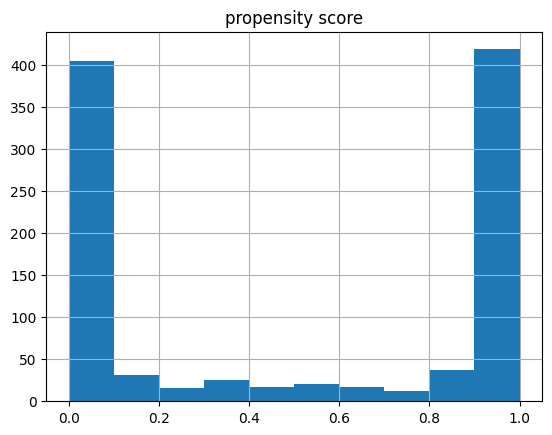

In [62]:
nrep = 10  # Number of repetitions
n_tr = 1000  # Training sample size
n_p = 1000  # Testing sample size
nI = 100  # Different values of nI to iterate through
nX = 5
nO = 5
nS = 10
binary_intervention = True
num_iters = 4000  # Fixed number of training iterations
df_tr = generate_data_causl(n=n_tr, nI=nI, nX=nX, nO=nO, nS=nS, ate=ate, 
                                    beta_cov=beta_cov, strength_instr=strength_instr, 
                                    strength_conf=strength_conf, 
                                    strength_outcome=strength_outcome, 
                                    binary_intervention=binary_intervention)
df_tr['propen'].hist()
plt.title("propensity score")

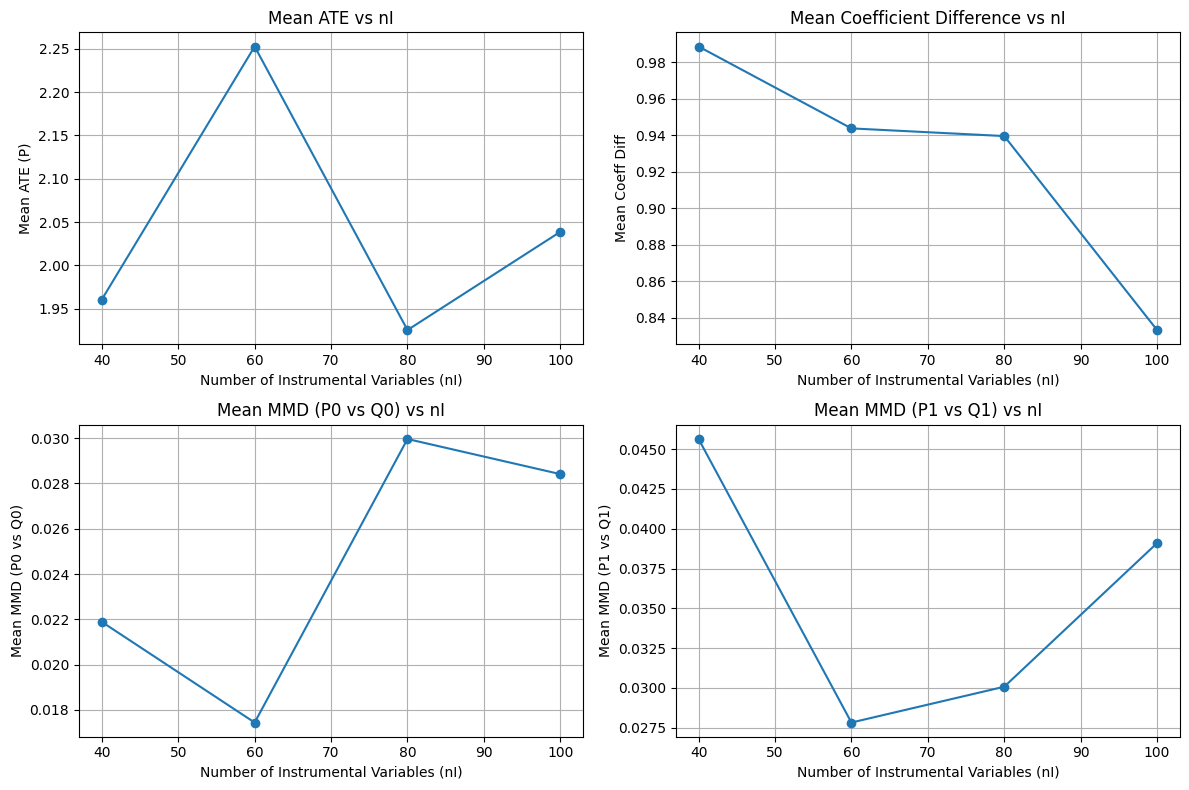

/var/folders/34/4pny9pxj7z31glf0phhx3b280000gn/T/ipykernel_1270/3074661500.py:56: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([tracker[nI]["ate_p"] for nI in nI_values], labels=nI_values, patch_artist=True)
/var/folders/34/4pny9pxj7z31glf0phhx3b280000gn/T/ipykernel_1270/3074661500.py:64: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([tracker[nI]["coeff_diff"] for nI in nI_values], labels=nI_values, patch_artist=True)
/var/folders/34/4pny9pxj7z31glf0phhx3b280000gn/T/ipykernel_1270/3074661500.py:72: MatplotlibDeprecationWarning: The 'labels' parameter of boxplot() has been renamed 'tick_labels' since Matplotlib 3.9; support for the old name will be dropped in 3.11.
  plt.boxplot([tracker[nI]["mmd_p0_q0"] for nI in nI

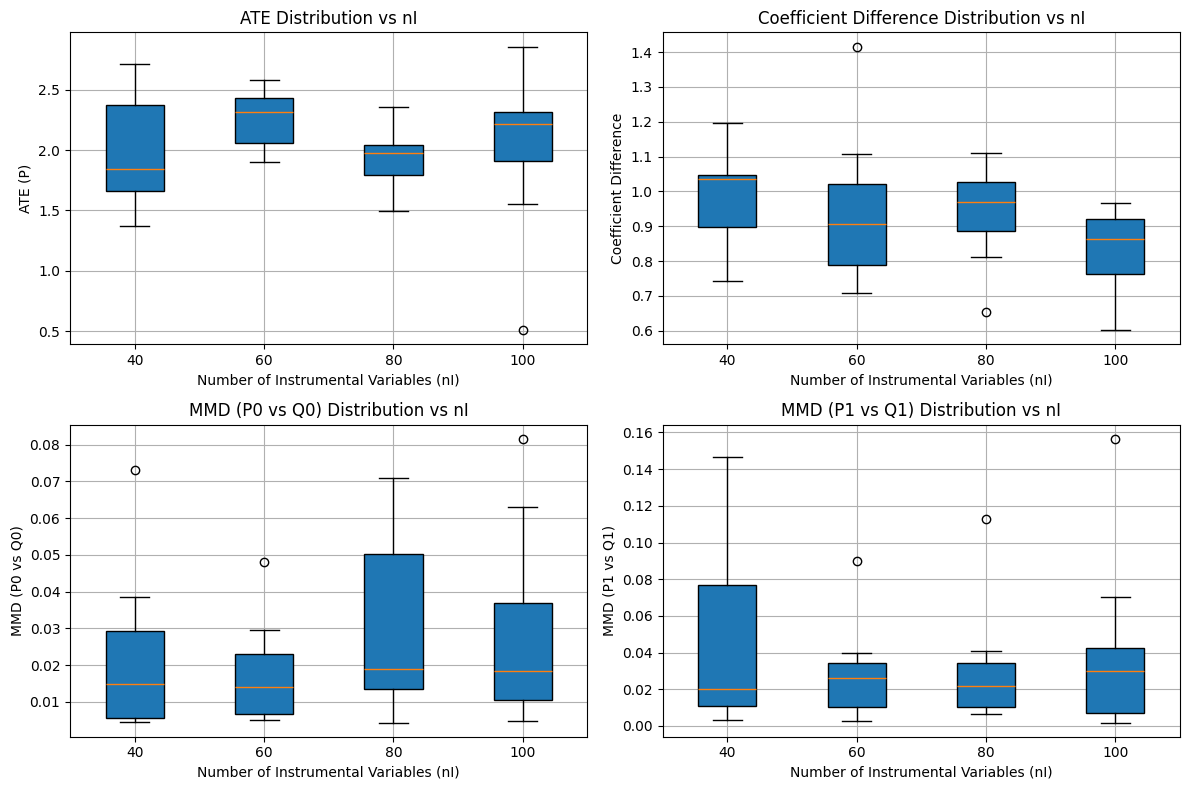

In [8]:
import matplotlib.pyplot as plt
import numpy as np

# Extract data for plotting
nI_values = list(tracker.keys())

# Compute means for each nI
mean_ate_p = [np.mean(tracker[nI]["ate_p"]) for nI in nI_values]
mean_coeff_diff = [np.mean(tracker[nI]["coeff_diff"]) for nI in nI_values]
mean_mmd_p0_q0 = [np.mean(tracker[nI]["mmd_p0_q0"]) for nI in nI_values]
mean_mmd_p1_q1 = [np.mean(tracker[nI]["mmd_p1_q1"]) for nI in nI_values]

# Line plots for means
plt.figure(figsize=(12, 8))

# ATE Plot
plt.subplot(2, 2, 1)
plt.plot(nI_values, mean_ate_p, marker='o', label='Mean ATE (P)')
plt.xlabel('Number of Instrumental Variables (nI)')
plt.ylabel('Mean ATE (P)')
plt.title('Mean ATE vs nI')
plt.grid(True)

# Coefficient Difference Plot
plt.subplot(2, 2, 2)
plt.plot(nI_values, mean_coeff_diff, marker='o', label='Mean Coeff Diff')
plt.xlabel('Number of Instrumental Variables (nI)')
plt.ylabel('Mean Coeff Diff')
plt.title('Mean Coefficient Difference vs nI')
plt.grid(True)

# MMD P0 vs Q0
plt.subplot(2, 2, 3)
plt.plot(nI_values, mean_mmd_p0_q0, marker='o', label='Mean MMD (P0 vs Q0)')
plt.xlabel('Number of Instrumental Variables (nI)')
plt.ylabel('Mean MMD (P0 vs Q0)')
plt.title('Mean MMD (P0 vs Q0) vs nI')
plt.grid(True)

# MMD P1 vs Q1
plt.subplot(2, 2, 4)
plt.plot(nI_values, mean_mmd_p1_q1, marker='o', label='Mean MMD (P1 vs Q1)')
plt.xlabel('Number of Instrumental Variables (nI)')
plt.ylabel('Mean MMD (P1 vs Q1)')
plt.title('Mean MMD (P1 vs Q1) vs nI')
plt.grid(True)

plt.tight_layout()
plt.show()

# Boxplots for Distribution
plt.figure(figsize=(12, 8))

# Boxplot for ATE
plt.subplot(2, 2, 1)
plt.boxplot([tracker[nI]["ate_p"] for nI in nI_values], labels=nI_values, patch_artist=True)
plt.xlabel('Number of Instrumental Variables (nI)')
plt.ylabel('ATE (P)')
plt.title('ATE Distribution vs nI')
plt.grid(True)

# Boxplot for Coefficient Difference
plt.subplot(2, 2, 2)
plt.boxplot([tracker[nI]["coeff_diff"] for nI in nI_values], labels=nI_values, patch_artist=True)
plt.xlabel('Number of Instrumental Variables (nI)')
plt.ylabel('Coefficient Difference')
plt.title('Coefficient Difference Distribution vs nI')
plt.grid(True)

# Boxplot for MMD P0 vs Q0
plt.subplot(2, 2, 3)
plt.boxplot([tracker[nI]["mmd_p0_q0"] for nI in nI_values], labels=nI_values, patch_artist=True)
plt.xlabel('Number of Instrumental Variables (nI)')
plt.ylabel('MMD (P0 vs Q0)')
plt.title('MMD (P0 vs Q0) Distribution vs nI')
plt.grid(True)

# Boxplot for MMD P1 vs Q1
plt.subplot(2, 2, 4)
plt.boxplot([tracker[nI]["mmd_p1_q1"] for nI in nI_values], labels=nI_values, patch_artist=True)
plt.xlabel('Number of Instrumental Variables (nI)')
plt.ylabel('MMD (P1 vs Q1)')
plt.title('MMD (P1 vs Q1) Distribution vs nI')
plt.grid(True)

plt.tight_layout()
plt.show()


# On IHDP

In [2]:
df_train, df_test = process_data(path='/Users/linyingyang/Documents/Project/frengression/frengression/data_causl', trial=0)

In [3]:
df_train

,Z1,Z2,Z3,Z4,Z5,Z6,Z7,Z8,Z9,Z10,...,Z21,Z22,Z23,Z24,Z25,y_factual,treatment,y_cfactual,mu0,mu1
0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,2.0,0.0,0.0,...,0.996346,-1.105624,-0.879606,0.308569,-1.023402,4.771232,1.0,-0.298509,1.164950,5.822879
1,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,0.0,1.0,...,0.196818,0.383828,0.161703,-0.629189,1.460832,2.956273,0.0,5.783770,3.492099,6.920703
2,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,...,1.795874,-1.105624,0.161703,-0.629189,0.963985,4.164164,0.0,7.055789,3.163769,6.821964
3,1.0,0.0,0.0,0.0,0.0,1.0,0.0,2.0,0.0,1.0,...,0.196818,-0.733261,-0.879606,0.371086,-0.692171,6.172307,1.0,1.379697,1.469866,6.055371
4,0.0,1.0,1.0,0.0,0.0,0.0,0.0,2.0,0.0,1.0,...,1.795874,0.011465,-0.879606,0.558638,0.301522,7.834469,1.0,2.747986,2.187257,6.452848
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
667,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.996346,-0.733261,0.161703,0.058500,-1.189018,2.467868,0.0,6.115570,1.477813,6.060763
668,0.0,0.0,1.0,0.0,1.0,0.0,0.0,1.0,0.0,1.0,...,0.996346,-1.850350,1.203011,1.433879,-0.526556,1.490964,0.0,6.969366,1.750110,6.229879
669,1.0,0.0,1.0,1.0,0.0,0.0,0.0,2.0,0.0,1.0,...,-0.602710,0.756191,-0.879606,-1.129327,-0.526556,0.493410,0.0,6.753250,1.570536,6.121617
670,1.0,0.0,1.0,1.0,0.0,0.0,0.0,1.0,0.0,1.0,...,0.596582,-1.477987,1.203011,-0.816741,0.467138,2.732225,0.0,8.252930,2.878175,6.727356


In [5]:
binary_intervention = True
num_iters = 4000  # Fixed number of training iterations
p = 25
z_binary_dims = 19
n_p = 1000
path = '/Users/linyingyang/Documents/Project/frengression/frengression/data_causl'

# Initialize tracker for valid trials
tracker = {}
valid_trials = 0
max_trials = 100  # We want results from 100 valid trials
trial = 0

while valid_trials < max_trials:
    print(f"Checking trial = {trial}")
    df_tr, df_te = process_data(path=path, trial=trial)

    # Skip this trial if any y_factual in df_tr exceeds 40
    if (df_tr['y_factual'] > 20).any():
        print(f"Skipping trial {trial} because y_factual > 20")
        trial += 1
        continue

    print(f"Running on valid trial = {trial}")
    
    # Prepare tensors for training
    z_tr = torch.tensor(df_tr[[f"X{i}" for i in range(1, p + 1)]].values, dtype=torch.float32)
    x_tr = torch.tensor(df_tr['treatment'].values, dtype=torch.int32).view(-1, 1)
    y_tr = torch.tensor(df_tr['y_factual'].values, dtype=torch.float32).view(-1, 1)
    ate_sample = torch.tensor(np.mean(df_tr['mu1'].values-df_tr['mu0']), dtype=torch.float32).view(-1, 1)

    # Initialize model
    model = Frengression(x_tr.shape[1], y_tr.shape[1], z_tr.shape[1], 
                         noise_dim=1, num_layer=3, hidden_dim=400, 
                         device=device, x_binary=binary_intervention, z_binary_dims=0)
    
    z_q = torch.tensor(df_te[[f"X{i}" for i in range(1, p + 1)]].values, dtype=torch.float32)
    x_q = torch.tensor(df_te['treatment'].values, dtype=torch.int32).view(-1, 1)
    y_q = torch.tensor(df_te['y_factual'].values, dtype=torch.float32).view(-1, 1)

    # Ground truth distributions
    Q_joint = torch.cat([x_q, y_q, z_q], dim=1).numpy()

    # Train model for fixed iterations
    model.train_xz(x_tr, z_tr, num_iters=num_iters, lr=1e-4, print_every_iter=400)
    model.train_y(x_tr, z_tr, y_tr, num_iters=num_iters, lr=1e-4, print_every_iter=400)

    # Sample model distributions
    x_gen, y_gen, z_gen = model.sample_joint(sample_size=df_te.shape[0])
    P_joint = torch.cat([x_gen, y_gen, z_gen], dim=1).numpy()

    # Calculate metrics
    mmd_joint = mmd_rbf(P_joint, Q_joint, sigma=1.0)
    ate_p_mean = model.predict_causal(torch.tensor([1], dtype=torch.int32), target="mean", sample_size=1000) - model.predict_causal(torch.tensor([0], dtype=torch.int32), target="mean", sample_size=1000)
    ate_p_median = model.predict_causal(torch.tensor([1], dtype=torch.int32), target="median", sample_size=1000) - model.predict_causal(torch.tensor([0], dtype=torch.int32), target="median", sample_size=1000)

    # Log results for the valid trial
    tracker[valid_trials] = {
        "ate_sample":[ate_sample],
        "ate_p_mean": [ate_p_mean],
        "ate_p_median": [ate_p_median],
        "mmd_joint": [mmd_joint]
    }

    # Increment valid trials counter and move to the next trial
    valid_trials += 1
    trial += 1


Checking trial = 0
Running on valid trial = 0
Epoch 1: loss 3.5425, loss1 3.7771, loss2 0.4691
Epoch 400: loss 2.0733, loss1 4.1343, loss2 4.1220
Epoch 800: loss 2.0694, loss1 4.1303, loss2 4.1219
Epoch 1200: loss 2.0673, loss1 4.1211, loss2 4.1077
Epoch 1600: loss 2.0493, loss1 4.0827, loss2 4.0669
Epoch 2000: loss 2.0350, loss1 4.1370, loss2 4.2040
Epoch 2400: loss 2.0764, loss1 4.1261, loss2 4.0996
Epoch 2800: loss 2.0755, loss1 4.1426, loss2 4.1340
Epoch 3200: loss 2.0577, loss1 4.1559, loss2 4.1964
Epoch 3600: loss 2.0700, loss1 4.1184, loss2 4.0968
Epoch 4000: loss 2.0269, loss1 4.1755, loss2 4.2974
Epoch 1: loss 3.9498,	loss_y 3.1368, 3.1597, 0.0459,	loss_eta 0.8130, 0.8327, 0.0393
Epoch 400: loss 1.8983,	loss_y 1.2072, 1.7868, 1.1591,	loss_eta 0.6911, 0.8721, 0.3620
Epoch 800: loss 1.5795,	loss_y 0.9168, 1.8907, 1.9477,	loss_eta 0.6627, 0.9386, 0.5517
Epoch 1200: loss 1.6201,	loss_y 0.8773, 1.7153, 1.6761,	loss_eta 0.7429, 1.1545, 0.8232
Epoch 1600: loss 1.5209,	loss_y 0.8915, 

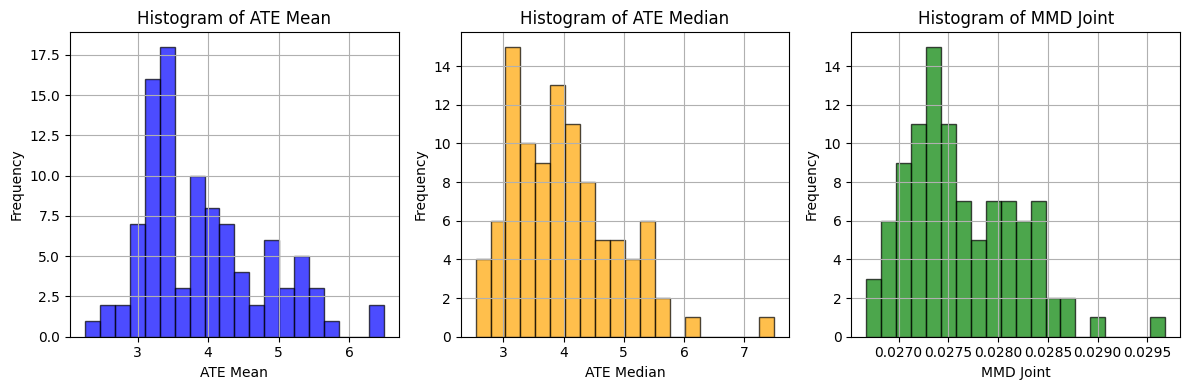

In [7]:
import matplotlib.pyplot as plt
trials = range(100)
# Prepare data for histograms
ate_p_mean_hist = [np.mean(tracker[trial]["ate_p_mean"]) for trial in trials]
ate_p_median_hist = [np.mean(tracker[trial]["ate_p_median"]) for trial in trials]
mmd_joint_hist = [np.mean(tracker[trial]["mmd_joint"]) for trial in trials]

# Histogram for ATE Mean
plt.figure(figsize=(12, 4))

plt.subplot(1, 3, 1)
plt.hist(ate_p_mean_hist, bins=20, alpha=0.7, color='blue', edgecolor='black')
plt.title('Histogram of ATE Mean')
plt.xlabel('ATE Mean')
plt.ylabel('Frequency')
plt.grid(True)

# Histogram for ATE Median
plt.subplot(1, 3, 2)
plt.hist(ate_p_median_hist, bins=20, alpha=0.7, color='orange', edgecolor='black')
plt.title('Histogram of ATE Median')
plt.xlabel('ATE Median')
plt.ylabel('Frequency')
plt.grid(True)

# Histogram for MMD Joint
plt.subplot(1, 3, 3)
plt.hist(mmd_joint_hist, bins=20, alpha=0.7, color='green', edgecolor='black')
plt.title('Histogram of MMD Joint')
plt.xlabel('MMD Joint')
plt.ylabel('Frequency')
plt.grid(True)

plt.tight_layout()
plt.show()


In [8]:
tracker

{0: {'ate_sample': [tensor([[4.0145]])],
  'ate_p_mean': [tensor([[4.9420]])],
  'ate_p_median': [tensor([[5.3352]])],
  'mmd_joint': [0.027368195279594512]},
 1: {'ate_sample': [tensor([[4.0610]])],
  'ate_p_mean': [tensor([[3.2435]])],
  'ate_p_median': [tensor([[3.1608]])],
  'mmd_joint': [0.027358027929159204]},
 2: {'ate_sample': [tensor([[4.1105]])],
  'ate_p_mean': [tensor([[3.7511]])],
  'ate_p_median': [tensor([[3.8204]])],
  'mmd_joint': [0.028194067315511672]},
 3: {'ate_sample': [tensor([[4.2546]])],
  'ate_p_mean': [tensor([[5.5396]])],
  'ate_p_median': [tensor([[6.0256]])],
  'mmd_joint': [0.027410358864389275]},
 4: {'ate_sample': [tensor([[4.1513]])],
  'ate_p_mean': [tensor([[6.4910]])],
  'ate_p_median': [tensor([[7.5041]])],
  'mmd_joint': [0.027395129085900013]},
 5: {'ate_sample': [tensor([[4.0114]])],
  'ate_p_mean': [tensor([[4.2987]])],
  'ate_p_median': [tensor([[4.4657]])],
  'mmd_joint': [0.02700426727050092]},
 6: {'ate_sample': [tensor([[3.9941]])],
  'ate

In [9]:
np.mean(np.abs(np.array(ate_p_mean_hist) - 4))

0.7099025

In [10]:
np.std(np.abs(np.array(ate_p_mean_hist) - 4))

0.48534054

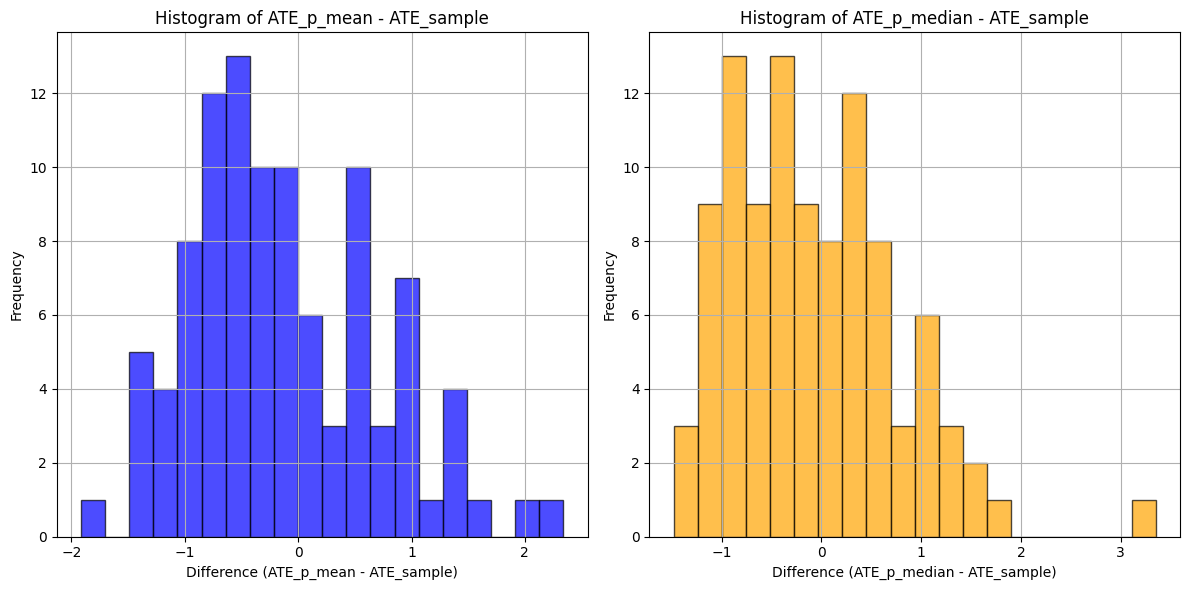

In [11]:
import matplotlib.pyplot as plt
import numpy as np

# Prepare data for histograms
diff_ate_p_mean = [
    float(tracker[trial]["ate_p_mean"][0]) - float(tracker[trial]["ate_sample"][0])
    for trial in tracker.keys()
]
diff_ate_p_median = [
    float(tracker[trial]["ate_p_median"][0]) - float(tracker[trial]["ate_sample"][0])
    for trial in tracker.keys()
]

# Plot histograms
plt.figure(figsize=(12, 6))

# Histogram for ATE Mean - ATE Sample
plt.subplot(1, 2, 1)
plt.hist(diff_ate_p_mean, bins=20, alpha=0.7, color='blue', edgecolor='black')
plt.title('Histogram of ATE_p_mean - ATE_sample')
plt.xlabel('Difference (ATE_p_mean - ATE_sample)')
plt.ylabel('Frequency')
plt.grid(True)

# Histogram for ATE Median - ATE Sample
plt.subplot(1, 2, 2)
plt.hist(diff_ate_p_median, bins=20, alpha=0.7, color='orange', edgecolor='black')
plt.title('Histogram of ATE_p_median - ATE_sample')
plt.xlabel('Difference (ATE_p_median - ATE_sample)')
plt.ylabel('Frequency')
plt.grid(True)

plt.tight_layout()
plt.show()


In [14]:
np.mean(np.abs(np.array(ate_p_median_hist) - 4))

0.686382

# Continuous treatment

## Hirano Imbens et al

In [74]:
nrep = 1 # for equivalence testing
n_tr = 1000
n_p = 1000
num_iters = 4000
binary_intervention=False

P_joint_list = []
Q_joint_list = []
mmd_joint_list = []

# Begin experiment
for rep in tqdm(range(nrep)):
    x,y,z = Sim_Hirano_Imbens_sampler(N=1000,v_dim = 200, seed= 1024,batch_size = n_tr).load_all()
    z_tr = torch.tensor(z, dtype=torch.float32)
    x_tr = torch.tensor(x, dtype=torch.float32)
    y_tr = torch.tensor(y, dtype=torch.float32)

    model = Frengression(x_tr.shape[1], y_tr.shape[1], z_tr.shape[1], 
                         noise_dim=1, num_layer=3, hidden_dim=400, 
                         device=device, x_binary=binary_intervention)
    
    
    x,y,z = Sim_Hirano_Imbens_sampler(N=1000,v_dim = 200, seed= 1024, batch_size=n_tr).load_all()
    z_tr = torch.tensor(z, dtype=torch.float32)
    x_tr = torch.tensor(x, dtype=torch.float32)
    y_tr = torch.tensor(y, dtype=torch.float32)

    model = Frengression(x_tr.shape[1], y_tr.shape[1], z_tr.shape[1], 
                         noise_dim=1, num_layer=3, hidden_dim=400, 
                         device=device, x_binary=binary_intervention)
    
    x,y,z =  Sim_Hirano_Imbens_sampler(N=1000,v_dim = 200, seed= 1024, batch_size=n_tr).load_all()
    z_q = torch.tensor(z, dtype=torch.float32)
    x_q = torch.tensor(x, dtype=torch.float32)
    y_q = torch.tensor(y, dtype=torch.float32)

    Q_joint = torch.cat([x_q, y_q, z_q],dim=1).numpy()  # Ground truth joint distribution (x, y, z)
    Q_joint_list.append(Q_joint)

    # Train model
    model.train_xz(x_tr, z_tr, num_iters= num_iters, lr=1e-4, print_every_iter=400)
    model.train_y(x_tr, z_tr, y_tr, num_iters=num_iters, lr=1e-4, print_every_iter=400)

    x_gen, y_gen, z_gen = model.sample_joint(sample_size=n_p)  # Sample joint distribution (x, y, z)
    P_joint = torch.cat([x_gen, y_gen, z_gen], dim=1).numpy()

    mmd_joint = mmd_rbf(P_joint, Q_joint, sigma=1.0)
    P_joint_list.append(P_joint)
    mmd_joint_list.append(mmd_joint)

PJoints = np.stack(P_joint_list, axis=0)
QJoints = np.stack(Q_joint_list, axis=0)


  0%|          | 0/1 [00:00<?, ?it/s]

Epoch 1: loss 13.6345, loss1 14.3197, loss2 1.3703
Epoch 400: loss 10.1132, loss1 19.8422, loss2 19.4580
Epoch 800: loss 10.2281, loss1 19.9428, loss2 19.4293
Epoch 1200: loss 10.0918, loss1 19.9533, loss2 19.7230
Epoch 1600: loss 10.1339, loss1 20.0136, loss2 19.7594
Epoch 2000: loss 10.1441, loss1 19.9971, loss2 19.7060
Epoch 2400: loss 10.1669, loss1 20.0468, loss2 19.7600
Epoch 2800: loss 10.1417, loss1 19.9941, loss2 19.7047
Epoch 3200: loss 10.1083, loss1 20.0328, loss2 19.8490
Epoch 3600: loss 10.1122, loss1 20.0087, loss2 19.7930
Epoch 4000: loss 10.1526, loss1 20.1154, loss2 19.9256
Epoch 1: loss 2.6295,	loss_y 1.8747, 1.8968, 0.0442,	loss_eta 0.7548, 0.7966, 0.0836
Epoch 400: loss 1.6620,	loss_y 1.0838, 1.2995, 0.4314,	loss_eta 0.5782, 1.3160, 1.4757
Epoch 800: loss 1.5135,	loss_y 0.8487, 1.3849, 1.0724,	loss_eta 0.6648, 1.9099, 2.4902
Epoch 1200: loss 1.3135,	loss_y 0.7346, 1.3228, 1.1763,	loss_eta 0.5789, 1.0915, 1.0253
Epoch 1600: loss 1.1781,	loss_y 0.6153, 1.1024, 0.9742

100%|██████████| 1/1 [01:52<00:00, 112.94s/it]

Epoch 4000: loss 0.9981,	loss_y 0.4115, 0.7451, 0.6671,	loss_eta 0.5865, 1.4443, 1.7155


In [85]:

params = {"dataset": "Sim_Hirano_Imbens",
"output_dir": './',
'v_dim': 200,
"z_dims": [1,1,1,7],
"x_min": 0,
"x_max": 3,
"lr": 0.0002,
"bs": 32,
"alpha": 1,
"beta": 1,
"gamma": 10,
"g_d_freq": 5,
"g_units": [64,64,64,64,64],
"e_units": [64,64,64,64,64],
"f_units": [64,32,8],
"h_units": [64,32,8],
"dz_units": [64,32,8],
"dv_units": [64,32,8],
"binary_treatment": False,
"use_z_rec": True,
"use_v_gan": False,
"save_res": False,
"save_model": False,}

  0%|          | 0/30 [00:00<?, ?it/s]

Epoch 1: loss 13.6361, loss1 14.3224, loss2 1.3724
Epoch 400: loss 10.3141, loss1 19.7917, loss2 18.9550
Epoch 800: loss 10.2601, loss1 19.9472, loss2 19.3744
Epoch 1200: loss 10.2547, loss1 19.9971, loss2 19.4849
Epoch 1600: loss 10.1489, loss1 20.0457, loss2 19.7935
Epoch 2000: loss 10.1850, loss1 20.0695, loss2 19.7690
Epoch 1: loss 2.7875,	loss_y 1.9880, 2.0003, 0.0246,	loss_eta 0.7995, 0.8357, 0.0723
Epoch 400: loss 1.6555,	loss_y 0.9845, 1.4111, 0.8532,	loss_eta 0.6709, 1.3696, 1.3973
Epoch 800: loss 1.6126,	loss_y 0.9431, 2.0804, 2.2744,	loss_eta 0.6694, 1.6136, 1.8883
Epoch 1200: loss 1.4326,	loss_y 0.8230, 2.0276, 2.4092,	loss_eta 0.6096, 1.0240, 0.8288
Epoch 1600: loss 1.3105,	loss_y 0.7358, 1.0203, 0.5690,	loss_eta 0.5747, 1.0812, 1.0130
Epoch 2000: loss 1.2555,	loss_y 0.6673, 1.1140, 0.8932,	loss_eta 0.5882, 1.2399, 1.3035


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_176', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_177', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line

Epoch 1: loss 13.5823, loss1 14.2751, loss2 1.3856
Epoch 400: loss 10.3692, loss1 19.8315, loss2 18.9246
Epoch 800: loss 10.2450, loss1 19.9444, loss2 19.3990
Epoch 1200: loss 10.1625, loss1 19.9463, loss2 19.5676
Epoch 1600: loss 10.1639, loss1 19.9379, loss2 19.5480
Epoch 2000: loss 10.1499, loss1 19.9461, loss2 19.5924
Epoch 1: loss 2.7291,	loss_y 1.9625, 1.9827, 0.0402,	loss_eta 0.7666, 0.8089, 0.0848
Epoch 400: loss 1.5308,	loss_y 0.9149, 1.3419, 0.8540,	loss_eta 0.6159, 1.0215, 0.8112
Epoch 800: loss 1.4777,	loss_y 0.8342, 1.4992, 1.3301,	loss_eta 0.6435, 0.9506, 0.6143
Epoch 1200: loss 1.5756,	loss_y 0.8960, 2.0782, 2.3644,	loss_eta 0.6796, 1.8038, 2.2485
Epoch 1600: loss 1.4430,	loss_y 0.7696, 1.9231, 2.3070,	loss_eta 0.6733, 0.9534, 0.5602
Epoch 2000: loss 1.3484,	loss_y 0.6707, 1.1151, 0.8889,	loss_eta 0.6777, 1.2006, 1.0457


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_180', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_181', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line

Epoch 1: loss 13.6475, loss1 14.3207, loss2 1.3464
Epoch 400: loss 10.2834, loss1 19.7588, loss2 18.9508
Epoch 800: loss 10.1072, loss1 19.9761, loss2 19.7379
Epoch 1200: loss 10.2677, loss1 20.1147, loss2 19.6941
Epoch 1600: loss 10.1936, loss1 20.0717, loss2 19.7562
Epoch 2000: loss 10.2094, loss1 19.9779, loss2 19.5371
Epoch 1: loss 2.7664,	loss_y 2.0264, 2.0396, 0.0264,	loss_eta 0.7400, 0.7720, 0.0640
Epoch 400: loss 1.6938,	loss_y 1.1220, 1.4077, 0.5715,	loss_eta 0.5718, 0.9917, 0.8397
Epoch 800: loss 1.3857,	loss_y 0.7214, 1.1601, 0.8774,	loss_eta 0.6644, 0.8587, 0.3888
Epoch 1200: loss 1.6148,	loss_y 1.0315, 2.6174, 3.1719,	loss_eta 0.5833, 1.4136, 1.6607
Epoch 1600: loss 1.3550,	loss_y 0.7589, 2.0168, 2.5160,	loss_eta 0.5961, 0.9145, 0.6367
Epoch 2000: loss 1.4036,	loss_y 0.7740, 1.7637, 1.9794,	loss_eta 0.6296, 1.7489, 2.2387


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_184', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_185', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line

Epoch 1: loss 13.6068, loss1 14.2893, loss2 1.3652
Epoch 400: loss 10.1849, loss1 19.7995, loss2 19.2292
Epoch 800: loss 10.1798, loss1 19.9259, loss2 19.4923
Epoch 1200: loss 10.1495, loss1 19.9475, loss2 19.5960
Epoch 1600: loss 10.1087, loss1 19.9917, loss2 19.7660
Epoch 2000: loss 10.0639, loss1 19.9414, loss2 19.7551
Epoch 1: loss 2.7588,	loss_y 2.0139, 2.0470, 0.0661,	loss_eta 0.7449, 0.7880, 0.0862
Epoch 400: loss 1.4691,	loss_y 0.8844, 1.3732, 0.9775,	loss_eta 0.5846, 1.0826, 0.9960
Epoch 800: loss 1.5693,	loss_y 0.9925, 2.3778, 2.7707,	loss_eta 0.5768, 1.3466, 1.5395
Epoch 1200: loss 1.8064,	loss_y 1.2190, 1.4553, 0.4725,	loss_eta 0.5874, 1.1612, 1.1477
Epoch 1600: loss 1.3440,	loss_y 0.6790, 1.3891, 1.4203,	loss_eta 0.6650, 0.9229, 0.5158
Epoch 2000: loss 1.3976,	loss_y 0.6521, 1.2150, 1.1257,	loss_eta 0.7455, 1.1267, 0.7625


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_188', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_189', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line

Epoch 1: loss 13.6143, loss1 14.3081, loss2 1.3875
Epoch 400: loss 10.1778, loss1 19.6761, loss2 18.9966
Epoch 800: loss 10.1821, loss1 19.9193, loss2 19.4743
Epoch 1200: loss 10.1977, loss1 19.9994, loss2 19.6033
Epoch 1600: loss 10.1754, loss1 19.9700, loss2 19.5892
Epoch 2000: loss 10.1211, loss1 20.0047, loss2 19.7673
Epoch 1: loss 2.7627,	loss_y 1.9997, 2.0086, 0.0178,	loss_eta 0.7630, 0.8012, 0.0765
Epoch 400: loss 1.4340,	loss_y 0.8633, 1.3295, 0.9323,	loss_eta 0.5707, 1.1744, 1.2075
Epoch 800: loss 1.3825,	loss_y 0.6895, 1.5636, 1.7482,	loss_eta 0.6930, 0.8448, 0.3035
Epoch 1200: loss 1.5998,	loss_y 0.9893, 2.6214, 3.2641,	loss_eta 0.6105, 0.9001, 0.5791
Epoch 1600: loss 1.2078,	loss_y 0.6294, 1.3929, 1.5270,	loss_eta 0.5784, 1.1459, 1.1351
Epoch 2000: loss 1.2867,	loss_y 0.6475, 1.3292, 1.3635,	loss_eta 0.6392, 0.9749, 0.6713


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_192', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_193', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line

Epoch 1: loss 13.5787, loss1 14.2789, loss2 1.4003
Epoch 400: loss 10.2014, loss1 19.7561, loss2 19.1093
Epoch 800: loss 10.0839, loss1 19.9310, loss2 19.6942
Epoch 1200: loss 10.0990, loss1 19.9487, loss2 19.6993
Epoch 1600: loss 10.1326, loss1 19.9228, loss2 19.5804
Epoch 2000: loss 10.1122, loss1 19.9723, loss2 19.7202
Epoch 1: loss 2.5675,	loss_y 1.8378, 1.8502, 0.0247,	loss_eta 0.7297, 0.7678, 0.0761
Epoch 400: loss 1.5207,	loss_y 0.9710, 1.3074, 0.6729,	loss_eta 0.5498, 1.2804, 1.4613
Epoch 800: loss 1.5568,	loss_y 0.8777, 2.3182, 2.8810,	loss_eta 0.6791, 0.9789, 0.5996
Epoch 1200: loss 1.3251,	loss_y 0.7018, 1.6734, 1.9432,	loss_eta 0.6233, 0.9355, 0.6244
Epoch 1600: loss 1.3362,	loss_y 0.7651, 2.0049, 2.4796,	loss_eta 0.5711, 1.3590, 1.5758
Epoch 2000: loss 1.3593,	loss_y 0.7084, 1.3880, 1.3591,	loss_eta 0.6509, 1.3007, 1.2996


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_196', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_197', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line

Epoch 1: loss 13.6196, loss1 14.3301, loss2 1.4211
Epoch 400: loss 10.2116, loss1 19.8708, loss2 19.3183
Epoch 800: loss 10.2131, loss1 19.8978, loss2 19.3694
Epoch 1200: loss 10.1521, loss1 19.9954, loss2 19.6868
Epoch 1600: loss 10.1169, loss1 19.9930, loss2 19.7522
Epoch 2000: loss 10.1422, loss1 20.0202, loss2 19.7561
Epoch 1: loss 2.7163,	loss_y 1.9399, 1.9463, 0.0128,	loss_eta 0.7764, 0.8161, 0.0794
Epoch 400: loss 1.5527,	loss_y 0.9642, 1.2222, 0.5159,	loss_eta 0.5885, 1.1678, 1.1586
Epoch 800: loss 1.4165,	loss_y 0.7464, 1.6797, 1.8667,	loss_eta 0.6702, 0.9621, 0.5838
Epoch 1200: loss 1.6095,	loss_y 1.0452, 1.5703, 1.0502,	loss_eta 0.5643, 1.1956, 1.2627
Epoch 1600: loss 1.3192,	loss_y 0.6999, 1.1590, 0.9183,	loss_eta 0.6194, 0.9622, 0.6857
Epoch 2000: loss 1.2796,	loss_y 0.6737, 1.2144, 1.0814,	loss_eta 0.6059, 1.4990, 1.7862


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_200', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_201', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line

Epoch 1: loss 13.6389, loss1 14.3060, loss2 1.3341
Epoch 400: loss 10.2175, loss1 19.9062, loss2 19.3774
Epoch 800: loss 10.1892, loss1 19.9917, loss2 19.6050
Epoch 1200: loss 10.1960, loss1 19.9418, loss2 19.4915
Epoch 1600: loss 10.1489, loss1 20.0423, loss2 19.7867
Epoch 2000: loss 10.1046, loss1 20.1219, loss2 20.0345
Epoch 1: loss 2.7598,	loss_y 2.0084, 2.0250, 0.0331,	loss_eta 0.7514, 0.7916, 0.0803
Epoch 400: loss 1.8071,	loss_y 1.2531, 1.4188, 0.3313,	loss_eta 0.5540, 1.2033, 1.2985
Epoch 800: loss 1.7118,	loss_y 0.9059, 1.5496, 1.2874,	loss_eta 0.8059, 2.0048, 2.3977
Epoch 1200: loss 1.2454,	loss_y 0.6829, 1.1477, 0.9296,	loss_eta 0.5626, 1.2678, 1.4104
Epoch 1600: loss 1.1505,	loss_y 0.5518, 1.3317, 1.5598,	loss_eta 0.5987, 1.1005, 1.0036
Epoch 2000: loss 1.1010,	loss_y 0.5240, 1.1932, 1.3383,	loss_eta 0.5770, 1.2328, 1.3118


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_204', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_205', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line

Epoch 1: loss 13.7061, loss1 14.3964, loss2 1.3805
Epoch 400: loss 10.3730, loss1 19.9113, loss2 19.0767
Epoch 800: loss 10.2830, loss1 20.0608, loss2 19.5556
Epoch 1200: loss 10.2099, loss1 20.0715, loss2 19.7232
Epoch 1600: loss 10.2439, loss1 20.1089, loss2 19.7300
Epoch 2000: loss 10.1690, loss1 20.1103, loss2 19.8826
Epoch 1: loss 2.7736,	loss_y 2.0112, 2.0383, 0.0541,	loss_eta 0.7624, 0.8027, 0.0806
Epoch 400: loss 1.6830,	loss_y 1.1012, 1.4101, 0.6179,	loss_eta 0.5818, 1.3548, 1.5459
Epoch 800: loss 1.4501,	loss_y 0.7780, 1.2194, 0.8828,	loss_eta 0.6720, 1.2091, 1.0741
Epoch 1200: loss 1.7782,	loss_y 1.1946, 1.5232, 0.6572,	loss_eta 0.5836, 1.4840, 1.8008
Epoch 1600: loss 1.4859,	loss_y 0.8071, 1.4569, 1.2996,	loss_eta 0.6787, 1.3759, 1.3943
Epoch 2000: loss 1.2050,	loss_y 0.5862, 1.0359, 0.8994,	loss_eta 0.6188, 0.9589, 0.6802


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_208', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_209', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line

Epoch 1: loss 13.6344, loss1 14.3389, loss2 1.4090
Epoch 400: loss 10.1865, loss1 19.8477, loss2 19.3223
Epoch 800: loss 10.3185, loss1 19.9447, loss2 19.2524
Epoch 1200: loss 10.1481, loss1 20.0118, loss2 19.7275
Epoch 1600: loss 10.1852, loss1 20.0637, loss2 19.7569
Epoch 2000: loss 10.1745, loss1 20.0497, loss2 19.7504
Epoch 1: loss 2.7064,	loss_y 1.9668, 1.9798, 0.0259,	loss_eta 0.7396, 0.7769, 0.0747
Epoch 400: loss 1.6537,	loss_y 1.0574, 1.3810, 0.6472,	loss_eta 0.5963, 1.1859, 1.1793
Epoch 800: loss 1.6644,	loss_y 0.9778, 1.9860, 2.0162,	loss_eta 0.6866, 0.8937, 0.4143
Epoch 1200: loss 1.4277,	loss_y 0.8862, 2.0057, 2.2389,	loss_eta 0.5415, 1.1105, 1.1380
Epoch 1600: loss 1.3227,	loss_y 0.6880, 1.4928, 1.6095,	loss_eta 0.6346, 1.2061, 1.1429
Epoch 2000: loss 1.1595,	loss_y 0.5914, 1.0788, 0.9747,	loss_eta 0.5681, 1.4148, 1.6934


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_212', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_213', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line

Epoch 1: loss 13.8666, loss1 14.5382, loss2 1.3432
Epoch 400: loss 10.5379, loss1 20.0727, loss2 19.0695
Epoch 800: loss 10.4379, loss1 20.1789, loss2 19.4820
Epoch 1200: loss 10.4366, loss1 20.1931, loss2 19.5128
Epoch 1600: loss 10.3037, loss1 20.2844, loss2 19.9614
Epoch 2000: loss 10.3255, loss1 20.2621, loss2 19.8731
Epoch 1: loss 2.8998,	loss_y 2.1538, 2.1705, 0.0333,	loss_eta 0.7460, 0.7856, 0.0792
Epoch 400: loss 1.7725,	loss_y 1.1753, 1.5455, 0.7403,	loss_eta 0.5972, 1.3592, 1.5241
Epoch 800: loss 1.7661,	loss_y 1.0965, 2.6747, 3.1565,	loss_eta 0.6696, 1.0616, 0.7839
Epoch 1200: loss 1.5546,	loss_y 0.8894, 1.3542, 0.9297,	loss_eta 0.6652, 0.9613, 0.5921
Epoch 1600: loss 1.4853,	loss_y 0.8744, 1.6202, 1.4917,	loss_eta 0.6109, 1.3082, 1.3947
Epoch 2000: loss 1.5334,	loss_y 0.8789, 1.3137, 0.8696,	loss_eta 0.6545, 1.0344, 0.7599


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_216', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_217', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line

Epoch 1: loss 13.6896, loss1 14.3740, loss2 1.3687
Epoch 400: loss 10.2544, loss1 19.8593, loss2 19.2097
Epoch 800: loss 10.1816, loss1 20.0184, loss2 19.6735
Epoch 1200: loss 10.1741, loss1 20.0738, loss2 19.7993
Epoch 1600: loss 10.2437, loss1 20.1326, loss2 19.7780
Epoch 2000: loss 10.1931, loss1 19.9401, loss2 19.4938
Epoch 1: loss 2.8771,	loss_y 2.1170, 2.1384, 0.0429,	loss_eta 0.7601, 0.7975, 0.0749
Epoch 400: loss 1.5046,	loss_y 0.7577, 1.1919, 0.8684,	loss_eta 0.7469, 1.2101, 0.9264
Epoch 800: loss 1.5294,	loss_y 0.9121, 1.5754, 1.3266,	loss_eta 0.6173, 1.0802, 0.9258
Epoch 1200: loss 1.1715,	loss_y 0.5399, 1.6668, 2.2538,	loss_eta 0.6316, 0.8799, 0.4966
Epoch 1600: loss 1.3297,	loss_y 0.7503, 1.7780, 2.0555,	loss_eta 0.5794, 1.2632, 1.3677
Epoch 2000: loss 1.1346,	loss_y 0.5043, 1.2038, 1.3990,	loss_eta 0.6303, 0.9751, 0.6895


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_220', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_221', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line

Epoch 1: loss 13.6483, loss1 14.3212, loss2 1.3458
Epoch 400: loss 10.2131, loss1 19.8525, loss2 19.2787
Epoch 800: loss 10.1490, loss1 19.9371, loss2 19.5762
Epoch 1200: loss 10.1914, loss1 19.9517, loss2 19.5205
Epoch 1600: loss 10.1231, loss1 19.9955, loss2 19.7449
Epoch 2000: loss 10.2023, loss1 20.0425, loss2 19.6805
Epoch 1: loss 2.7725,	loss_y 2.0265, 2.0401, 0.0272,	loss_eta 0.7460, 0.7855, 0.0790
Epoch 400: loss 1.6613,	loss_y 1.0615, 1.4464, 0.7698,	loss_eta 0.5998, 1.1744, 1.1492
Epoch 800: loss 1.6319,	loss_y 1.0363, 2.2977, 2.5227,	loss_eta 0.5956, 1.1567, 1.1222
Epoch 1200: loss 1.3261,	loss_y 0.6567, 1.6647, 2.0159,	loss_eta 0.6694, 1.2848, 1.2310
Epoch 1600: loss 1.3119,	loss_y 0.7275, 1.0873, 0.7196,	loss_eta 0.5844, 1.3351, 1.5015
Epoch 2000: loss 1.1814,	loss_y 0.5558, 1.1823, 1.2531,	loss_eta 0.6256, 1.4203, 1.5894


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_224', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_225', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line

Epoch 1: loss 13.6199, loss1 14.2968, loss2 1.3537
Epoch 400: loss 10.2433, loss1 19.8397, loss2 19.1928
Epoch 800: loss 10.1473, loss1 19.9881, loss2 19.6816
Epoch 1200: loss 10.2269, loss1 19.9680, loss2 19.4822
Epoch 1600: loss 10.1662, loss1 20.0092, loss2 19.6861
Epoch 2000: loss 10.0997, loss1 20.0152, loss2 19.8311
Epoch 1: loss 2.7219,	loss_y 1.9275, 1.9671, 0.0793,	loss_eta 0.7944, 0.8312, 0.0735
Epoch 400: loss 1.4902,	loss_y 0.9294, 1.2583, 0.6578,	loss_eta 0.5608, 1.1084, 1.0951
Epoch 800: loss 1.3985,	loss_y 0.7188, 1.4601, 1.4826,	loss_eta 0.6798, 0.8978, 0.4361
Epoch 1200: loss 1.3030,	loss_y 0.6638, 1.2375, 1.1473,	loss_eta 0.6392, 1.3937, 1.5092
Epoch 1600: loss 1.2784,	loss_y 0.6024, 1.3686, 1.5323,	loss_eta 0.6759, 0.8797, 0.4075
Epoch 2000: loss 1.3353,	loss_y 0.6930, 1.3604, 1.3348,	loss_eta 0.6423, 1.0397, 0.7949


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_228', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_229', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line

Epoch 1: loss 13.6122, loss1 14.3006, loss2 1.3768
Epoch 400: loss 10.2612, loss1 19.7422, loss2 18.9621
Epoch 800: loss 10.2001, loss1 19.8578, loss2 19.3155
Epoch 1200: loss 10.1357, loss1 19.9491, loss2 19.6268
Epoch 1600: loss 10.1161, loss1 19.9987, loss2 19.7652
Epoch 2000: loss 10.1831, loss1 19.9499, loss2 19.5336
Epoch 1: loss 2.7367,	loss_y 1.9591, 1.9725, 0.0268,	loss_eta 0.7776, 0.8144, 0.0735
Epoch 400: loss 1.4003,	loss_y 0.7824, 1.1956, 0.8263,	loss_eta 0.6179, 1.0584, 0.8809
Epoch 800: loss 1.8899,	loss_y 1.1983, 1.7933, 1.1901,	loss_eta 0.6916, 1.2811, 1.1790
Epoch 1200: loss 1.4436,	loss_y 0.7668, 1.3067, 1.0798,	loss_eta 0.6769, 0.8247, 0.2957
Epoch 1600: loss 1.2259,	loss_y 0.6425, 1.3217, 1.3584,	loss_eta 0.5834, 1.1240, 1.0812
Epoch 2000: loss 1.2478,	loss_y 0.6623, 1.2082, 1.0918,	loss_eta 0.5855, 1.2372, 1.3034


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_232', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_233', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line

Epoch 1: loss 13.5472, loss1 14.2514, loss2 1.4083
Epoch 400: loss 10.1429, loss1 19.7852, loss2 19.2847
Epoch 800: loss 10.1096, loss1 19.8258, loss2 19.4325
Epoch 1200: loss 10.1068, loss1 19.9193, loss2 19.6248
Epoch 1600: loss 10.1356, loss1 19.8563, loss2 19.4414
Epoch 2000: loss 10.0635, loss1 19.9726, loss2 19.8182
Epoch 1: loss 2.5771,	loss_y 1.7975, 1.8125, 0.0299,	loss_eta 0.7795, 0.8164, 0.0738
Epoch 400: loss 1.4447,	loss_y 0.8487, 1.4435, 1.1898,	loss_eta 0.5960, 1.0820, 0.9719
Epoch 800: loss 1.5196,	loss_y 0.9320, 2.4853, 3.1068,	loss_eta 0.5877, 1.0691, 0.9629
Epoch 1200: loss 1.5181,	loss_y 0.8112, 1.3470, 1.0716,	loss_eta 0.7069, 1.1660, 0.9182
Epoch 1600: loss 1.4042,	loss_y 0.6917, 1.4217, 1.4600,	loss_eta 0.7125, 1.1652, 0.9055
Epoch 2000: loss 1.3548,	loss_y 0.6763, 1.2397, 1.1269,	loss_eta 0.6785, 0.7991, 0.2411


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_236', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_237', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line

Epoch 1: loss 13.6480, loss1 14.3043, loss2 1.3126
Epoch 400: loss 10.2482, loss1 19.9334, loss2 19.3704
Epoch 800: loss 10.2341, loss1 20.0254, loss2 19.5826
Epoch 1200: loss 10.1409, loss1 19.9568, loss2 19.6318
Epoch 1600: loss 10.1411, loss1 19.9902, loss2 19.6982
Epoch 2000: loss 10.1262, loss1 20.0692, loss2 19.8860
Epoch 1: loss 2.6202,	loss_y 1.8910, 1.9288, 0.0757,	loss_eta 0.7293, 0.7688, 0.0792
Epoch 400: loss 1.5389,	loss_y 0.8812, 1.3763, 0.9900,	loss_eta 0.6577, 1.0549, 0.7943
Epoch 800: loss 1.3148,	loss_y 0.7315, 1.4464, 1.4298,	loss_eta 0.5833, 0.9949, 0.8232
Epoch 1200: loss 1.3519,	loss_y 0.6788, 1.5049, 1.6522,	loss_eta 0.6731, 1.2447, 1.1431
Epoch 1600: loss 1.4346,	loss_y 0.6881, 1.1165, 0.8567,	loss_eta 0.7465, 1.3748, 1.2566
Epoch 2000: loss 1.2056,	loss_y 0.5830, 1.1581, 1.1501,	loss_eta 0.6226, 1.2338, 1.2223


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_240', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_241', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line

Epoch 1: loss 13.5883, loss1 14.2723, loss2 1.3679
Epoch 400: loss 10.1763, loss1 19.7032, loss2 19.0538
Epoch 800: loss 10.0888, loss1 19.9084, loss2 19.6392
Epoch 1200: loss 10.0781, loss1 19.9363, loss2 19.7165
Epoch 1600: loss 10.1113, loss1 19.9445, loss2 19.6664
Epoch 2000: loss 10.0722, loss1 20.0047, loss2 19.8650
Epoch 1: loss 2.6714,	loss_y 1.9185, 1.9348, 0.0327,	loss_eta 0.7529, 0.7966, 0.0873
Epoch 400: loss 1.6401,	loss_y 0.9507, 1.3358, 0.7701,	loss_eta 0.6894, 1.5461, 1.7134
Epoch 800: loss 1.4914,	loss_y 0.8414, 1.8902, 2.0975,	loss_eta 0.6500, 0.9157, 0.5314
Epoch 1200: loss 1.6612,	loss_y 0.9937, 1.2217, 0.4560,	loss_eta 0.6675, 1.6763, 2.0177
Epoch 1600: loss 1.5459,	loss_y 0.9201, 1.2898, 0.7394,	loss_eta 0.6257, 0.8960, 0.5405
Epoch 2000: loss 1.3999,	loss_y 0.7534, 2.0170, 2.5271,	loss_eta 0.6465, 1.7676, 2.2423


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_244', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_245', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line

Epoch 1: loss 14.3821, loss1 15.0714, loss2 1.3786
Epoch 400: loss 10.9965, loss1 20.6083, loss2 19.2236
Epoch 800: loss 11.0106, loss1 20.6492, loss2 19.2773
Epoch 1200: loss 10.8412, loss1 20.7003, loss2 19.7182
Epoch 1600: loss 10.7921, loss1 20.7074, loss2 19.8306
Epoch 2000: loss 10.8747, loss1 20.8181, loss2 19.8867
Epoch 1: loss 3.5280,	loss_y 2.7667, 2.7761, 0.0187,	loss_eta 0.7612, 0.8034, 0.0843
Epoch 400: loss 2.2344,	loss_y 1.5554, 1.9341, 0.7573,	loss_eta 0.6790, 1.8549, 2.3517
Epoch 800: loss 1.5697,	loss_y 0.9801, 1.8019, 1.6437,	loss_eta 0.5896, 1.5861, 1.9928
Epoch 1200: loss 1.5104,	loss_y 0.8593, 1.7177, 1.7169,	loss_eta 0.6511, 0.9965, 0.6908
Epoch 1600: loss 1.5677,	loss_y 0.9759, 1.8340, 1.7163,	loss_eta 0.5918, 1.6220, 2.0603
Epoch 2000: loss 1.4753,	loss_y 0.8616, 1.2100, 0.6968,	loss_eta 0.6137, 1.3078, 1.3881


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_248', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_249', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line

Epoch 1: loss 13.5779, loss1 14.2749, loss2 1.3940
Epoch 400: loss 10.2977, loss1 19.8426, loss2 19.0898
Epoch 800: loss 10.2327, loss1 19.8186, loss2 19.1717
Epoch 1200: loss 10.0941, loss1 19.9496, loss2 19.7110
Epoch 1600: loss 10.1602, loss1 20.0160, loss2 19.7116
Epoch 2000: loss 10.0728, loss1 19.9506, loss2 19.7557
Epoch 1: loss 2.6450,	loss_y 1.8870, 1.8949, 0.0158,	loss_eta 0.7580, 0.7962, 0.0764
Epoch 400: loss 1.6133,	loss_y 1.0173, 1.3494, 0.6642,	loss_eta 0.5959, 1.2575, 1.3231
Epoch 800: loss 1.3585,	loss_y 0.7750, 1.8109, 2.0718,	loss_eta 0.5836, 1.0307, 0.8943
Epoch 1200: loss 1.2120,	loss_y 0.5977, 1.1154, 1.0354,	loss_eta 0.6143, 1.3653, 1.5021
Epoch 1600: loss 1.1935,	loss_y 0.5655, 1.0778, 1.0246,	loss_eta 0.6280, 1.0609, 0.8657
Epoch 2000: loss 1.3058,	loss_y 0.6572, 1.0981, 0.8818,	loss_eta 0.6486, 1.0518, 0.8065


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_252', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_253', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line

Epoch 1: loss 13.6028, loss1 14.2809, loss2 1.3561
Epoch 400: loss 10.2104, loss1 19.7831, loss2 19.1453
Epoch 800: loss 10.1026, loss1 19.9014, loss2 19.5976
Epoch 1200: loss 10.1314, loss1 19.9079, loss2 19.5530
Epoch 1600: loss 10.0803, loss1 19.9142, loss2 19.6677
Epoch 2000: loss 10.0602, loss1 20.0292, loss2 19.9381
Epoch 1: loss 2.7359,	loss_y 1.9935, 2.0261, 0.0652,	loss_eta 0.7424, 0.7819, 0.0789
Epoch 400: loss 1.5459,	loss_y 0.9543, 1.3546, 0.8007,	loss_eta 0.5916, 1.4320, 1.6807
Epoch 800: loss 1.9970,	loss_y 1.3220, 3.5083, 4.3725,	loss_eta 0.6750, 0.9257, 0.5014
Epoch 1200: loss 1.3057,	loss_y 0.6787, 1.4960, 1.6346,	loss_eta 0.6270, 1.3322, 1.4104
Epoch 1600: loss 1.4069,	loss_y 0.8222, 1.5356, 1.4269,	loss_eta 0.5848, 1.0327, 0.8959
Epoch 2000: loss 1.4001,	loss_y 0.8015, 1.6021, 1.6012,	loss_eta 0.5986, 1.1488, 1.1003


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_256', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_257', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line

Epoch 1: loss 13.6084, loss1 14.2967, loss2 1.3765
Epoch 400: loss 10.3166, loss1 19.8287, loss2 19.0242
Epoch 800: loss 10.1469, loss1 19.9017, loss2 19.5097
Epoch 1200: loss 10.1007, loss1 19.8908, loss2 19.5802
Epoch 1600: loss 10.1178, loss1 19.9418, loss2 19.6479
Epoch 2000: loss 10.1441, loss1 20.0372, loss2 19.7862
Epoch 1: loss 2.6120,	loss_y 1.8723, 1.8911, 0.0377,	loss_eta 0.7397, 0.7819, 0.0844
Epoch 400: loss 1.7377,	loss_y 1.1180, 1.4673, 0.6986,	loss_eta 0.6197, 1.2256, 1.2119
Epoch 800: loss 1.3825,	loss_y 0.6145, 1.3496, 1.4701,	loss_eta 0.7680, 1.0413, 0.5465
Epoch 1200: loss 1.1897,	loss_y 0.6350, 0.9603, 0.6506,	loss_eta 0.5547, 0.9597, 0.8099
Epoch 1600: loss 1.2835,	loss_y 0.6734, 1.2537, 1.1606,	loss_eta 0.6101, 0.9575, 0.6949
Epoch 2000: loss 1.2563,	loss_y 0.6282, 1.3806, 1.5048,	loss_eta 0.6281, 1.0030, 0.7498


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_260', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_261', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line

Epoch 1: loss 13.6291, loss1 14.3401, loss2 1.4219
Epoch 400: loss 10.2704, loss1 19.8519, loss2 19.1631
Epoch 800: loss 10.1635, loss1 19.9337, loss2 19.5404
Epoch 1200: loss 10.1150, loss1 19.9538, loss2 19.6775
Epoch 1600: loss 10.1828, loss1 19.9577, loss2 19.5499
Epoch 2000: loss 10.1508, loss1 20.0615, loss2 19.8214
Epoch 1: loss 2.8370,	loss_y 2.0932, 2.1111, 0.0358,	loss_eta 0.7438, 0.7850, 0.0824
Epoch 400: loss 1.6926,	loss_y 1.0897, 1.4776, 0.7758,	loss_eta 0.6029, 1.1285, 1.0512
Epoch 800: loss 1.5215,	loss_y 0.8385, 1.2714, 0.8657,	loss_eta 0.6829, 0.8039, 0.2420
Epoch 1200: loss 1.6717,	loss_y 0.9442, 2.5689, 3.2495,	loss_eta 0.7275, 1.3018, 1.1485
Epoch 1600: loss 1.3491,	loss_y 0.6541, 1.2774, 1.2468,	loss_eta 0.6951, 0.8123, 0.2344
Epoch 2000: loss 1.3171,	loss_y 0.5975, 0.9984, 0.8019,	loss_eta 0.7196, 1.3778, 1.3163


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_264', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_265', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line

Epoch 1: loss 13.7153, loss1 14.4015, loss2 1.3724
Epoch 400: loss 10.3110, loss1 19.8527, loss2 19.0834
Epoch 800: loss 10.1968, loss1 20.0930, loss2 19.7923
Epoch 1200: loss 10.3127, loss1 20.0801, loss2 19.5349
Epoch 1600: loss 10.2521, loss1 20.1465, loss2 19.7888
Epoch 2000: loss 10.2378, loss1 20.1393, loss2 19.8030
Epoch 1: loss 2.7378,	loss_y 2.0126, 2.0458, 0.0663,	loss_eta 0.7251, 0.7665, 0.0828
Epoch 400: loss 1.8197,	loss_y 1.1645, 1.4291, 0.5293,	loss_eta 0.6552, 0.9589, 0.6073
Epoch 800: loss 1.5657,	loss_y 0.9888, 1.9979, 2.0184,	loss_eta 0.5770, 1.2578, 1.3616
Epoch 1200: loss 1.4292,	loss_y 0.7696, 1.5756, 1.6121,	loss_eta 0.6596, 0.9956, 0.6718
Epoch 1600: loss 1.3820,	loss_y 0.6760, 1.3287, 1.3053,	loss_eta 0.7059, 0.8927, 0.3735
Epoch 2000: loss 1.3442,	loss_y 0.6982, 1.2966, 1.1968,	loss_eta 0.6460, 1.2147, 1.1373


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_268', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_269', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line

Epoch 1: loss 13.6936, loss1 14.3652, loss2 1.3431
Epoch 400: loss 10.2263, loss1 19.8128, loss2 19.1731
Epoch 800: loss 10.2179, loss1 20.0688, loss2 19.7019
Epoch 1200: loss 10.2247, loss1 20.0818, loss2 19.7142
Epoch 1600: loss 10.1812, loss1 20.1316, loss2 19.9008
Epoch 2000: loss 10.1944, loss1 20.1539, loss2 19.9189
Epoch 1: loss 2.7172,	loss_y 1.9523, 1.9718, 0.0390,	loss_eta 0.7648, 0.8026, 0.0756
Epoch 400: loss 1.6376,	loss_y 0.9701, 1.4428, 0.9455,	loss_eta 0.6675, 1.8743, 2.4137
Epoch 800: loss 1.2650,	loss_y 0.6340, 1.0475, 0.8270,	loss_eta 0.6310, 1.5433, 1.8247
Epoch 1200: loss 1.3567,	loss_y 0.7371, 2.0264, 2.5786,	loss_eta 0.6196, 1.0933, 0.9475
Epoch 1600: loss 1.3000,	loss_y 0.6855, 1.3738, 1.3767,	loss_eta 0.6145, 0.8949, 0.5609
Epoch 2000: loss 1.2106,	loss_y 0.6128, 1.4214, 1.6172,	loss_eta 0.5978, 1.5522, 1.9087


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_272', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_273', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line

Epoch 1: loss 13.6392, loss1 14.3274, loss2 1.3766
Epoch 400: loss 10.3428, loss1 19.7551, loss2 18.8246
Epoch 800: loss 10.1575, loss1 19.9047, loss2 19.4943
Epoch 1200: loss 10.1512, loss1 19.9507, loss2 19.5990
Epoch 1600: loss 10.1391, loss1 20.0092, loss2 19.7402
Epoch 2000: loss 10.1840, loss1 19.9884, loss2 19.6089
Epoch 1: loss 2.7574,	loss_y 1.9830, 2.0037, 0.0413,	loss_eta 0.7744, 0.8180, 0.0872
Epoch 400: loss 1.6308,	loss_y 0.9130, 1.4524, 1.0787,	loss_eta 0.7178, 0.8031, 0.1707
Epoch 800: loss 1.2102,	loss_y 0.6522, 1.3803, 1.4562,	loss_eta 0.5580, 1.0719, 1.0279
Epoch 1200: loss 1.3983,	loss_y 0.6818, 1.4190, 1.4744,	loss_eta 0.7165, 1.1135, 0.7940
Epoch 1600: loss 1.3946,	loss_y 0.7186, 1.2666, 1.0961,	loss_eta 0.6760, 1.1177, 0.8834
Epoch 2000: loss 1.3694,	loss_y 0.6876, 1.4598, 1.5444,	loss_eta 0.6818, 1.1113, 0.8591


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_276', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_277', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line

Epoch 1: loss 13.5689, loss1 14.2521, loss2 1.3663
Epoch 400: loss 10.2557, loss1 19.7101, loss2 18.9087
Epoch 800: loss 10.1154, loss1 19.8838, loss2 19.5369
Epoch 1200: loss 10.0711, loss1 19.8999, loss2 19.6575
Epoch 1600: loss 10.1227, loss1 19.9202, loss2 19.5949
Epoch 2000: loss 10.0127, loss1 19.8747, loss2 19.7241
Epoch 1: loss 2.6096,	loss_y 1.8417, 1.9108, 0.1382,	loss_eta 0.7678, 0.8082, 0.0808
Epoch 400: loss 1.7334,	loss_y 1.0727, 1.3111, 0.4768,	loss_eta 0.6607, 1.2485, 1.1756
Epoch 800: loss 1.4465,	loss_y 0.8051, 1.3370, 1.0638,	loss_eta 0.6414, 1.4469, 1.6109
Epoch 1200: loss 1.1475,	loss_y 0.5942, 1.1099, 1.0314,	loss_eta 0.5533, 1.1595, 1.2125
Epoch 1600: loss 1.1771,	loss_y 0.6190, 1.0290, 0.8200,	loss_eta 0.5581, 1.2438, 1.3715
Epoch 2000: loss 1.1099,	loss_y 0.5098, 1.2252, 1.4308,	loss_eta 0.6002, 1.2236, 1.2470


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_280', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_281', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line

Epoch 1: loss 13.8498, loss1 14.5623, loss2 1.4250
Epoch 400: loss 10.4180, loss1 19.9428, loss2 19.0496
Epoch 800: loss 10.4007, loss1 20.2374, loss2 19.6735
Epoch 1200: loss 10.4369, loss1 20.2466, loss2 19.6194
Epoch 1600: loss 10.3881, loss1 20.2258, loss2 19.6755
Epoch 2000: loss 10.3285, loss1 20.2734, loss2 19.8896
Epoch 1: loss 3.0604,	loss_y 2.2760, 2.3032, 0.0544,	loss_eta 0.7844, 0.8203, 0.0719
Epoch 400: loss 1.6746,	loss_y 1.1323, 1.3963, 0.5281,	loss_eta 0.5423, 1.1544, 1.2241
Epoch 800: loss 1.5455,	loss_y 0.8418, 1.4089, 1.1340,	loss_eta 0.7037, 1.2000, 0.9926
Epoch 1200: loss 1.3371,	loss_y 0.7335, 1.6259, 1.7849,	loss_eta 0.6036, 1.3921, 1.5769
Epoch 1600: loss 1.2306,	loss_y 0.6367, 1.5357, 1.7979,	loss_eta 0.5939, 1.3801, 1.5723
Epoch 2000: loss 1.1666,	loss_y 0.6172, 1.4512, 1.6679,	loss_eta 0.5493, 1.0816, 1.0645


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_284', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_285', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line

Epoch 1: loss 13.6119, loss1 14.2865, loss2 1.3492
Epoch 400: loss 10.1851, loss1 19.8413, loss2 19.3125
Epoch 800: loss 10.2239, loss1 19.8736, loss2 19.2994
Epoch 1200: loss 10.0962, loss1 19.8883, loss2 19.5842
Epoch 1600: loss 10.1340, loss1 19.9220, loss2 19.5761
Epoch 2000: loss 10.1309, loss1 19.9477, loss2 19.6335
Epoch 1: loss 2.7131,	loss_y 1.9368, 1.9510, 0.0283,	loss_eta 0.7763, 0.8156, 0.0787
Epoch 400: loss 1.6313,	loss_y 1.0560, 1.3445, 0.5770,	loss_eta 0.5753, 1.0218, 0.8930
Epoch 800: loss 1.4446,	loss_y 0.7568, 1.6265, 1.7395,	loss_eta 0.6878, 0.9409, 0.5063
Epoch 1200: loss 1.3536,	loss_y 0.7270, 1.1433, 0.8325,	loss_eta 0.6266, 0.9482, 0.6433
Epoch 1600: loss 1.2668,	loss_y 0.6659, 1.3197, 1.3076,	loss_eta 0.6009, 1.1252, 1.0485
Epoch 2000: loss 1.3420,	loss_y 0.7580, 1.4898, 1.4635,	loss_eta 0.5840, 1.1805, 1.1931


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_288', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_289', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line

Epoch 1: loss 13.5844, loss1 14.2430, loss2 1.3173
Epoch 400: loss 10.2013, loss1 19.7163, loss2 19.0299
Epoch 800: loss 10.1193, loss1 19.8126, loss2 19.3866
Epoch 1200: loss 10.0417, loss1 19.9102, loss2 19.7370
Epoch 1600: loss 10.0596, loss1 19.8591, loss2 19.5989
Epoch 2000: loss 10.2114, loss1 19.9738, loss2 19.5248
Epoch 1: loss 2.5770,	loss_y 1.8341, 1.8509, 0.0337,	loss_eta 0.7429, 0.7823, 0.0787
Epoch 400: loss 1.6550,	loss_y 0.9717, 1.3560, 0.7684,	loss_eta 0.6833, 1.4528, 1.5390
Epoch 800: loss 1.3340,	loss_y 0.7506, 1.4443, 1.3874,	loss_eta 0.5834, 1.7021, 2.2375
Epoch 1200: loss 1.5844,	loss_y 0.8932, 1.2994, 0.8124,	loss_eta 0.6912, 1.0366, 0.6909
Epoch 1600: loss 1.4174,	loss_y 0.8037, 1.6059, 1.6043,	loss_eta 0.6137, 0.9727, 0.7181
Epoch 2000: loss 1.1497,	loss_y 0.5138, 0.9397, 0.8516,	loss_eta 0.6359, 1.7483, 2.2249


/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/activations/leaky_relu.py:41: UserWarning: Argument `alpha` is deprecated. Use `negative_slope` instead.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_292', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line. Make sure to implement a proper `build()` method.
  warnings.warn(
/opt/anaconda3/lib/python3.11/site-packages/keras/src/layers/layer.py:391: UserWarning: `build()` was called on layer 'base_fully_connected_net_293', however the layer does not have a `build()` method implemented and it looks like it has unbuilt state. This will cause the layer to be marked as built, despite not being actually built, which may cause failures down the line

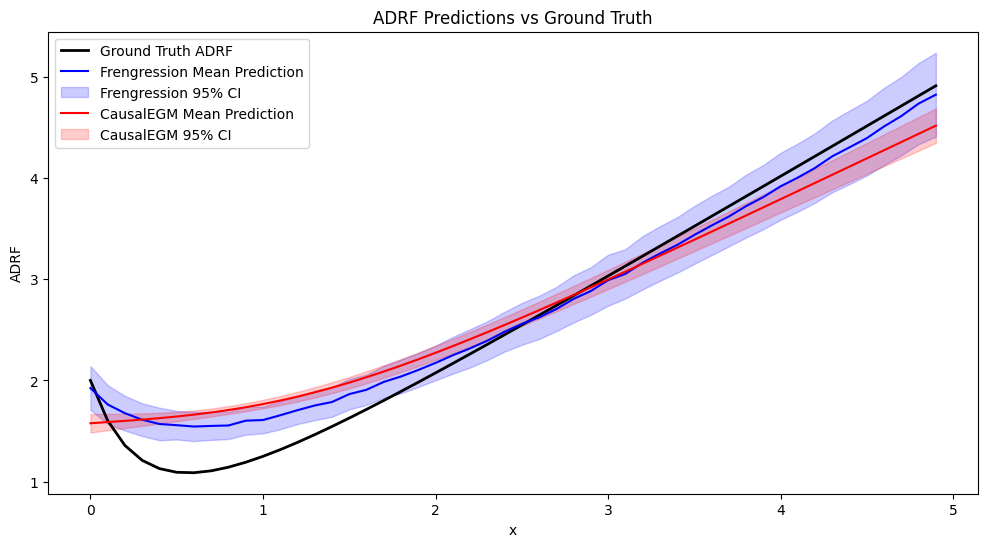

Frengression Average RMSE over 30 reps: 0.6724
Frengression Average MAPE over 30 reps: 0.2508
CausalEGM Average RMSE over 30 reps: 0.3918
CausalEGM Average MAPE over 30 reps: 0.1738


In [95]:
import numpy as np
import torch
import matplotlib.pyplot as plt
from tqdm import tqdm

# Set up the range of x values
x_vals = np.arange(0, 5, 0.1)
x_tensor = torch.tensor(x_vals.reshape(-1, 1), dtype=torch.float32)

# Number of repetitions
nrep = 30
n_tr = 1000
n_p = 1000
num_iters = 2000
binary_intervention = False
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Lists to store predictions and error metrics
frengression_preds = []
causalegm_preds = []
frengression_rmses = []
frengression_mapes = []
causalegm_rmses = []
causalegm_mapes = []

# Ground truth ADRF values
ground_truth_adrf = Sim_Hirano_Imbens_adrf(x_vals)

# Begin experiment
for rep in tqdm(range(nrep)):
    # Simulate training data
    x_train, y_train, z_train = Sim_Hirano_Imbens_sampler(
        N=n_tr, v_dim=200, seed=1024 + rep, batch_size=n_tr
    ).load_all()
    x_tr = torch.tensor(x_train, dtype=torch.float32)
    y_tr = torch.tensor(y_train, dtype=torch.float32)
    z_tr = torch.tensor(z_train, dtype=torch.float32)

    # Initialize and train Frengression model
    fr_model = Frengression(
        x_tr.shape[1], y_tr.shape[1], z_tr.shape[1],
        noise_dim=1, num_layer=3, hidden_dim=400,
        device=device, x_binary=binary_intervention
    )
    fr_model.train_xz(x_tr, z_tr, num_iters=num_iters, lr=1e-4, print_every_iter=400)
    fr_model.train_y(x_tr, z_tr, y_tr, num_iters=num_iters, lr=1e-4, print_every_iter=400)

    # Predict using Frengression model
    fr_pred = fr_model.predict_causal(
        x_tensor, target="mean", sample_size=1000
    ).detach().cpu().numpy().reshape(-1)
    frengression_preds.append(fr_pred)

    # Compute RMSE and MAPE for Frengression model
    fr_rmse = rmse(fr_pred, ground_truth_adrf)
    fr_mape = mape(fr_pred, ground_truth_adrf)
    frengression_rmses.append(fr_rmse)
    frengression_mapes.append(fr_mape)

    # Initialize and train CausalEGM model
    # Assuming CausalEGM requires similar data inputs
    cegm_model = CausalEGM(params=params, random_seed=123 + rep)
    cegm_model.train(data=[x_train, y_train, z_train], n_iter=1000, verbose=False)

    # Predict using CausalEGM model
    cegm_pred = cegm_model.getADRF(x_list=x_vals.tolist())
    causalegm_preds.append(cegm_pred)

    # Compute RMSE and MAPE for CausalEGM model
    cegm_rmse = rmse(cegm_pred, ground_truth_adrf)
    cegm_mape = mape(cegm_pred, ground_truth_adrf)
    causalegm_rmses.append(cegm_rmse)
    causalegm_mapes.append(cegm_mape)

# Convert prediction lists to NumPy arrays for easier manipulation
frengression_preds = np.array(frengression_preds)
causalegm_preds = np.array(causalegm_preds)

# Compute mean and 95% confidence intervals
fr_mean_pred = frengression_preds.mean(axis=0)
fr_std_pred = frengression_preds.std(axis=0)
fr_ci_upper = fr_mean_pred + 1.96 * fr_std_pred / np.sqrt(nrep)
fr_ci_lower = fr_mean_pred - 1.96 * fr_std_pred / np.sqrt(nrep)

cegm_mean_pred = causalegm_preds.mean(axis=0)
cegm_std_pred = causalegm_preds.std(axis=0)
cegm_ci_upper = cegm_mean_pred + 1.96 * cegm_std_pred / np.sqrt(nrep)
cegm_ci_lower = cegm_mean_pred - 1.96 * cegm_std_pred / np.sqrt(nrep)

# Plotting the results
plt.figure(figsize=(12, 6))

# Ground truth ADRF
plt.plot(x_vals, ground_truth_adrf, label='Ground Truth ADRF', color='black', linewidth=2)

# Frengression predictions
plt.plot(x_vals, fr_mean_pred, label='Frengression Mean Prediction', color='blue')
plt.fill_between(x_vals, fr_ci_lower, fr_ci_upper, color='blue', alpha=0.2, label='Frengression 95% CI')

# CausalEGM predictions
plt.plot(x_vals, cegm_mean_pred, label='CausalEGM Mean Prediction', color='red')
plt.fill_between(x_vals, cegm_ci_lower, cegm_ci_upper, color='red', alpha=0.2, label='CausalEGM 95% CI')

plt.xlabel('x')
plt.ylabel('ADRF')
plt.title('ADRF Predictions vs Ground Truth')
plt.legend()
plt.show()

# Print average RMSE and MAPE for both models
print(f"Frengression Average RMSE over {nrep} reps: {np.mean(frengression_rmses):.4f}")
print(f"Frengression Average MAPE over {nrep} reps: {np.mean(frengression_mapes):.4f}")

print(f"CausalEGM Average RMSE over {nrep} reps: {np.mean(causalegm_rmses):.4f}")
print(f"CausalEGM Average MAPE over {nrep} reps: {np.mean(causalegm_mapes):.4f}")
